In [1]:
import sys
#Change path specificly to your directories
sys.path.insert(1, '/home/codahead/Fishial/FishialReaserch')

import time
import torch
import os
import cv2
import math 
import matplotlib.pyplot as plt
import torchvision.models as models
import numpy as np
from torch import nn
from torch.optim import Optimizer, SGD
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from sklearn.neighbors import KDTree
import pandas as pd
from module.classification_package.src.utils import read_json, save_json
from module.classification_package.interpreter_classifier import ClassifierFC
from module.classification_package.interpreter_embeding import EmbeddingClassifier
from module.classification_package.interpreter_embeding_data import EmbeddingClassifierData
from module.segmentation_package.interpreter_segm import SegmentationInference
from module.classification_package.src.dataset import FishialDataset
# from module.segmentation_package.src.utils import resize_image
from PIL import Image
import numpy as np
import random
import sklearn.metrics.pairwise
import scipy.spatial.distance
import copy
import json
import time
import requests
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from os import listdir
from os.path import isfile, join
# TRESHOLD 40.6256
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (40, 20),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [2]:
model_classifier_triplet_data_base = EmbeddingClassifierData(
    '../../output/train_results/resnet_18_200/new_embedding_bs_25_3.ckpt',
    '../../output/train_results/resnet_18_200/data_train.json_embedding.pt',
    device='cpu', THRESHOLD = 1e5, 
    resnet = models.resnet18(), emb_vec = 200)

data_labels = read_json('../../output/train_results/resnet_18_200/data_train.json_labels.json')
data_labels.update({'75': 'Other'})

In [3]:
softmax = nn.Softmax(dim=None)

main_folder = "/home/codahead/Fishial/FishialReaserch/datasets/fishial_75_V1.0"
data_sets = {
    'train'       : {'path' : 'data_train.json'       },
    'test'        : {'path' : 'data_test.json'        },
    'remain'      : {'path' : 'data_remain.json'      },
    'out_of_class': {'path' : 'data_out_of_class.json'}
}

for i in data_sets:
    path_to_json = os.path.join(main_folder, data_sets[i]['path'])
    data = read_json(path_to_json)
    
    data_sets[i].update({
        'labels': {
            data_labels[label]: {       
            'pred':     [],
            'distance': [] 
    } for label in data_labels}})
    
    for idx in range(len(data['label'])):
        label_correct = data['label'][idx]
        img_path = os.path.join(main_folder, data['img_path'][idx])

        img = cv2.imread(img_path)
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        output_triplet_data = model_classifier_triplet_data_base.inference_numpy(img, top_k = 5)
        
        if label_correct in data_sets[i]['labels']:
            data_sets[i]['labels'][label_correct]['distance'].append(output_triplet_data[0][2])
            data_sets[i]['labels'][label_correct]['pred'].append(data_labels[str(output_triplet_data[0][0])])
        else:
            data_sets[i]['labels']['Other']['distance'].append(output_triplet_data[0][2])
            data_sets[i]['labels']['Other']['pred'].append(data_labels[str(output_triplet_data[0][0])])

        print("name: {} Left: [{}/{}] ".format(data_sets[i]['path'], 
                                                     idx, len(data['label']) ), end='\r')

In [4]:
def get_f1_score(map_truth):
    try:
        f1 = (map_truth[0] / (map_truth[0] + 0.5 * ( map_truth[2] + map_truth[3] )))
        return f1
    except ZeroDivisionError:
        return None

#[t_p, t_n, f_p, f_n]
def get_g_mean(map_truth):
    try:
        t_p, t_n, f_p, f_n = map_truth
        sens = (t_p / (t_p + f_n))
        spec = t_n / (t_n + f_p)
        return math.sqrt(sens * spec)
    except ZeroDivisionError:
        return None

In [5]:
previous = 0

index_name = []

mean_value = np.median([k for i in data_sets for z in data_sets[i]['labels'] for k in data_sets[i]['labels'][z]['distance']])
print(f'Median distance over all datasets: {mean_value}')

thresholds = list(np.linspace(mean_value, mean_value + mean_value * 0.65, 1000))

for data_set in data_sets:
    for label_idx, label in enumerate(data_sets[data_set]['labels']):
        left_cnt = len(data_sets[data_set]['labels']) - label_idx
        print(f'Left: {left_cnt} dataset: {data_set}', end='\r')
        dict_result = {
            'True Positive' : [],
            'True Negative' : [],
            'False Positive': [],
            'False Negative': [],
            'Threshold': []}
        
        specie = data_sets[data_set]['labels'][label]
        
        f1_scores = []
        for idx, i in enumerate(thresholds):
            f_p, f_n, t_p, t_n = 0, 0, 0, 0
            for id_dist, dist in enumerate(specie['distance']):
                if dist <= i:
                    if specie['pred'][id_dist] == label:
                        t_p += 1
                    else:
                        f_p += 1
                else:
                    if specie['pred'][id_dist] == label:
                        f_n += 1
                    else:
                        t_n += 1
            try:
                #(t_p / (t_p + 0.5 * ( f_p + f_n )))
                f1_scores.append([t_p, t_n, f_p, f_n])
            except ZeroDivisionError:
                pass
#                 f1_scores.append(0.0)
        
        data_sets[data_set]['labels'][label].update({'f1_scores': f1_scores})
    
max_score, top_thresh, g_mean = 0.0, 0.0, 0.0

for thresholds_idx, threshold in enumerate(thresholds):
    list_of_f1_scores = []
    
    for data_set in ['test', 'remain', 'out_of_class']:
        for label in data_sets[data_set]['labels']:
            list_of_f1_scores.append(data_sets[data_set]['labels'][label]['f1_scores'][thresholds_idx])
     
    f1_scores = []
    g_mean = []
    for map_truth in list_of_f1_scores:
        if get_f1_score(map_truth):
            f1_scores.append(get_f1_score(map_truth))

        if get_g_mean(map_truth):
            g_mean.append(get_g_mean(map_truth))

    mean_f1_score = np.mean(f1_scores)
    mean_g_mean = np.mean(g_mean)

    if  mean_g_mean > max_score:
        max_score, top_thresh, g_mean = mean_g_mean, threshold, mean_f1_score
            
print(f'| Data: {data_set} | THRESHOLD: {top_thresh} | F1 score: {max_score} | mean_g_mean: {mean_g_mean}')

Median distance over all datasets: 2.9344968795776367
| Data: out_of_class | THRESHOLD: 3.711595127317641 | F1 score: 0.7544486885903154 | mean_g_mean: 0.7123864115032106


In [6]:
def draw_hist(data, title):
    std = np.std(data)
    mean = np.mean(data)
    median = np.median(data)
    var = np.var(data)
    
    bin_size = 40
    
    fig, ax = plt.subplots()
    
    counts, bins, _ = ax.hist(data, bins=bin_size) # density=1
    avg = bins[np.argmax(counts)]
    
    ax.axvline(avg - std, 0, 1, label='std left', color='r')
    ax.axvline(median, 0, 1, label='median', color='g')
    ax.axvline(top_thresh, 0, 1, label='top_thresh', color='c', linestyle = '--')
    ax.axvline(avg + std, 0, 1, label='std right', color='r') 
    ax.legend()
    
    y = ((1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * (1 / std * (bins - mean))**2))
#     ax.plot(bins, y, '--')
    ax.set_title(f'Distribution of distances for the data set: {title} $\sigma={round(std, 3)}$:  | $\mu={round(median, 3)}$:  | avg: {round(avg, 3)}')
    ax.set_xlabel(f'Distance (bin size = {bin_size})')
    ax.set_ylabel('Count')
    fig.tight_layout()
    plt.show()
    
    sigma_1x = sum([True if i > (avg - std) and i < (avg + std) else False for i in data])
    sigma_2x = sum([True if i > (avg - 2 * std) and i < (avg + 2 * std) else False for i in data])
    sigma_3x = sum([True if i > (avg - 3 * std) and i < (avg + 3 * std) else False for i in data])
    coef_var = std/mean
    print(f'coefficient variance: {coef_var}')
    print(f'68–95–99.7 rule: |{sigma_1x/ len(data)}|{sigma_2x/ len(data)}|{sigma_3x/ len(data)}|')
    return counts, bins

Name: train


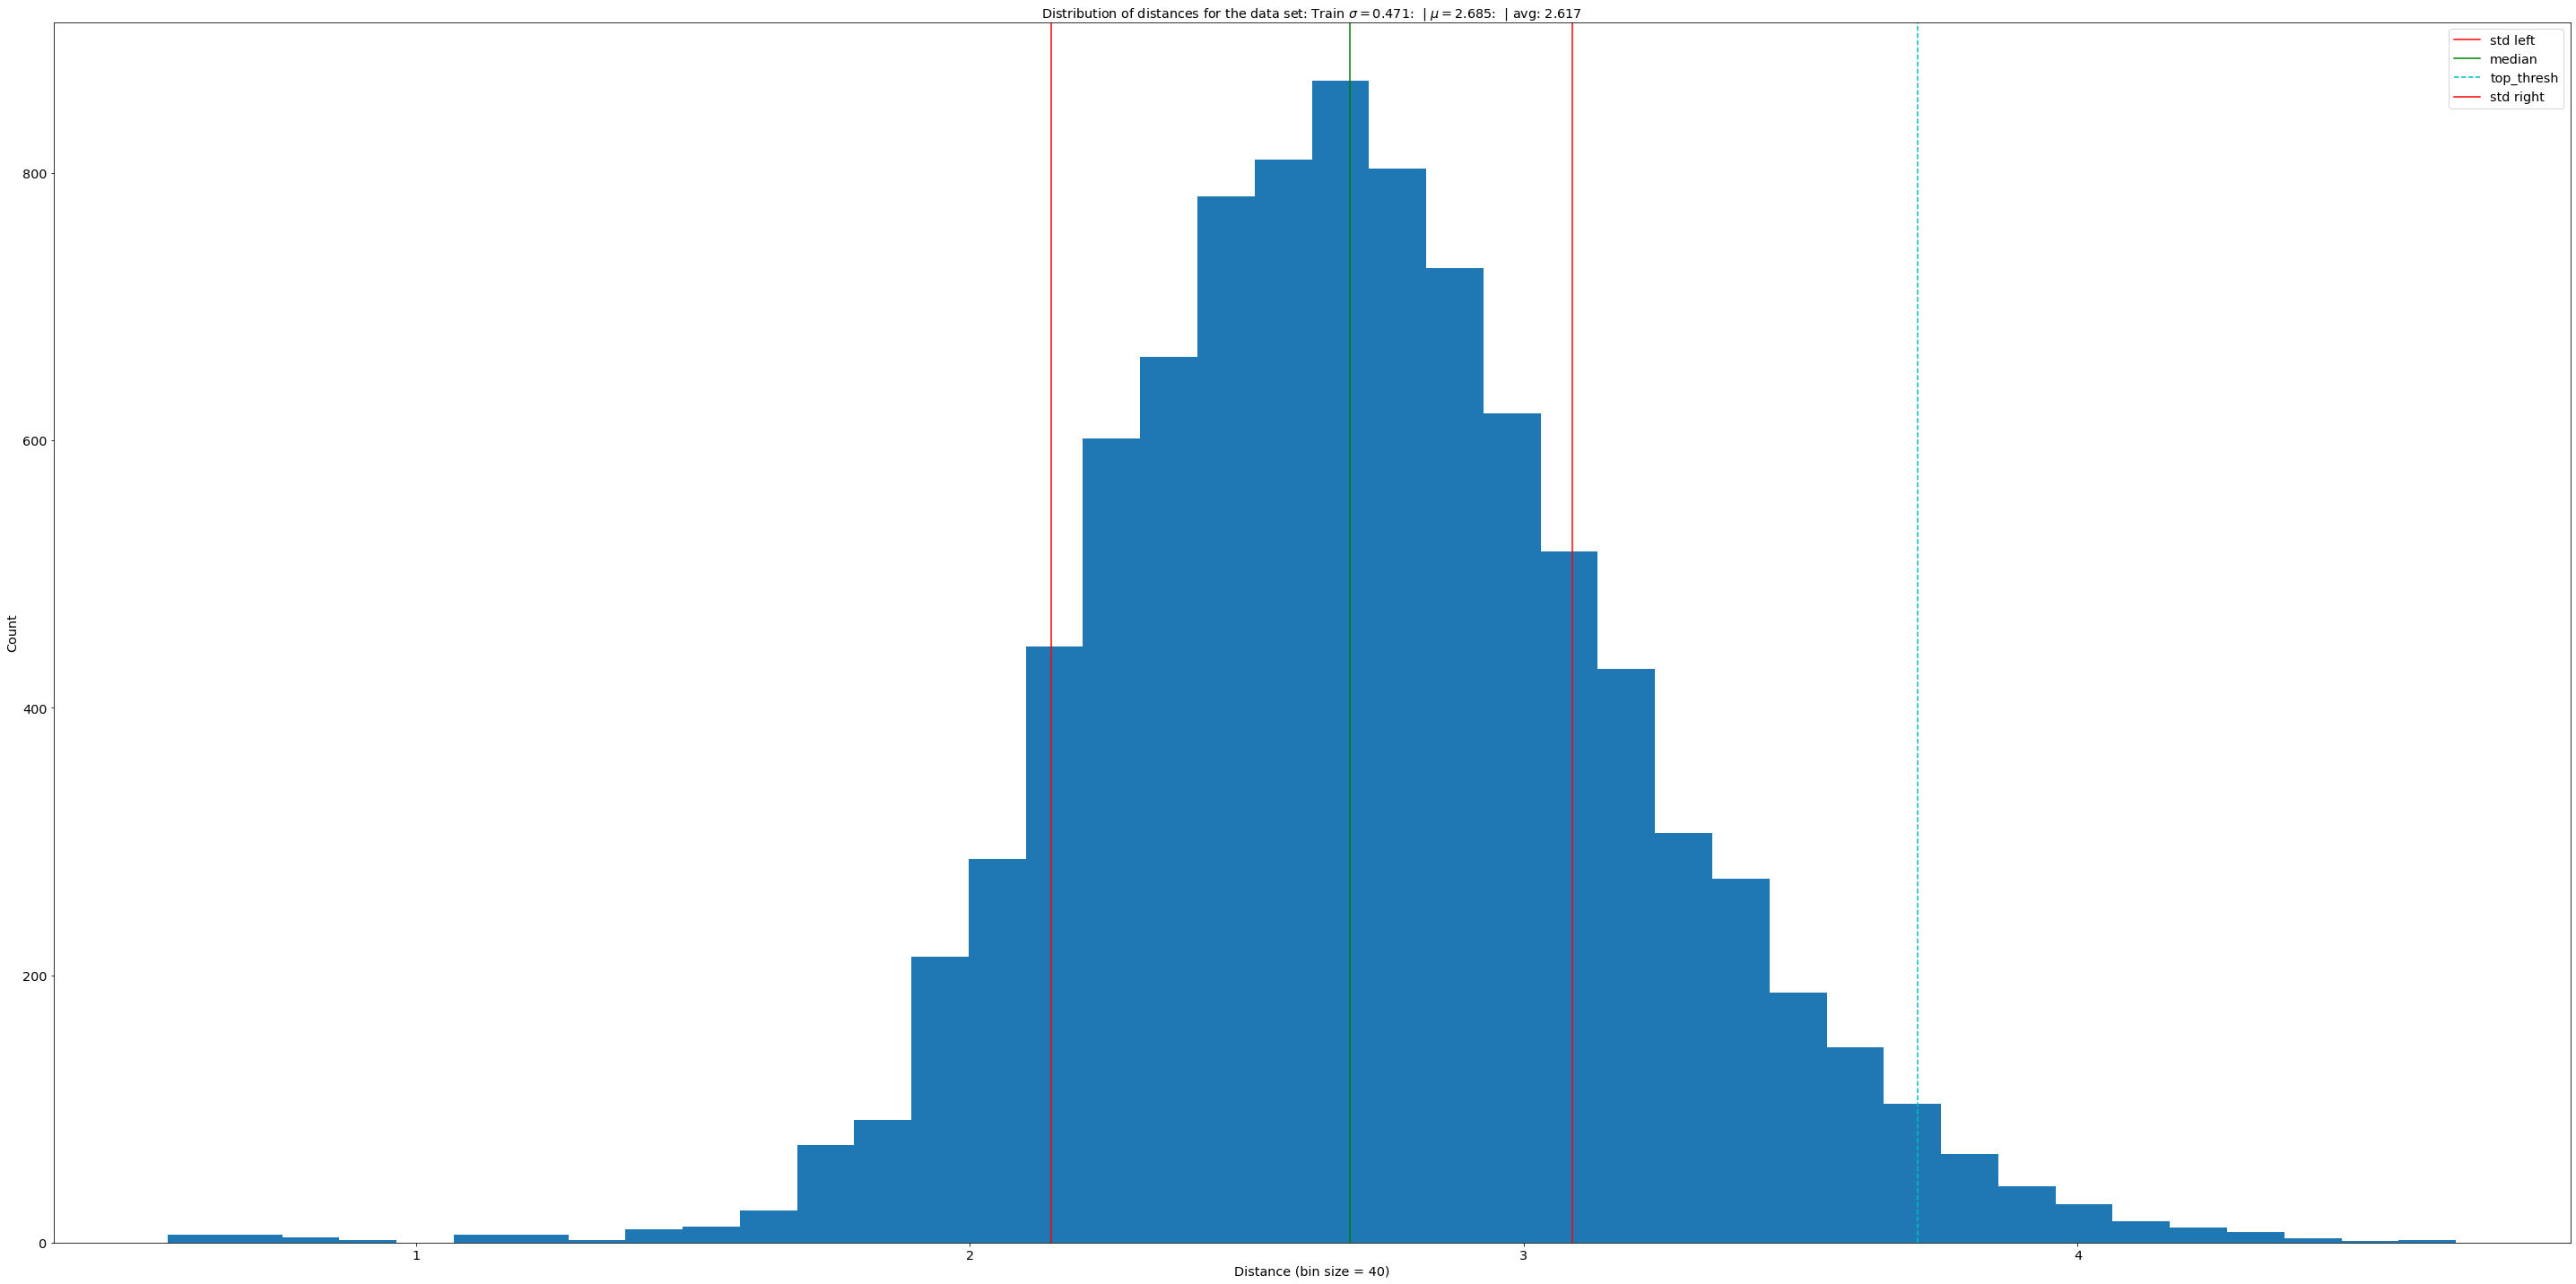

coefficient variance: 0.173786874396357
68–95–99.7 rule: |0.6944052145573059|0.9465507876154264|0.9921781640412819|
Name: test


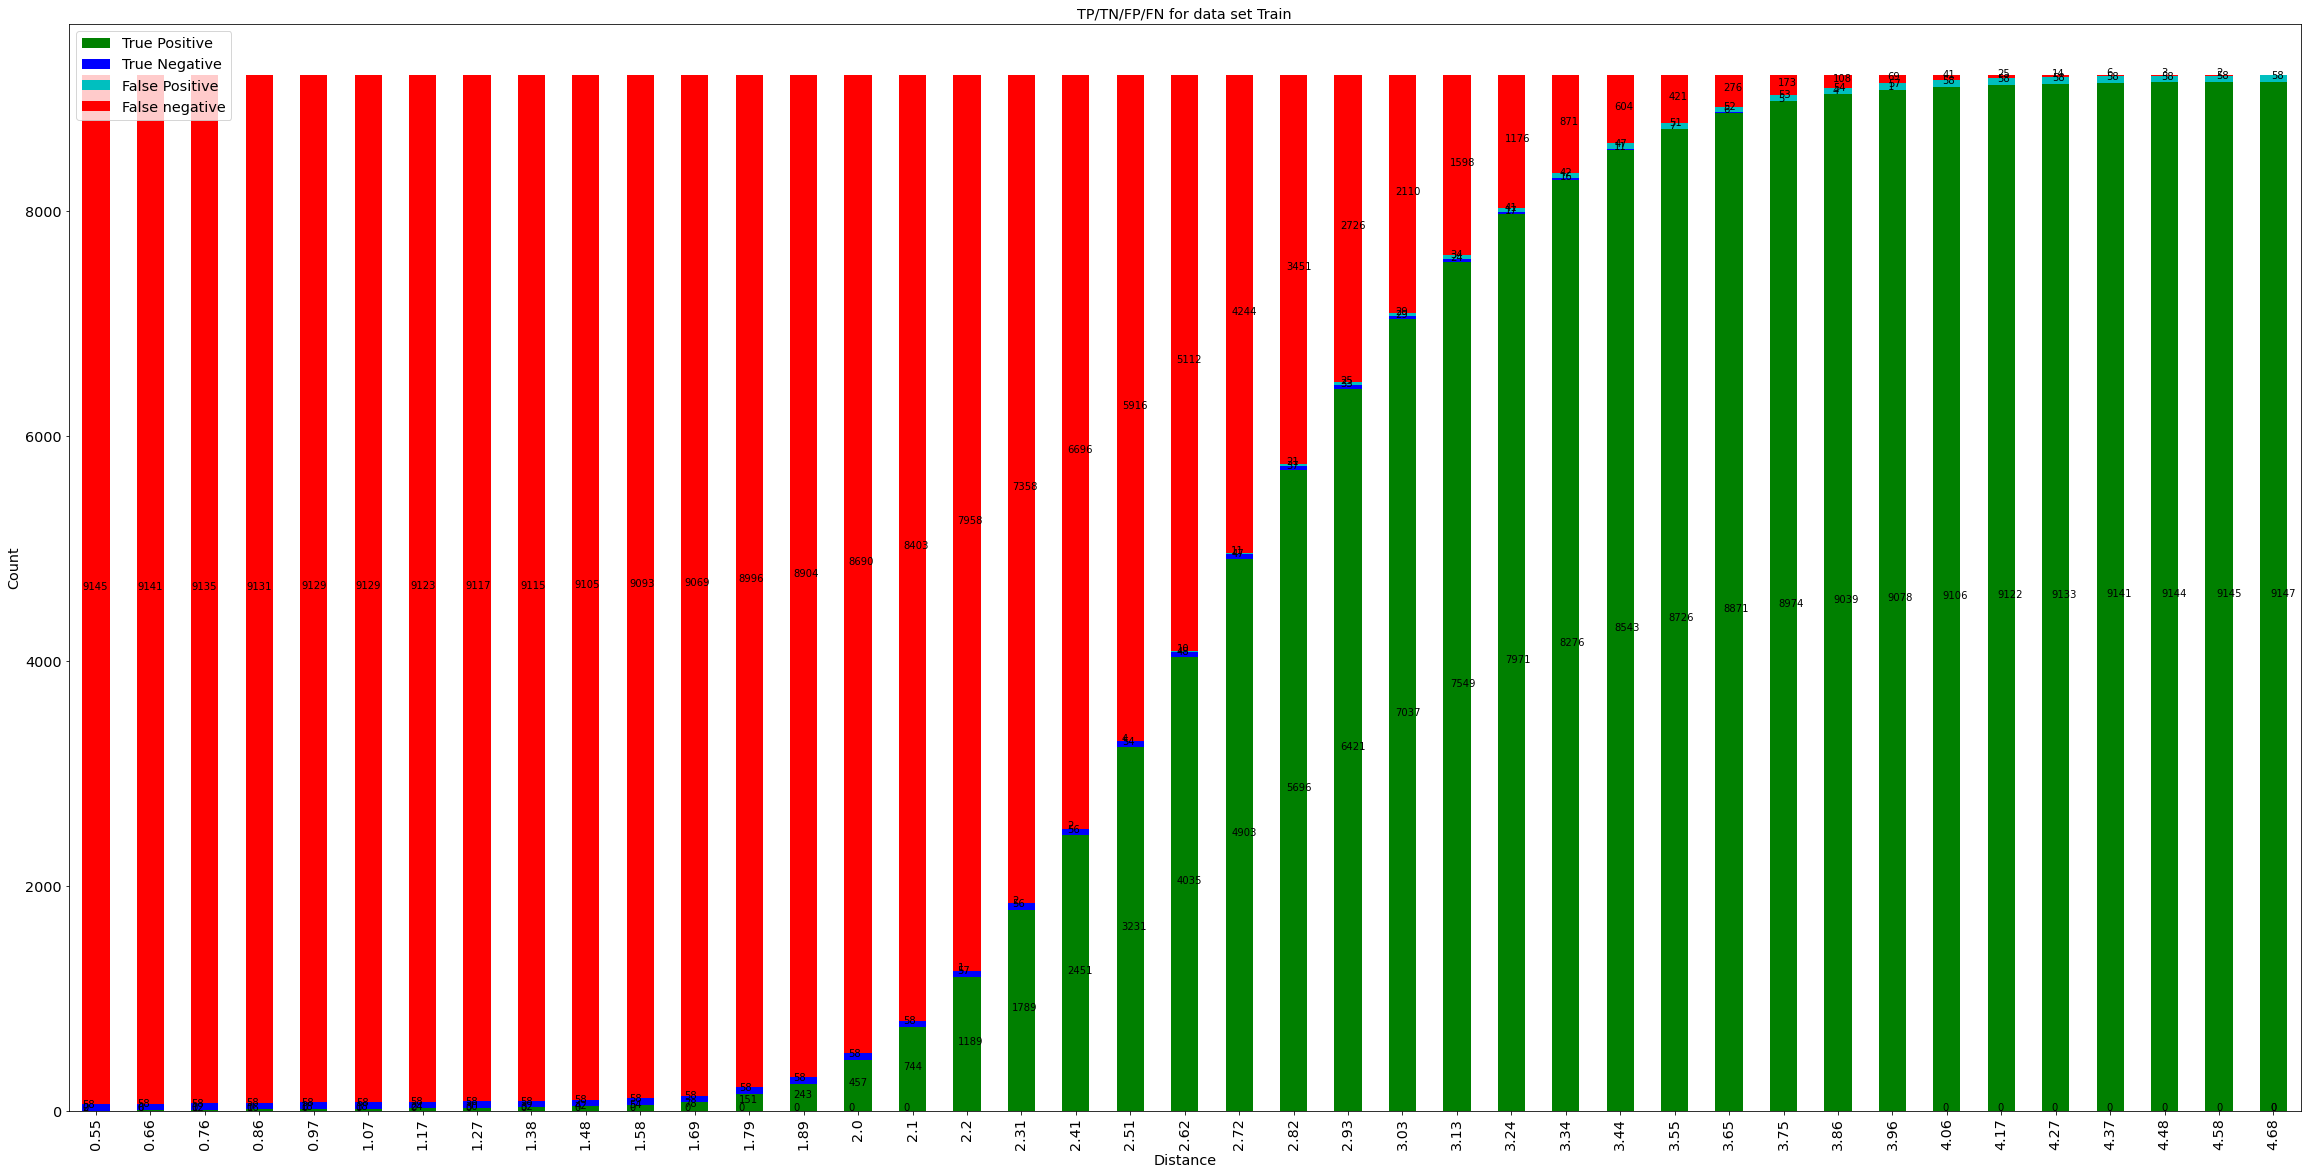

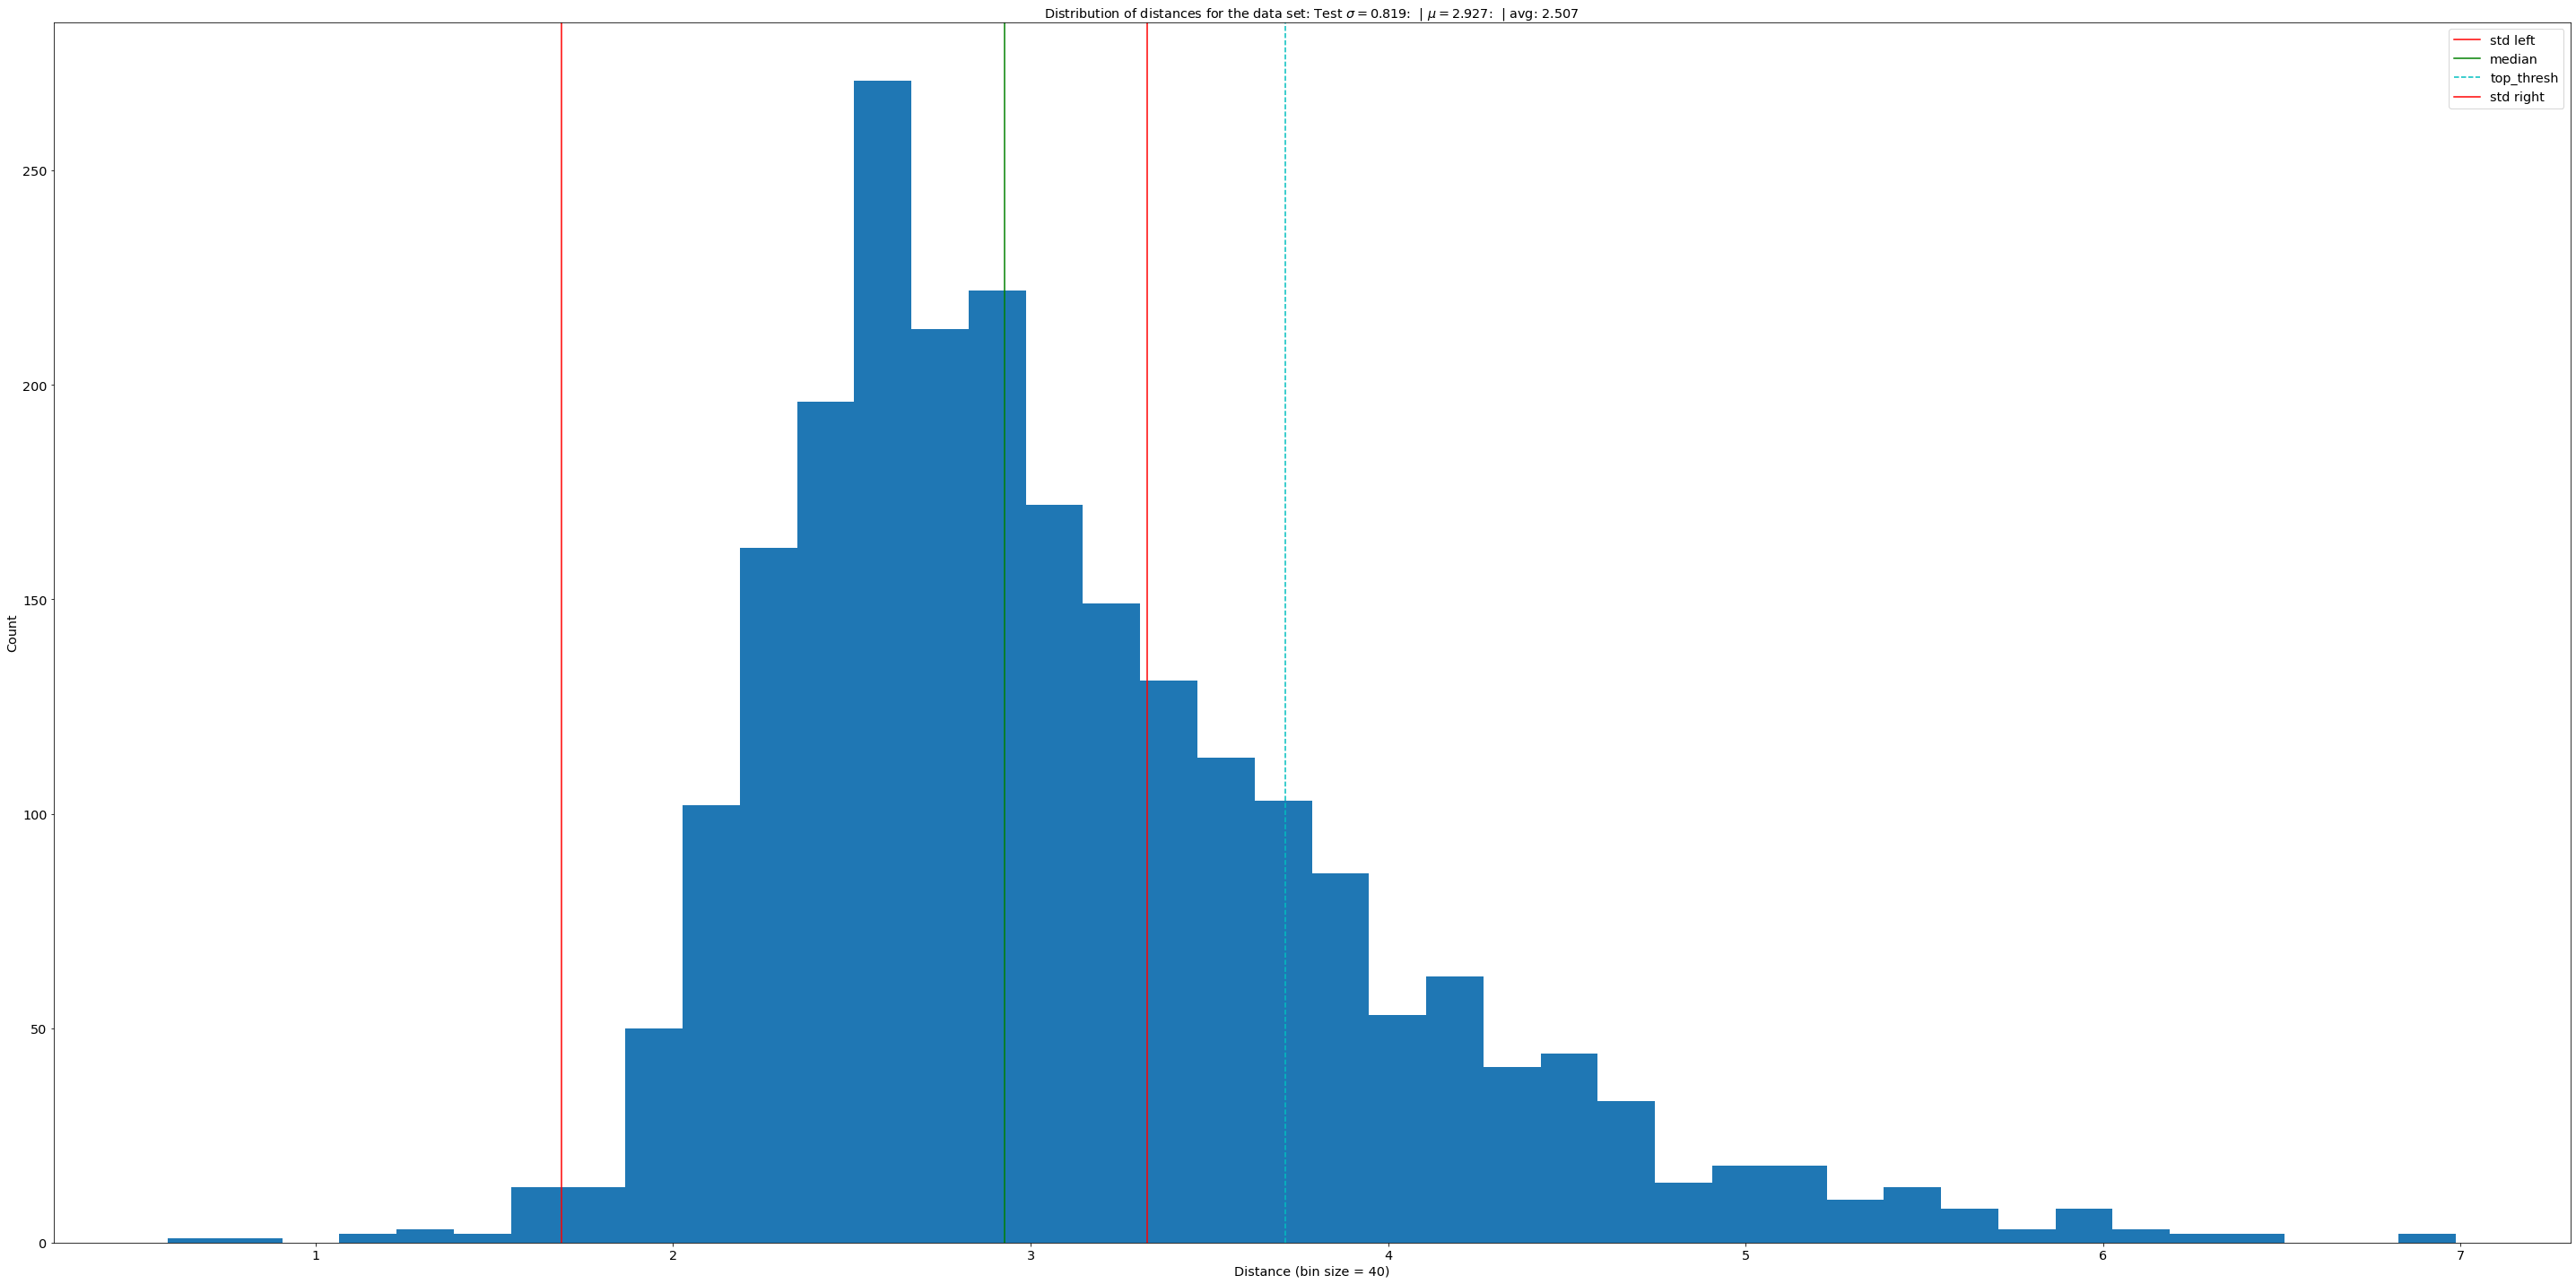

coefficient variance: 0.26398908466609783
68–95–99.7 rule: |0.6707994869602394|0.8854211201368106|0.9653698161607525|
Name: remain


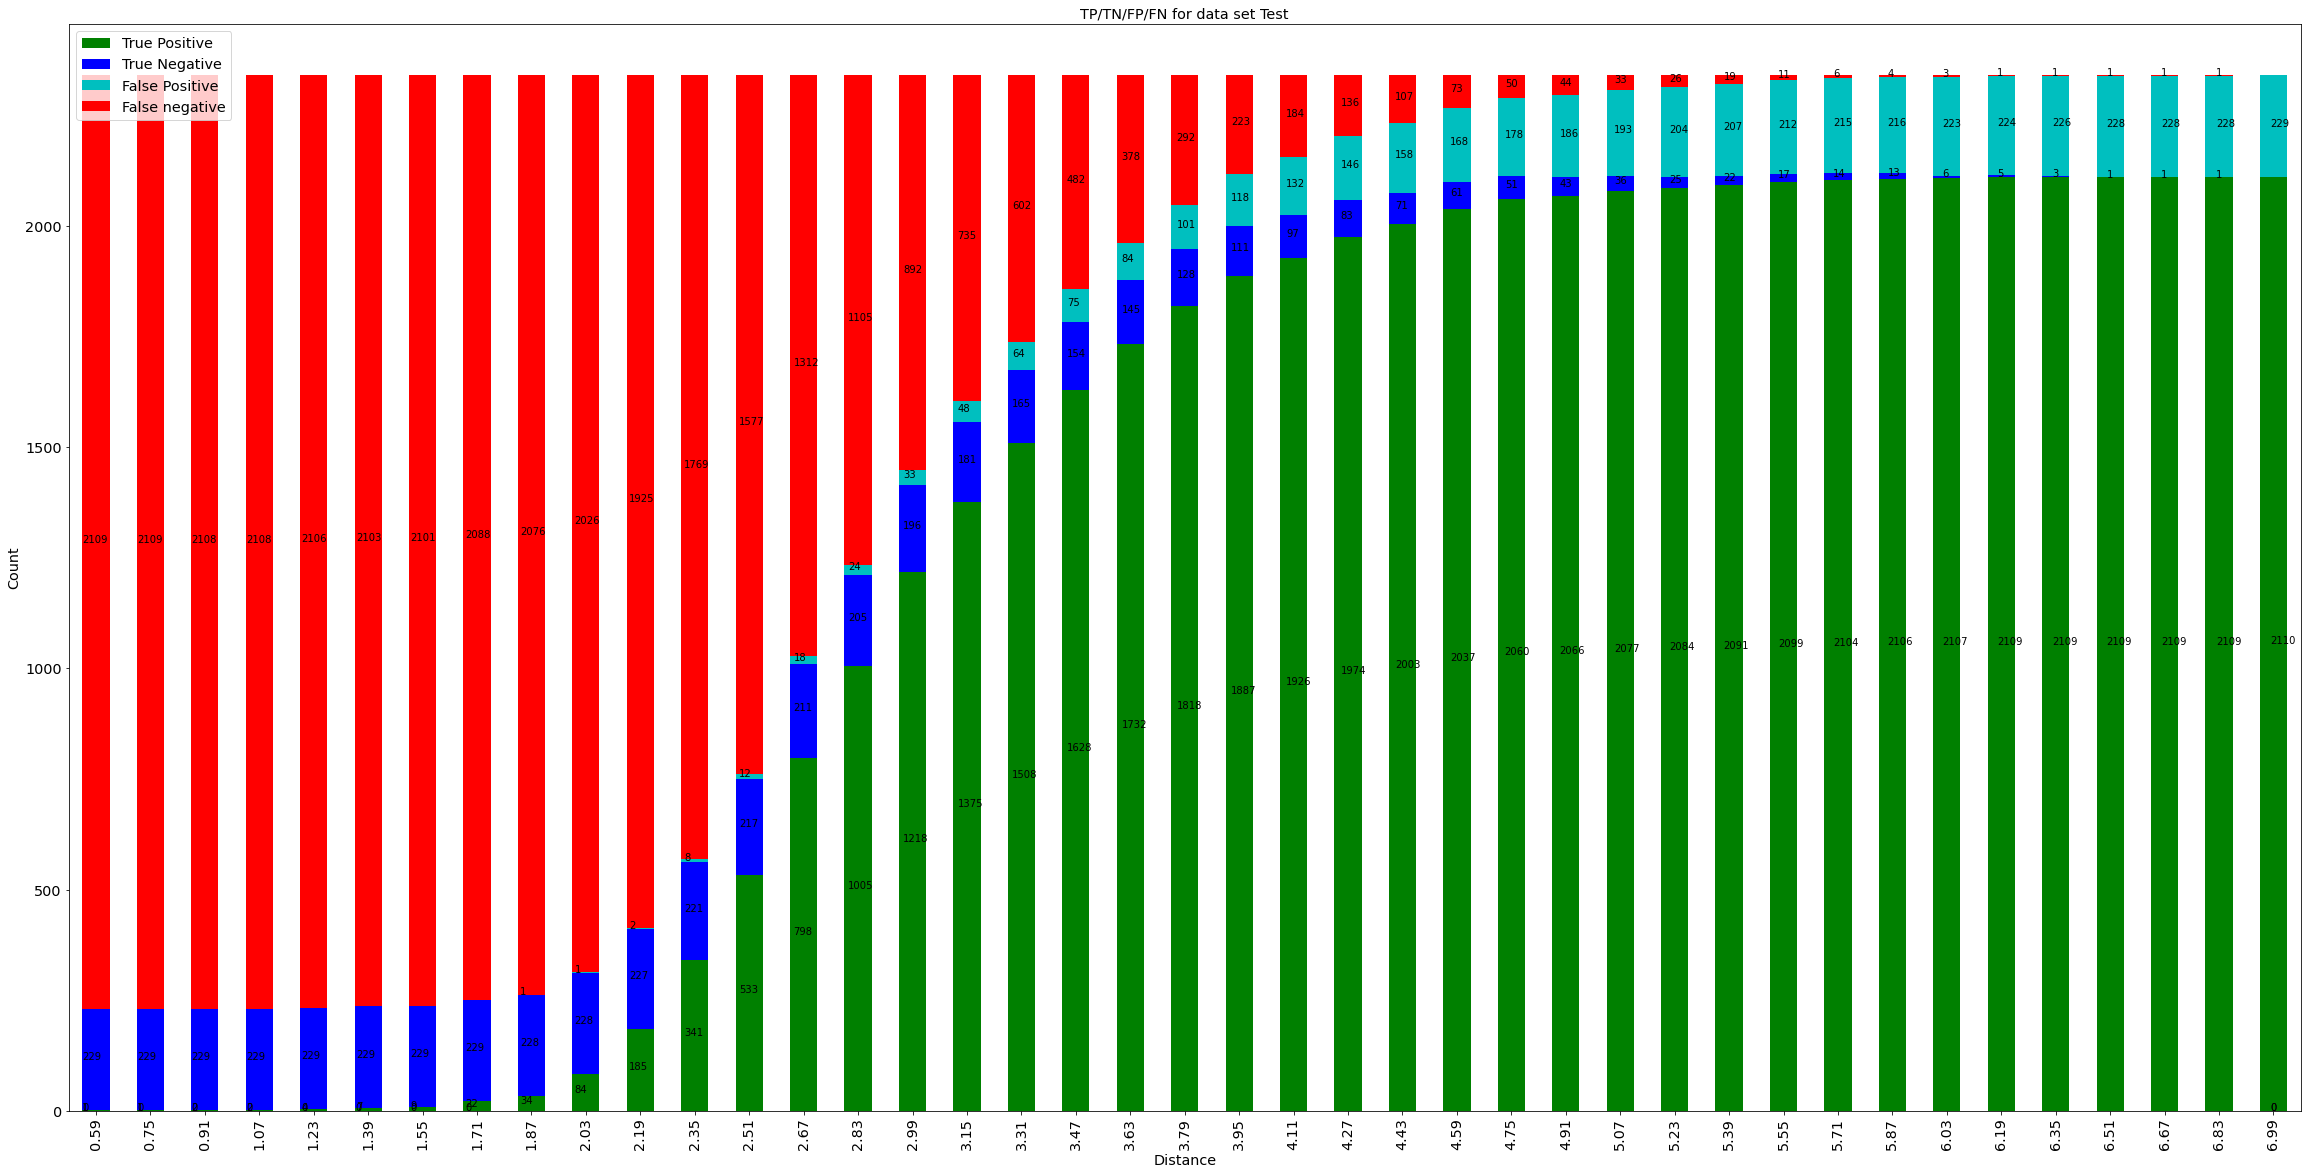

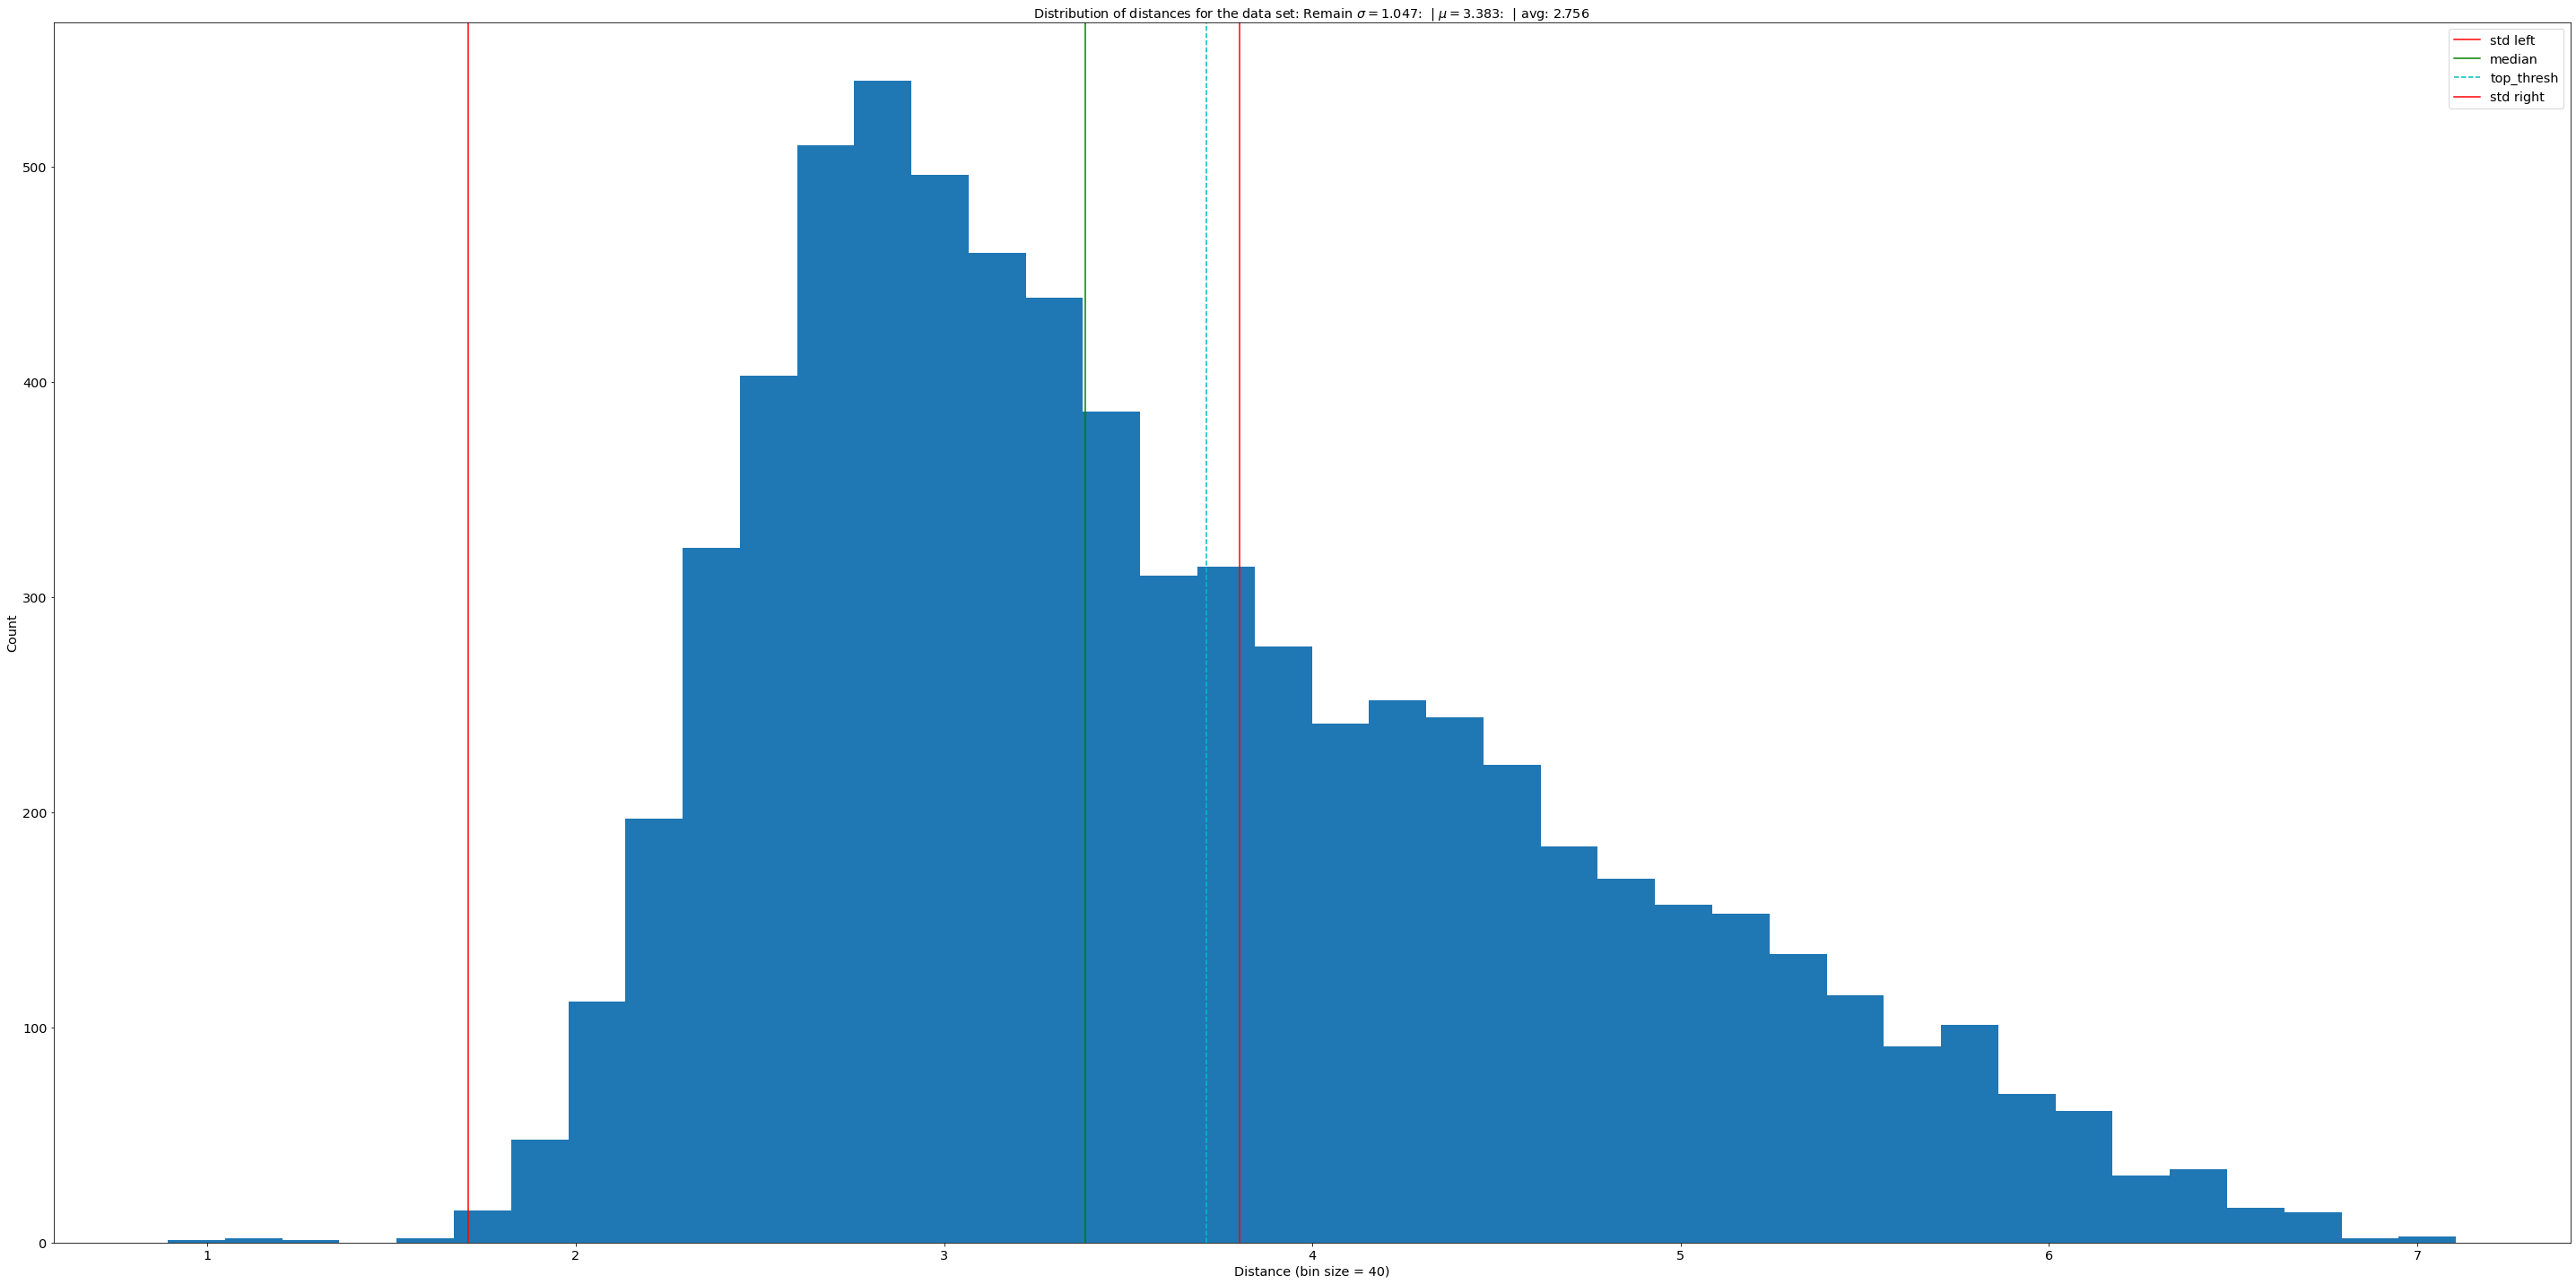

coefficient variance: 0.2891702286439293
68–95–99.7 rule: |0.6253331463038294|0.8510310001402721|0.9706831252630103|
Name: out_of_class


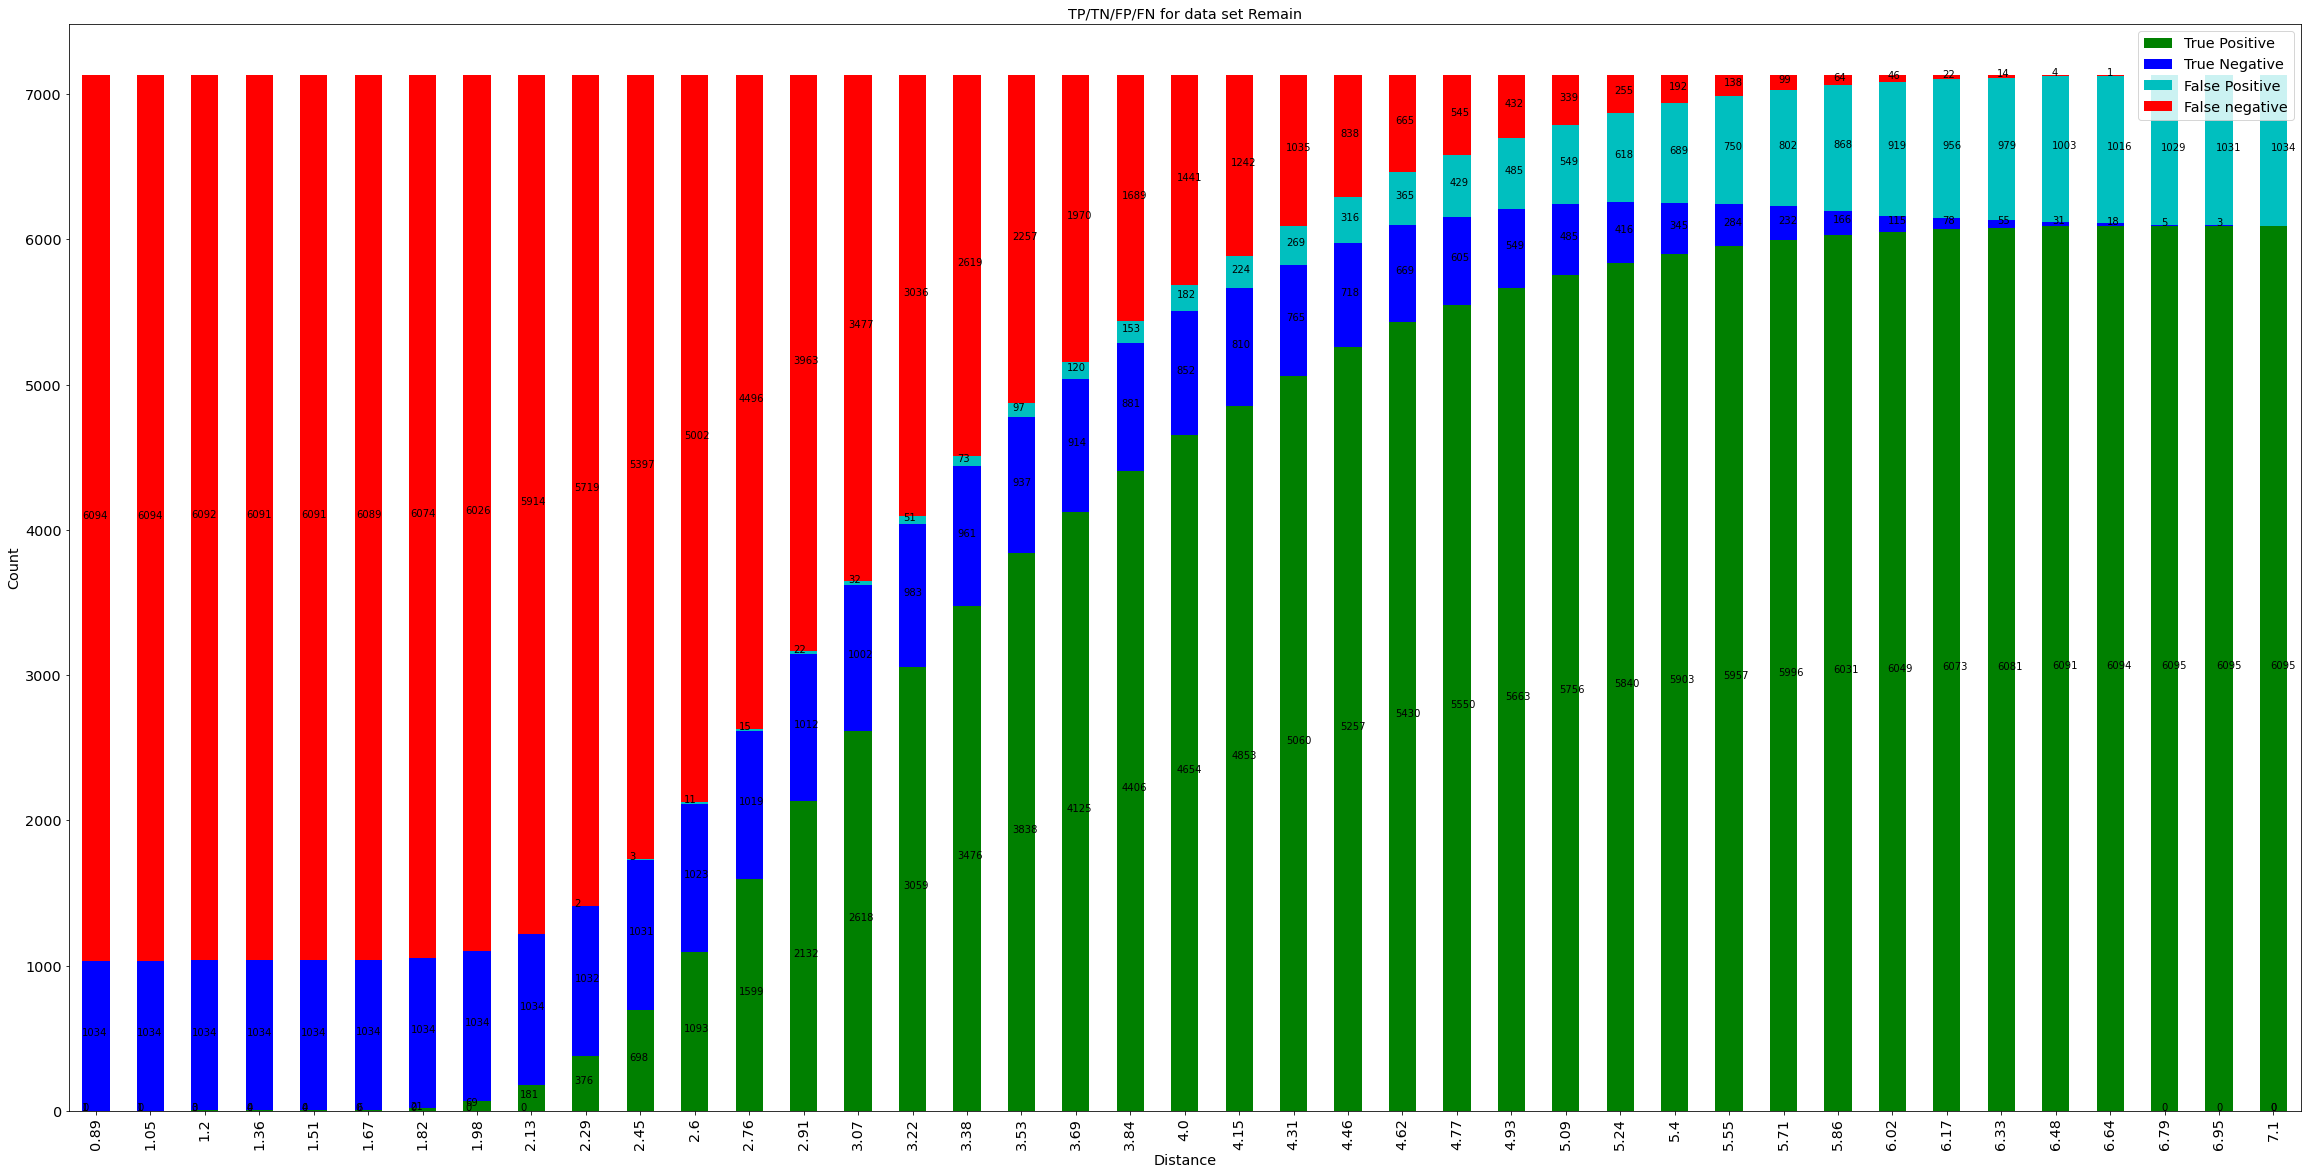

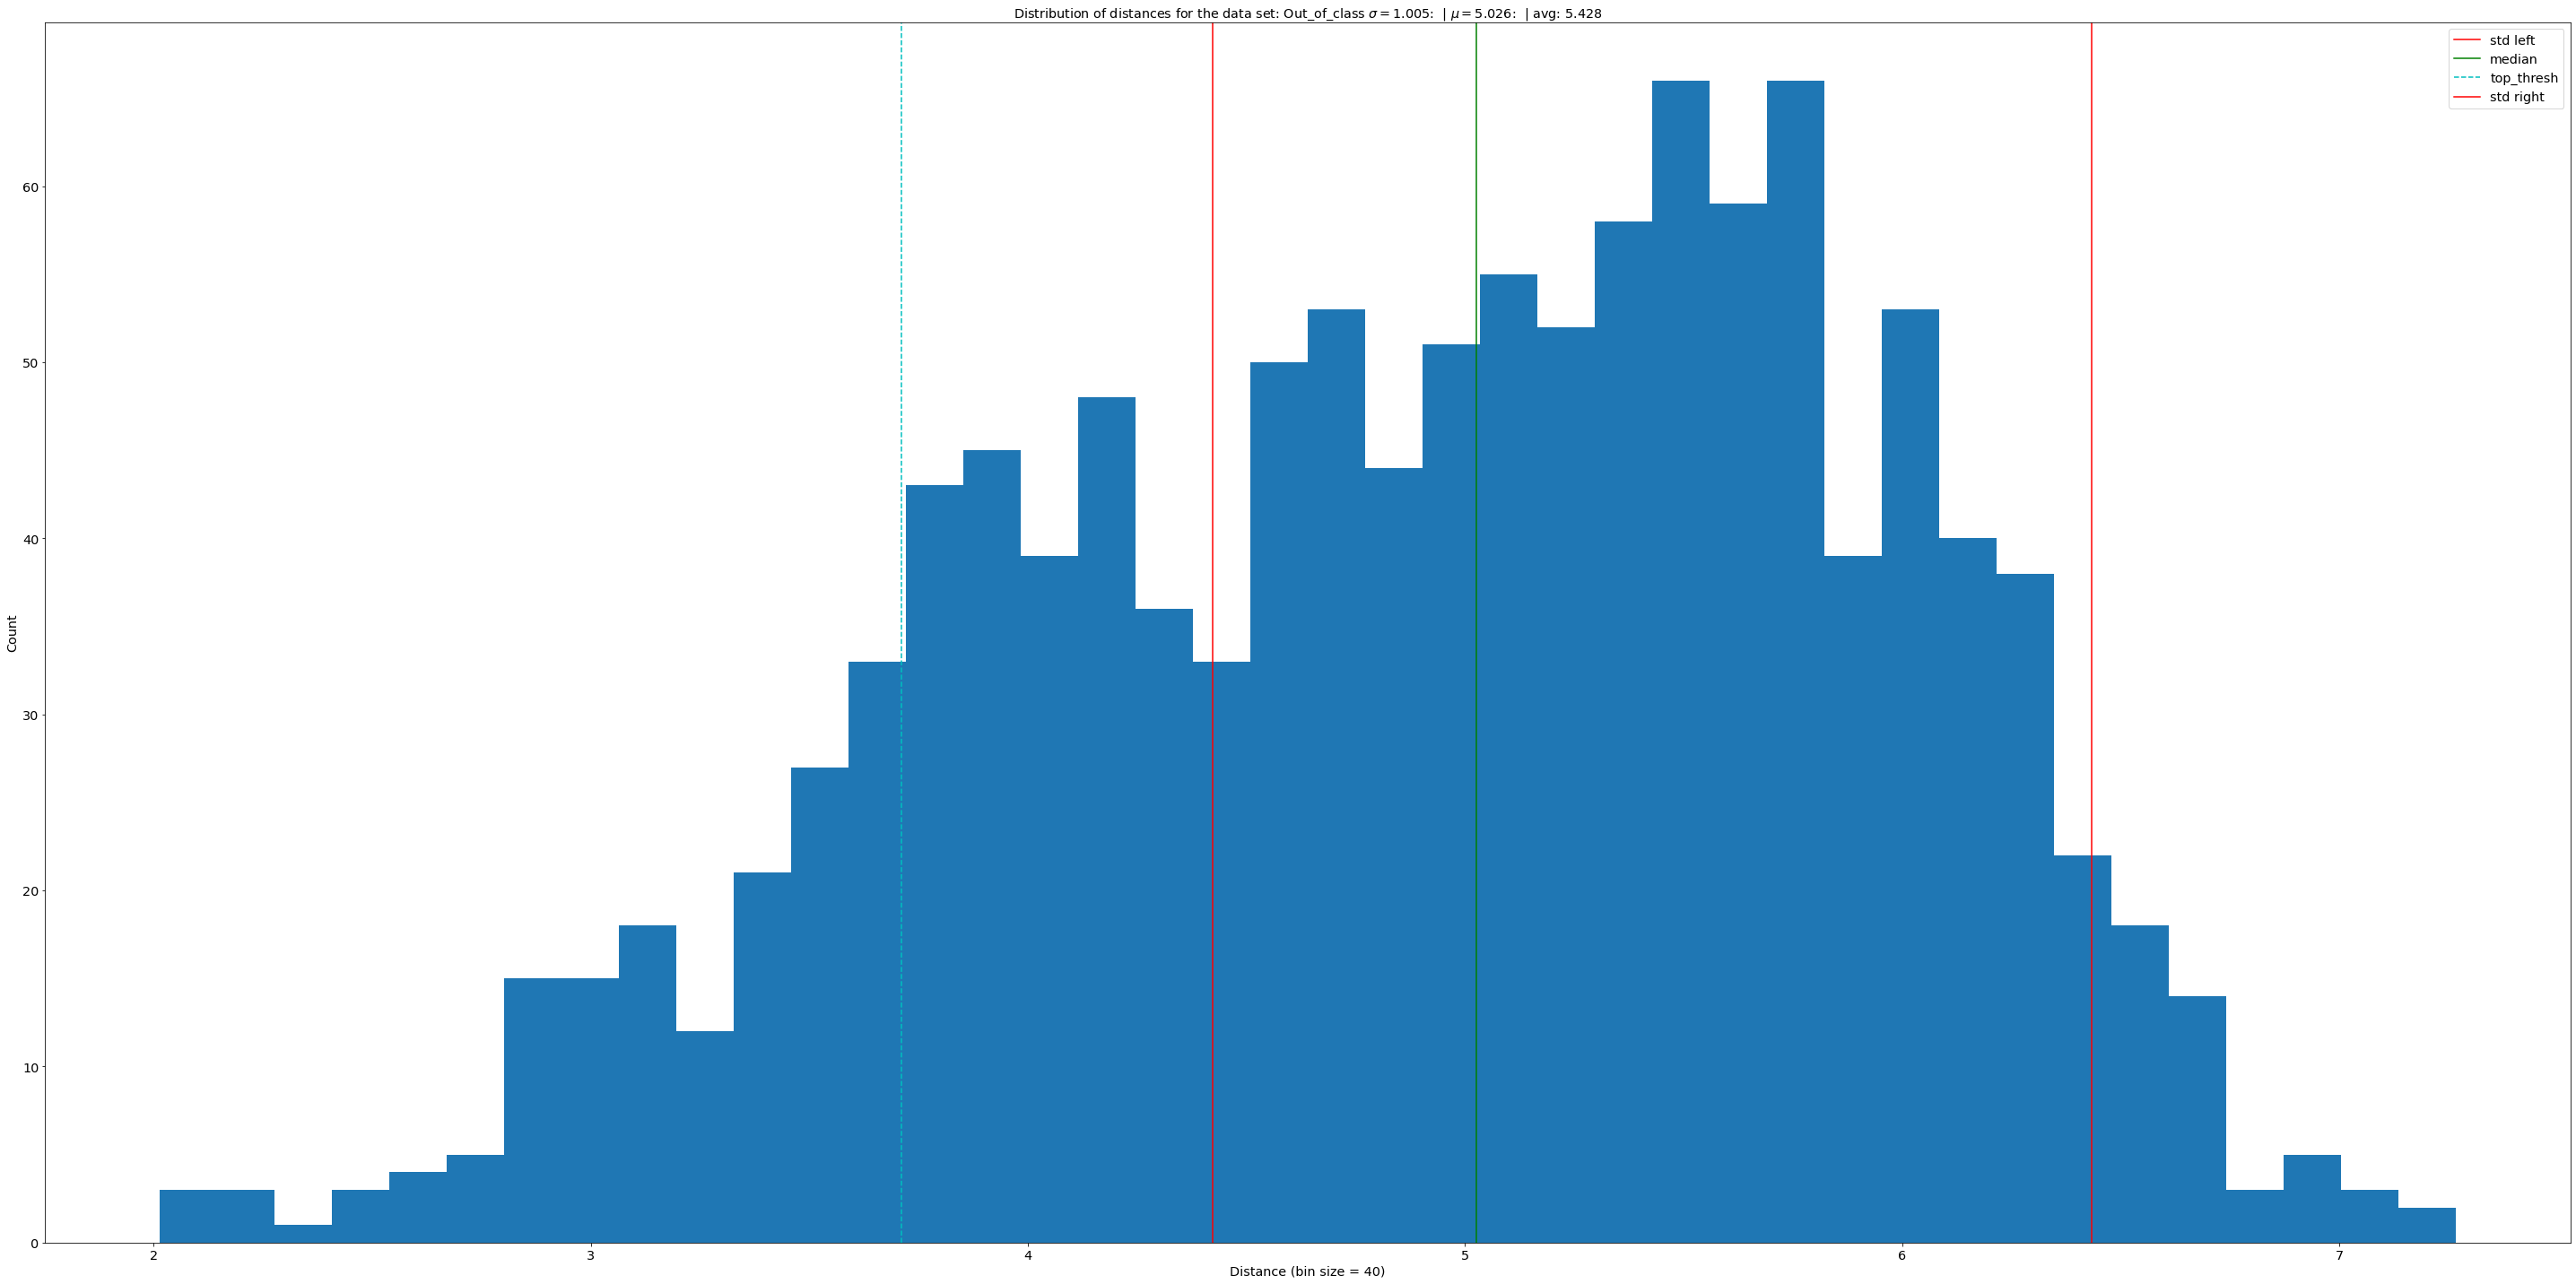

coefficient variance: 0.204384662749288
68–95–99.7 rule: |0.6376569037656904|0.9188284518828452|0.9933054393305439|


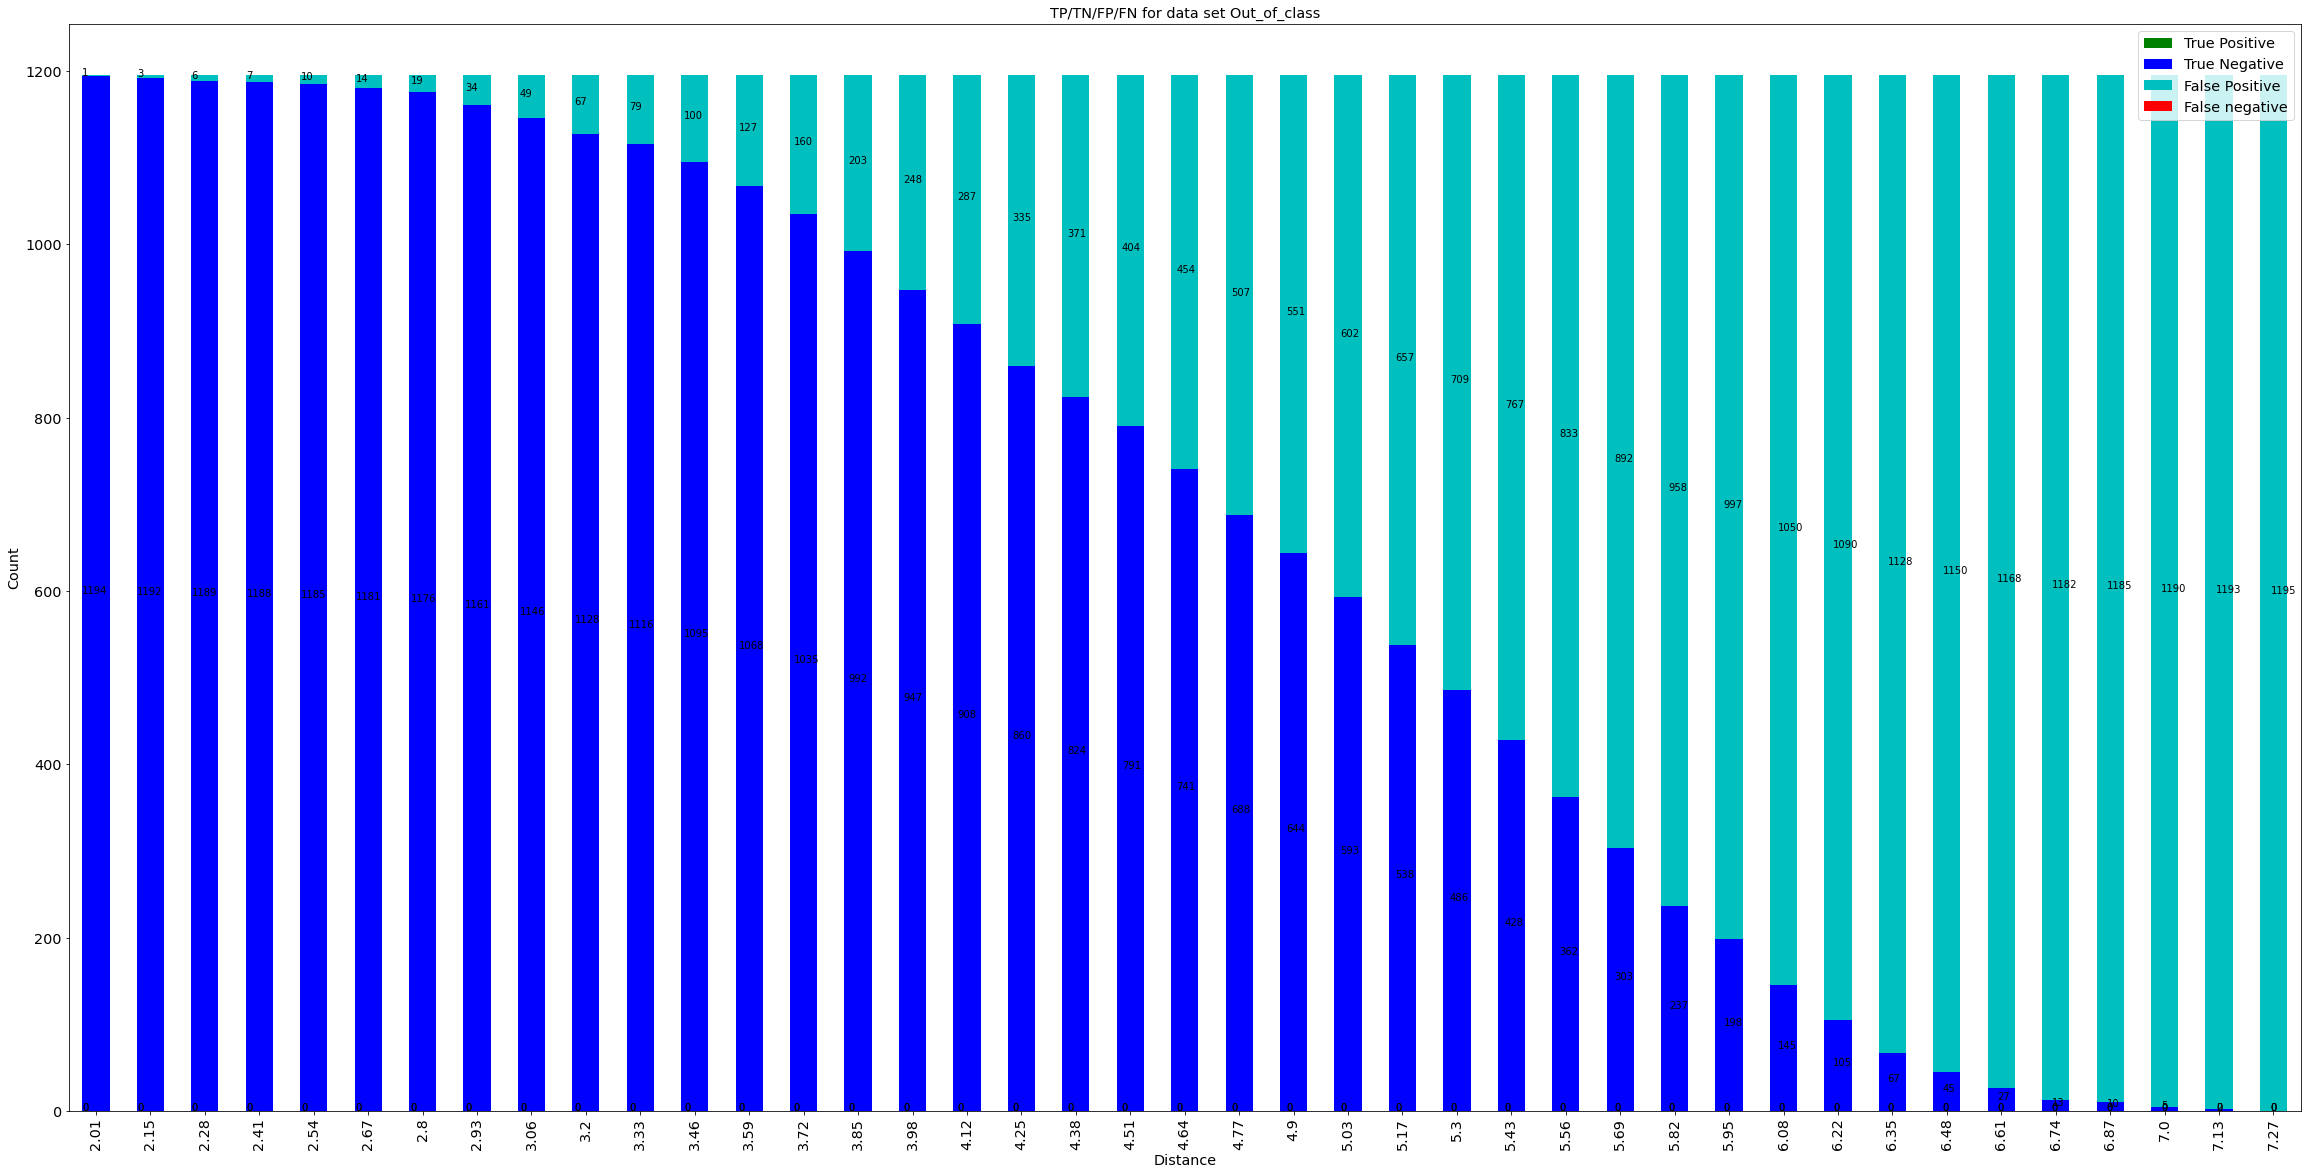

In [7]:
for data_set in data_sets:
    print(f"Name: {data_set}")
    data_plot = np.array([float(k.detach().numpy()) for z in data_sets[data_set]['labels'] for k in data_sets[data_set]['labels'][z]['distance']])
    truth_map = [z == k for z in data_sets[data_set]['labels'] for k in data_sets[data_set]['labels'][z]['pred']]

    counts, bins = draw_hist(data_plot, data_set.capitalize())
    bins_count_true_pos   = [0] * len(bins)
    bins_count_true_neg   = [0] * len(bins)
    bins_count_false_pos  = [0] * len(bins)
    bins_count_false_neg  = [0] * len(bins)
    
    for bin_id, bin_i in enumerate(bins):
        for label_truth_id, label_truth in enumerate(truth_map):

            if data_plot[label_truth_id] <= bin_i:       
                if label_truth:
                    bins_count_true_pos[bin_id]   += 1
                else:
                    bins_count_false_pos[bin_id]  += 1
            else:
                if label_truth:
                    bins_count_false_neg[bin_id]  += 1
                else:
                    bins_count_true_neg[bin_id]   += 1
    
    plotdata = pd.DataFrame({
        "True Positive" : bins_count_true_pos,
        "True Negative" : bins_count_true_neg,
        "False Positive": bins_count_false_pos,
        "False negative": bins_count_false_neg},
        index=[round(bin, 2) for bin in bins])
    
    ax = plotdata.plot(kind='bar', stacked=True, color= ['g', 'b', 'c', 'r'])
    for sss, p in enumerate(ax.patches):
        bias = sss % 4
        ax.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_y() + p.get_height()/2 ))
    
    plt.title(f"TP/TN/FP/FN for data set {data_set.capitalize()}")
    plt.xlabel("Distance")
    plt.ylabel("Count")

## correlation matrix

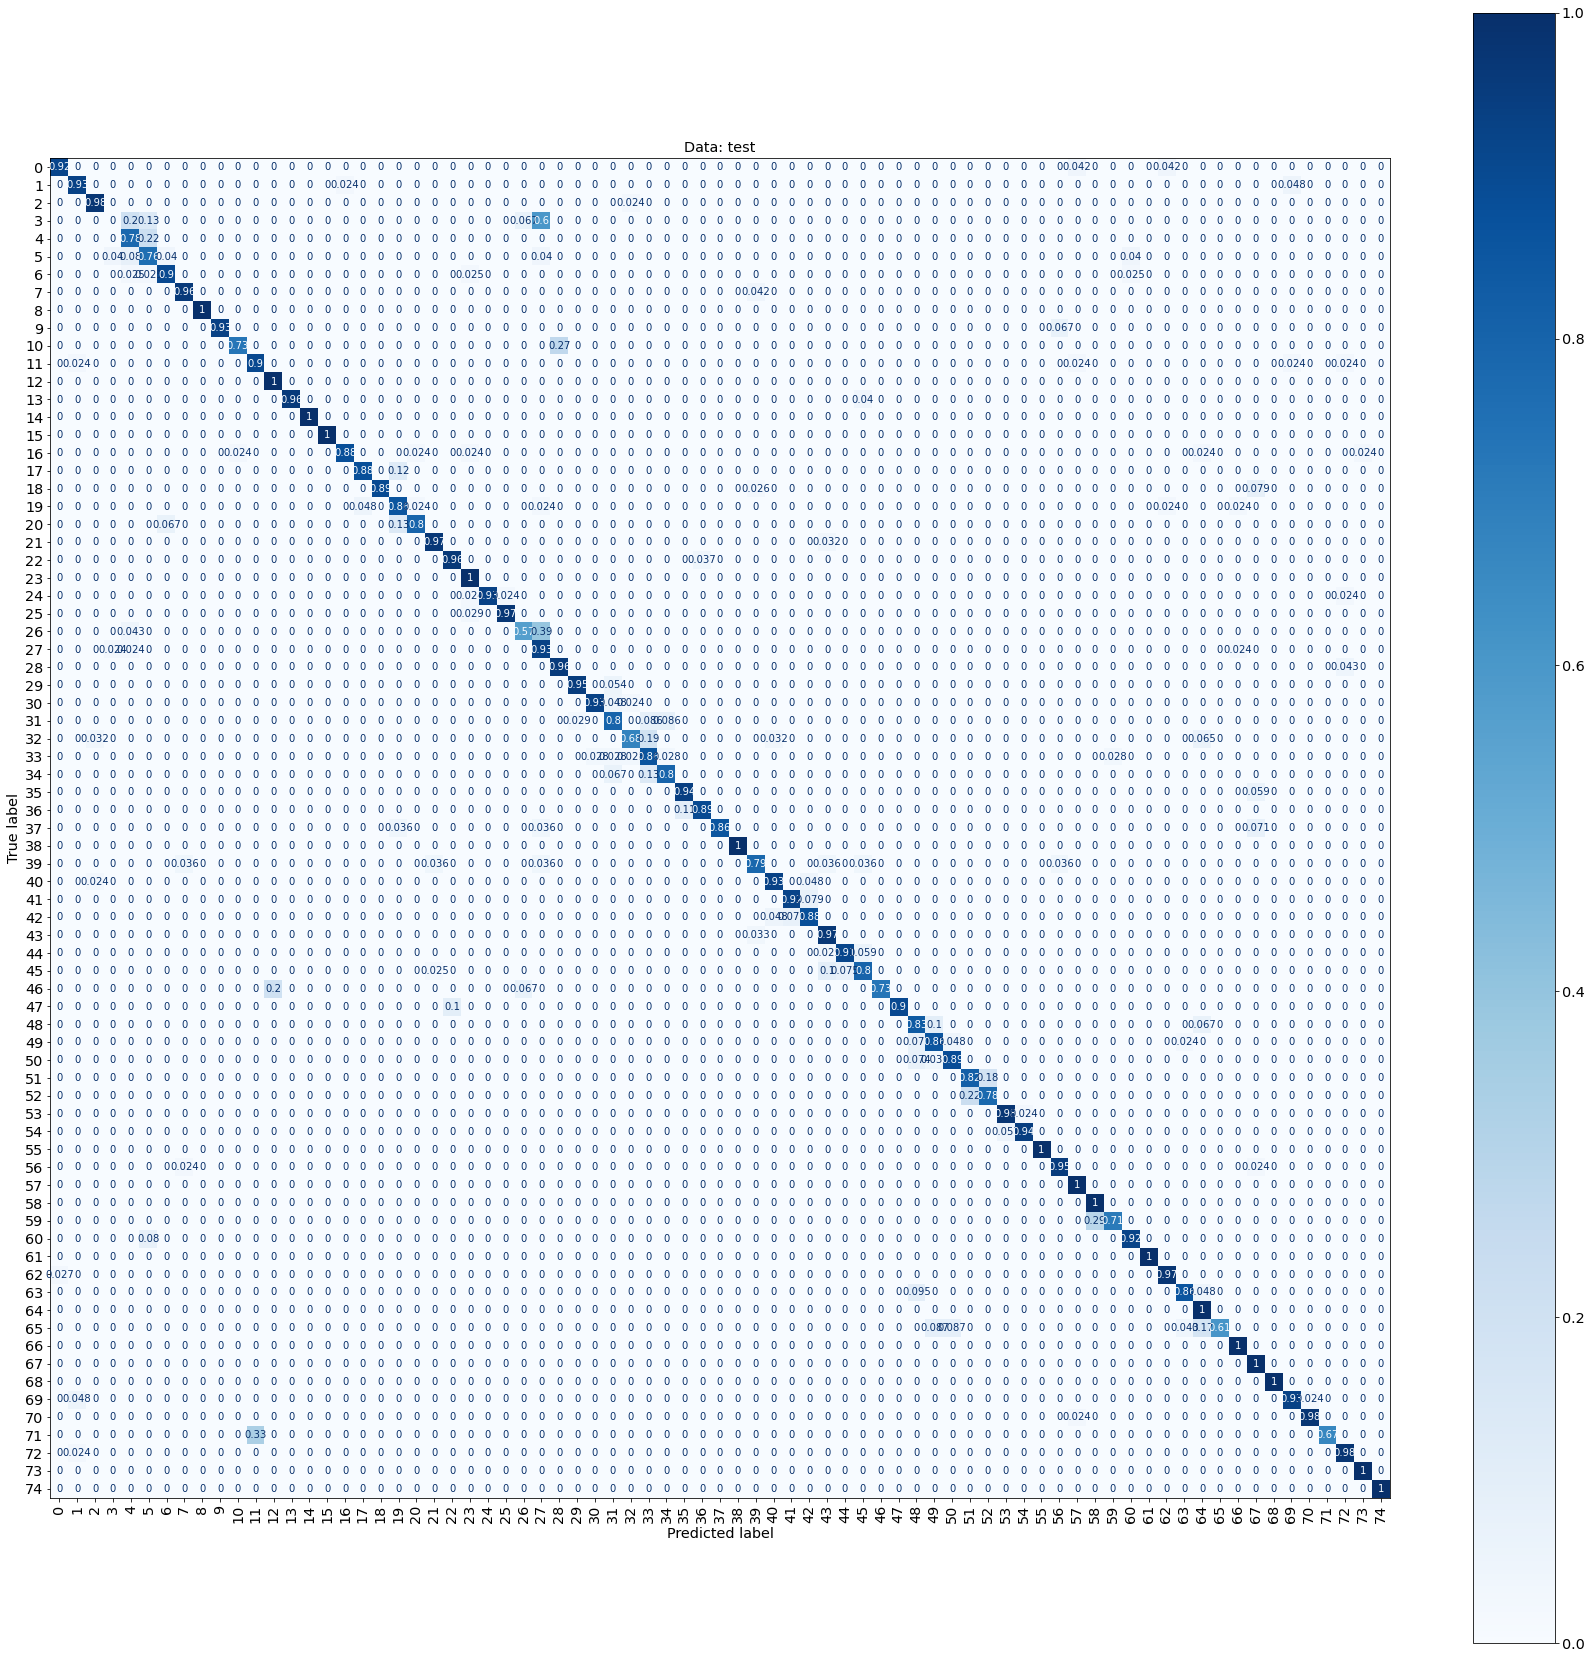

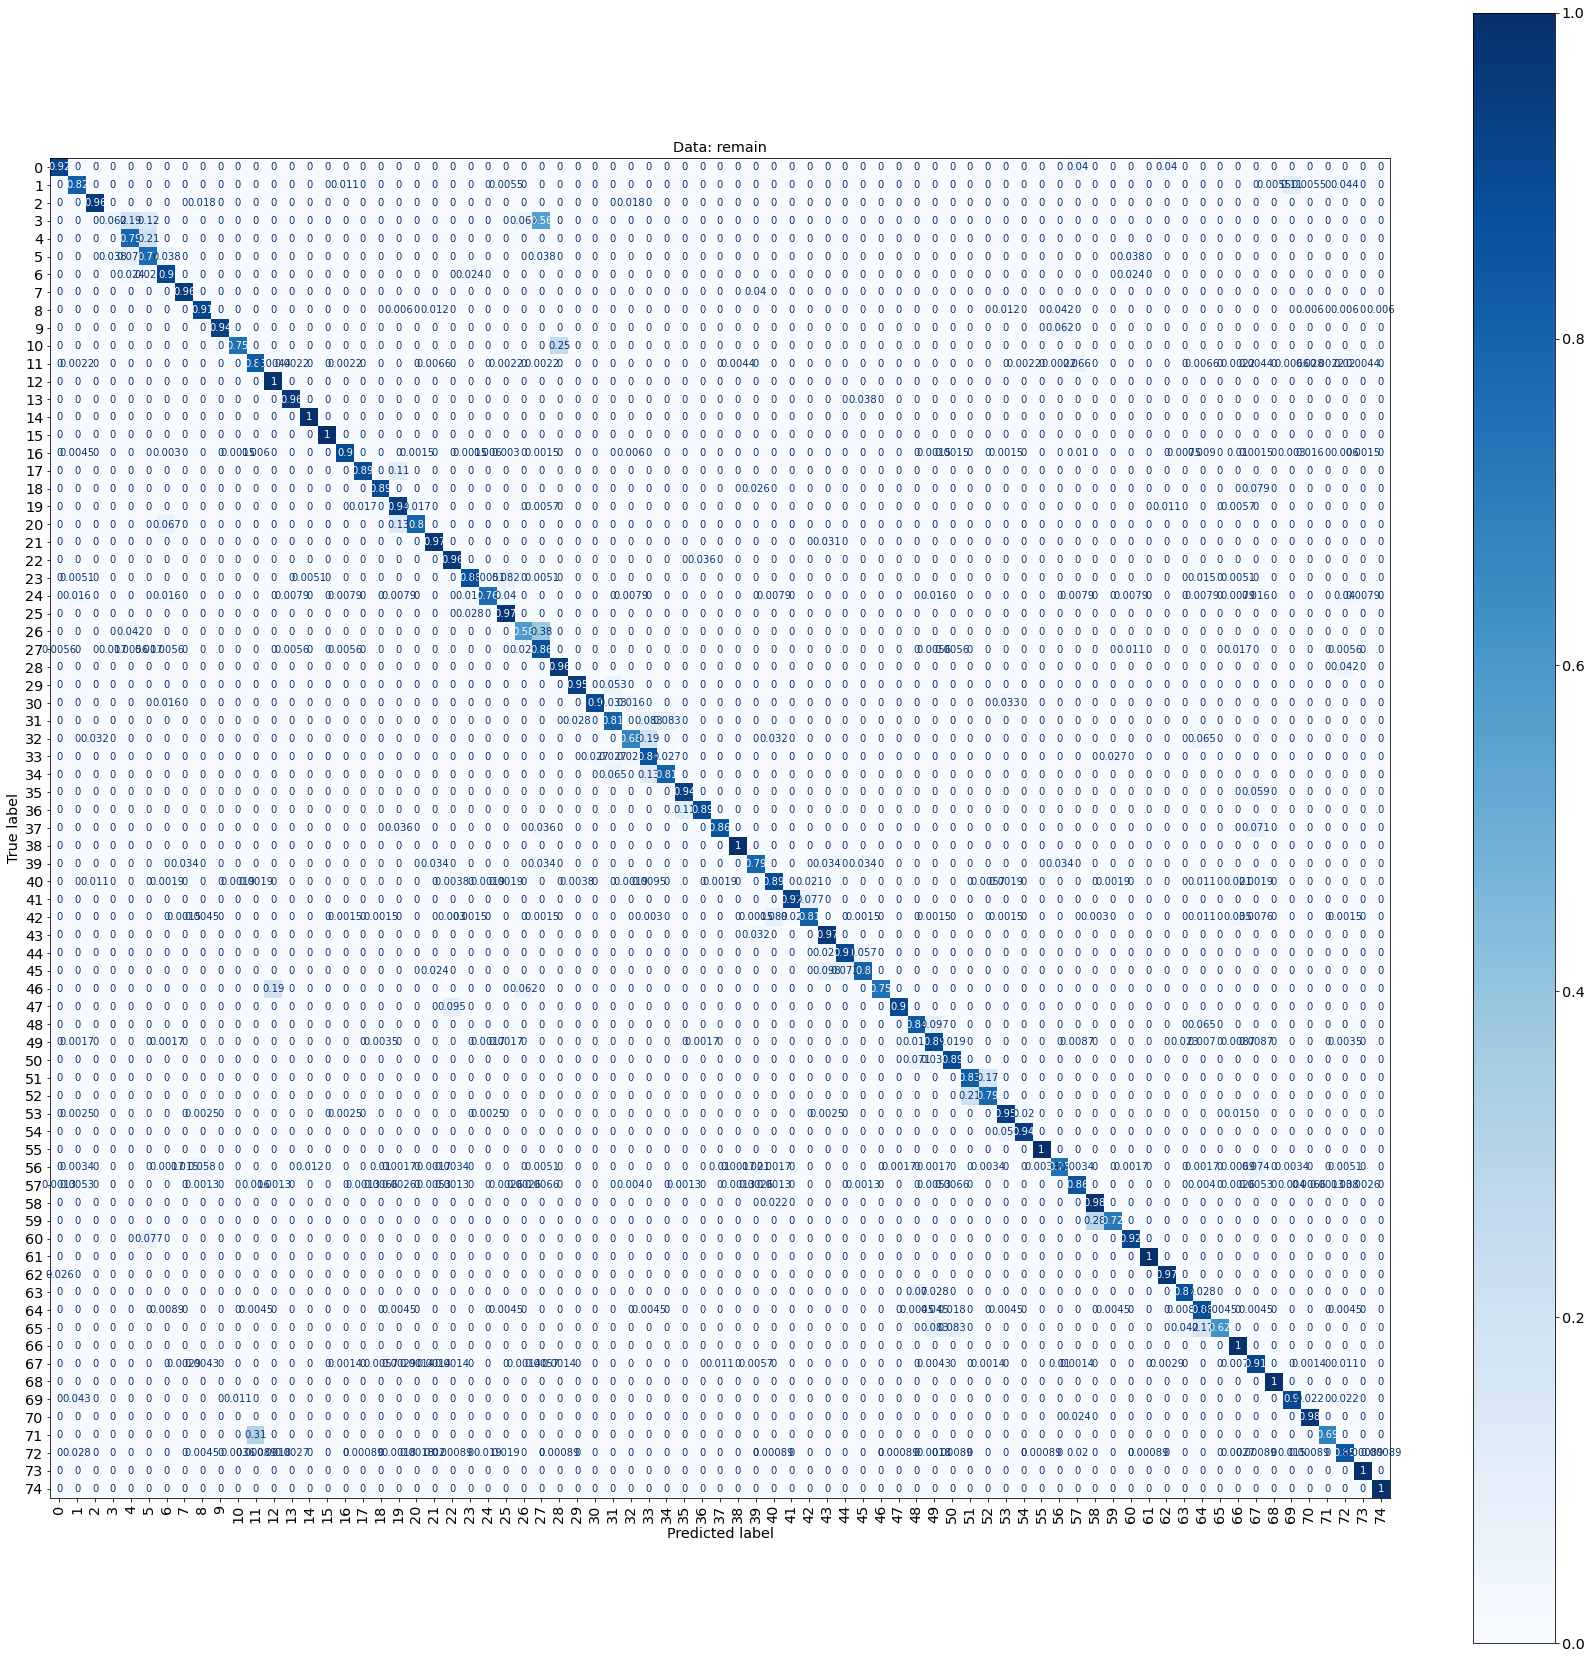

In [8]:
y_true = []
y_pred = []


for asd in ['test', 'remain']:
    for label in data_sets[asd]['labels']:
        if label == 'Other': continue

        y_true.extend([label] * len(data_sets[asd]['labels'][label]['pred']))
        y_pred.extend(data_sets[asd]['labels'][label]['pred'])

#     print(y_true)
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    fig, ax = plt.subplots(figsize=(30, 30))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp = disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=90)
    plt.title(f"Data: {asd}")
    plt.show()

In [9]:
print(classification_report(y_true, y_pred))

                             precision    recall  f1-score   support

              Abramis brama       0.88      0.92      0.90        25
     Acanthocybium solandri       0.74      0.82      0.78       181
      Ambloplites rupestris       0.88      0.96      0.92        55
             Ameiurus catus       0.20      0.06      0.10        16
             Ameiurus melas       0.70      0.79      0.75        24
         Ameiurus nebulosus       0.61      0.77      0.68        26
                 Amia calva       0.74      0.90      0.81        41
      Aplodinotus grunniens       0.65      0.96      0.77        25
Archosargus probatocephalus       0.76      0.91      0.83       167
         Balistes capriscus       1.00      0.94      0.97        16
              Belone belone       0.63      0.75      0.69        16
              Caranx hippos       0.94      0.83      0.88       458
      Carcharhinus limbatus       0.67      1.00      0.80        16
    Centropomus undecimalis      

In [10]:
list_numbers = random.choices([100,100], k=200) 
random_numbers = torch.Tensor(list_numbers)

main_folder = '../../output/train_results/resnet_18_200'
data_distance_disturb = {}
set_names = ['data_train.json_embedding.pt', 'data_test.json_embedding.pt', 'data_remain.json_embedding.pt']
for i in zip(
    set_names,
    ['data_train.json_labels.json', 'data_test.json_labels.json', 'data_remain.json_labels.json']):
    
    data_base = torch.load(os.path.join(main_folder, i[0])).to('cpu')
    data_labels_by_data = read_json(os.path.join(main_folder, i[1]))
    
    data_distance_disturb.update({
        i[0]: {
            'labels': {
            data_labels[label]: {       
            'distance': [] 
    } for label in data_labels}}})
    
    for label_id in range(len(data_base)):
        print(f"Current: {label_id} | {i[0]}", end = '\r')
        for first_id, first_vec in enumerate(data_base[label_id]):
            for second_id, second_vec in enumerate(data_base[label_id]):
                if first_vec.sum() > 1000 or second_vec.sum() > 1000: continue
                diff = (first_vec - second_vec).pow(2).sum().sqrt()
                if diff == 0: continue
                data_distance_disturb[i[0]]['labels'][data_labels_by_data[str(label_id)]]['distance'].append(diff)
    

Train: 8190 Test: 506 Remain: 0


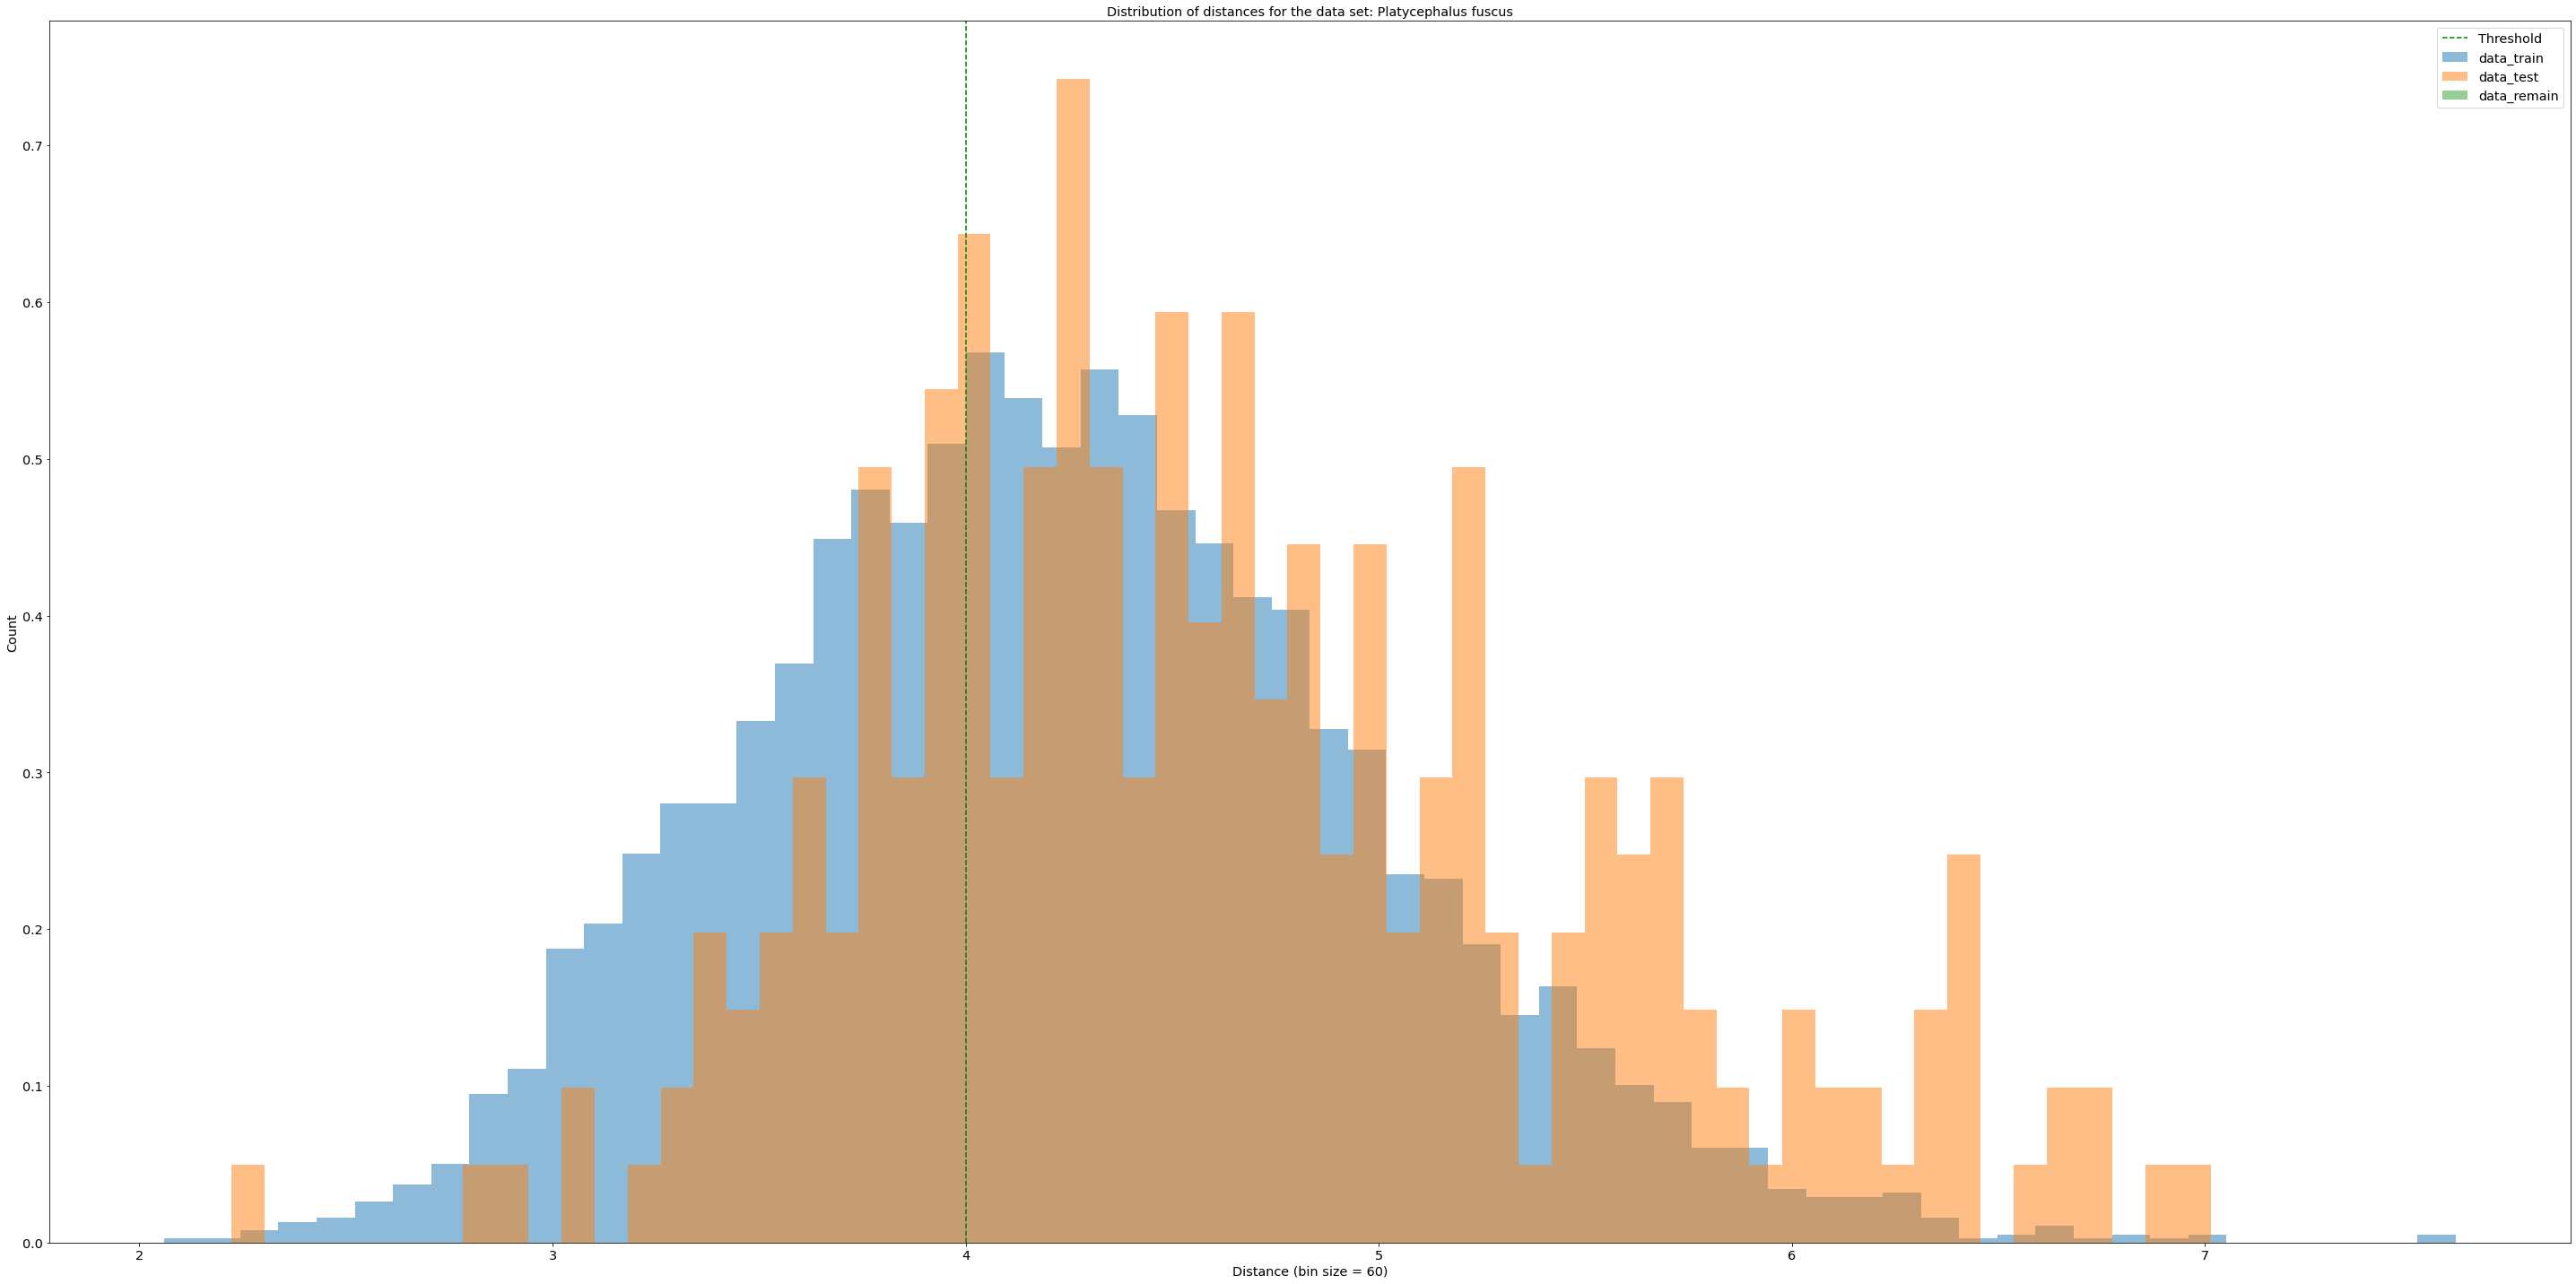

Train: 8010 Test: 462 Remain: 0


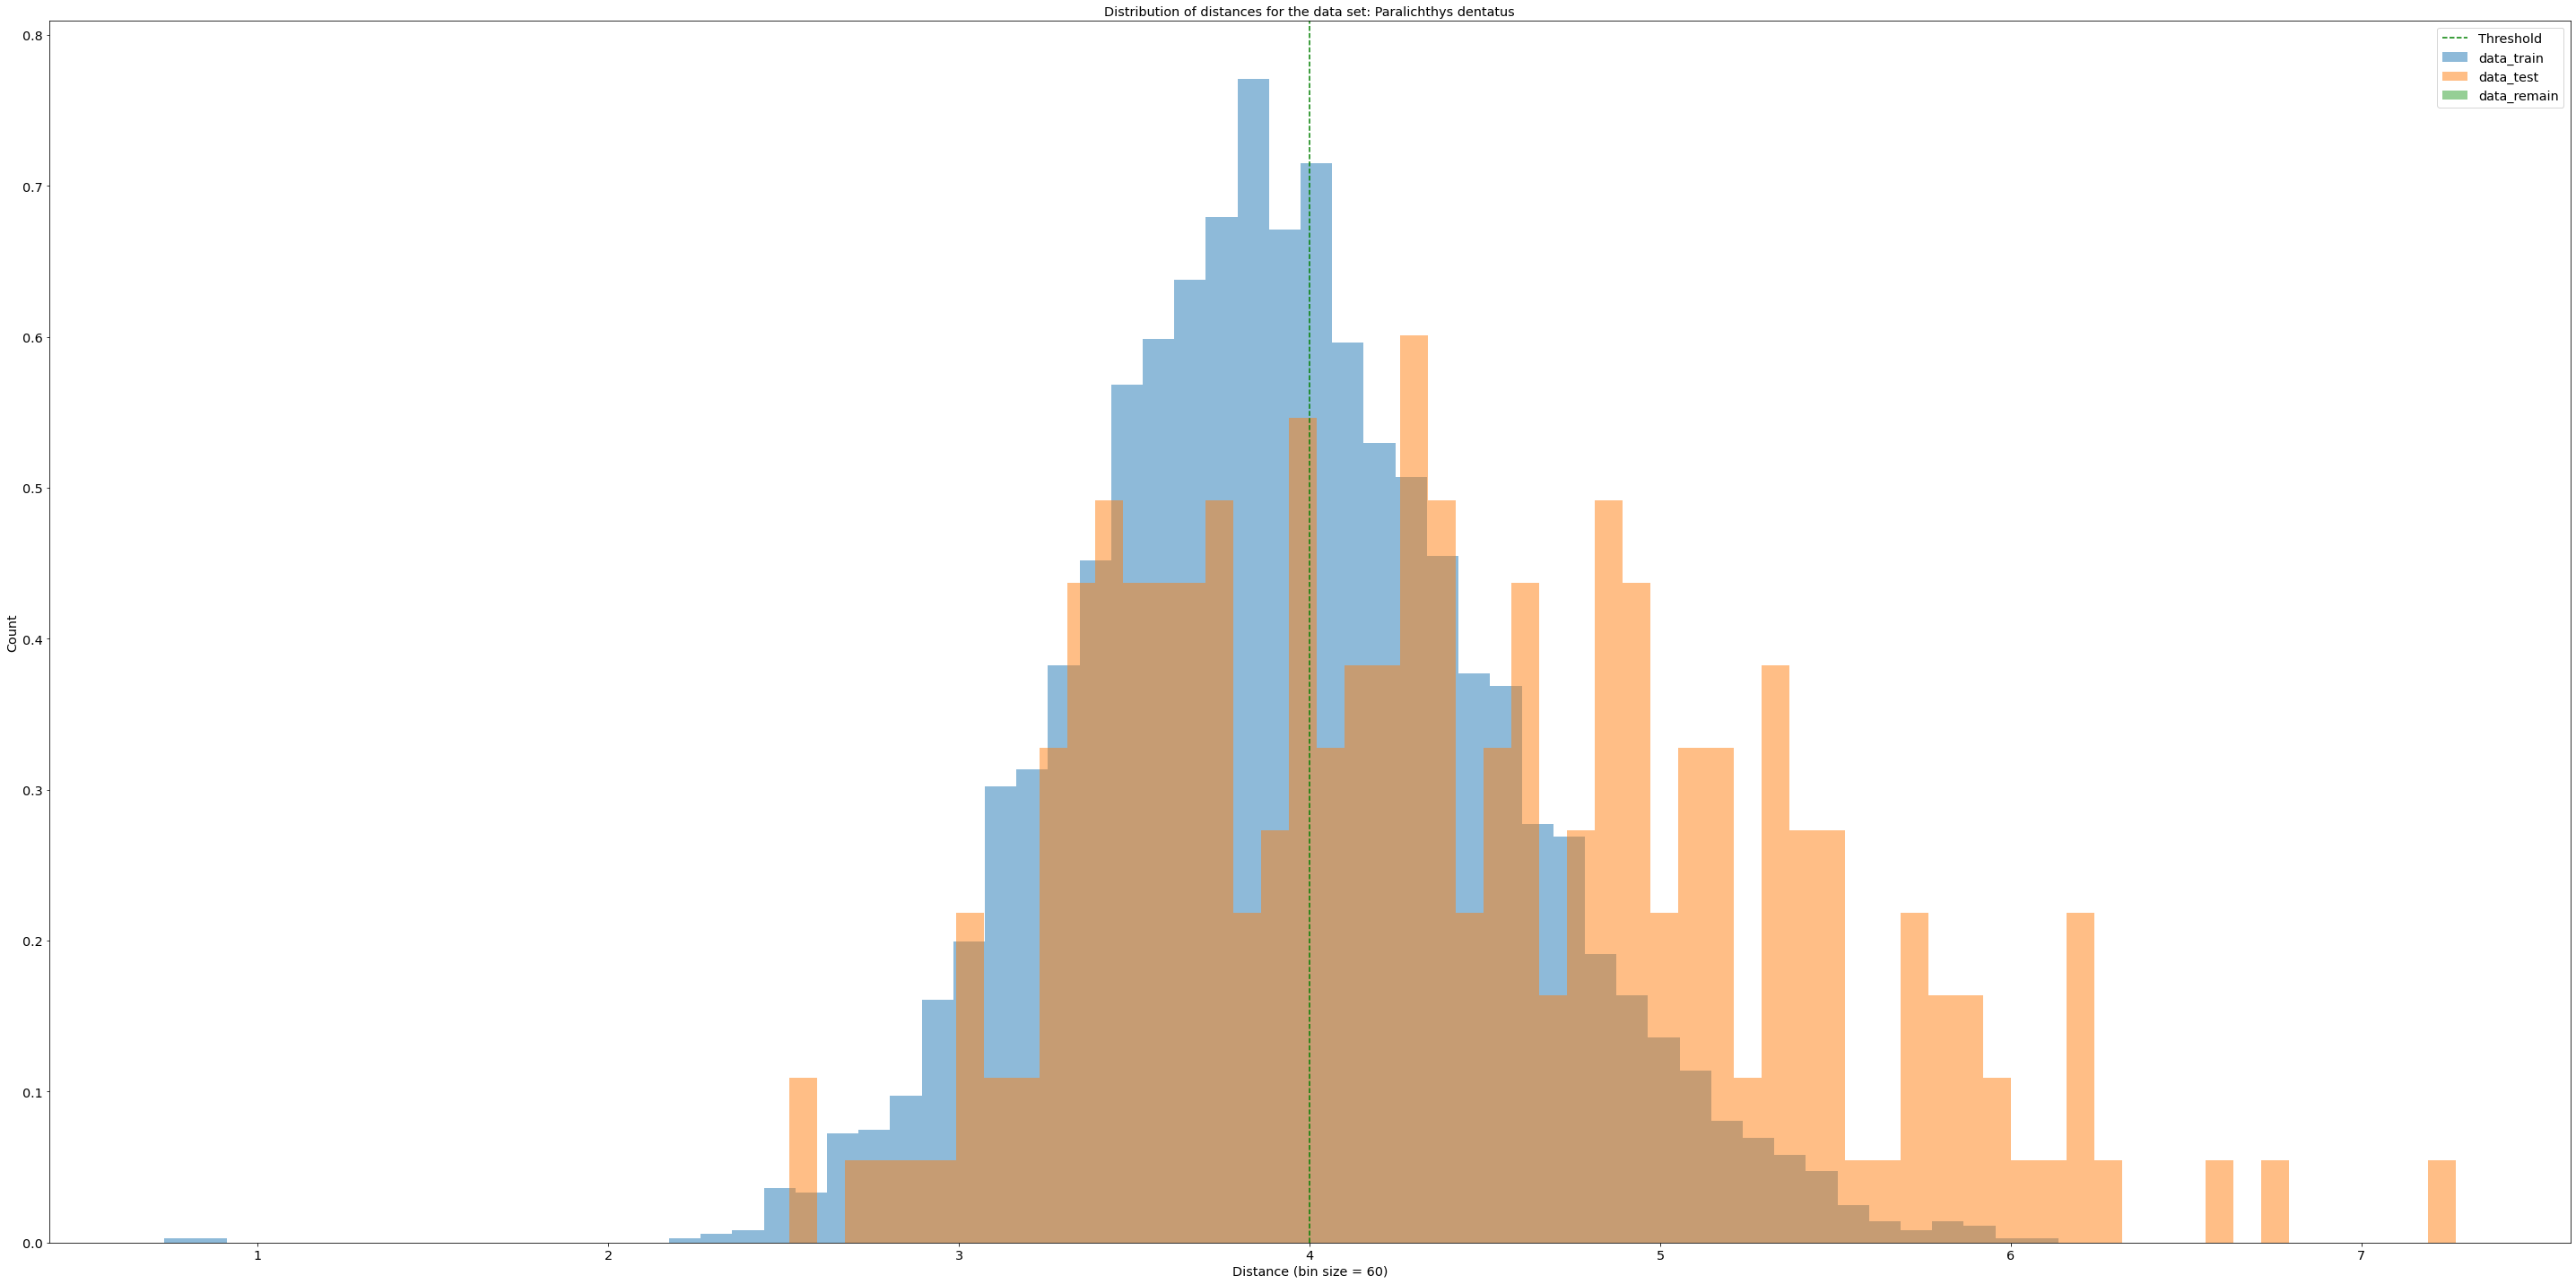

Train: 12432 Test: 756 Remain: 0


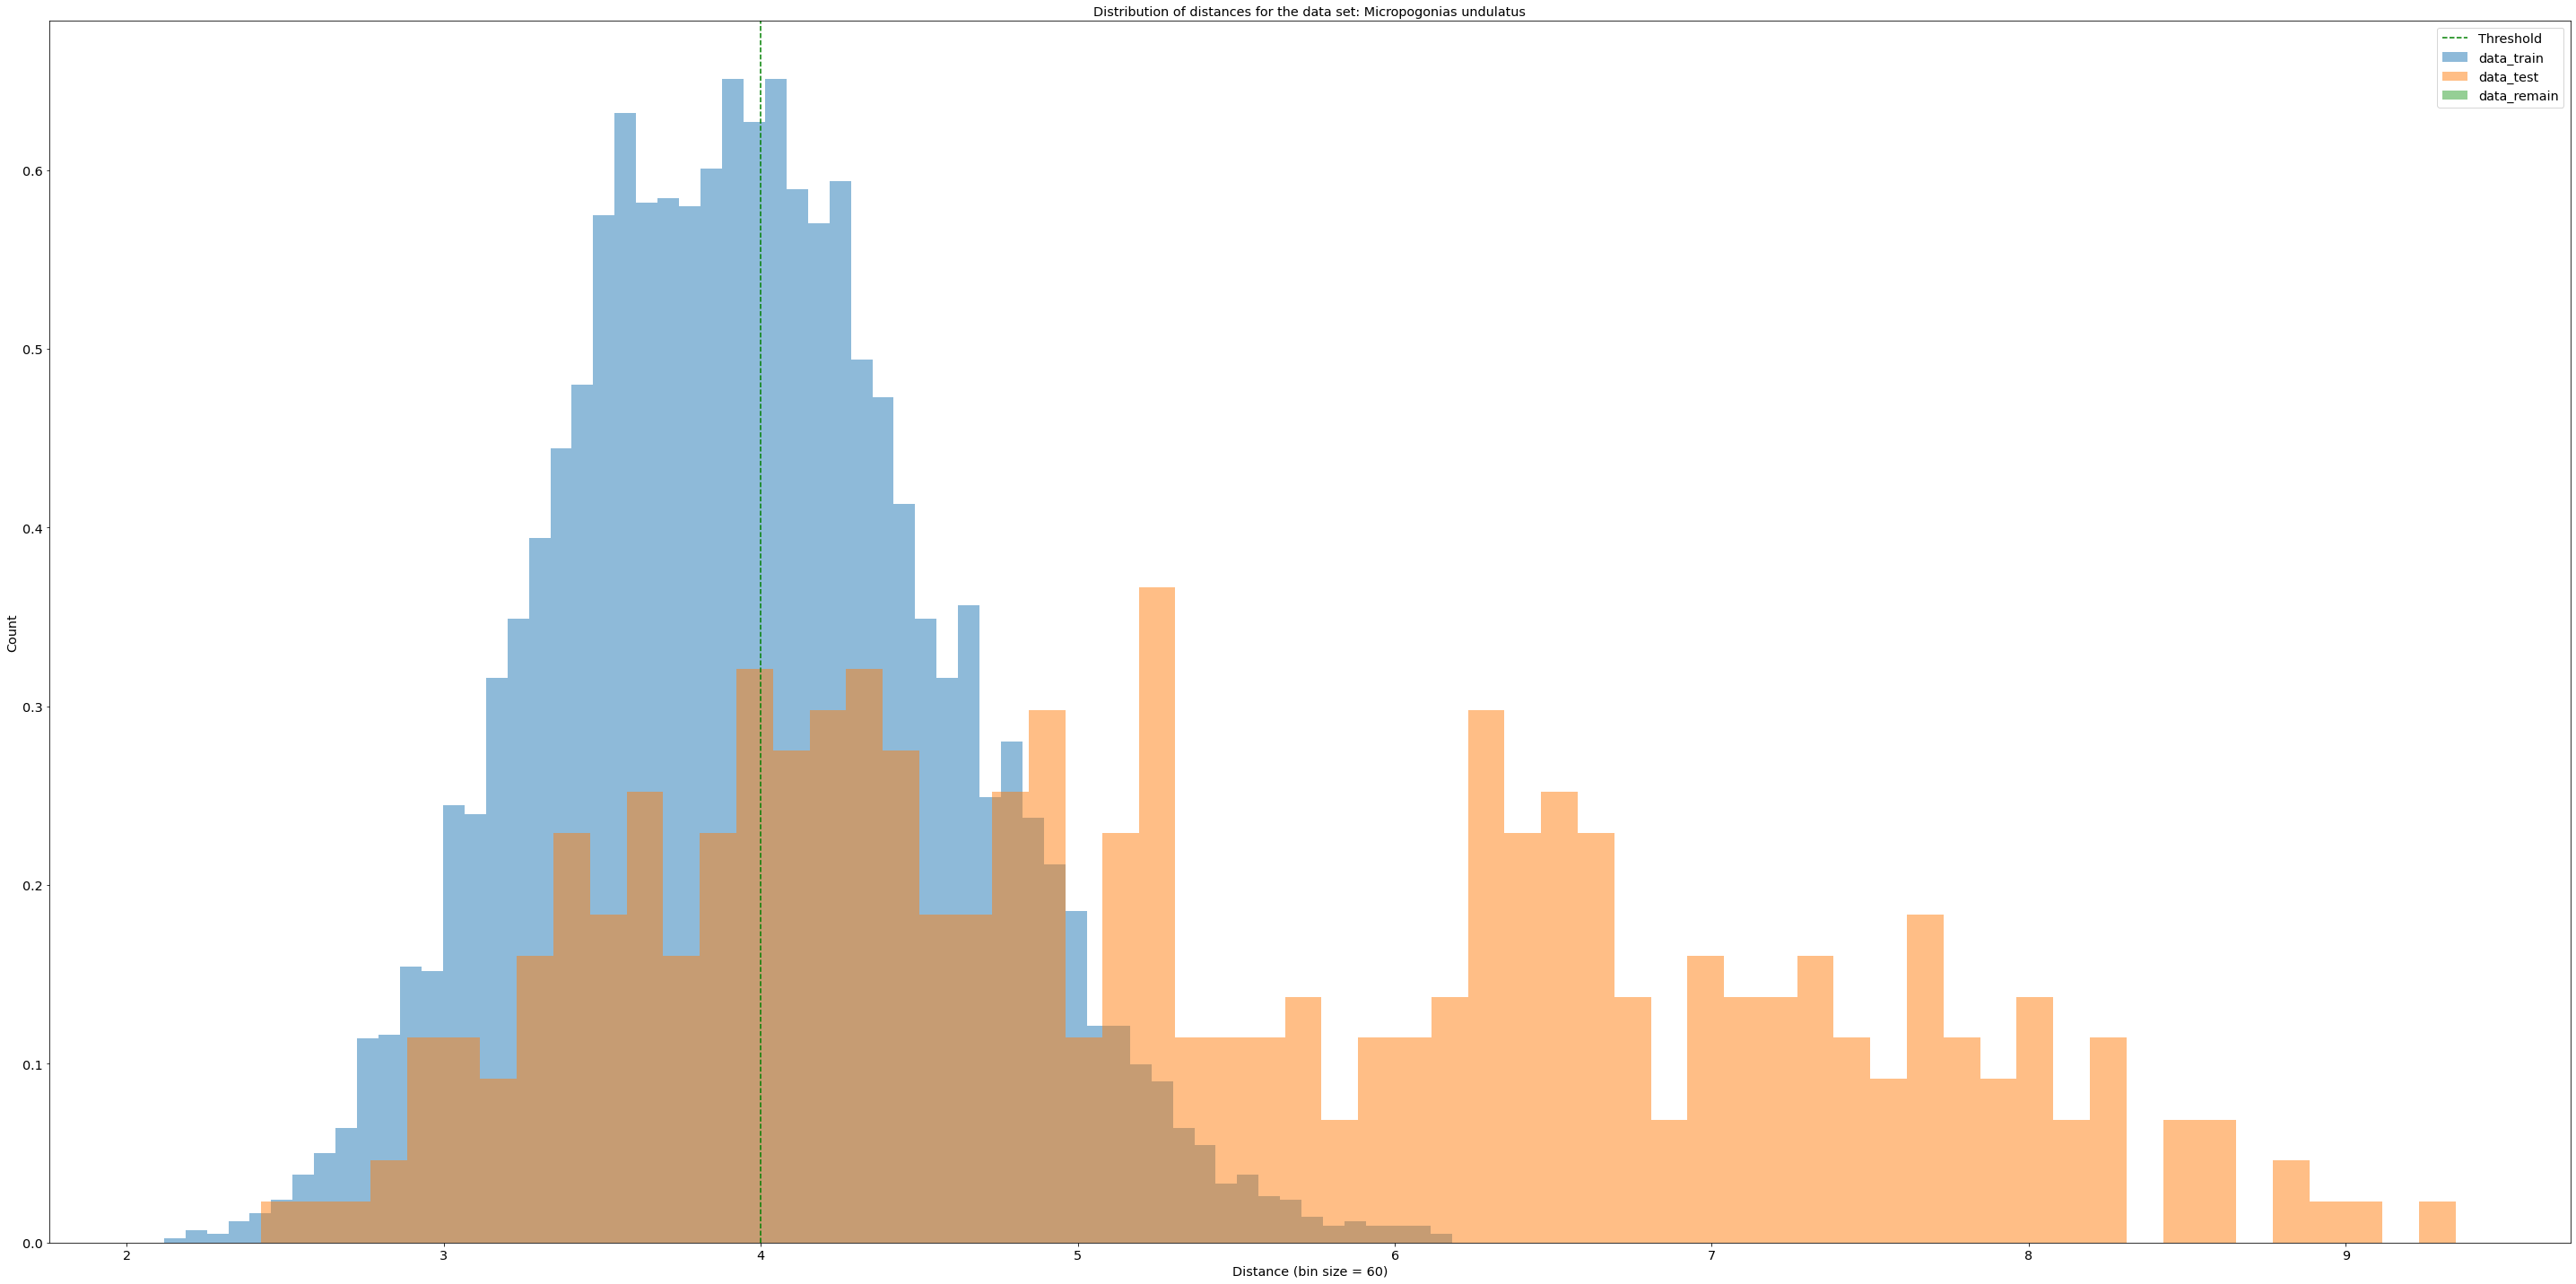

Train: 9312 Test: 552 Remain: 0


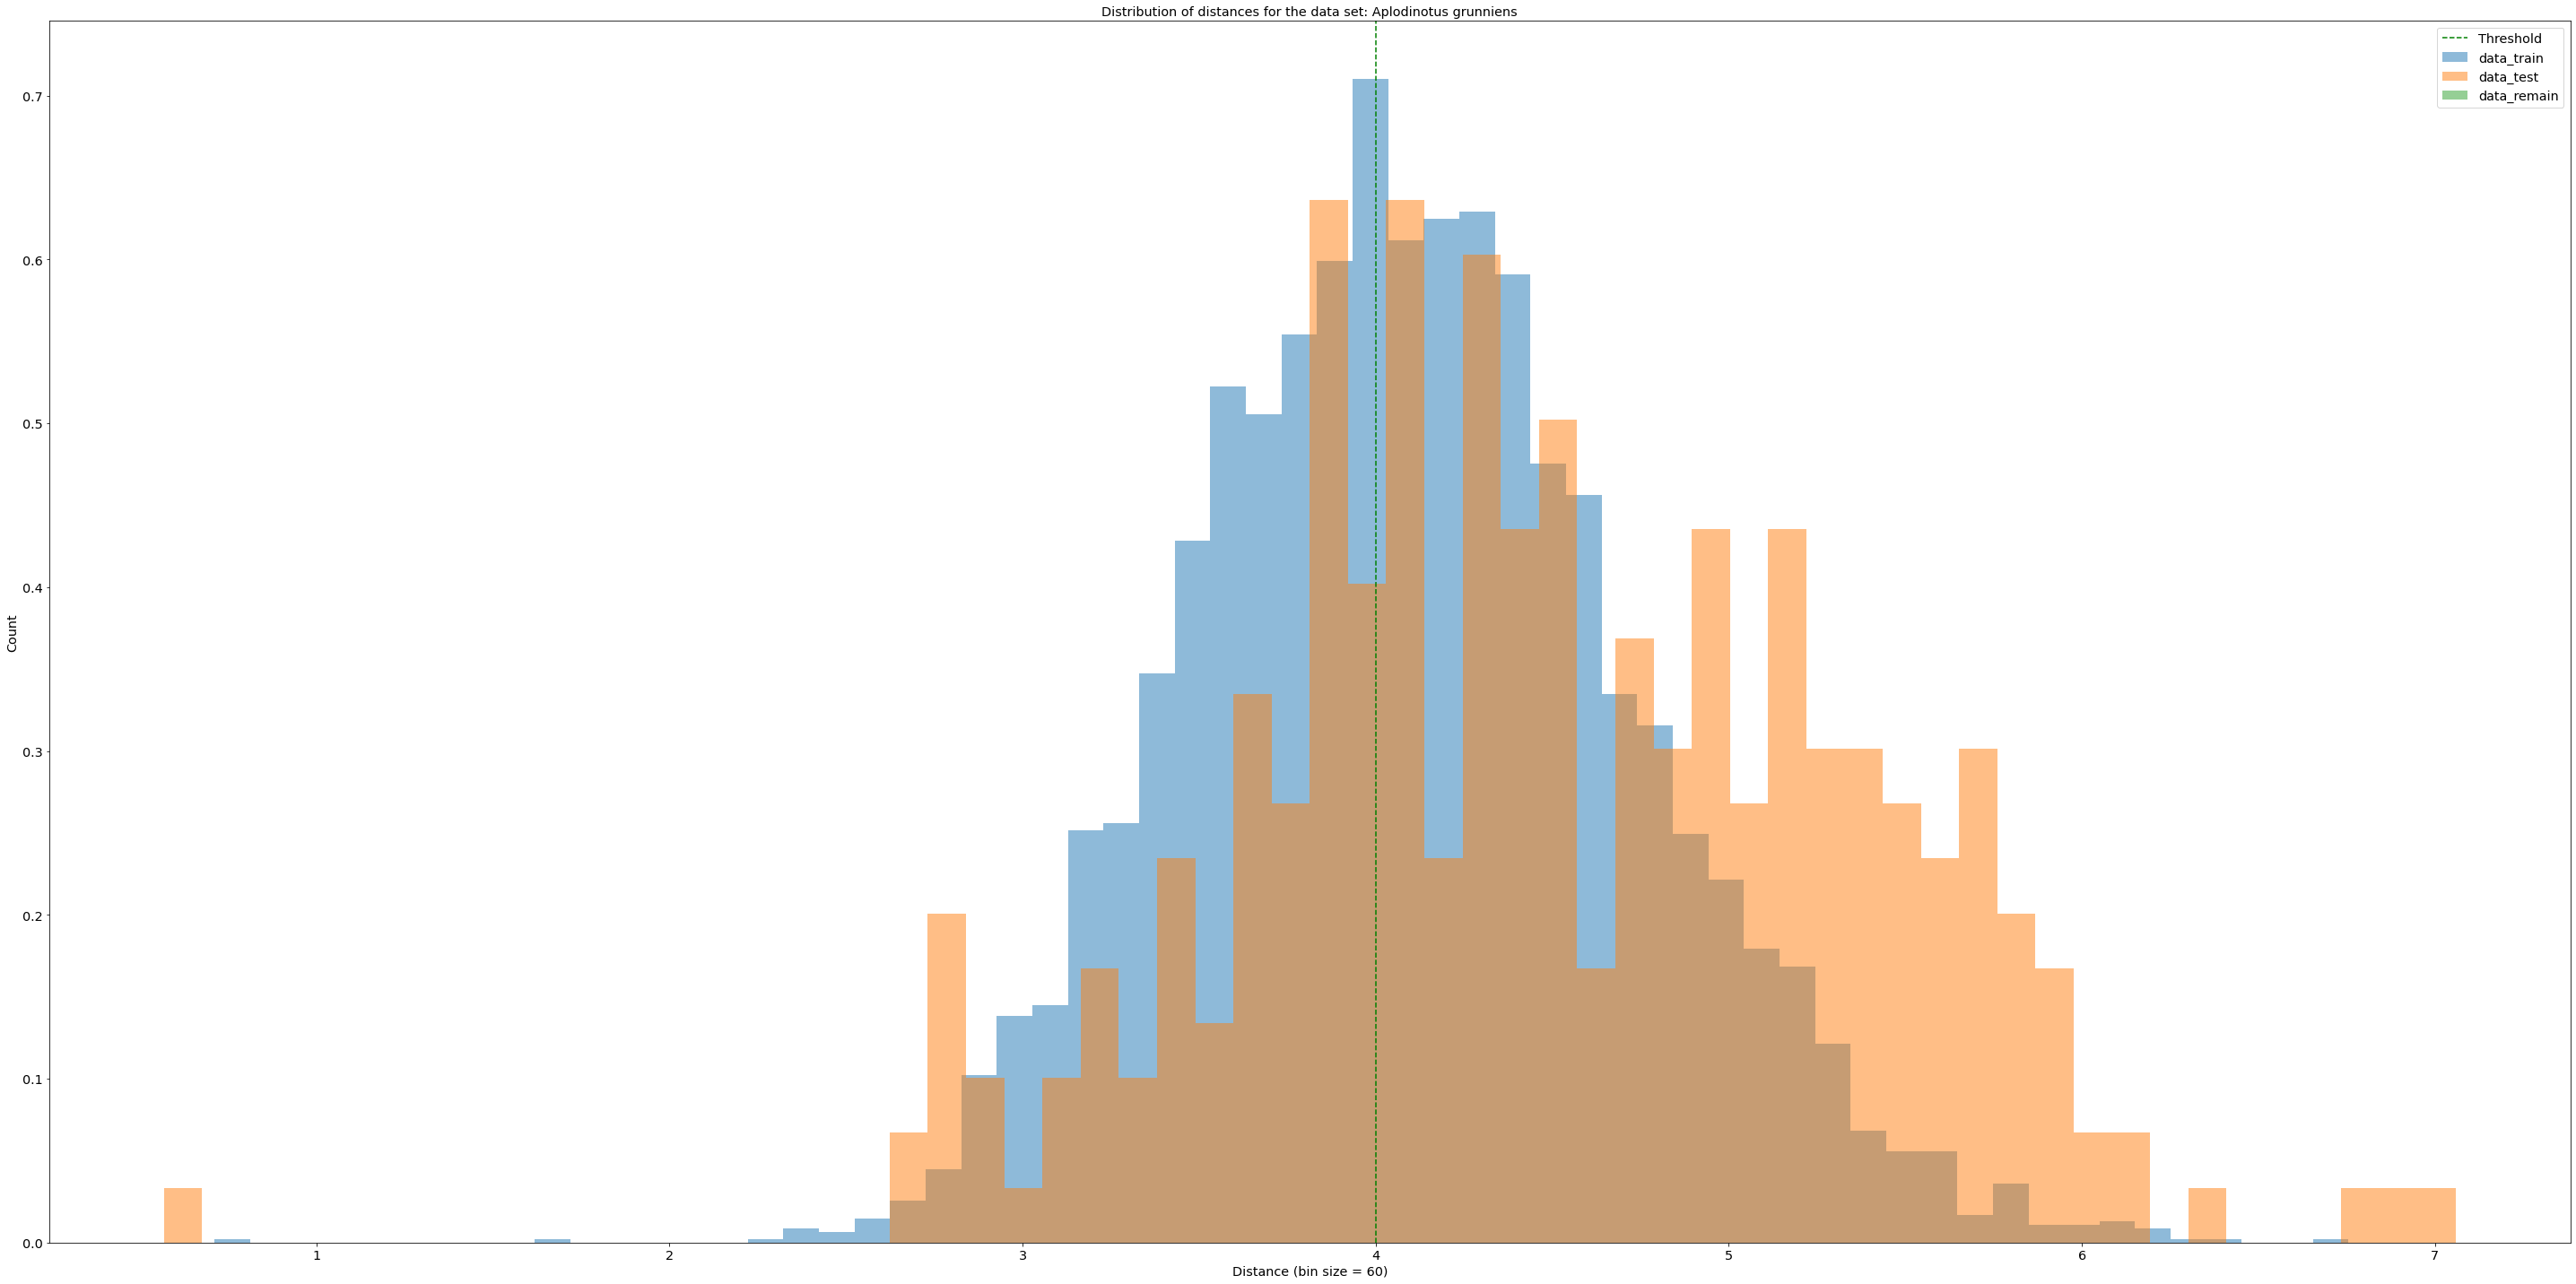

Train: 10302 Test: 600 Remain: 0


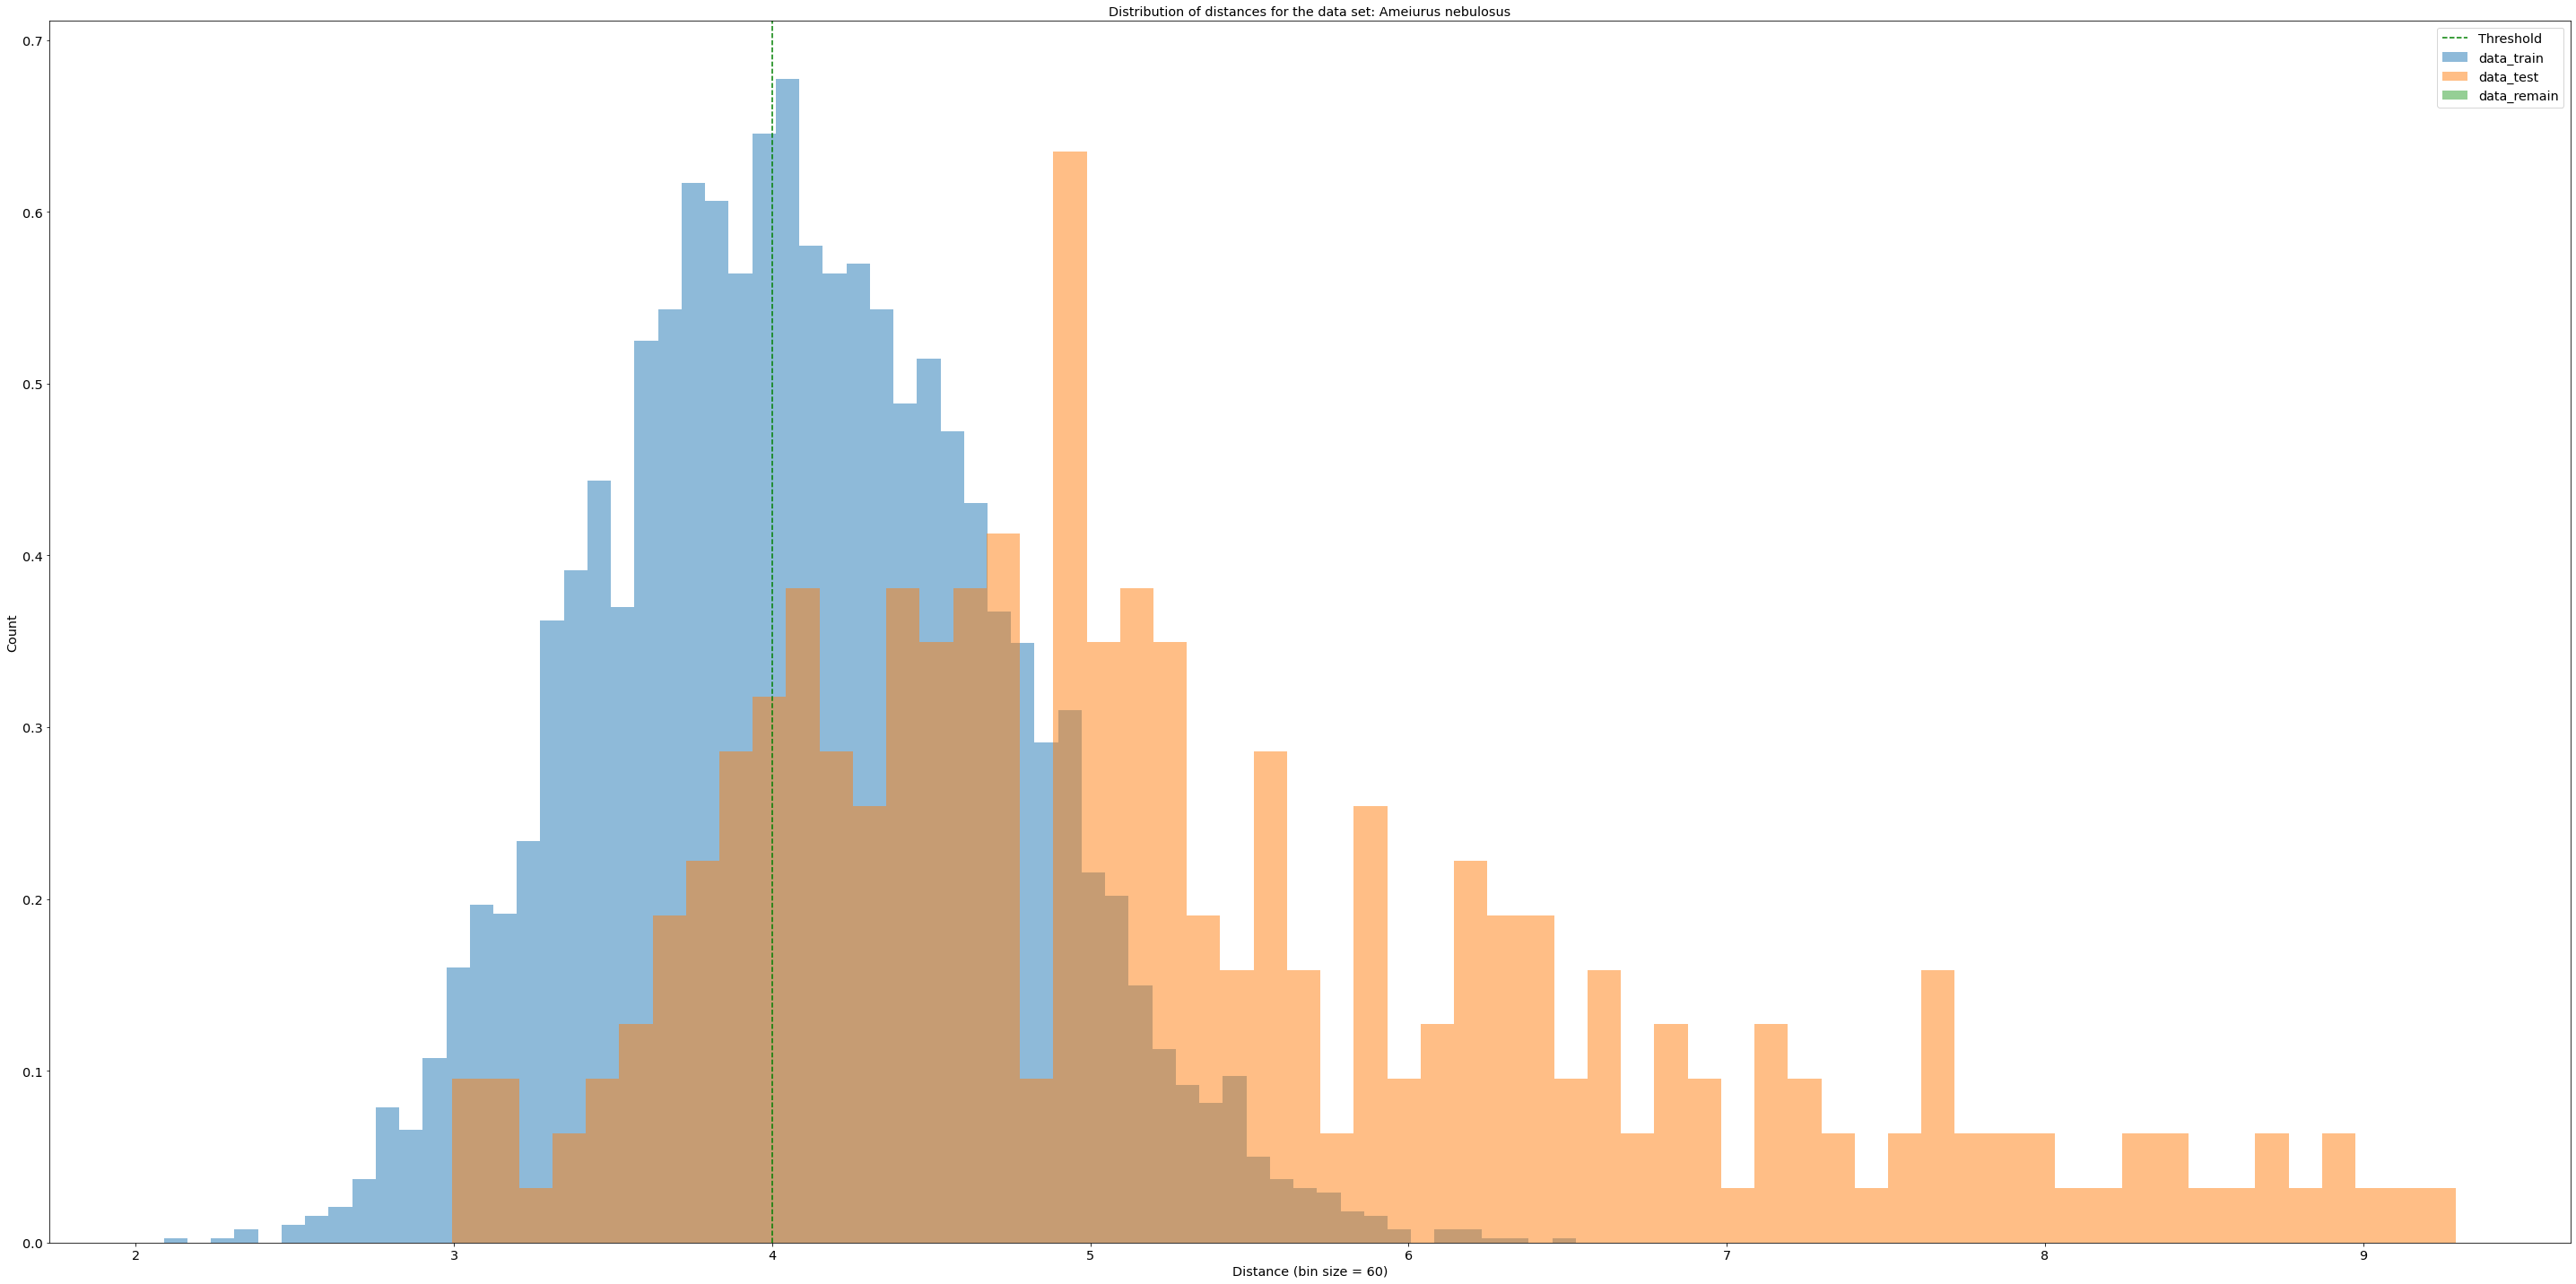

Train: 420 Test: 210 Remain: 0


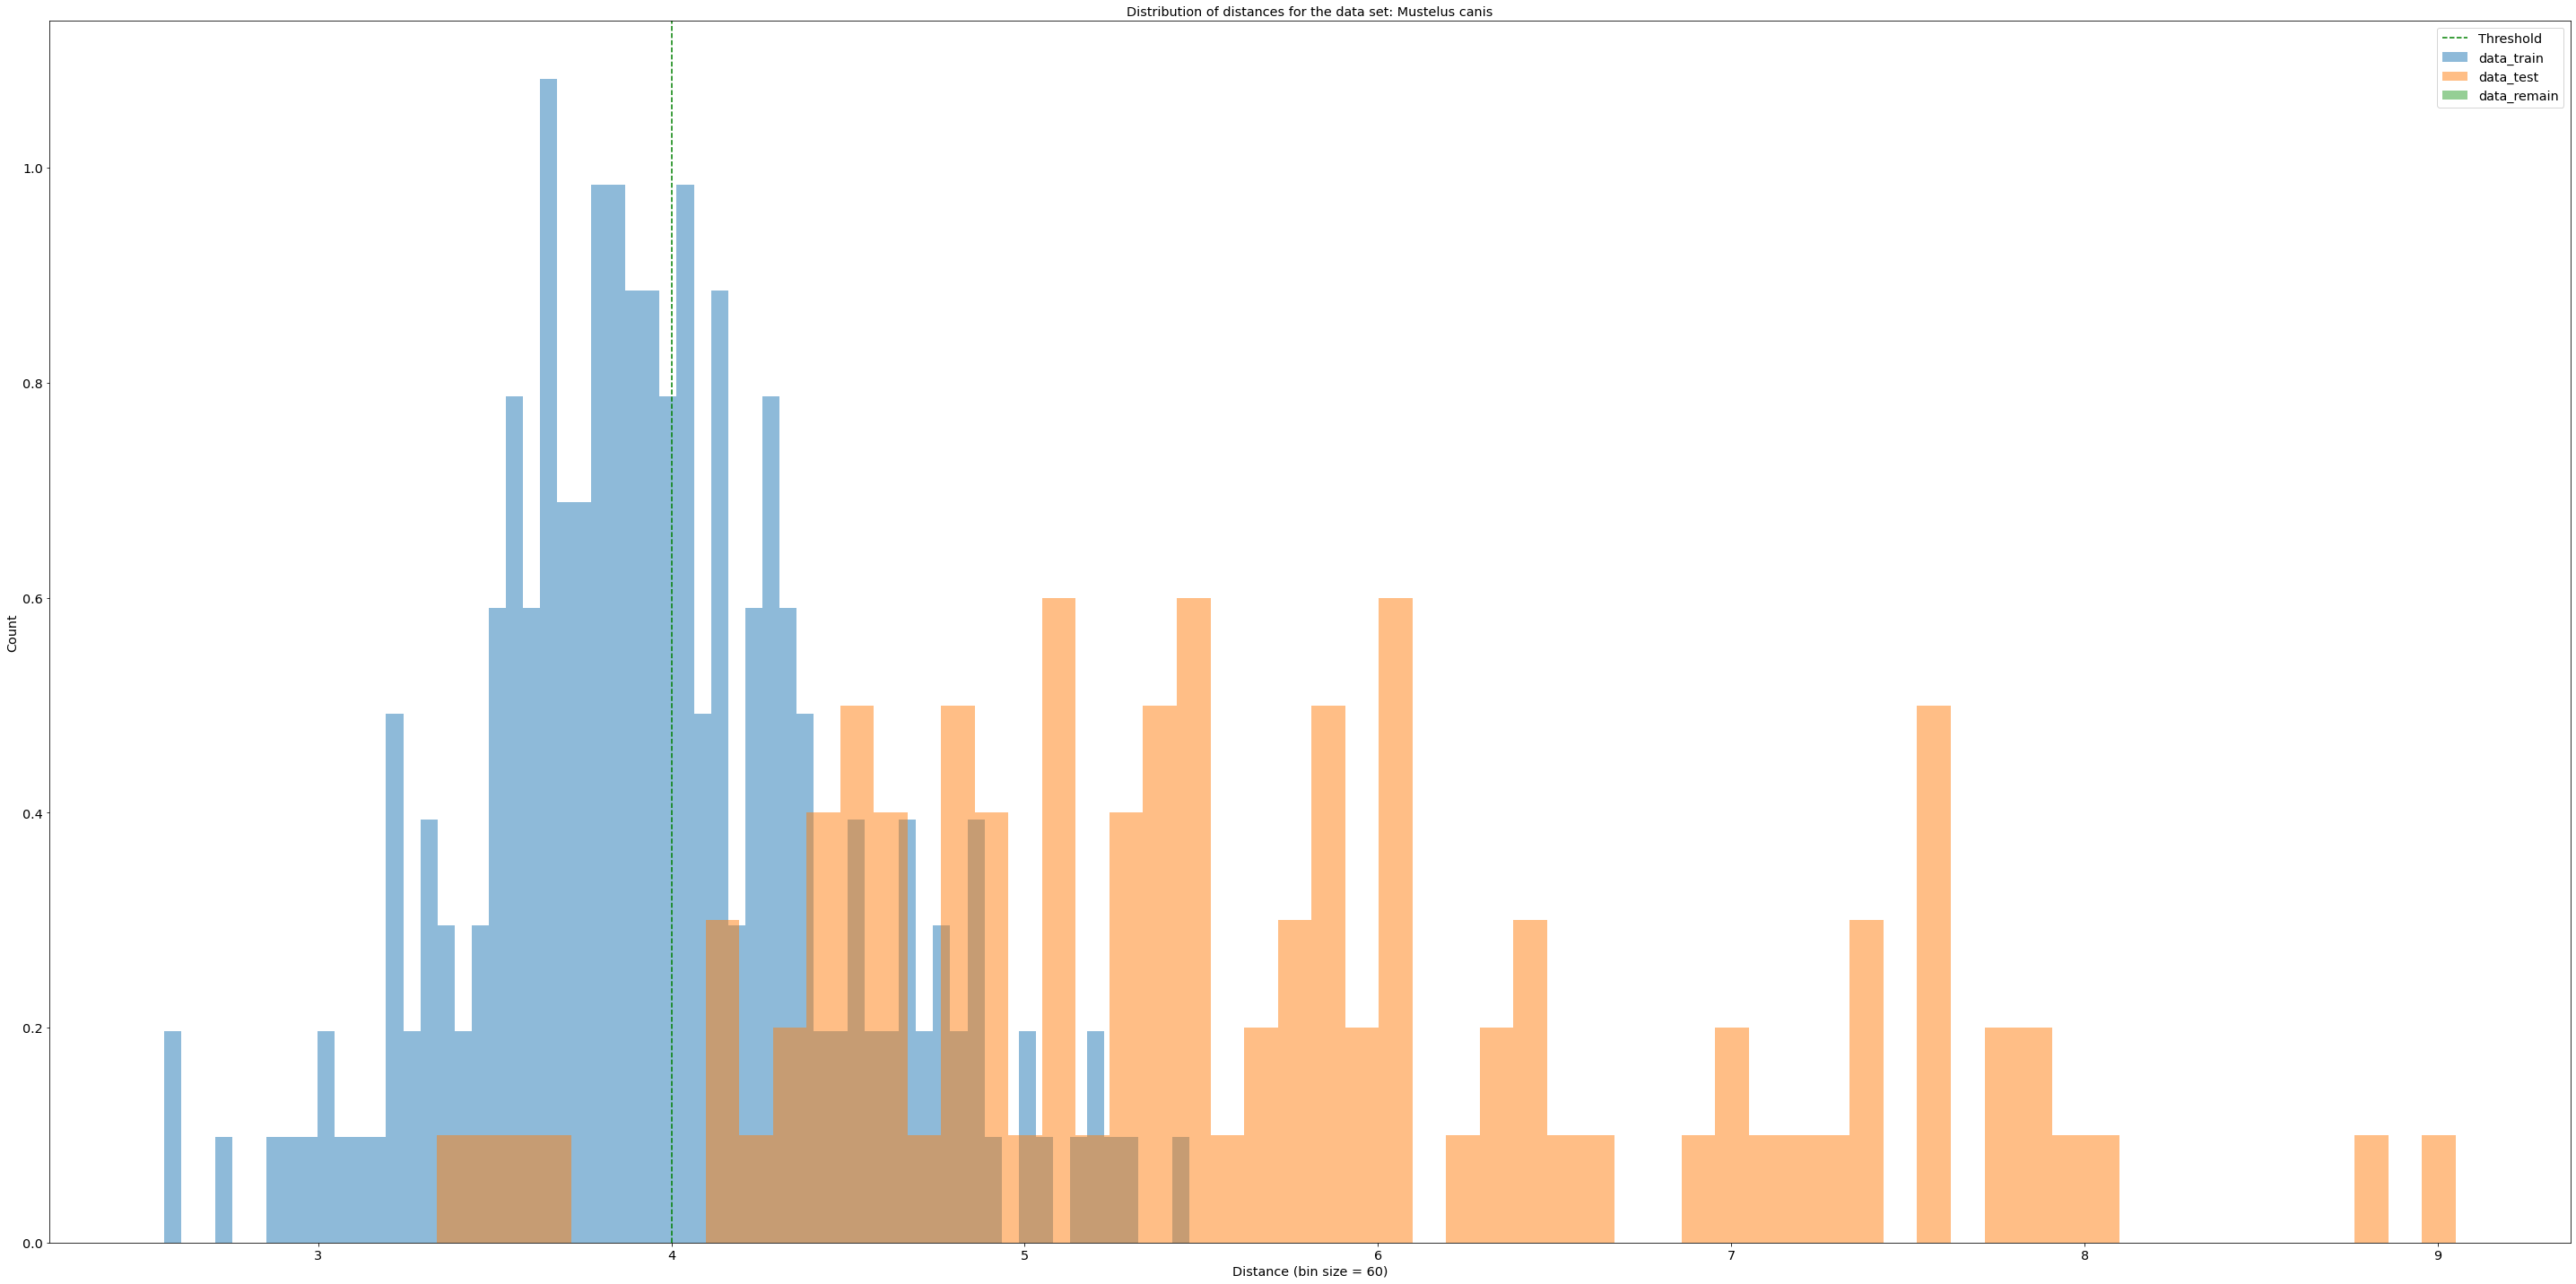

Train: 1122 Test: 210 Remain: 0


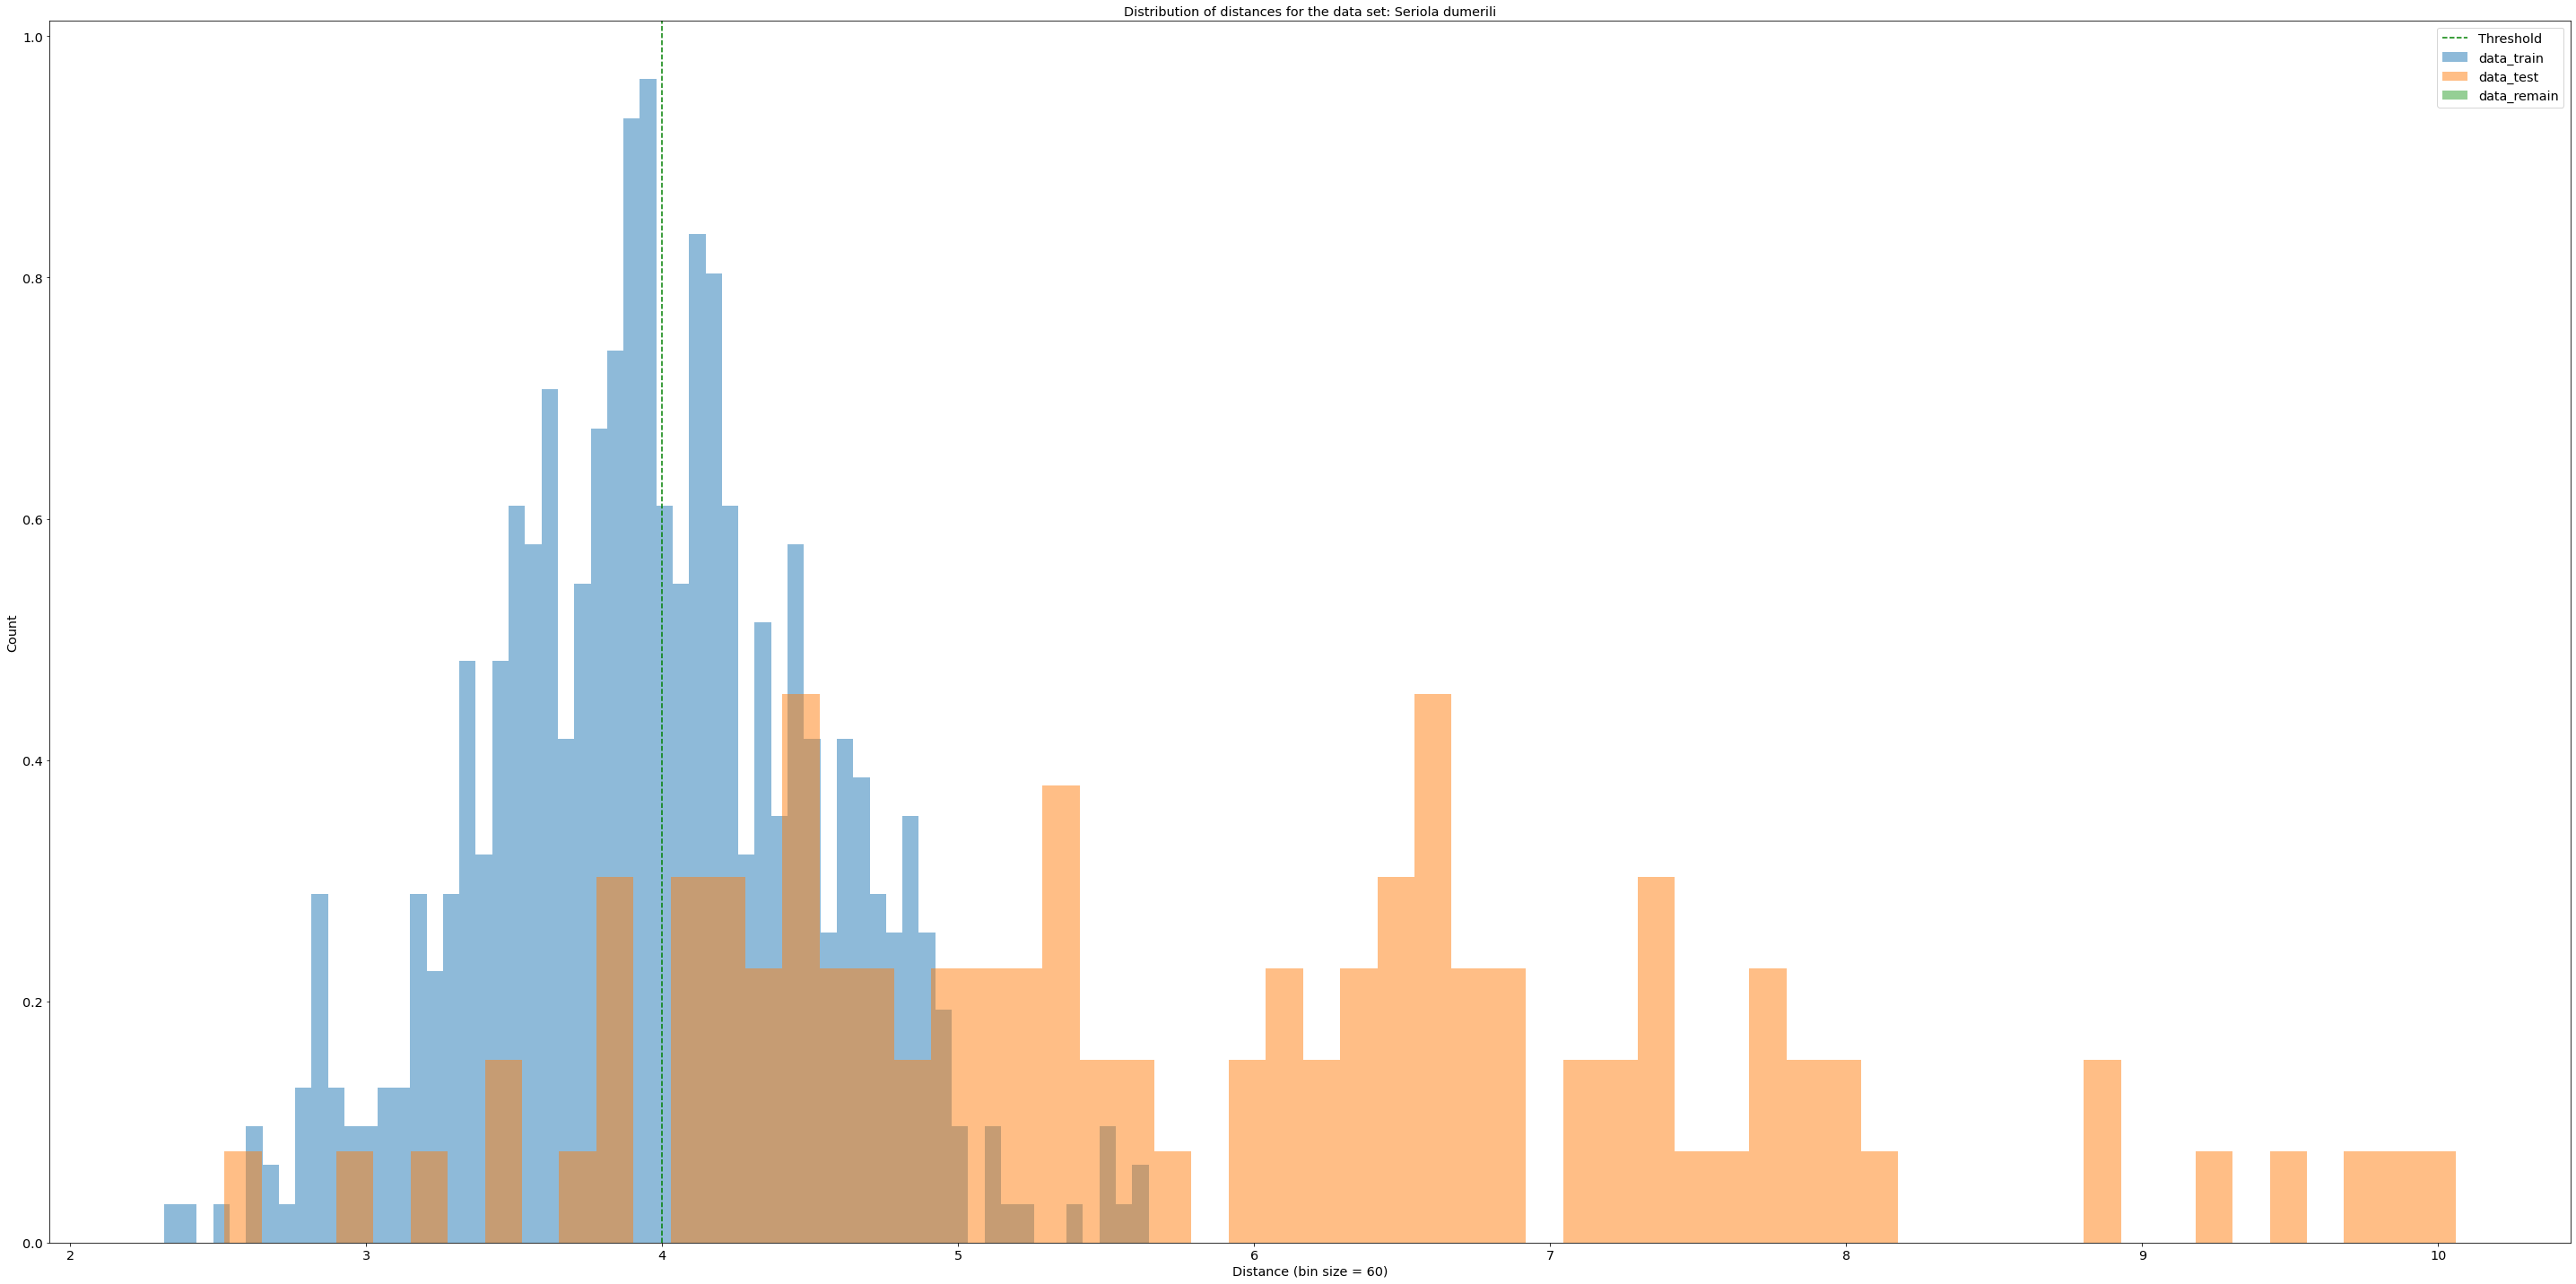

Train: 26732 Test: 1560 Remain: 0


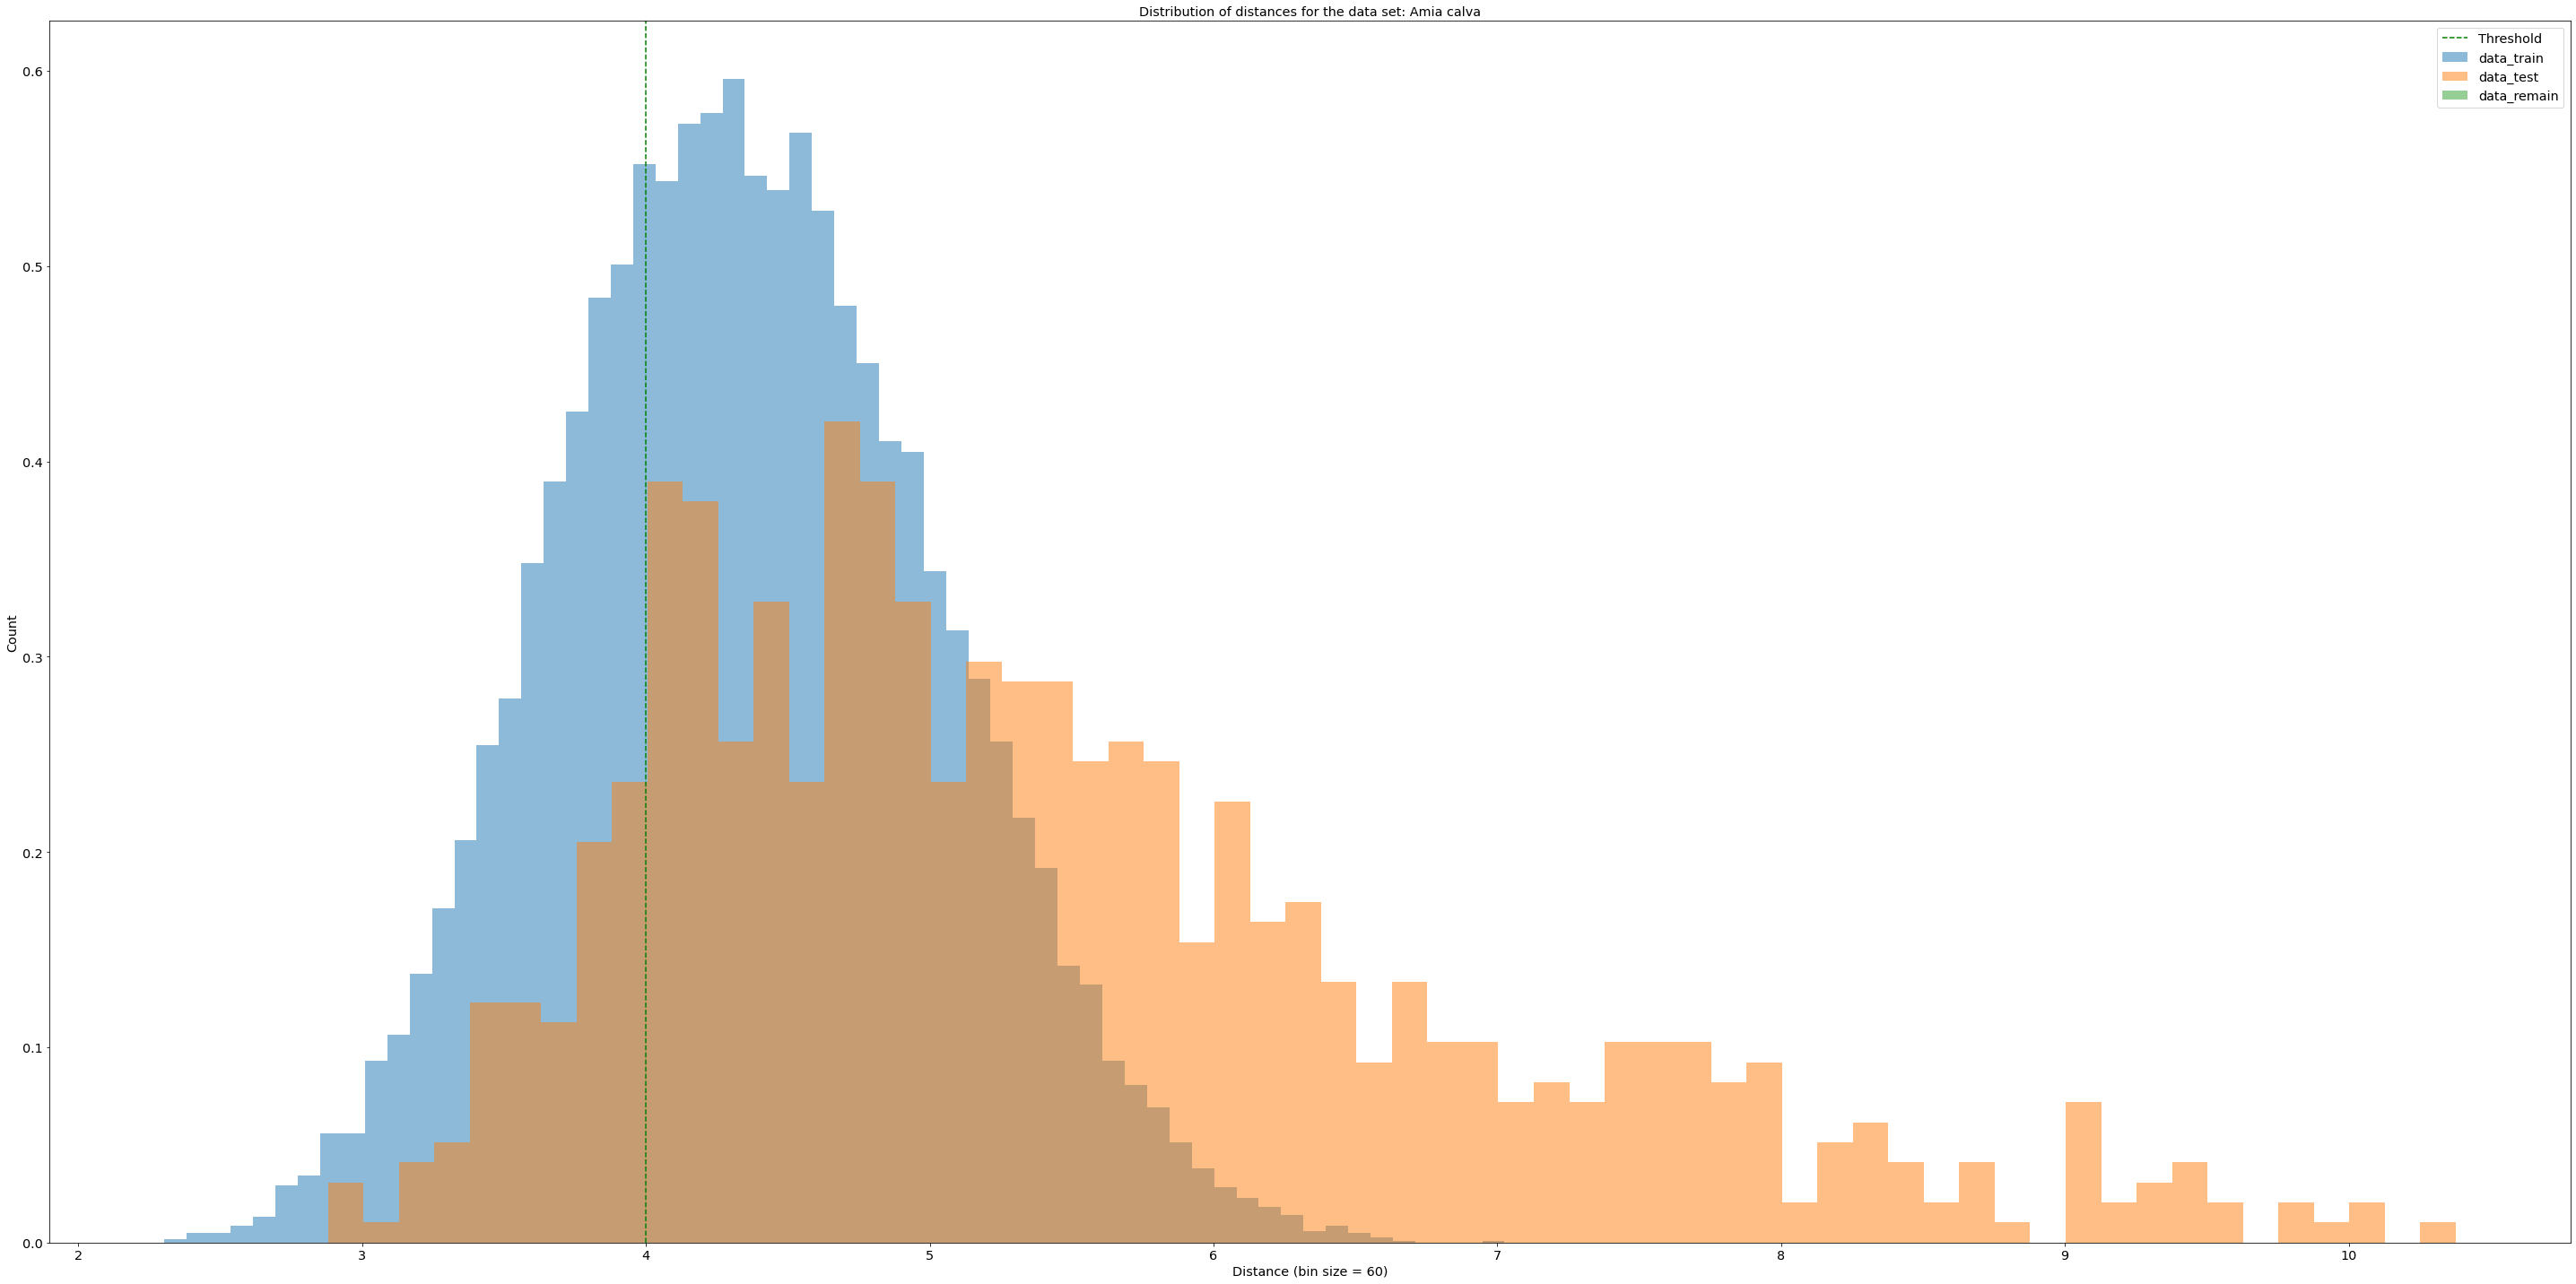

Train: 28392 Test: 1722 Remain: 6972


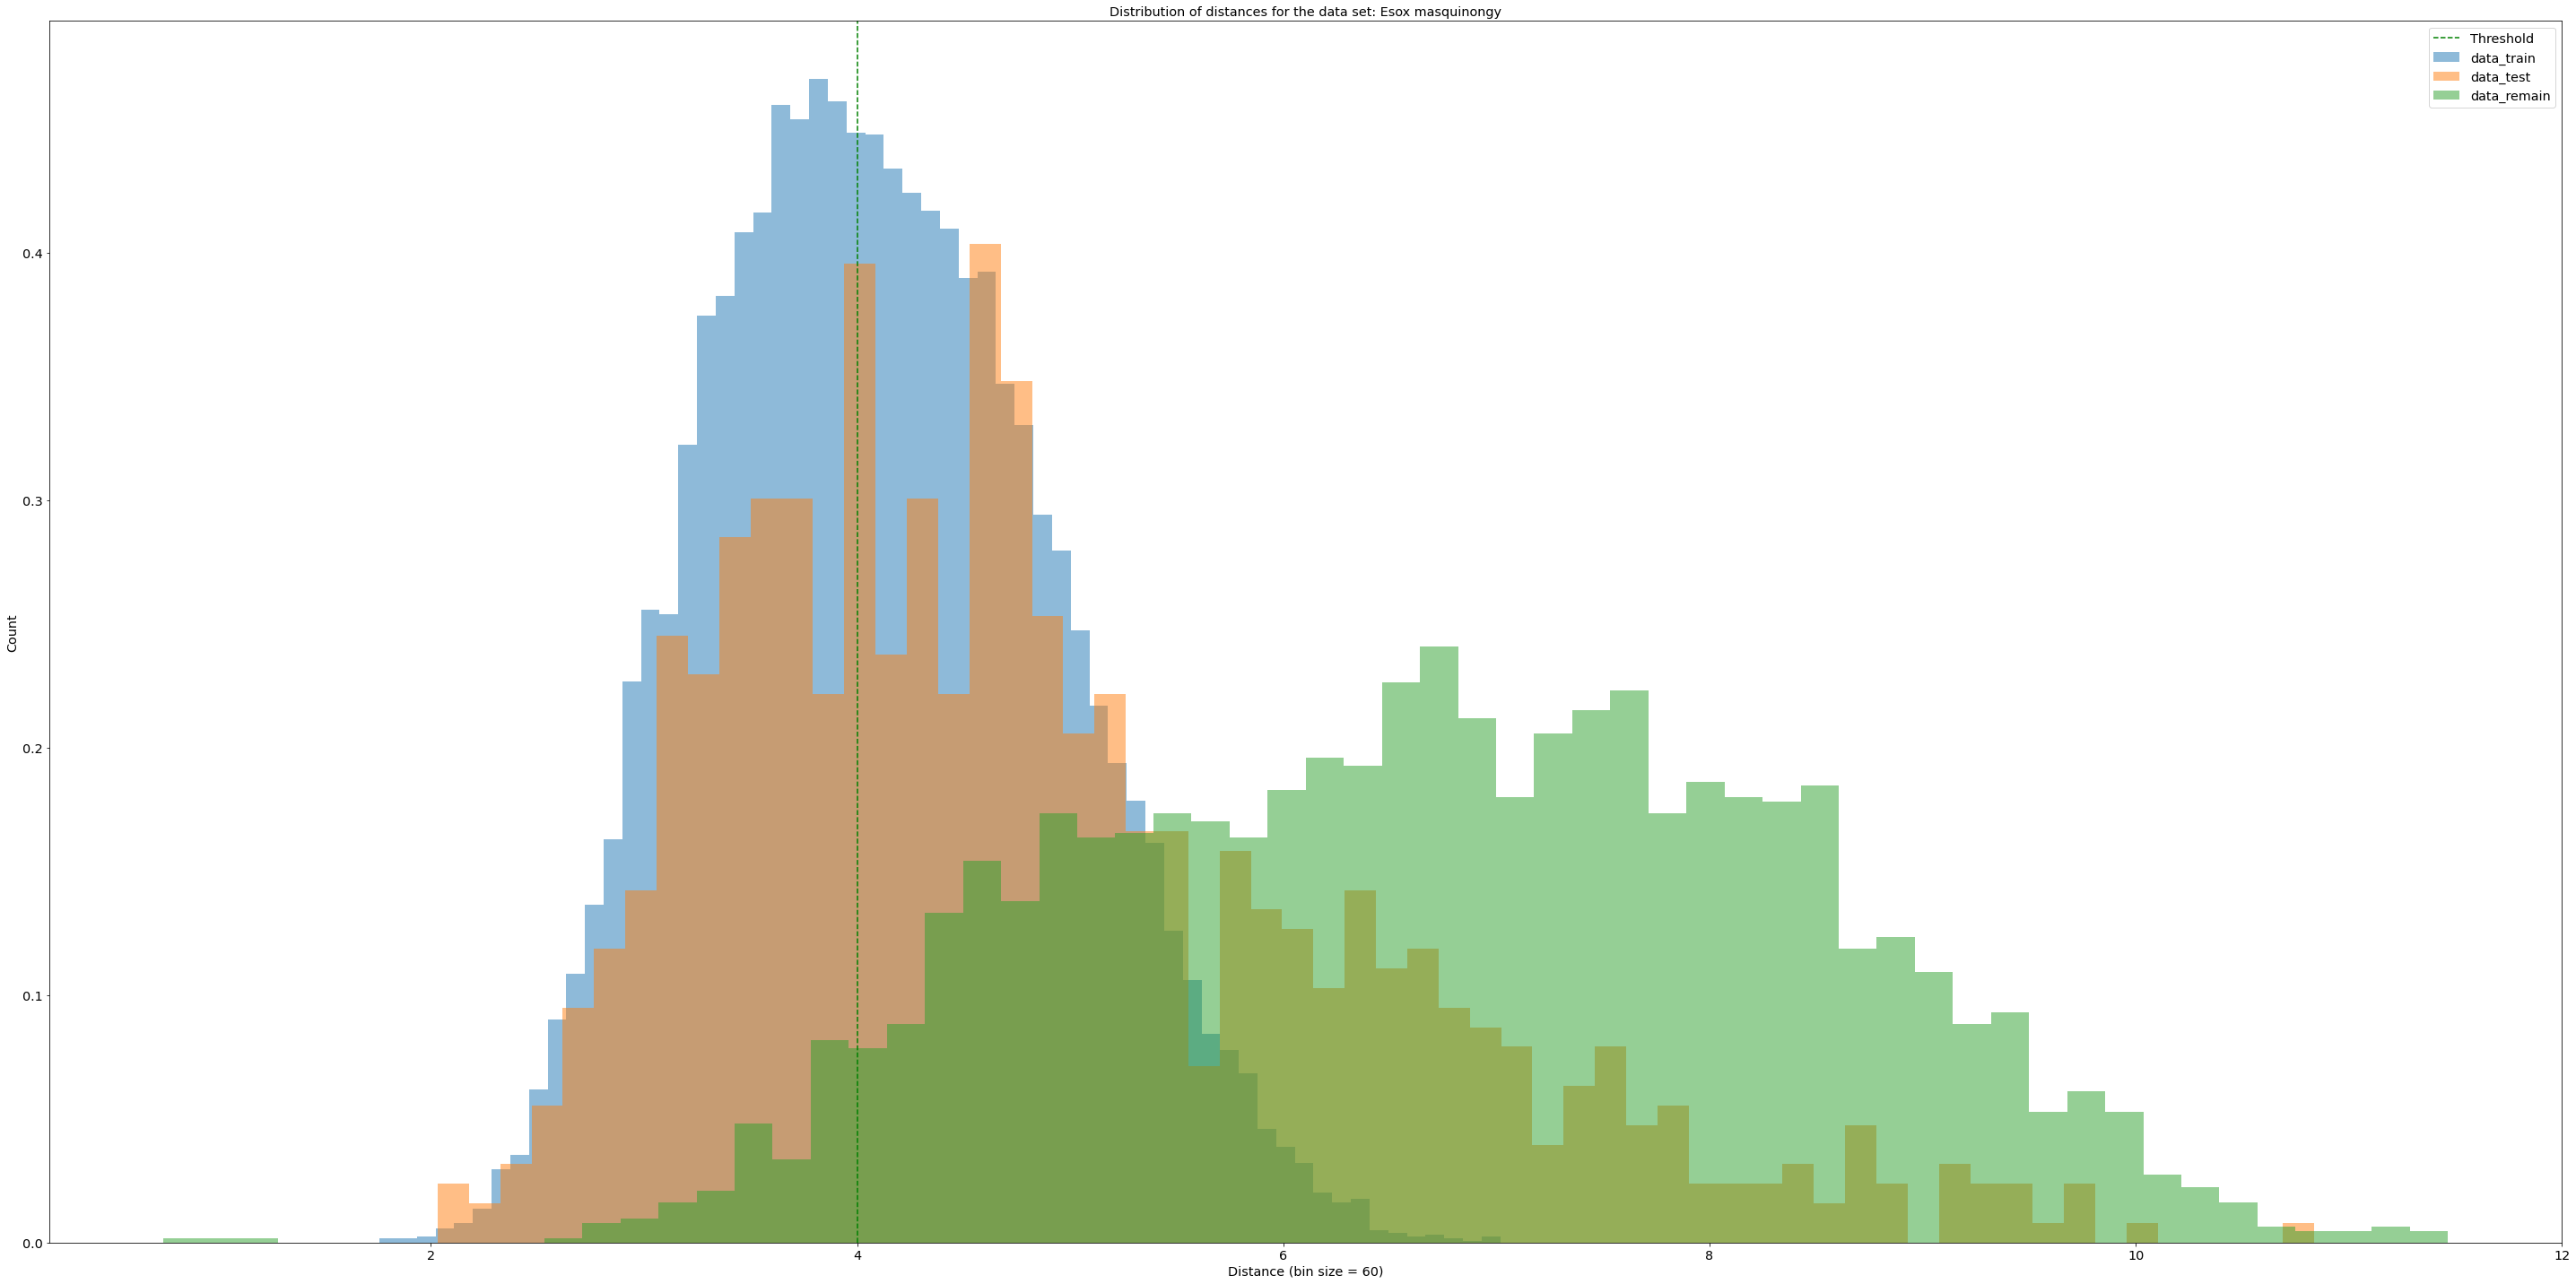

Train: 1406 Test: 210 Remain: 0


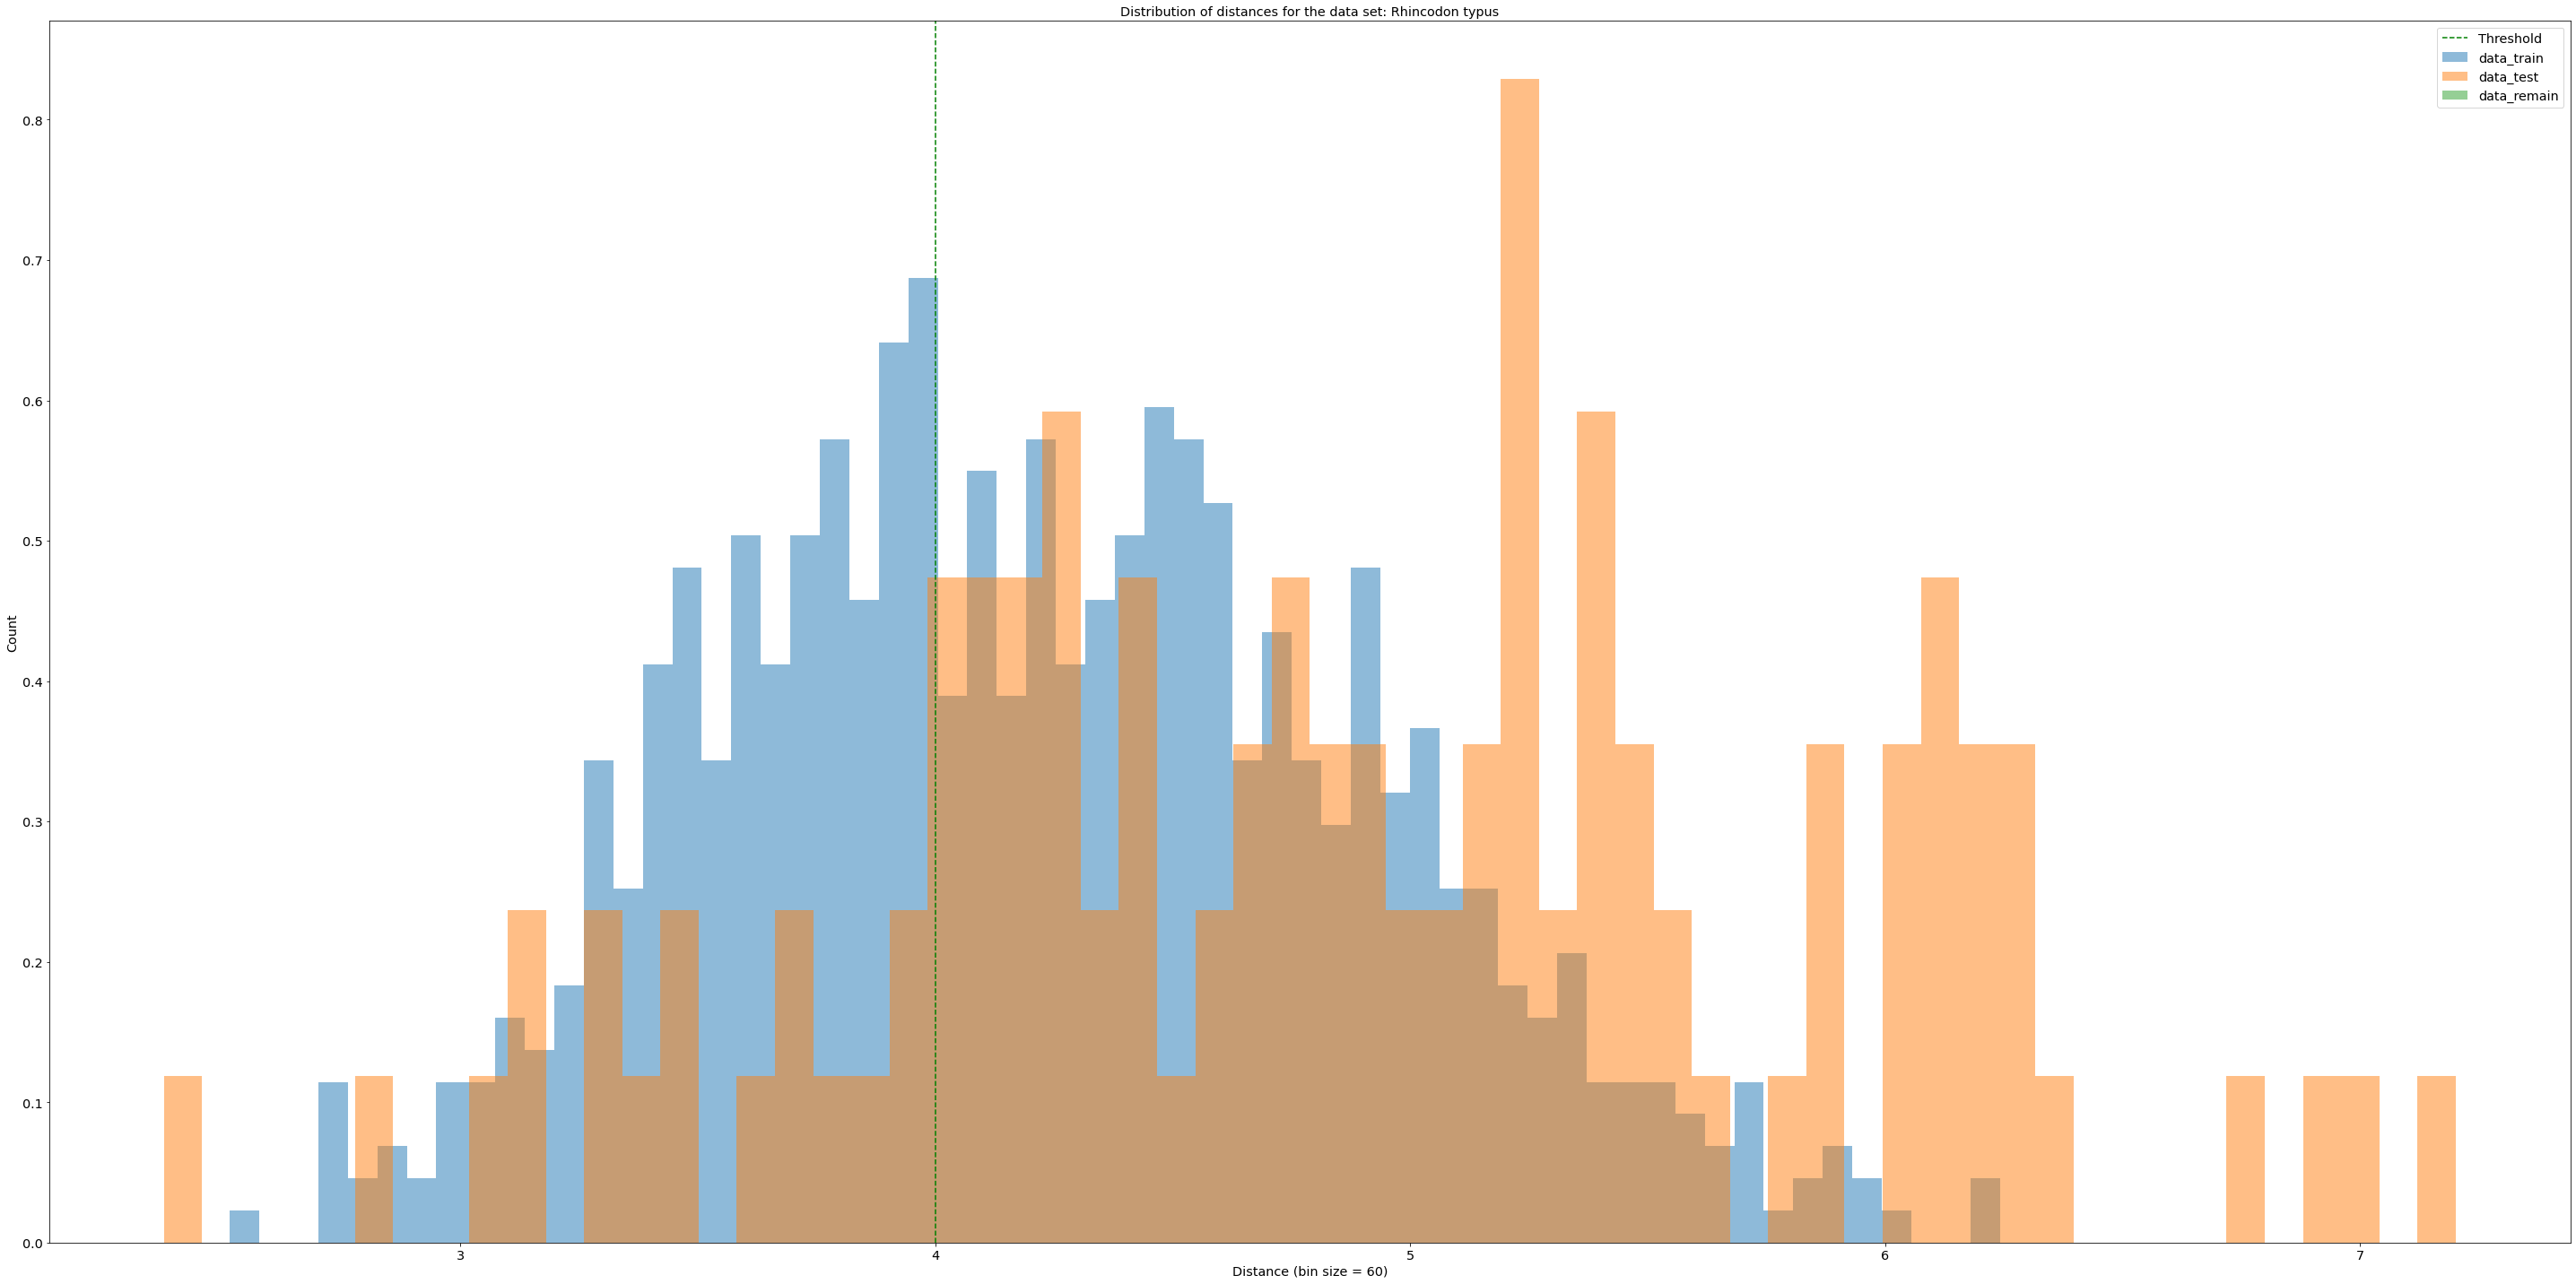

Train: 28392 Test: 1722 Remain: 123552


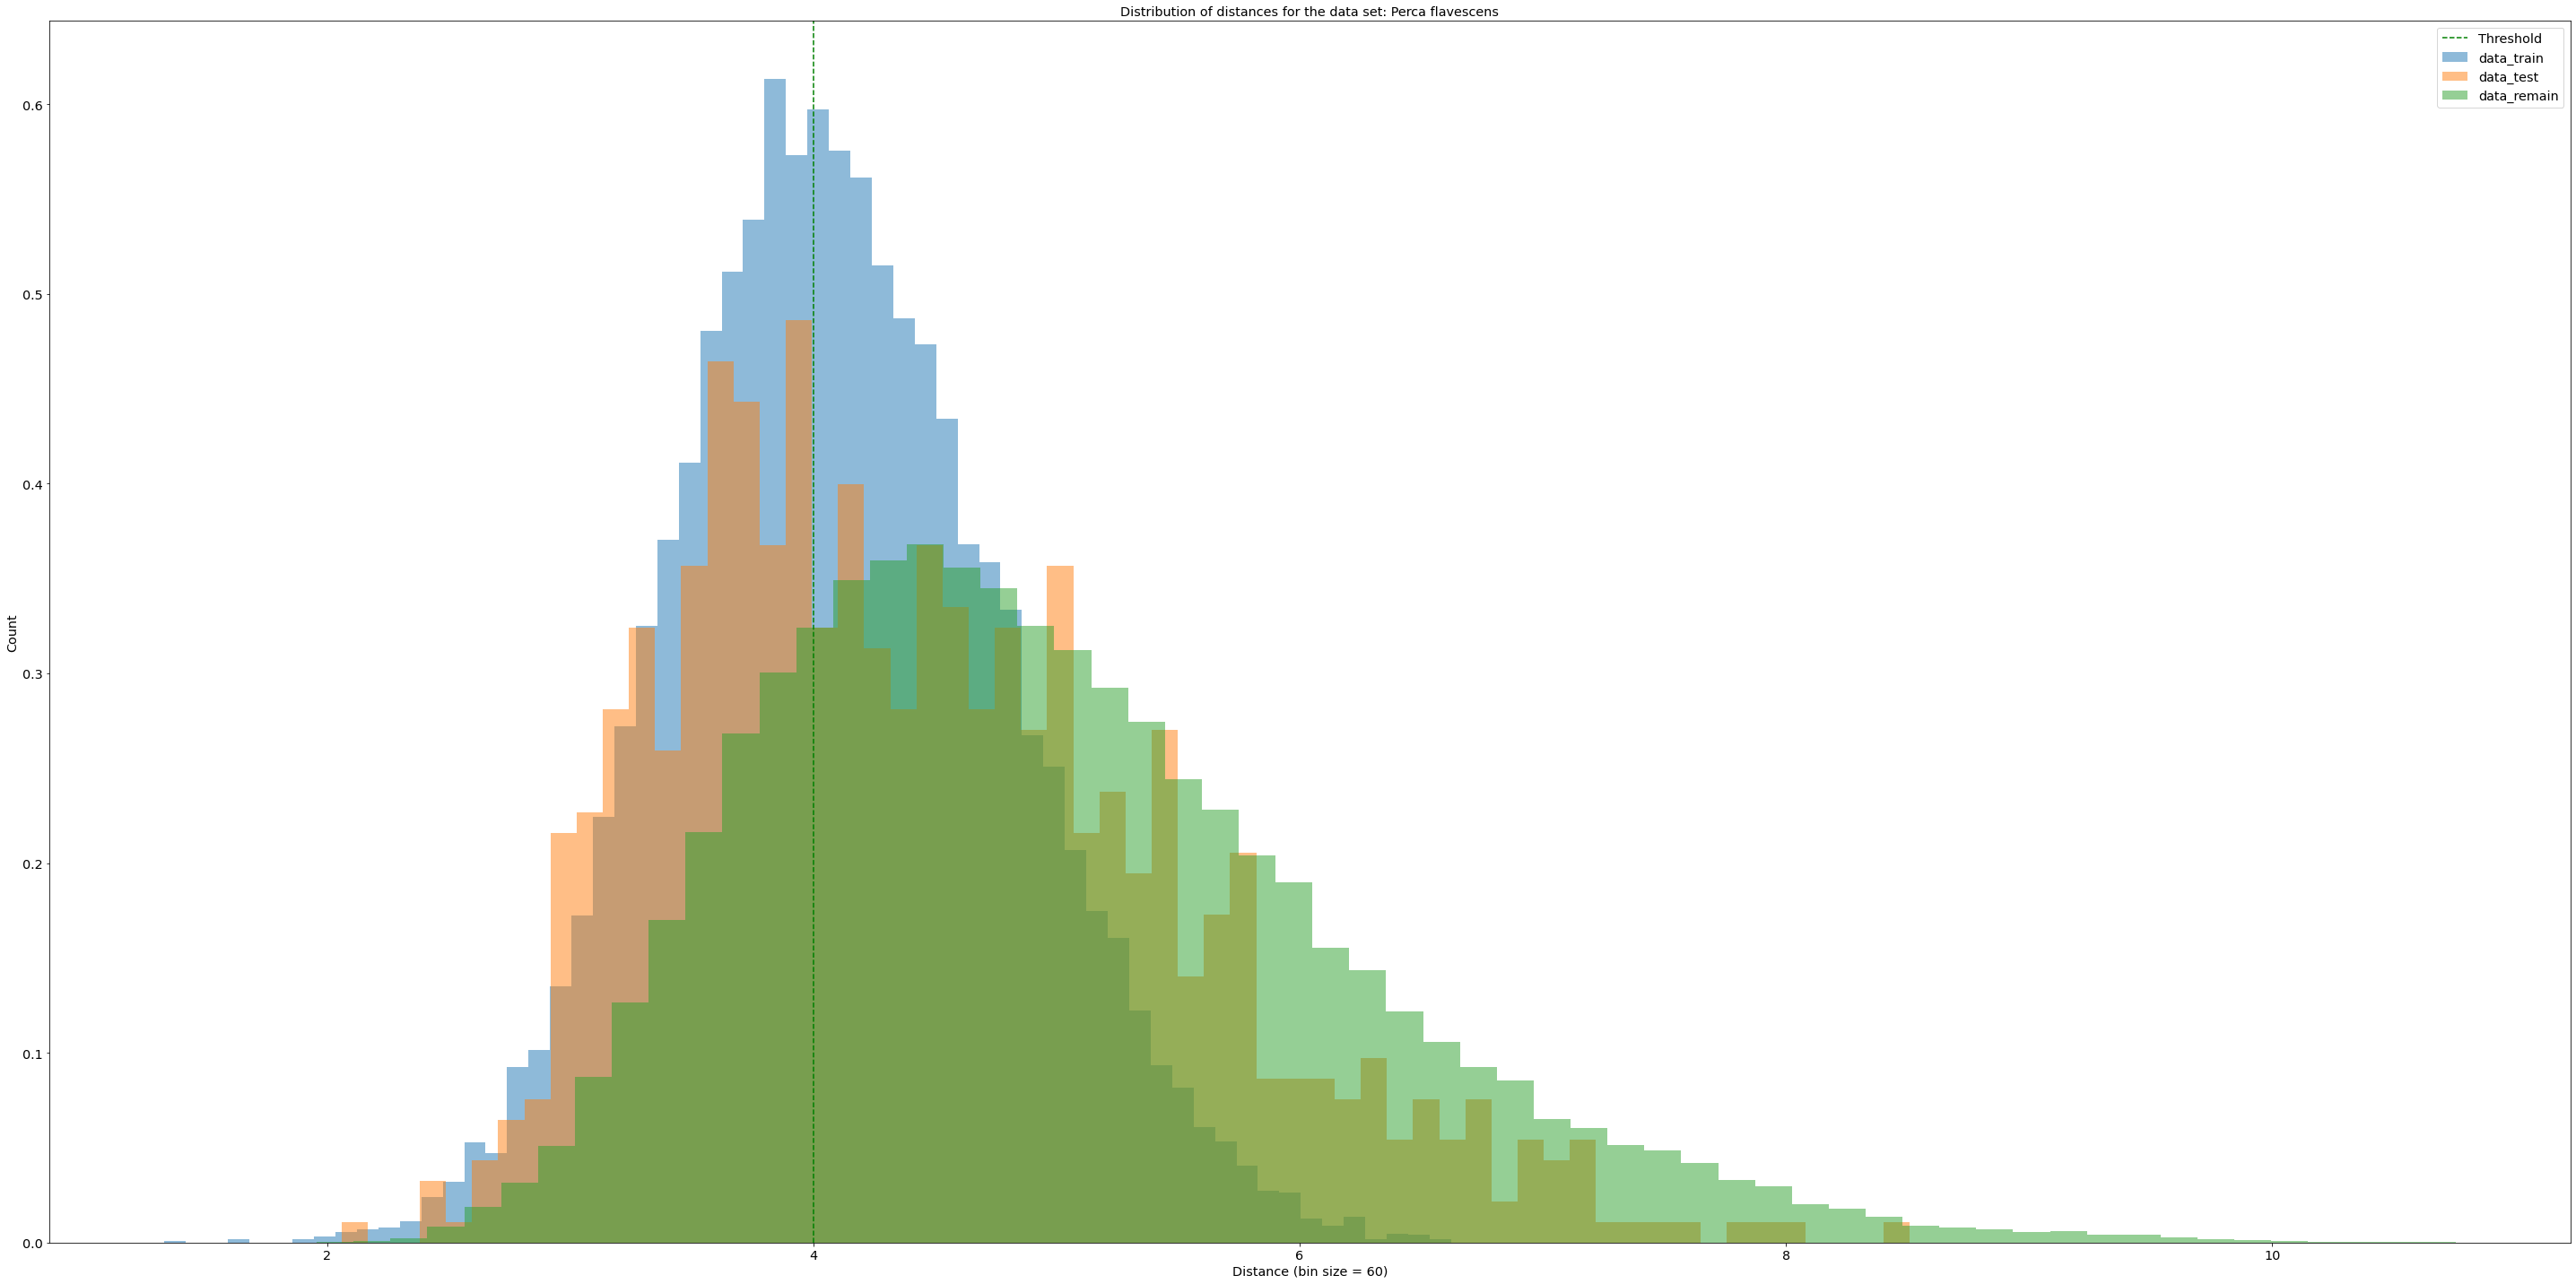

Train: 22952 Test: 1332 Remain: 0


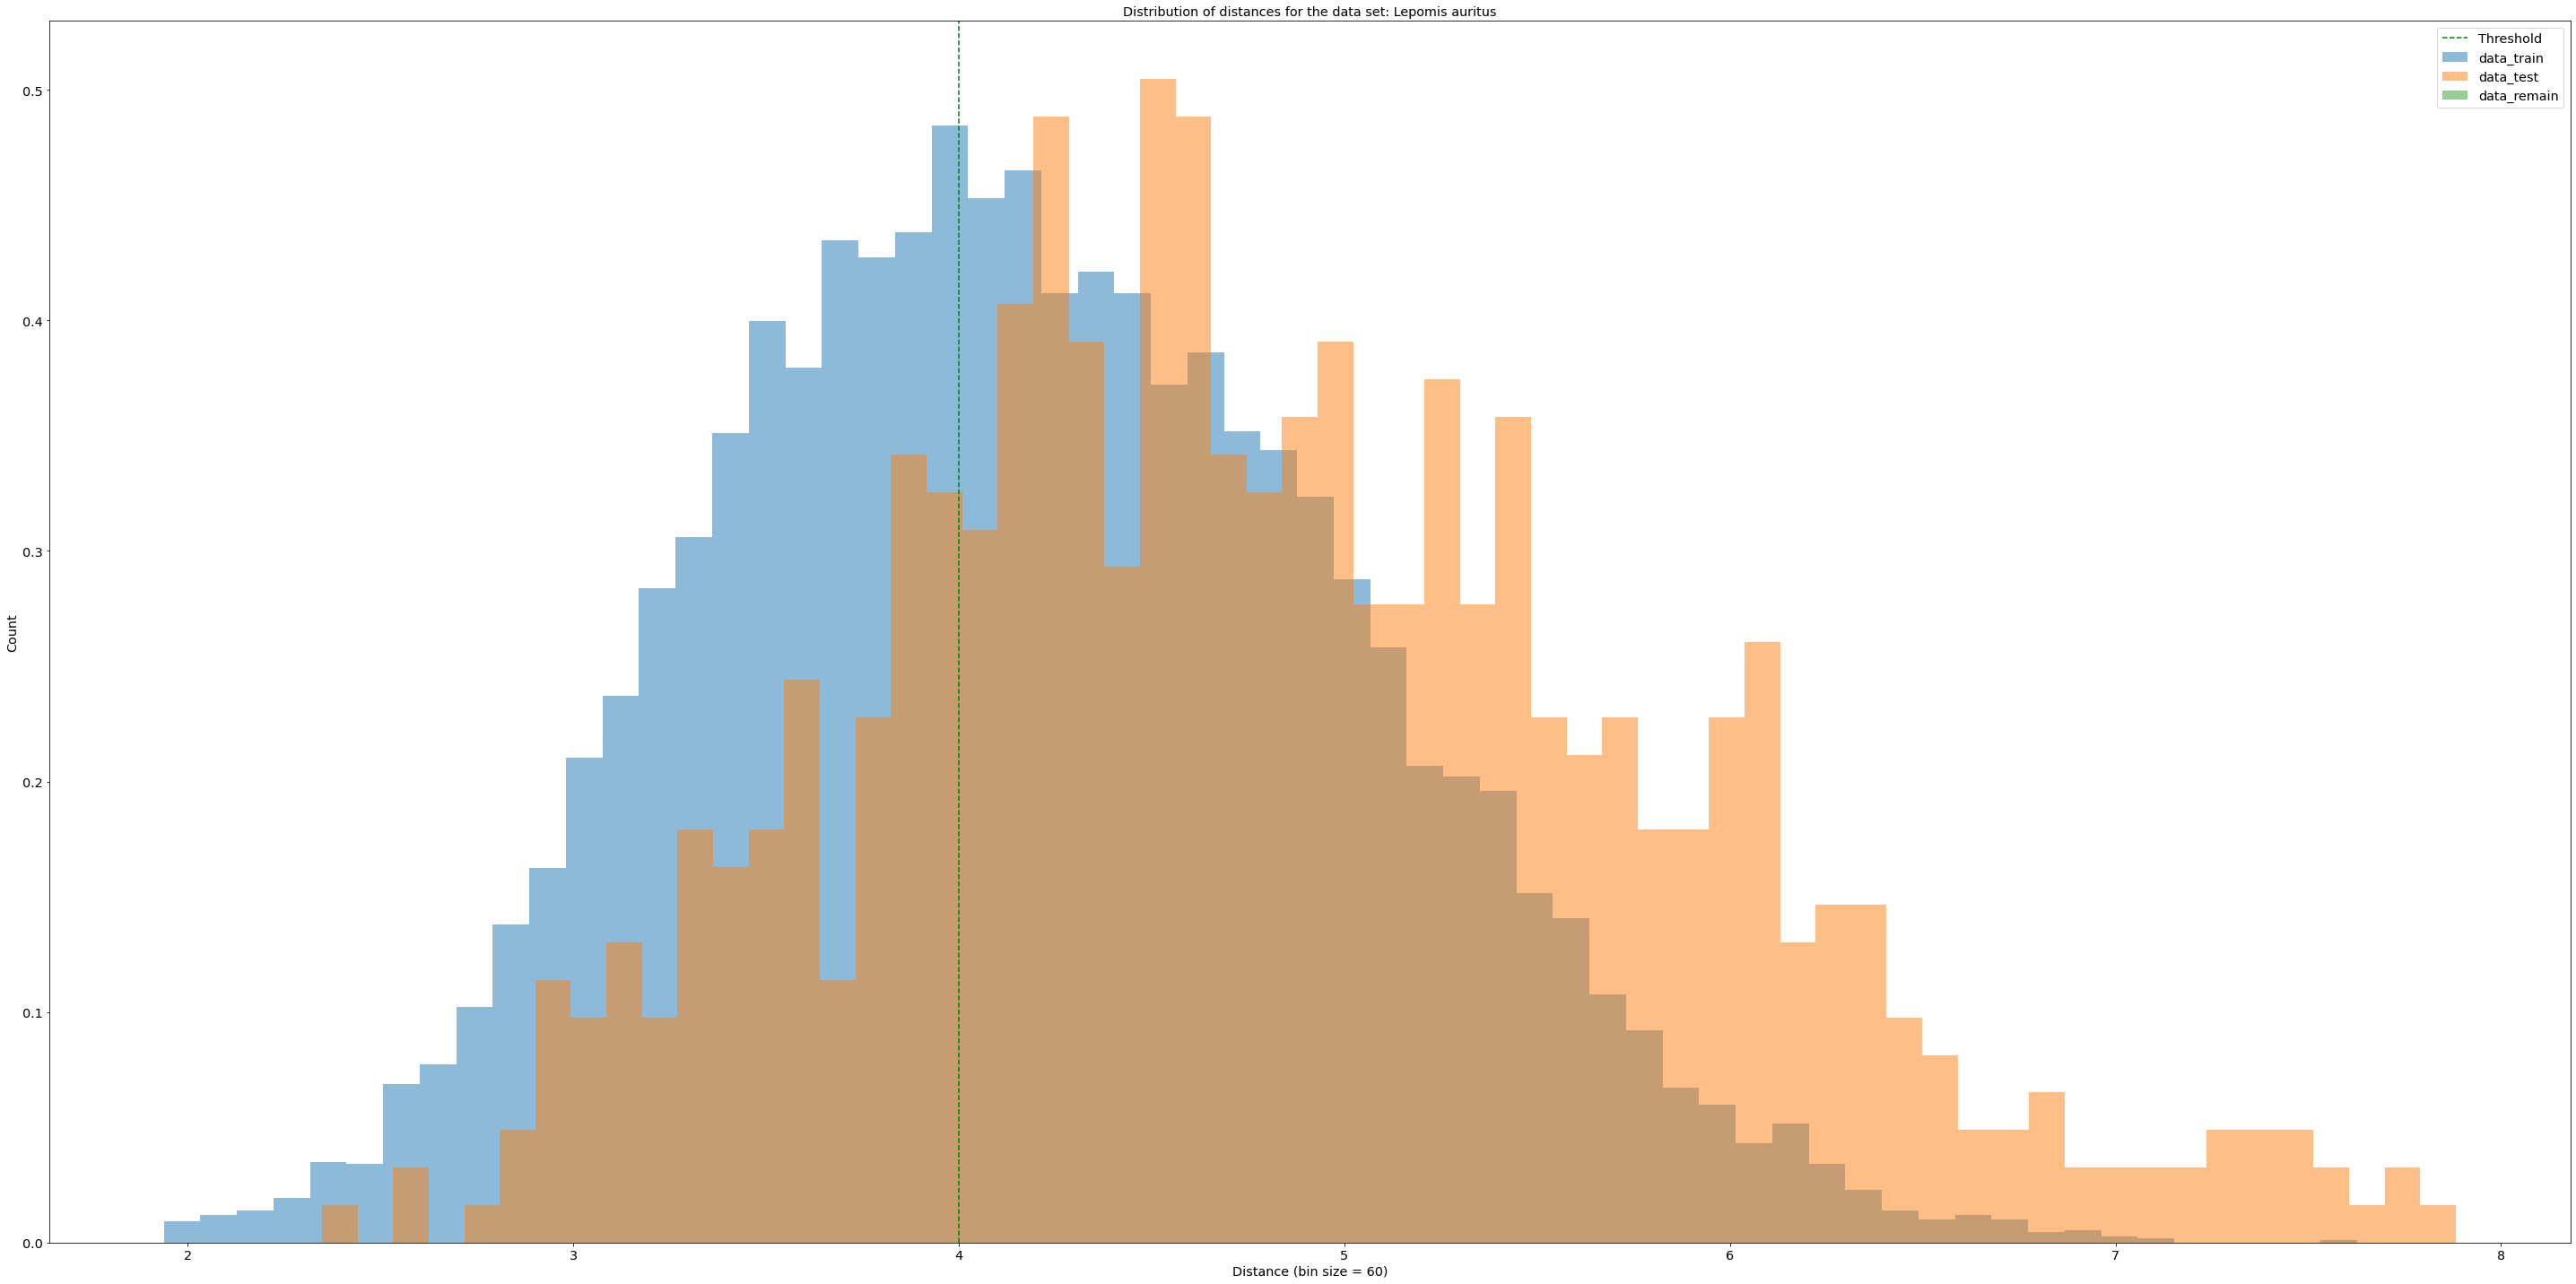

Train: 4830 Test: 306 Remain: 0


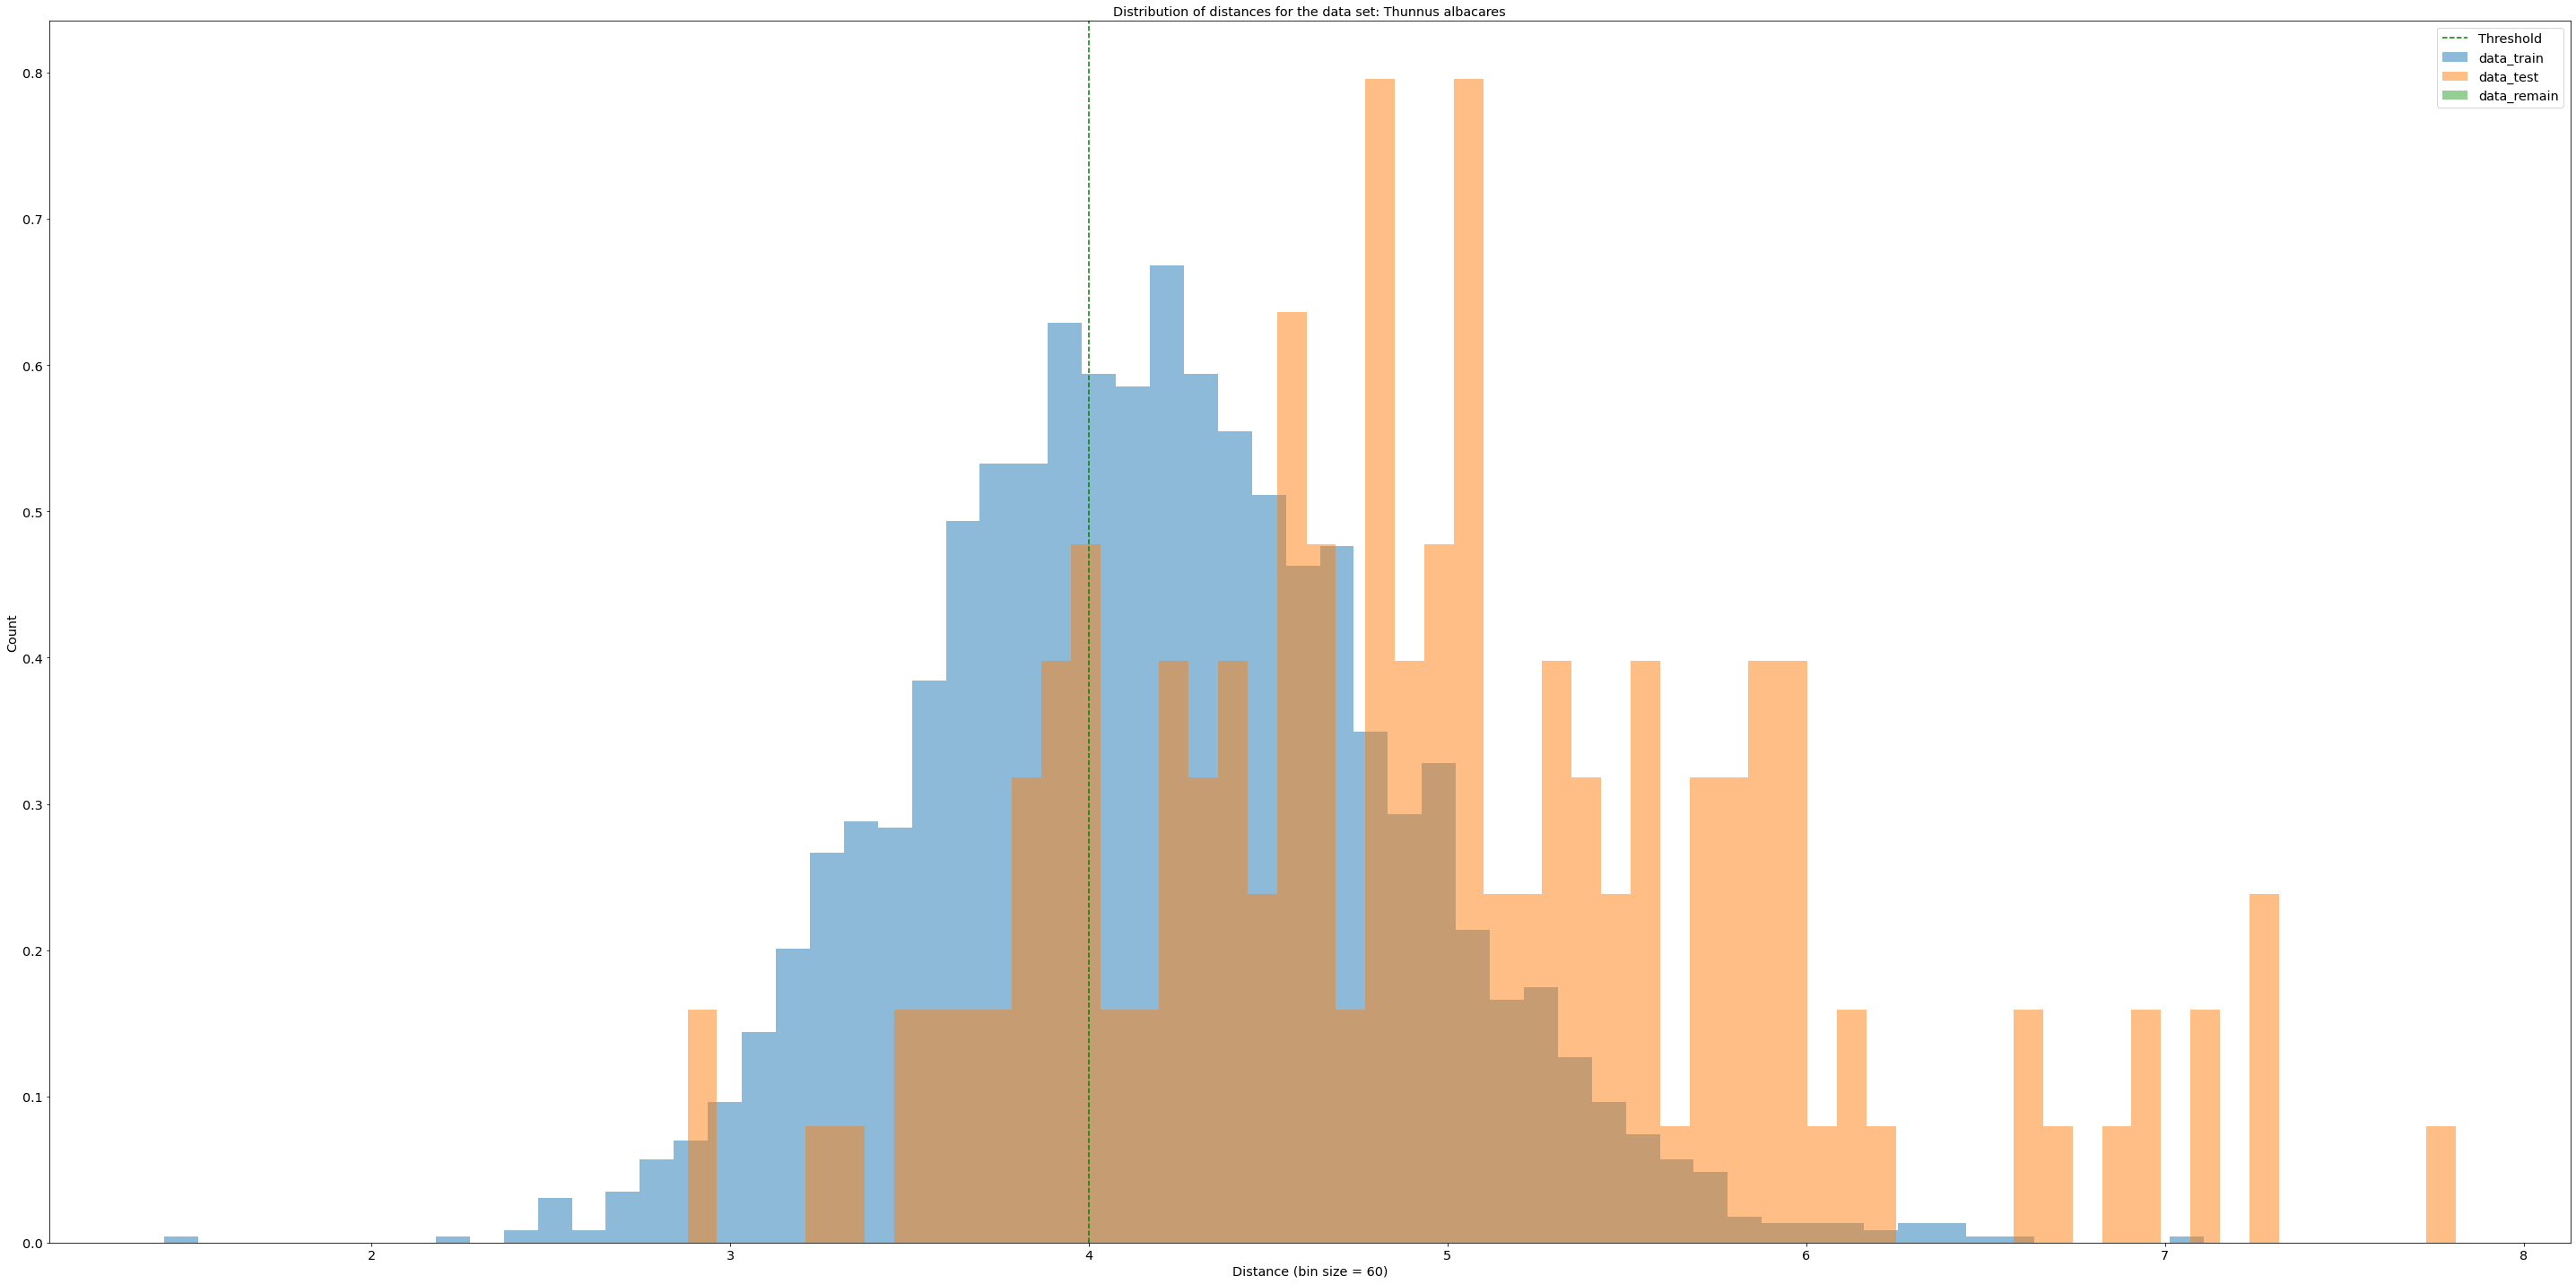

Train: 15252 Test: 930 Remain: 0


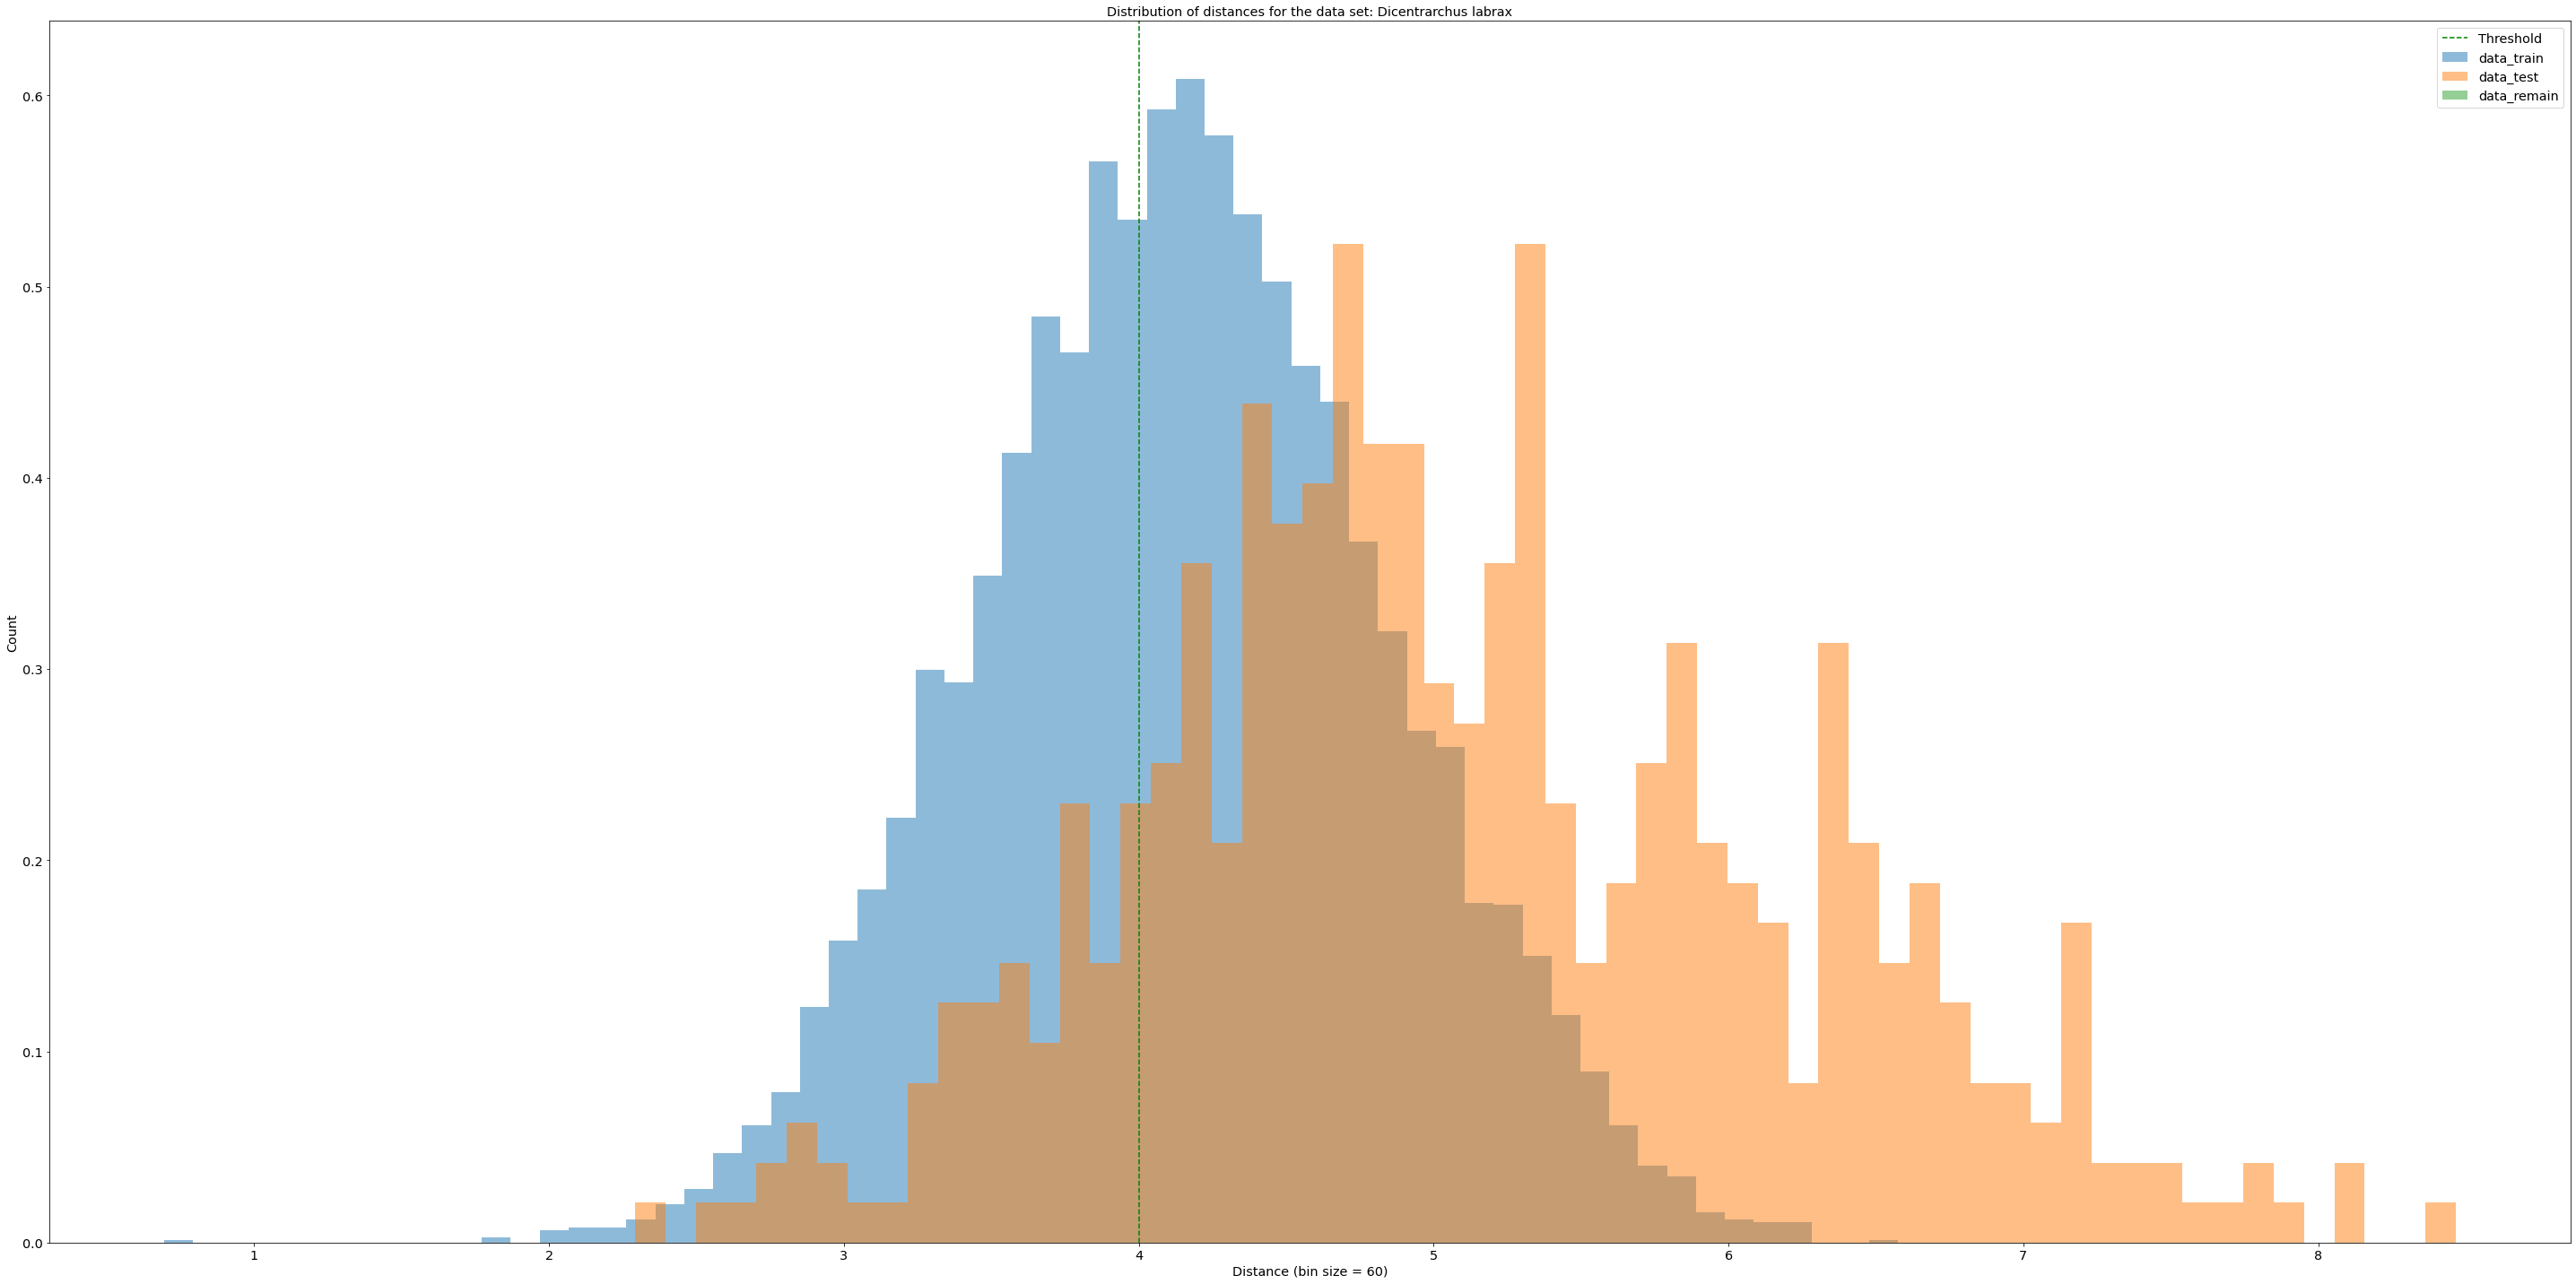

Train: 28392 Test: 1722 Remain: 156


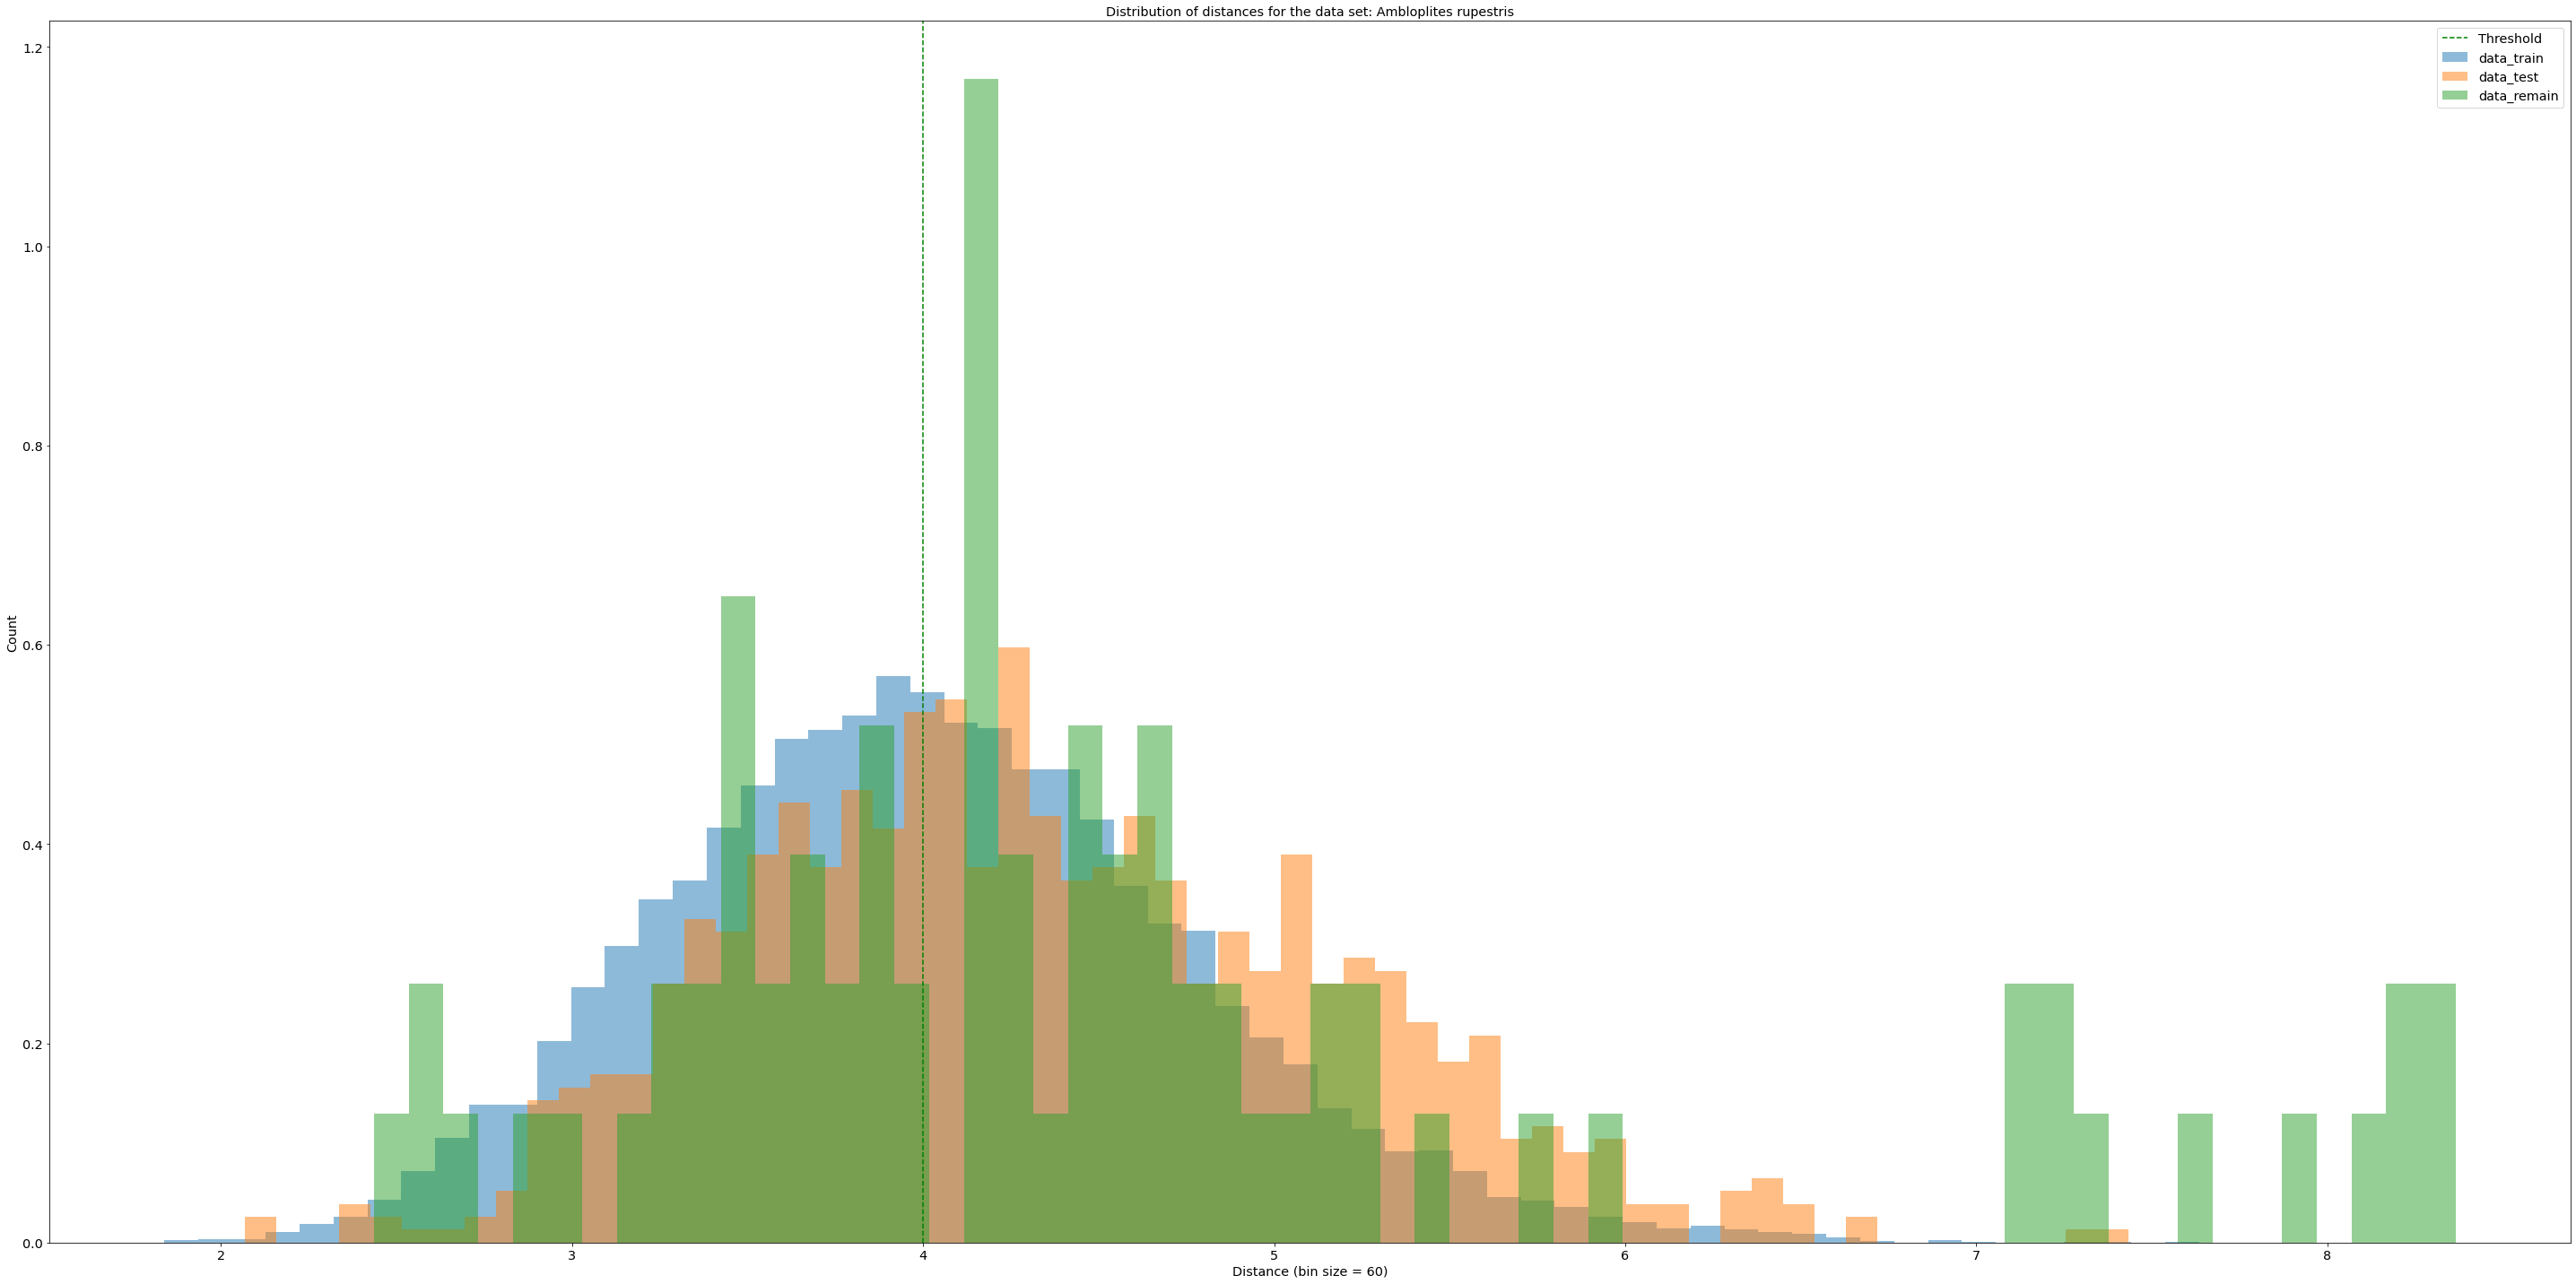

Train: 28392 Test: 1722 Remain: 12


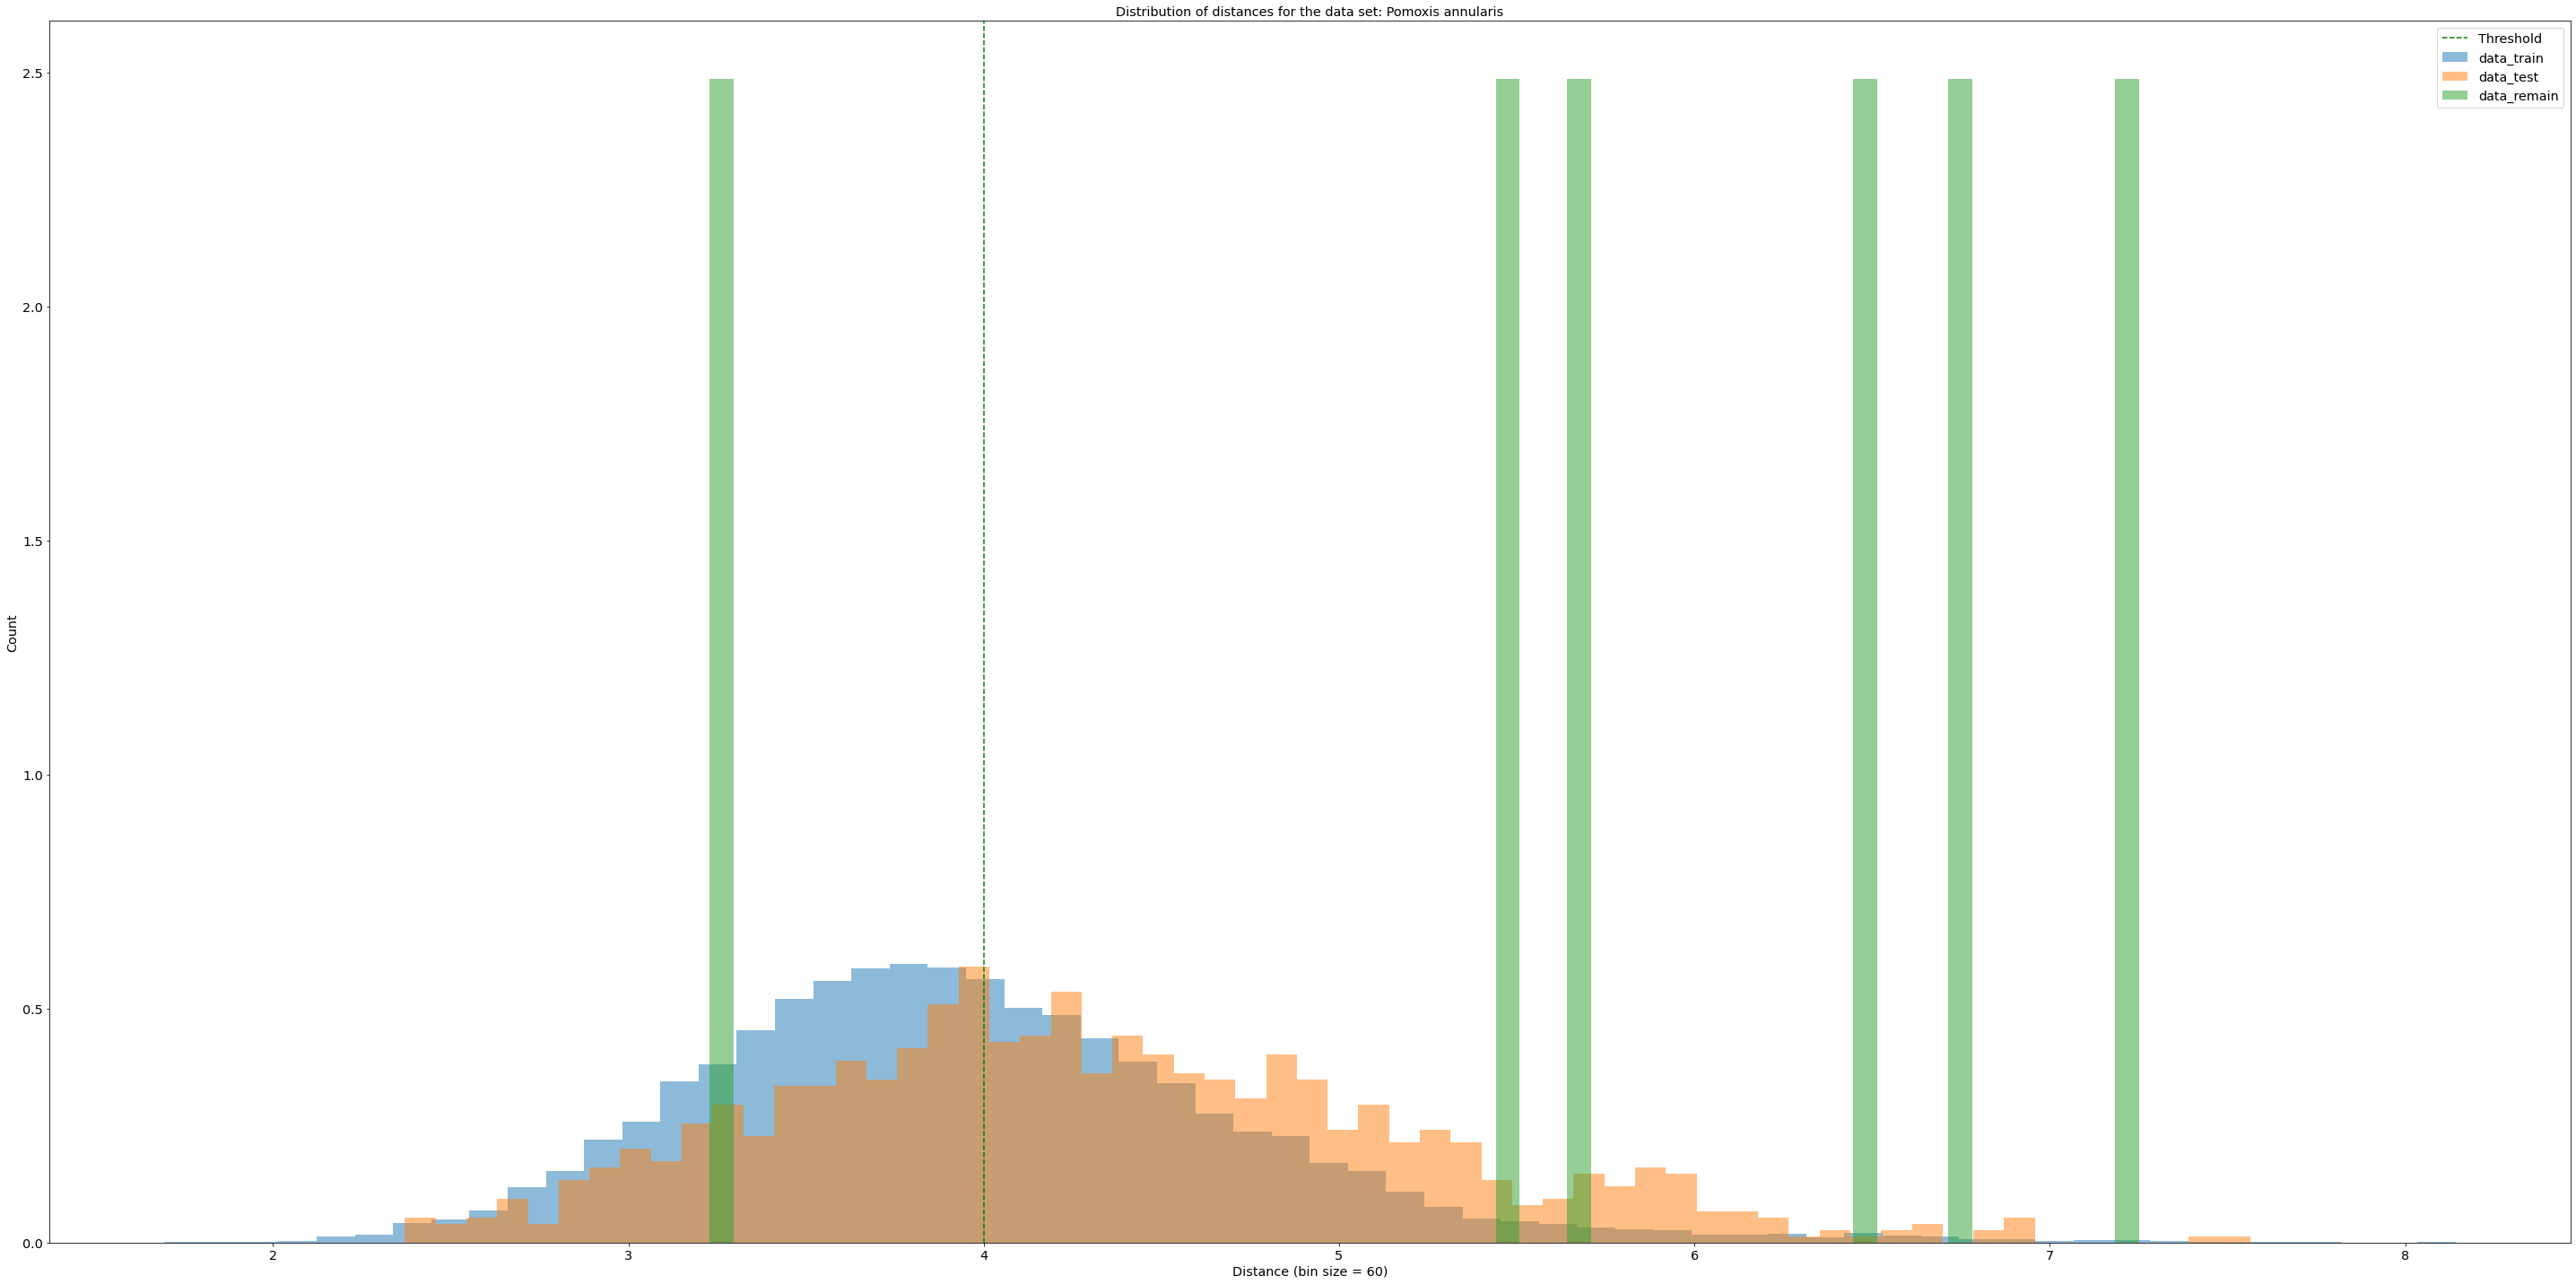

Train: 28392 Test: 1722 Remain: 172640


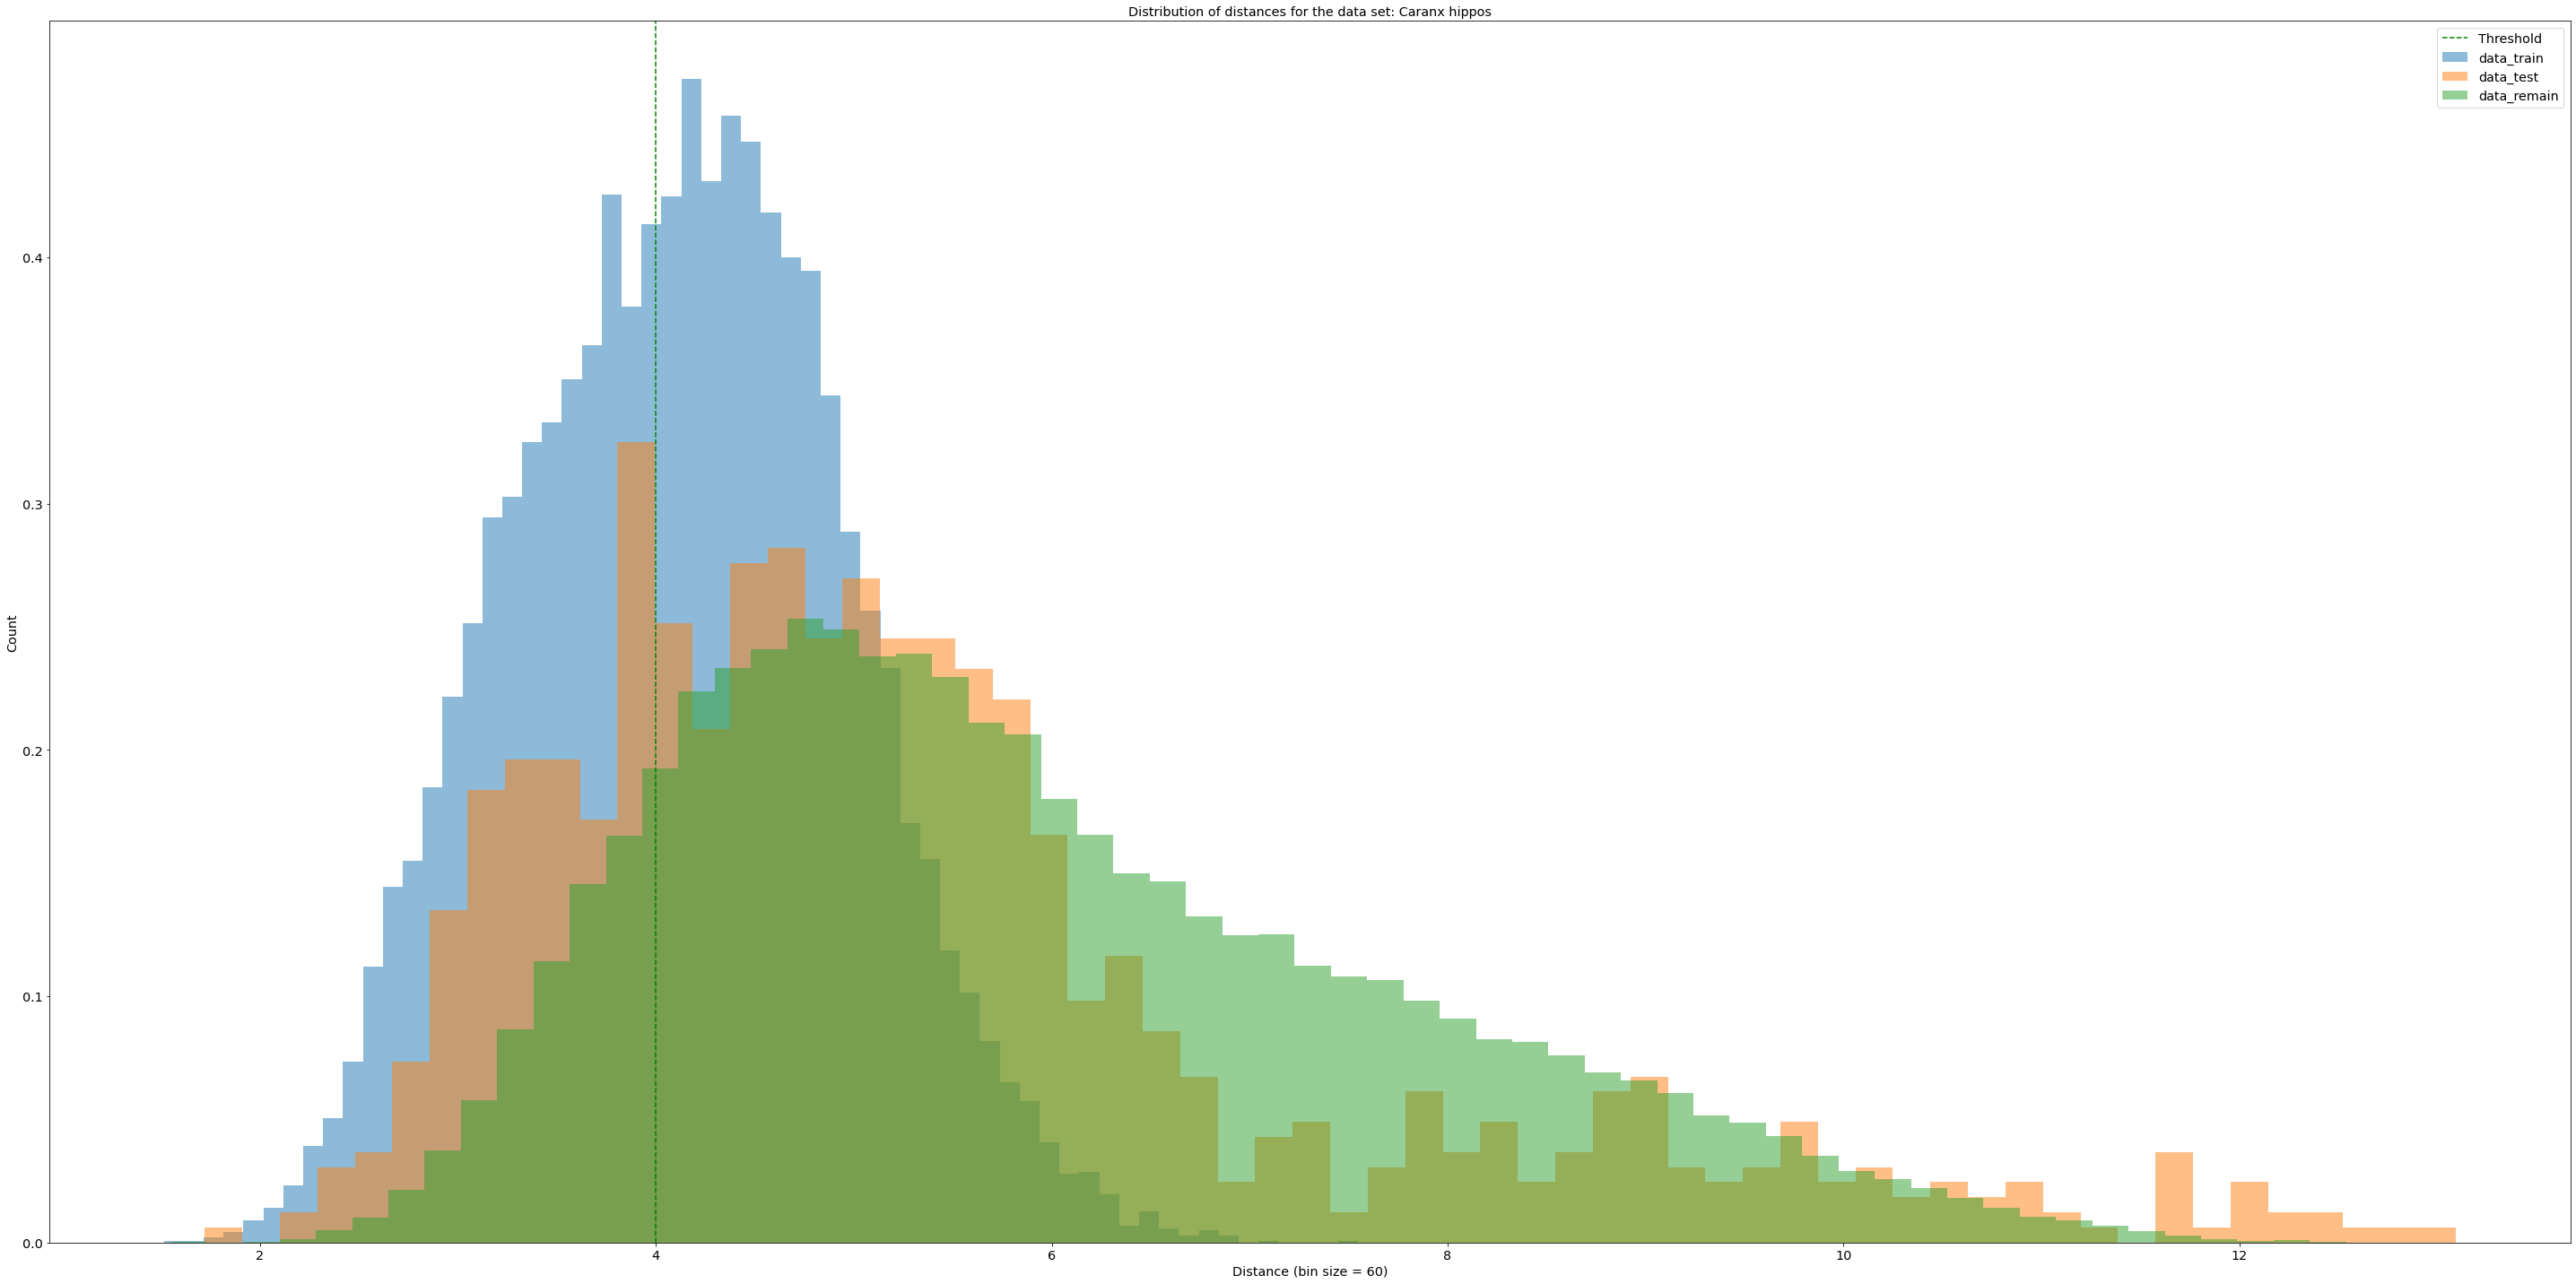

Train: 9120 Test: 506 Remain: 0


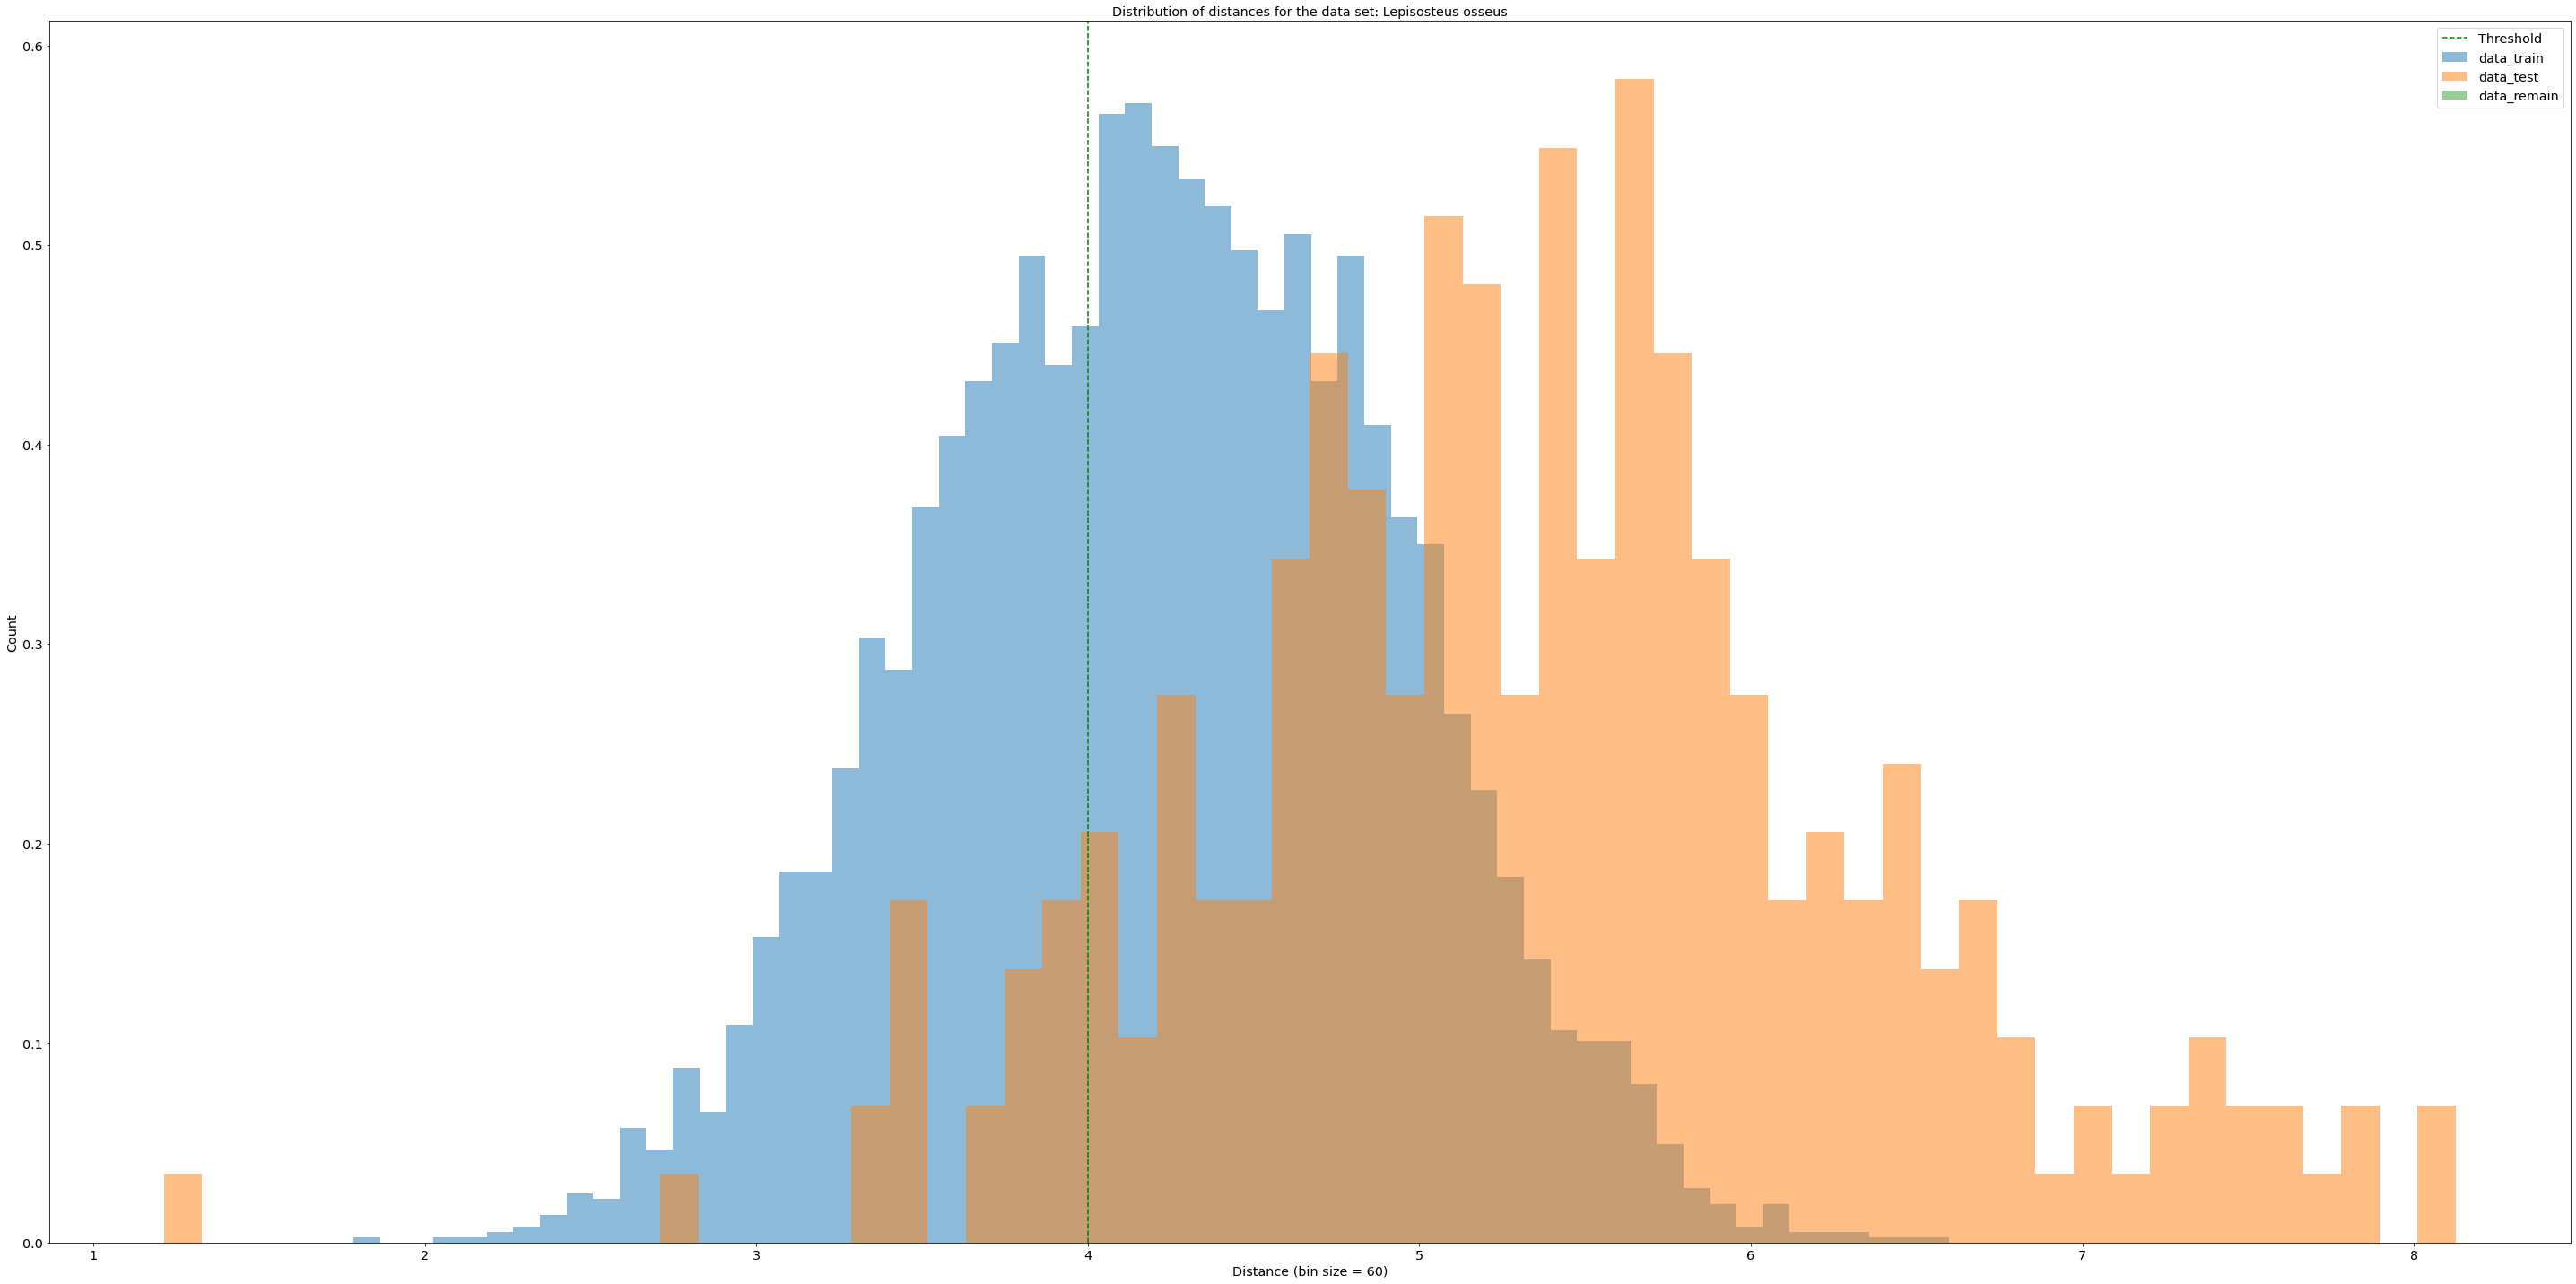

Train: 28392 Test: 1722 Remain: 2450


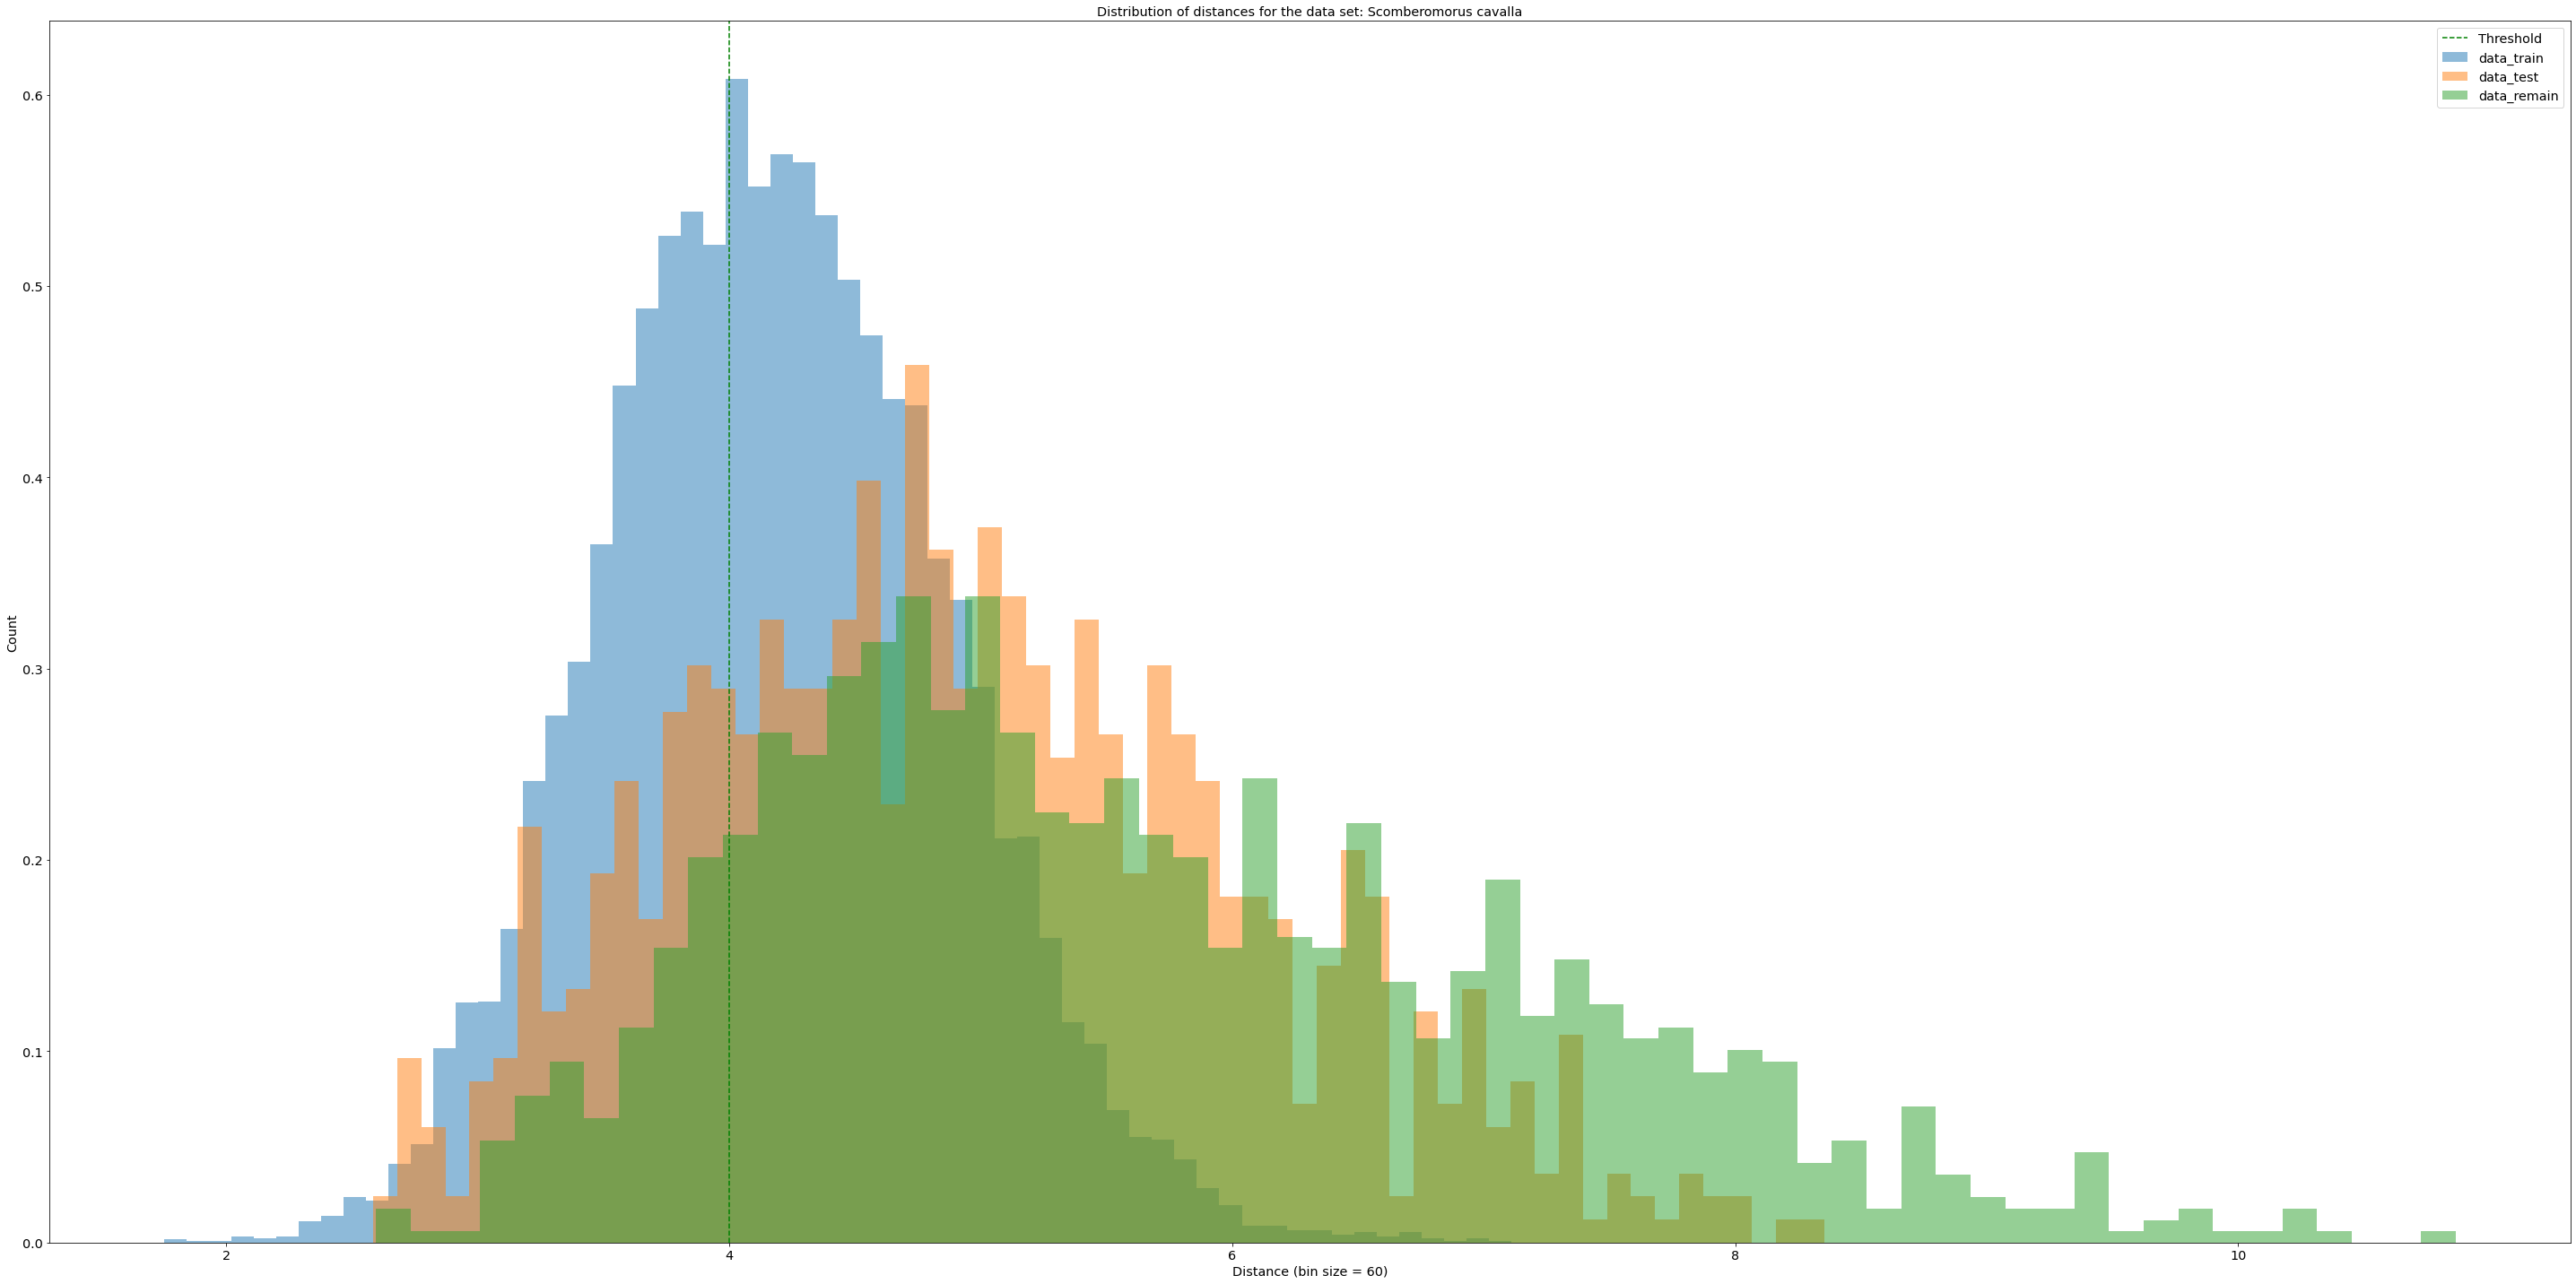

Train: 28392 Test: 1722 Remain: 6


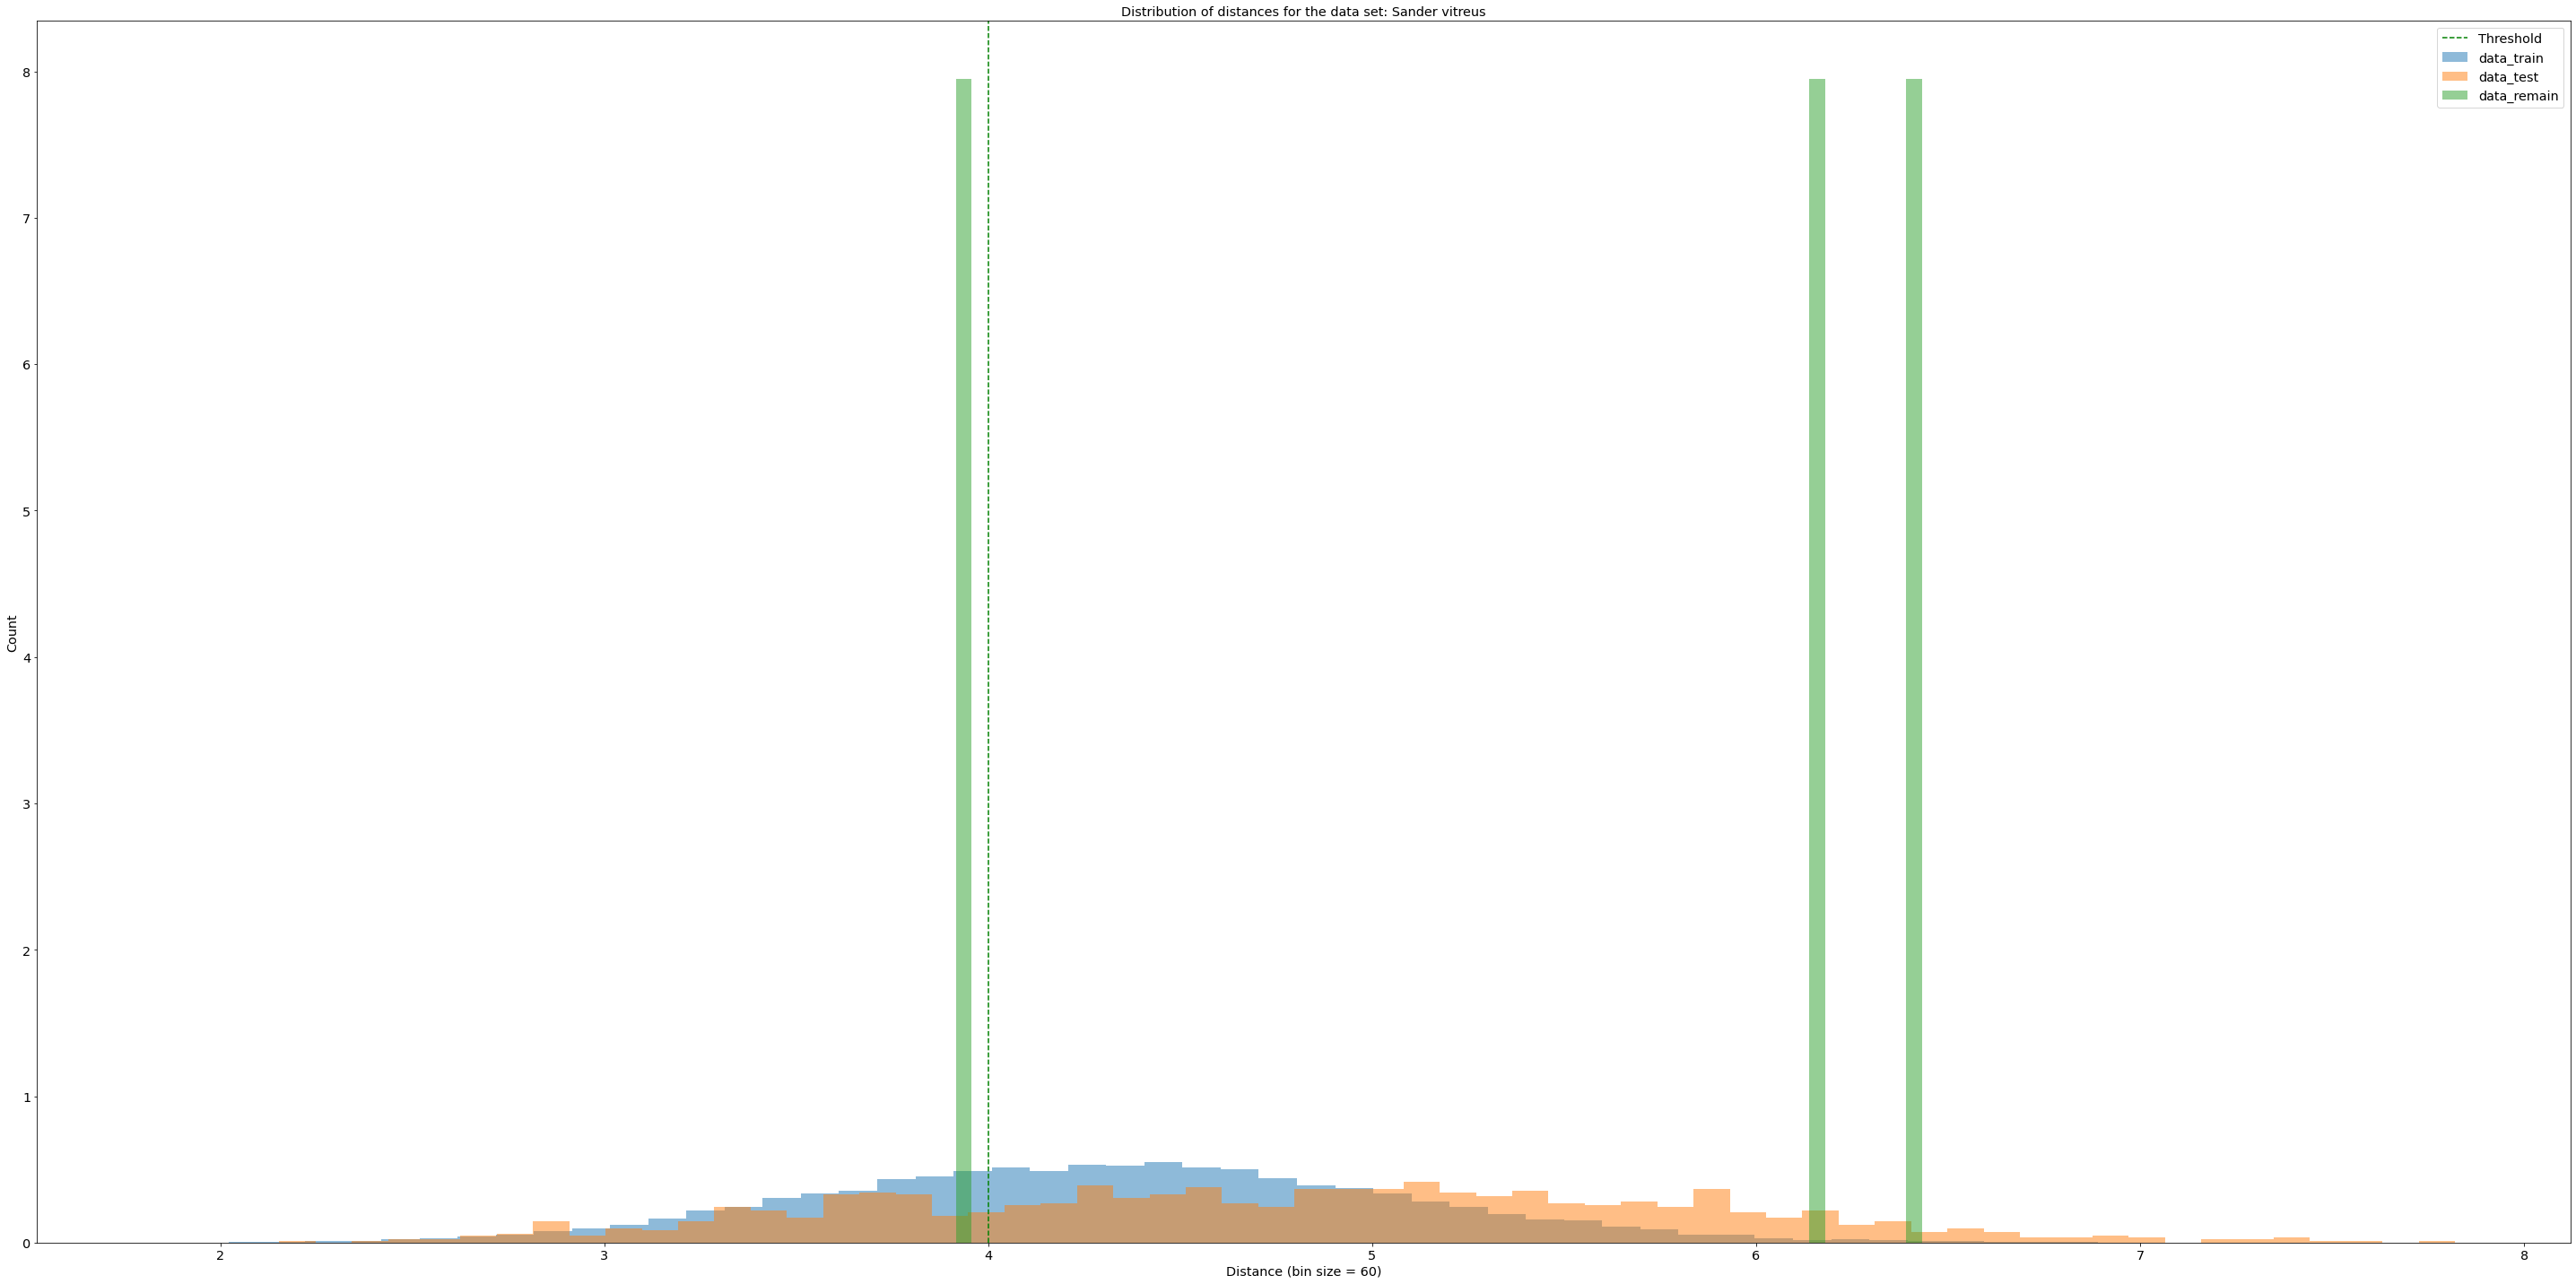

Train: 28392 Test: 1722 Remain: 32942


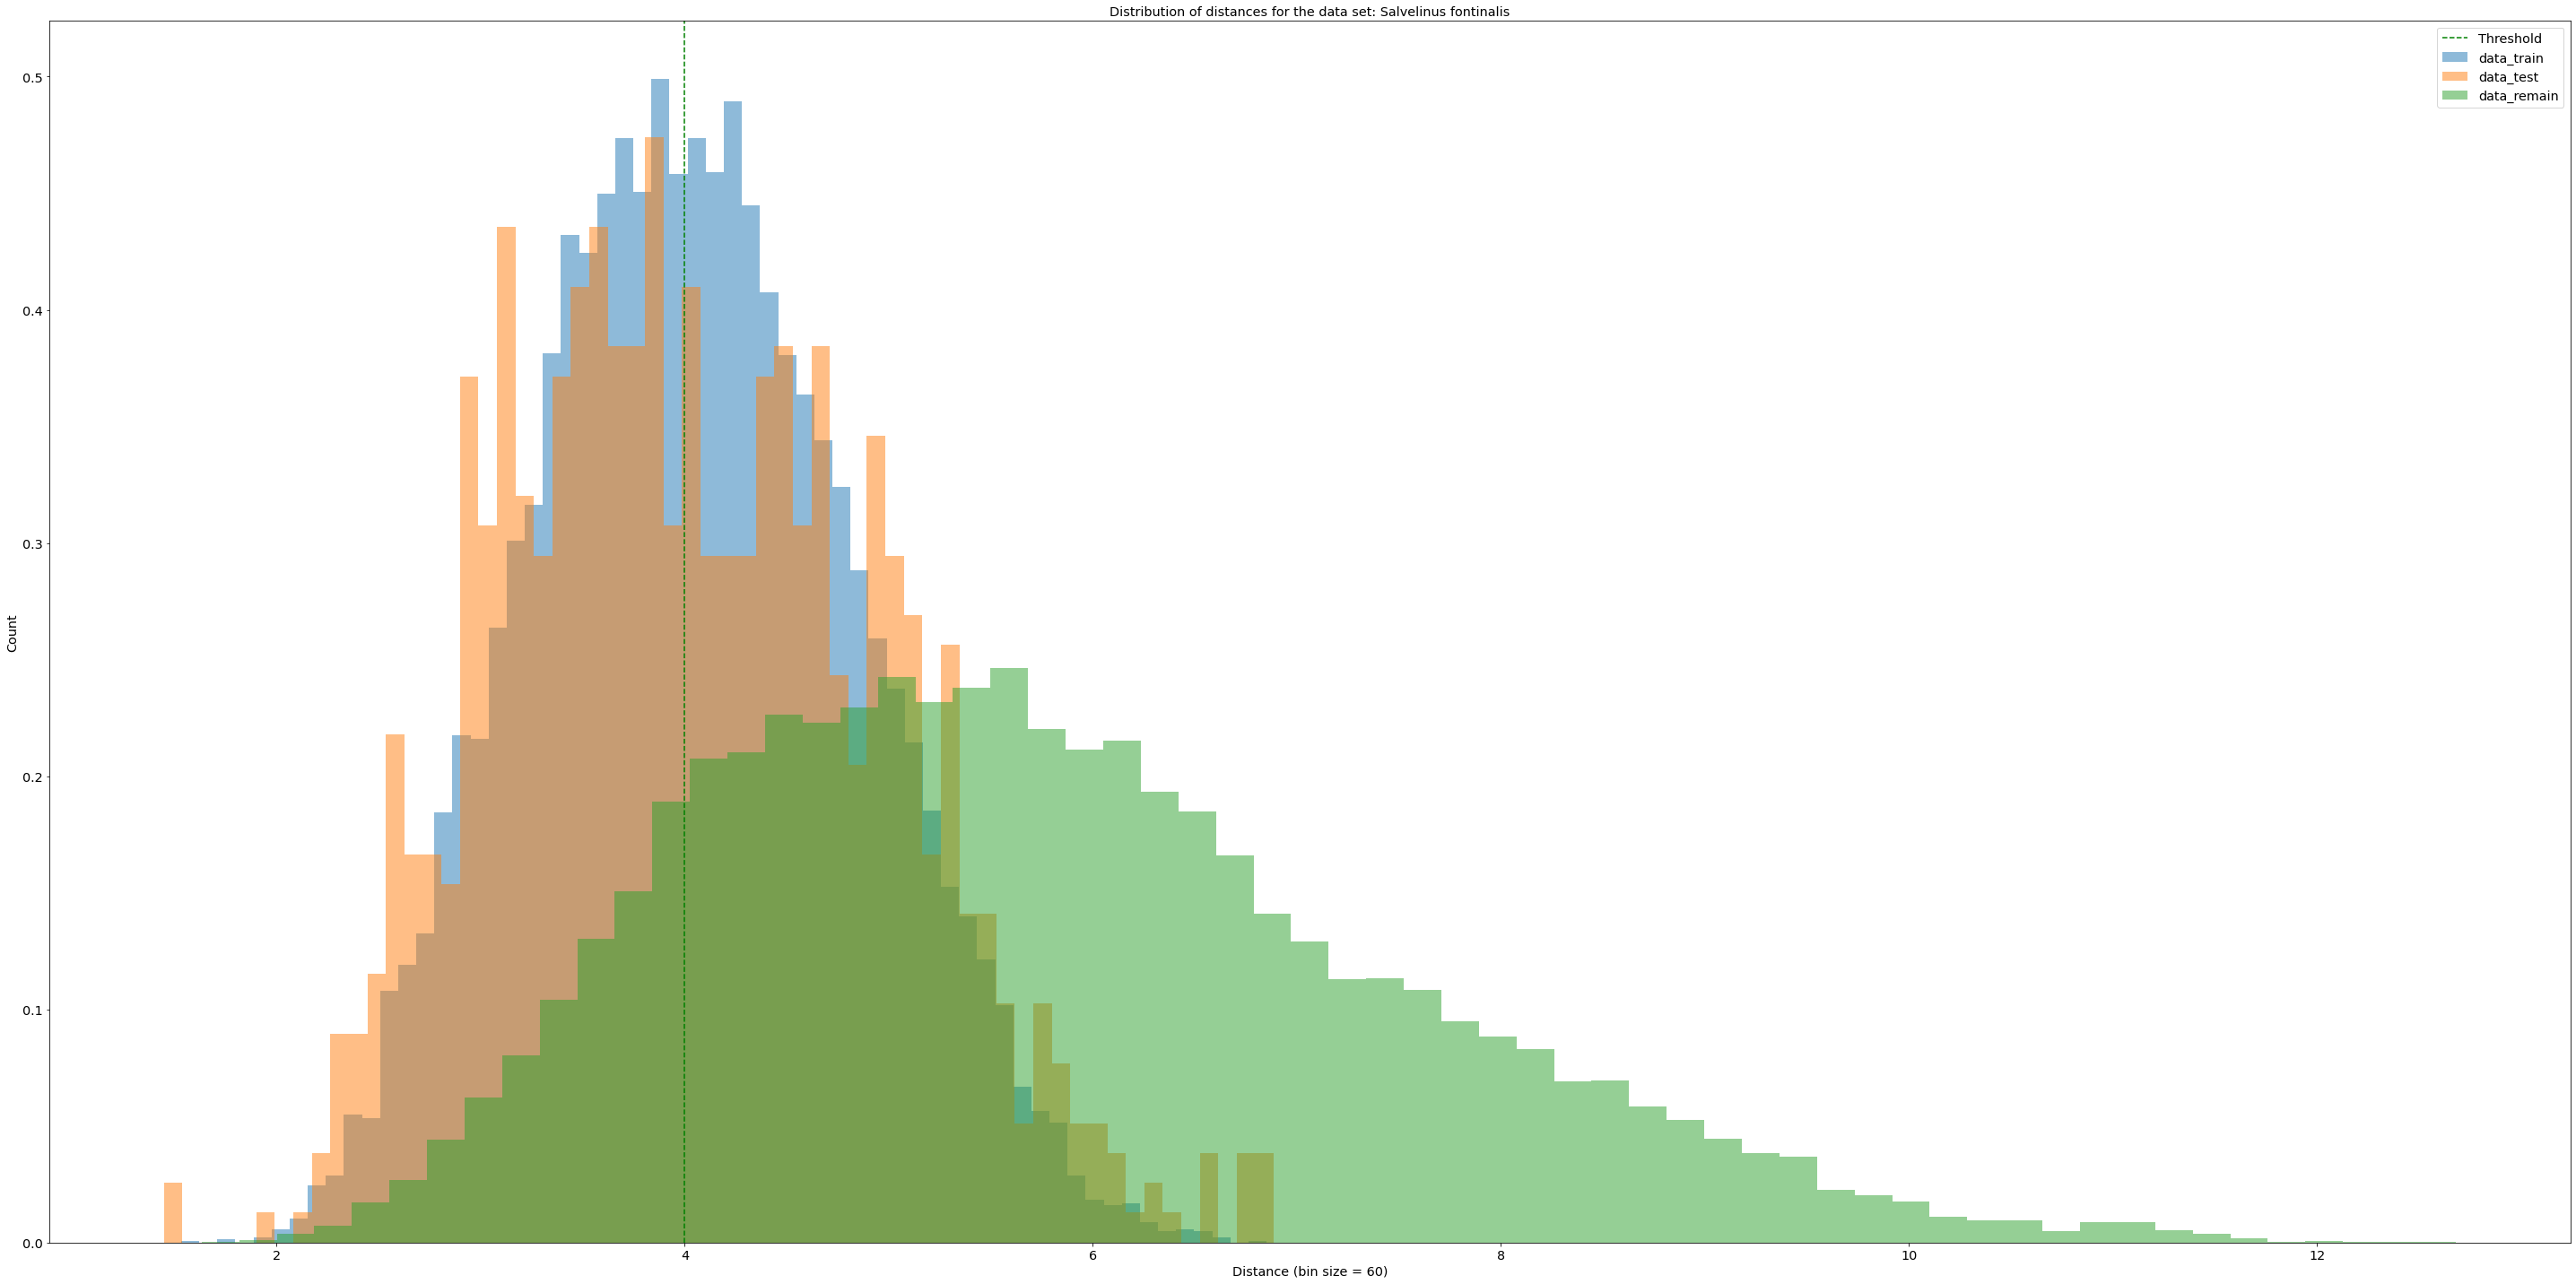

Train: 10302 Test: 600 Remain: 0


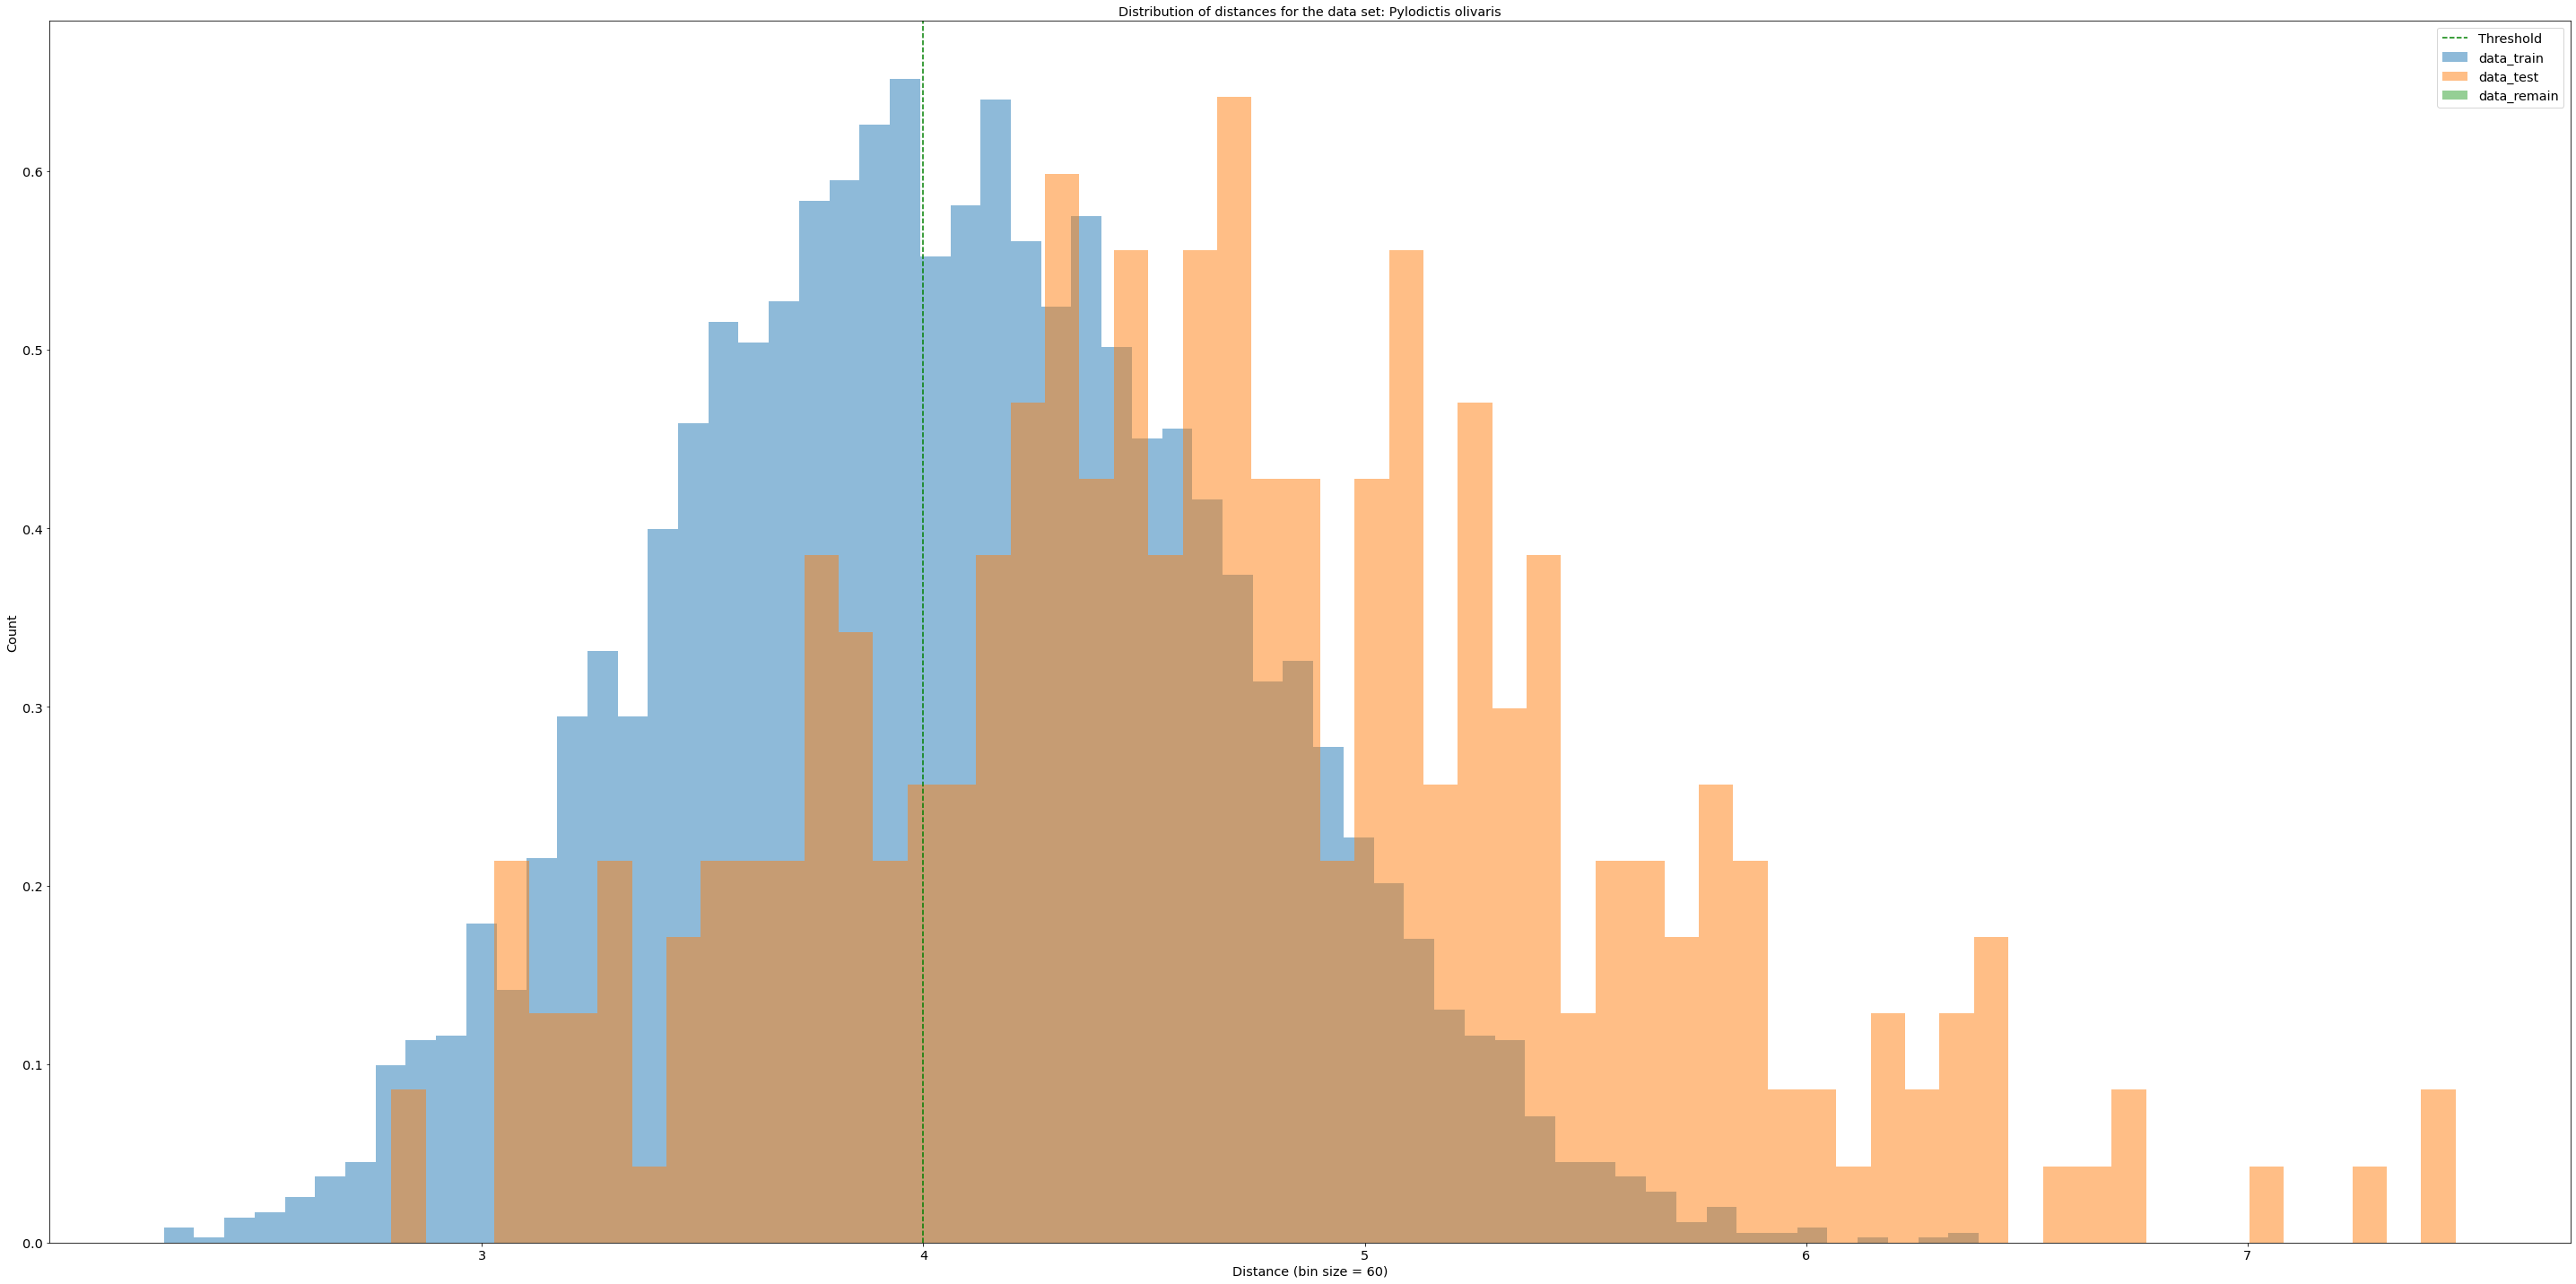

Train: 21756 Test: 1332 Remain: 0


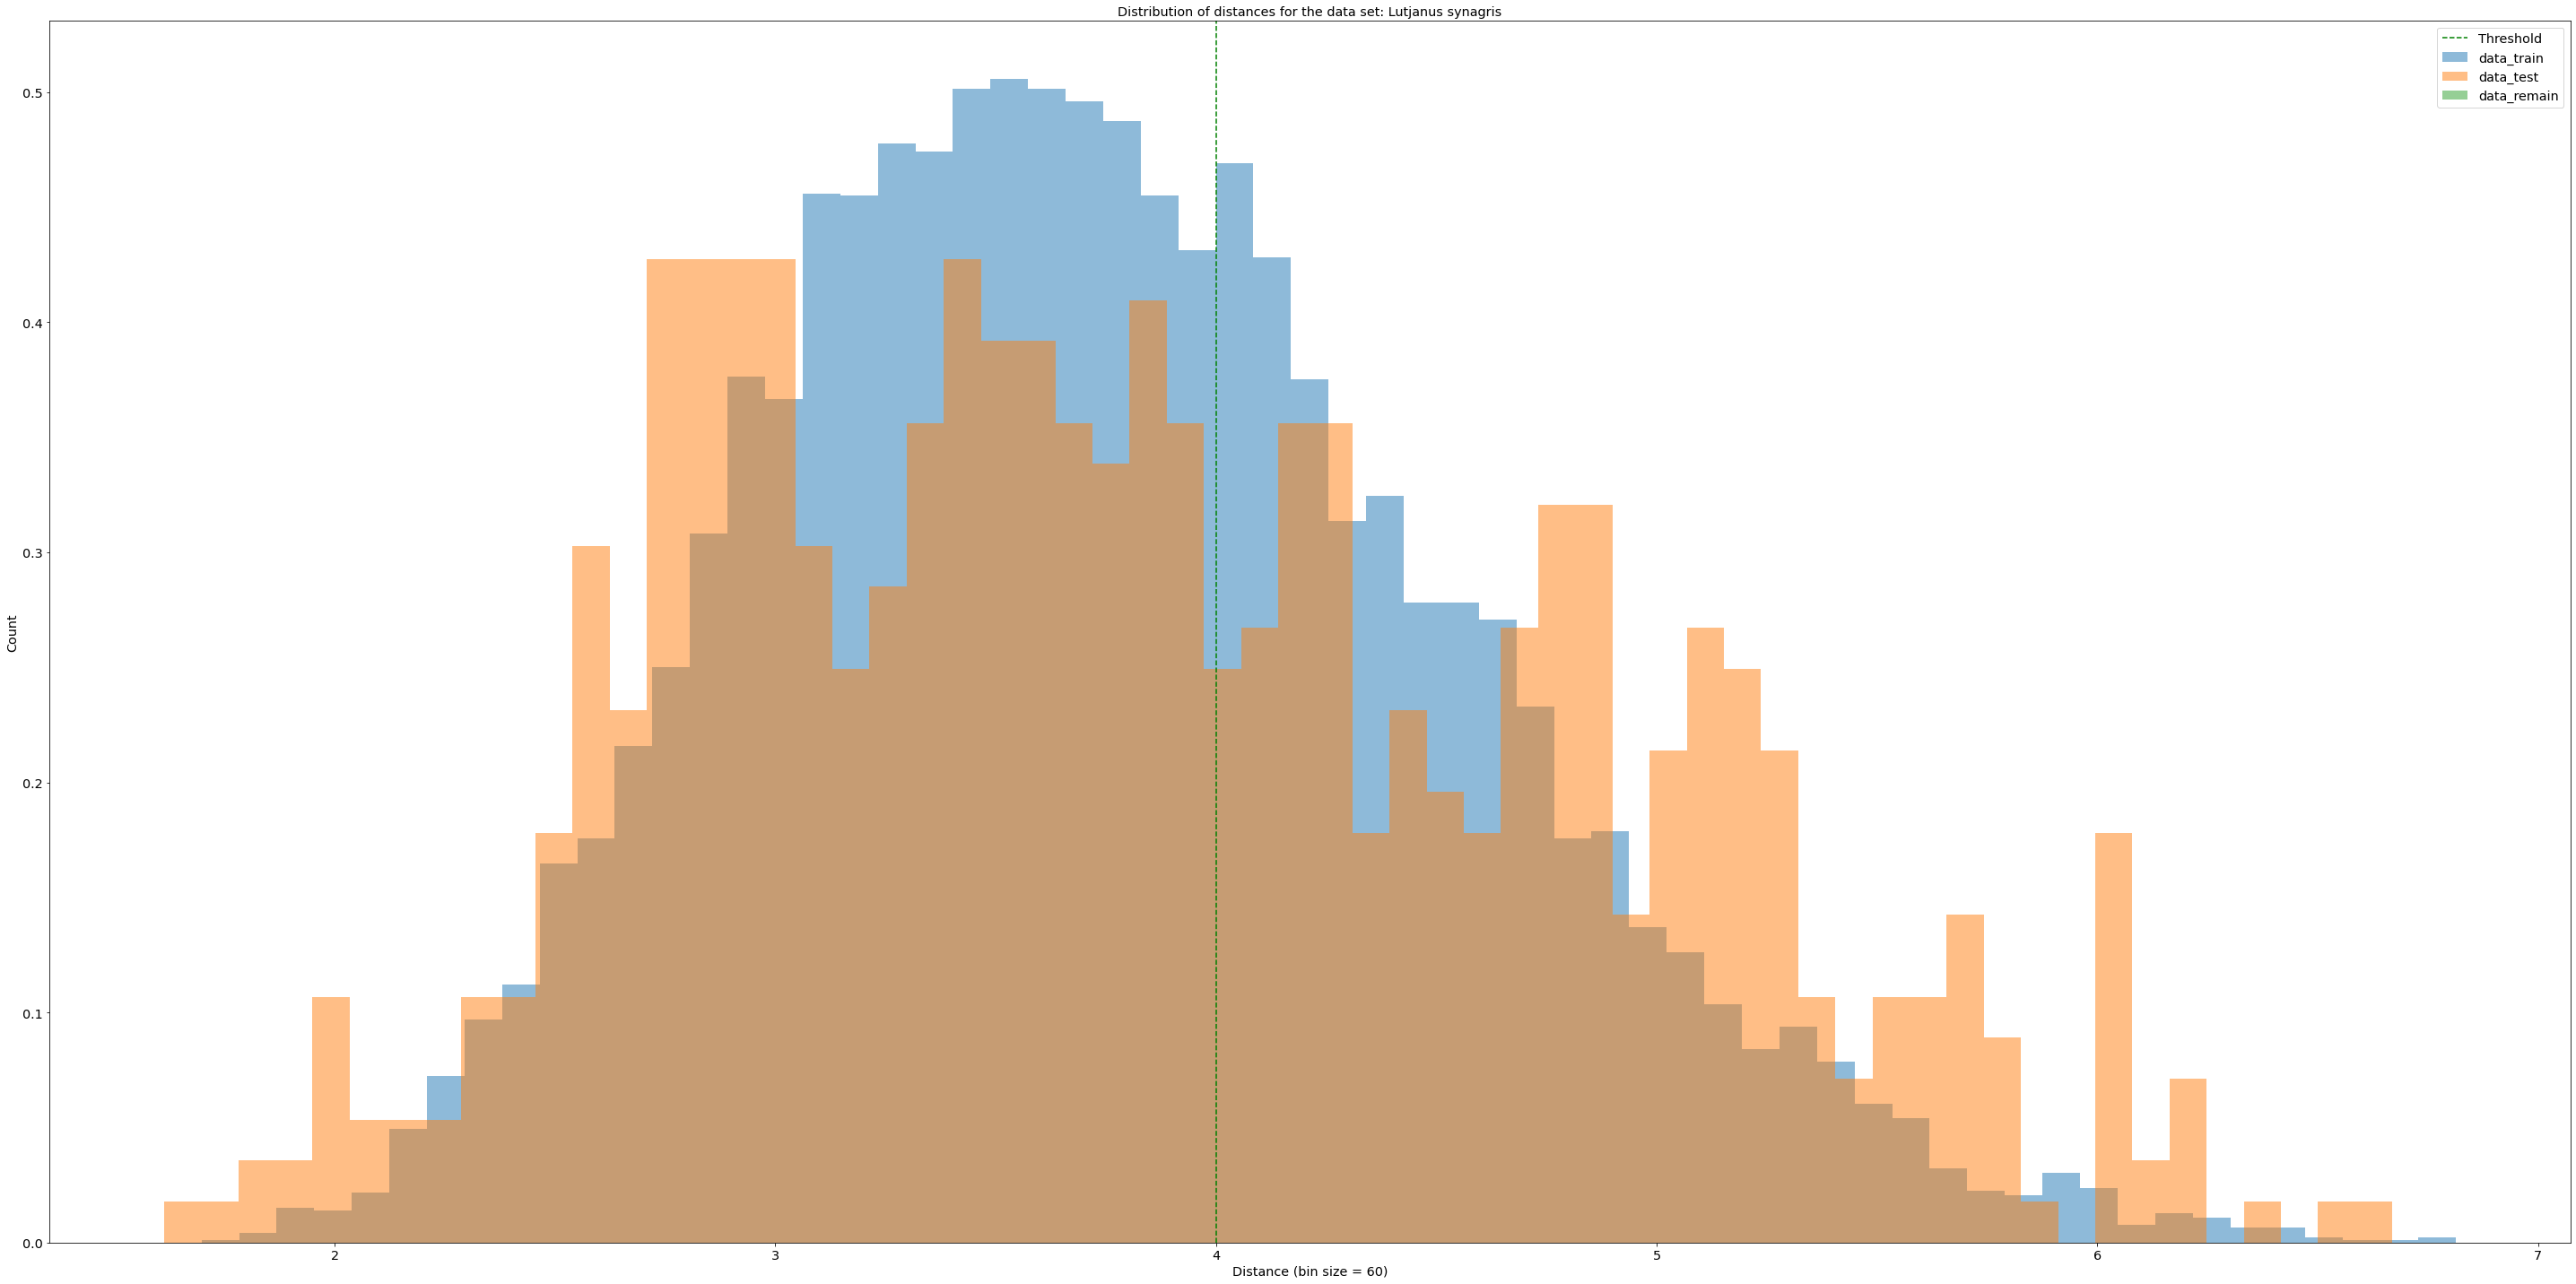

Train: 11130 Test: 650 Remain: 0


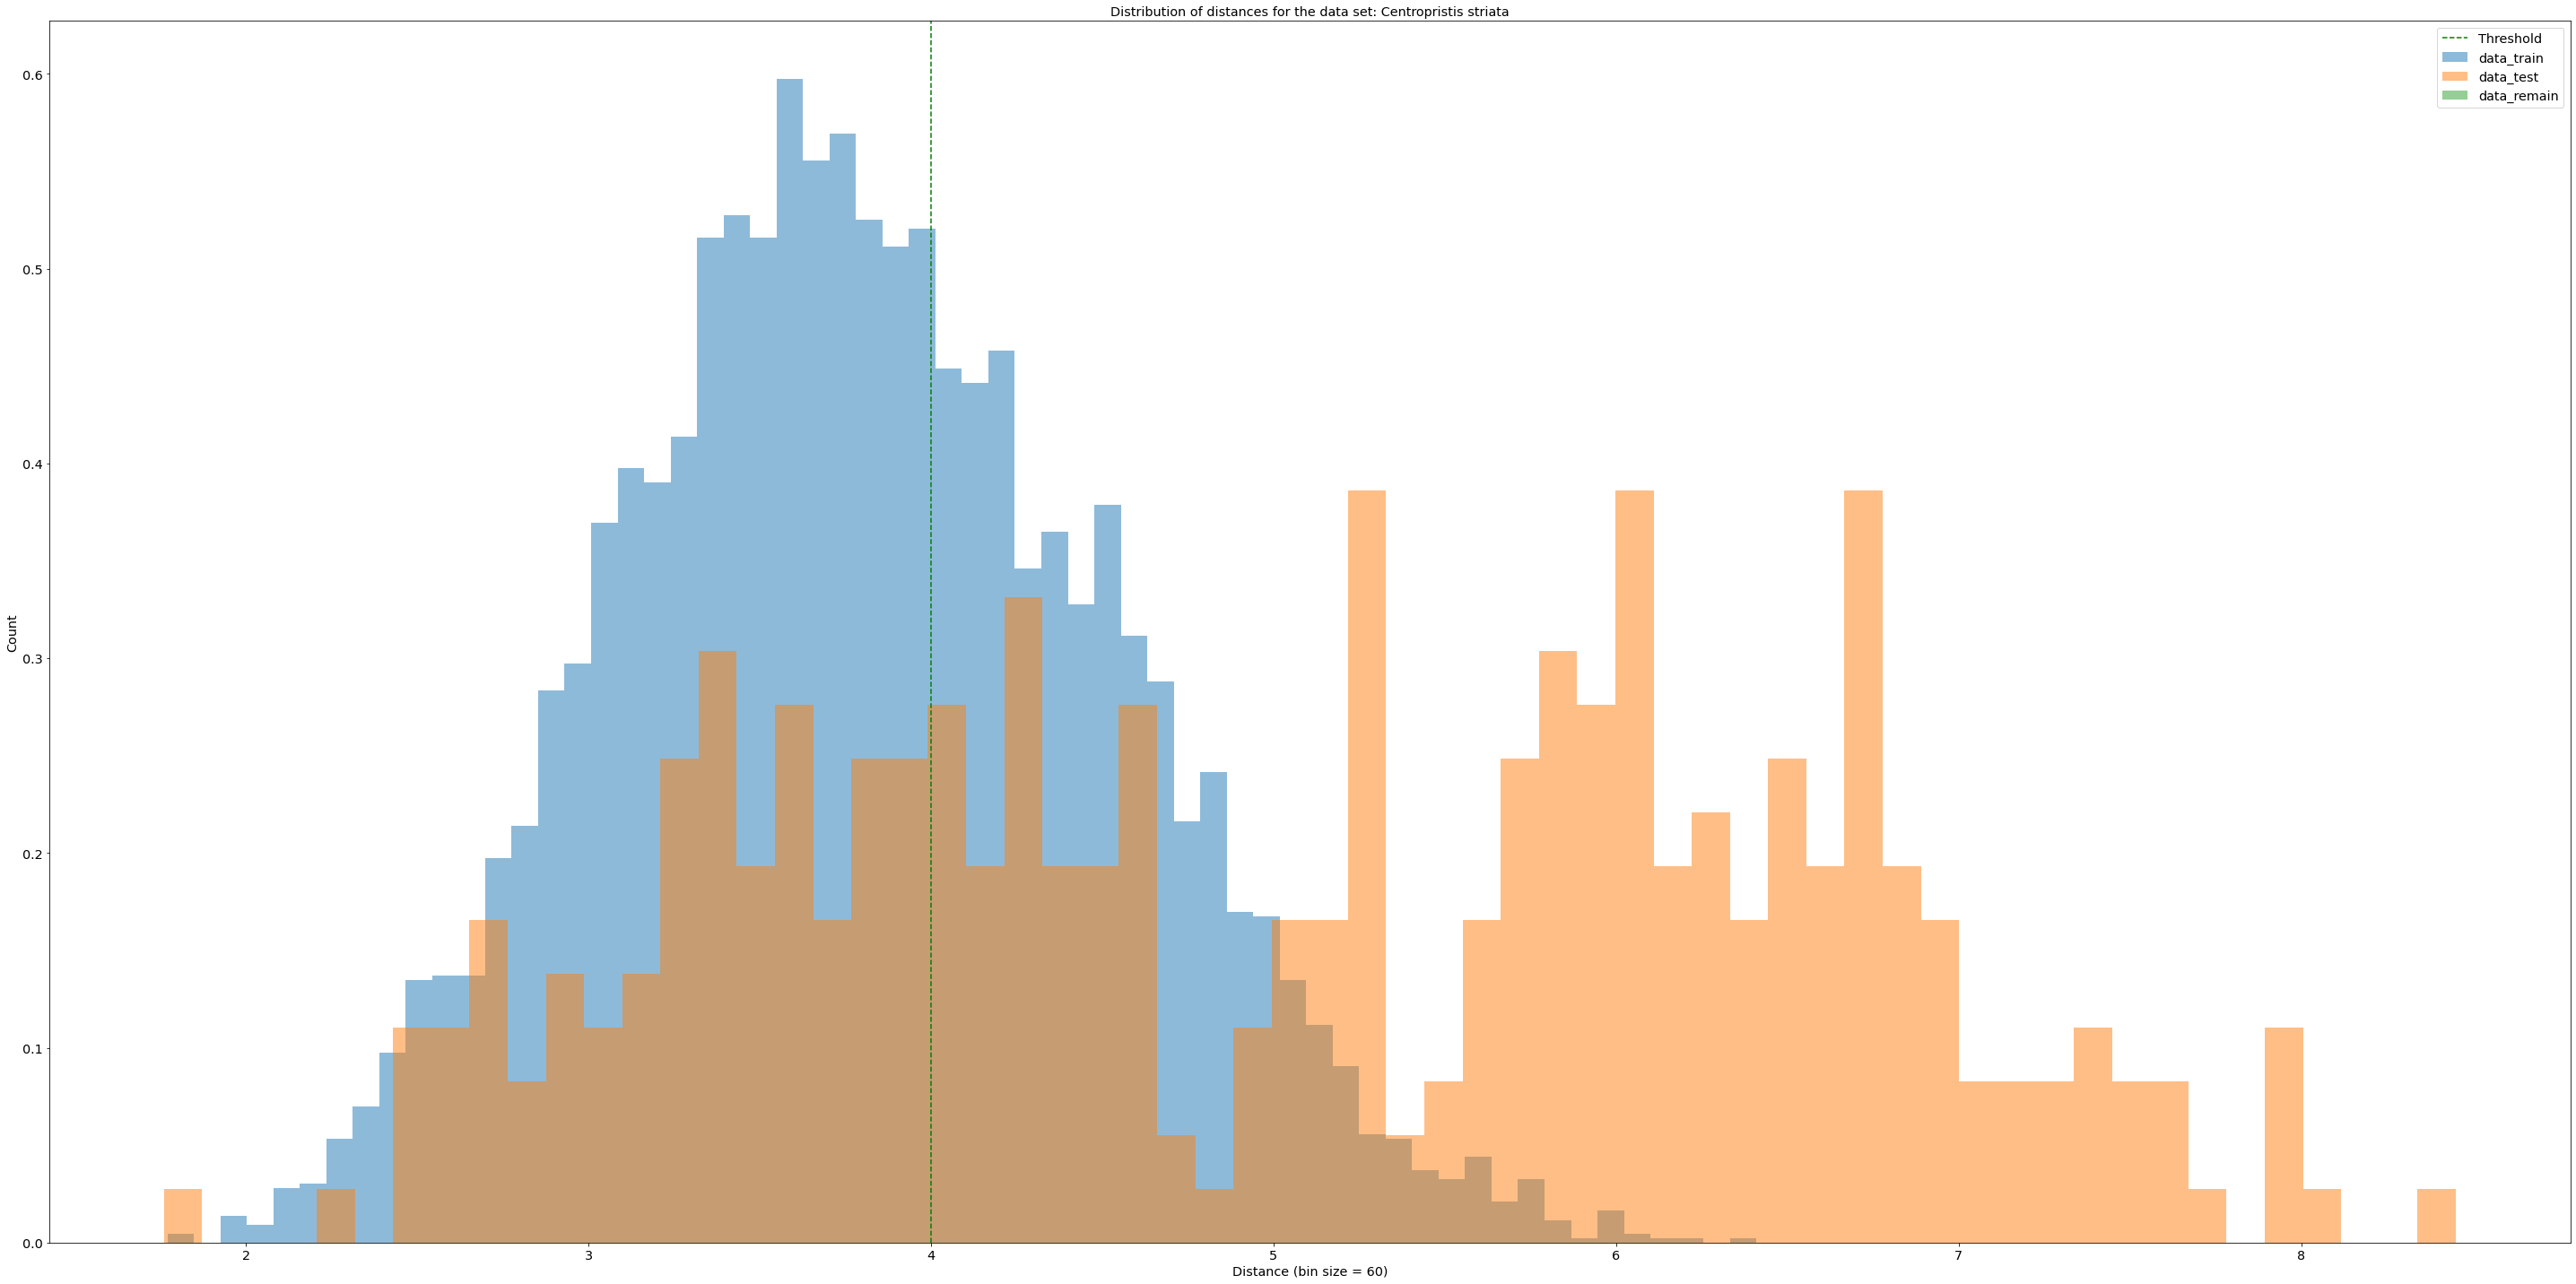

Train: 28392 Test: 1722 Remain: 281430


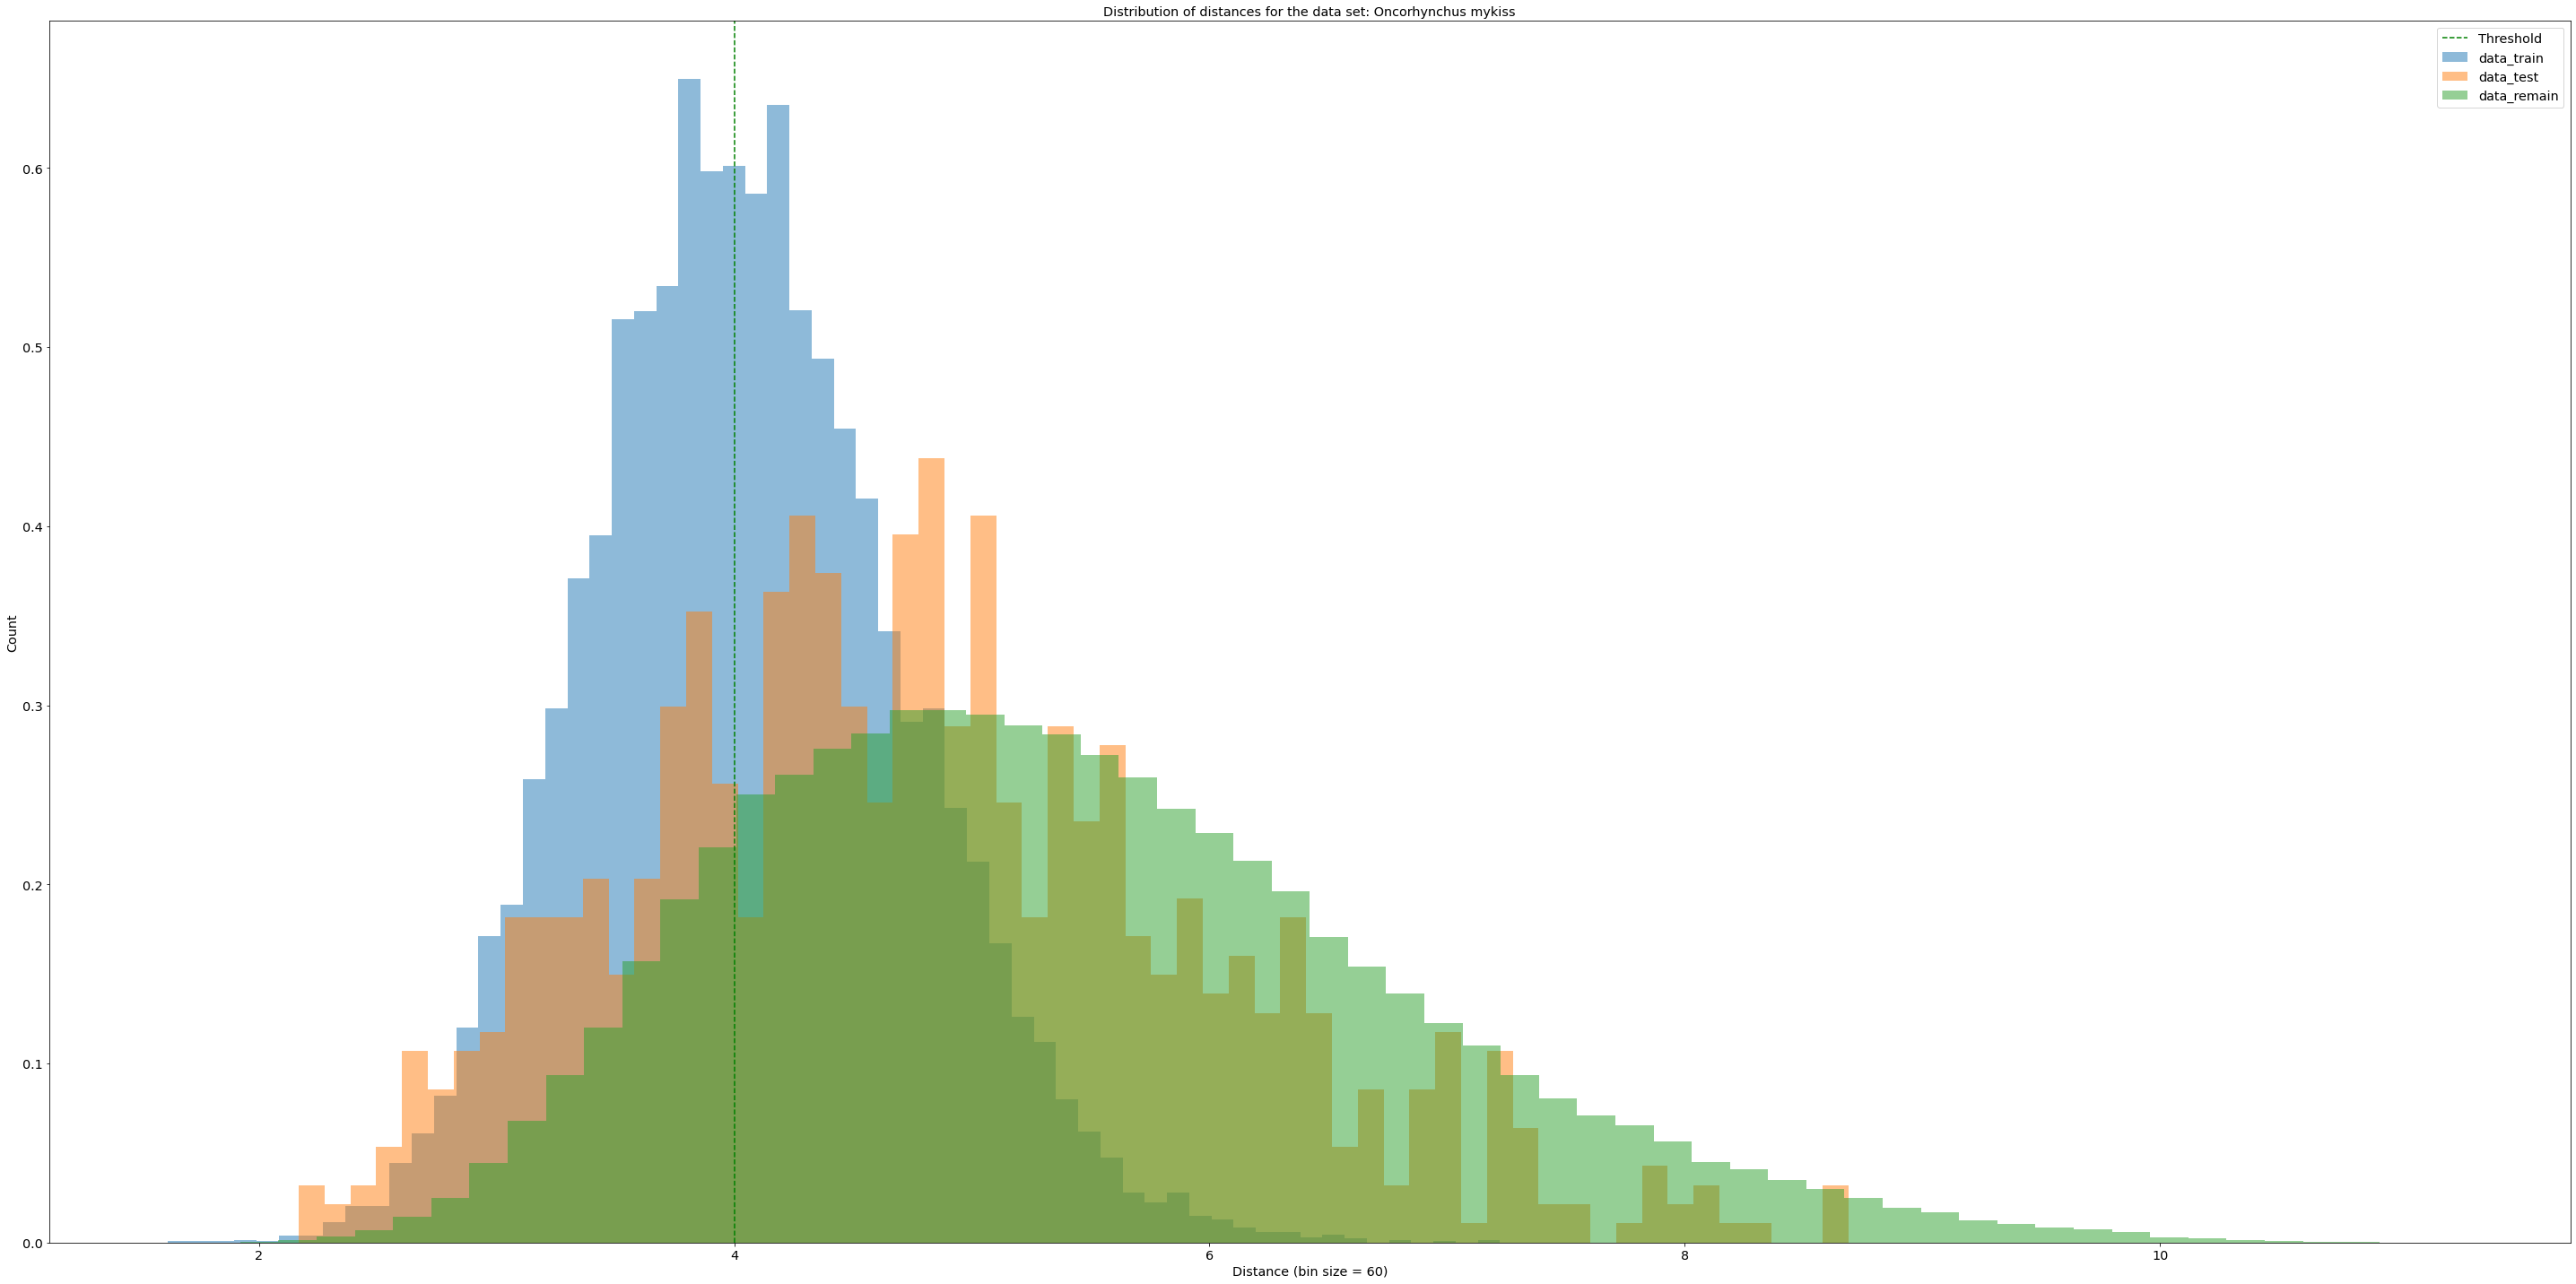

Train: 28392 Test: 1722 Remain: 17556


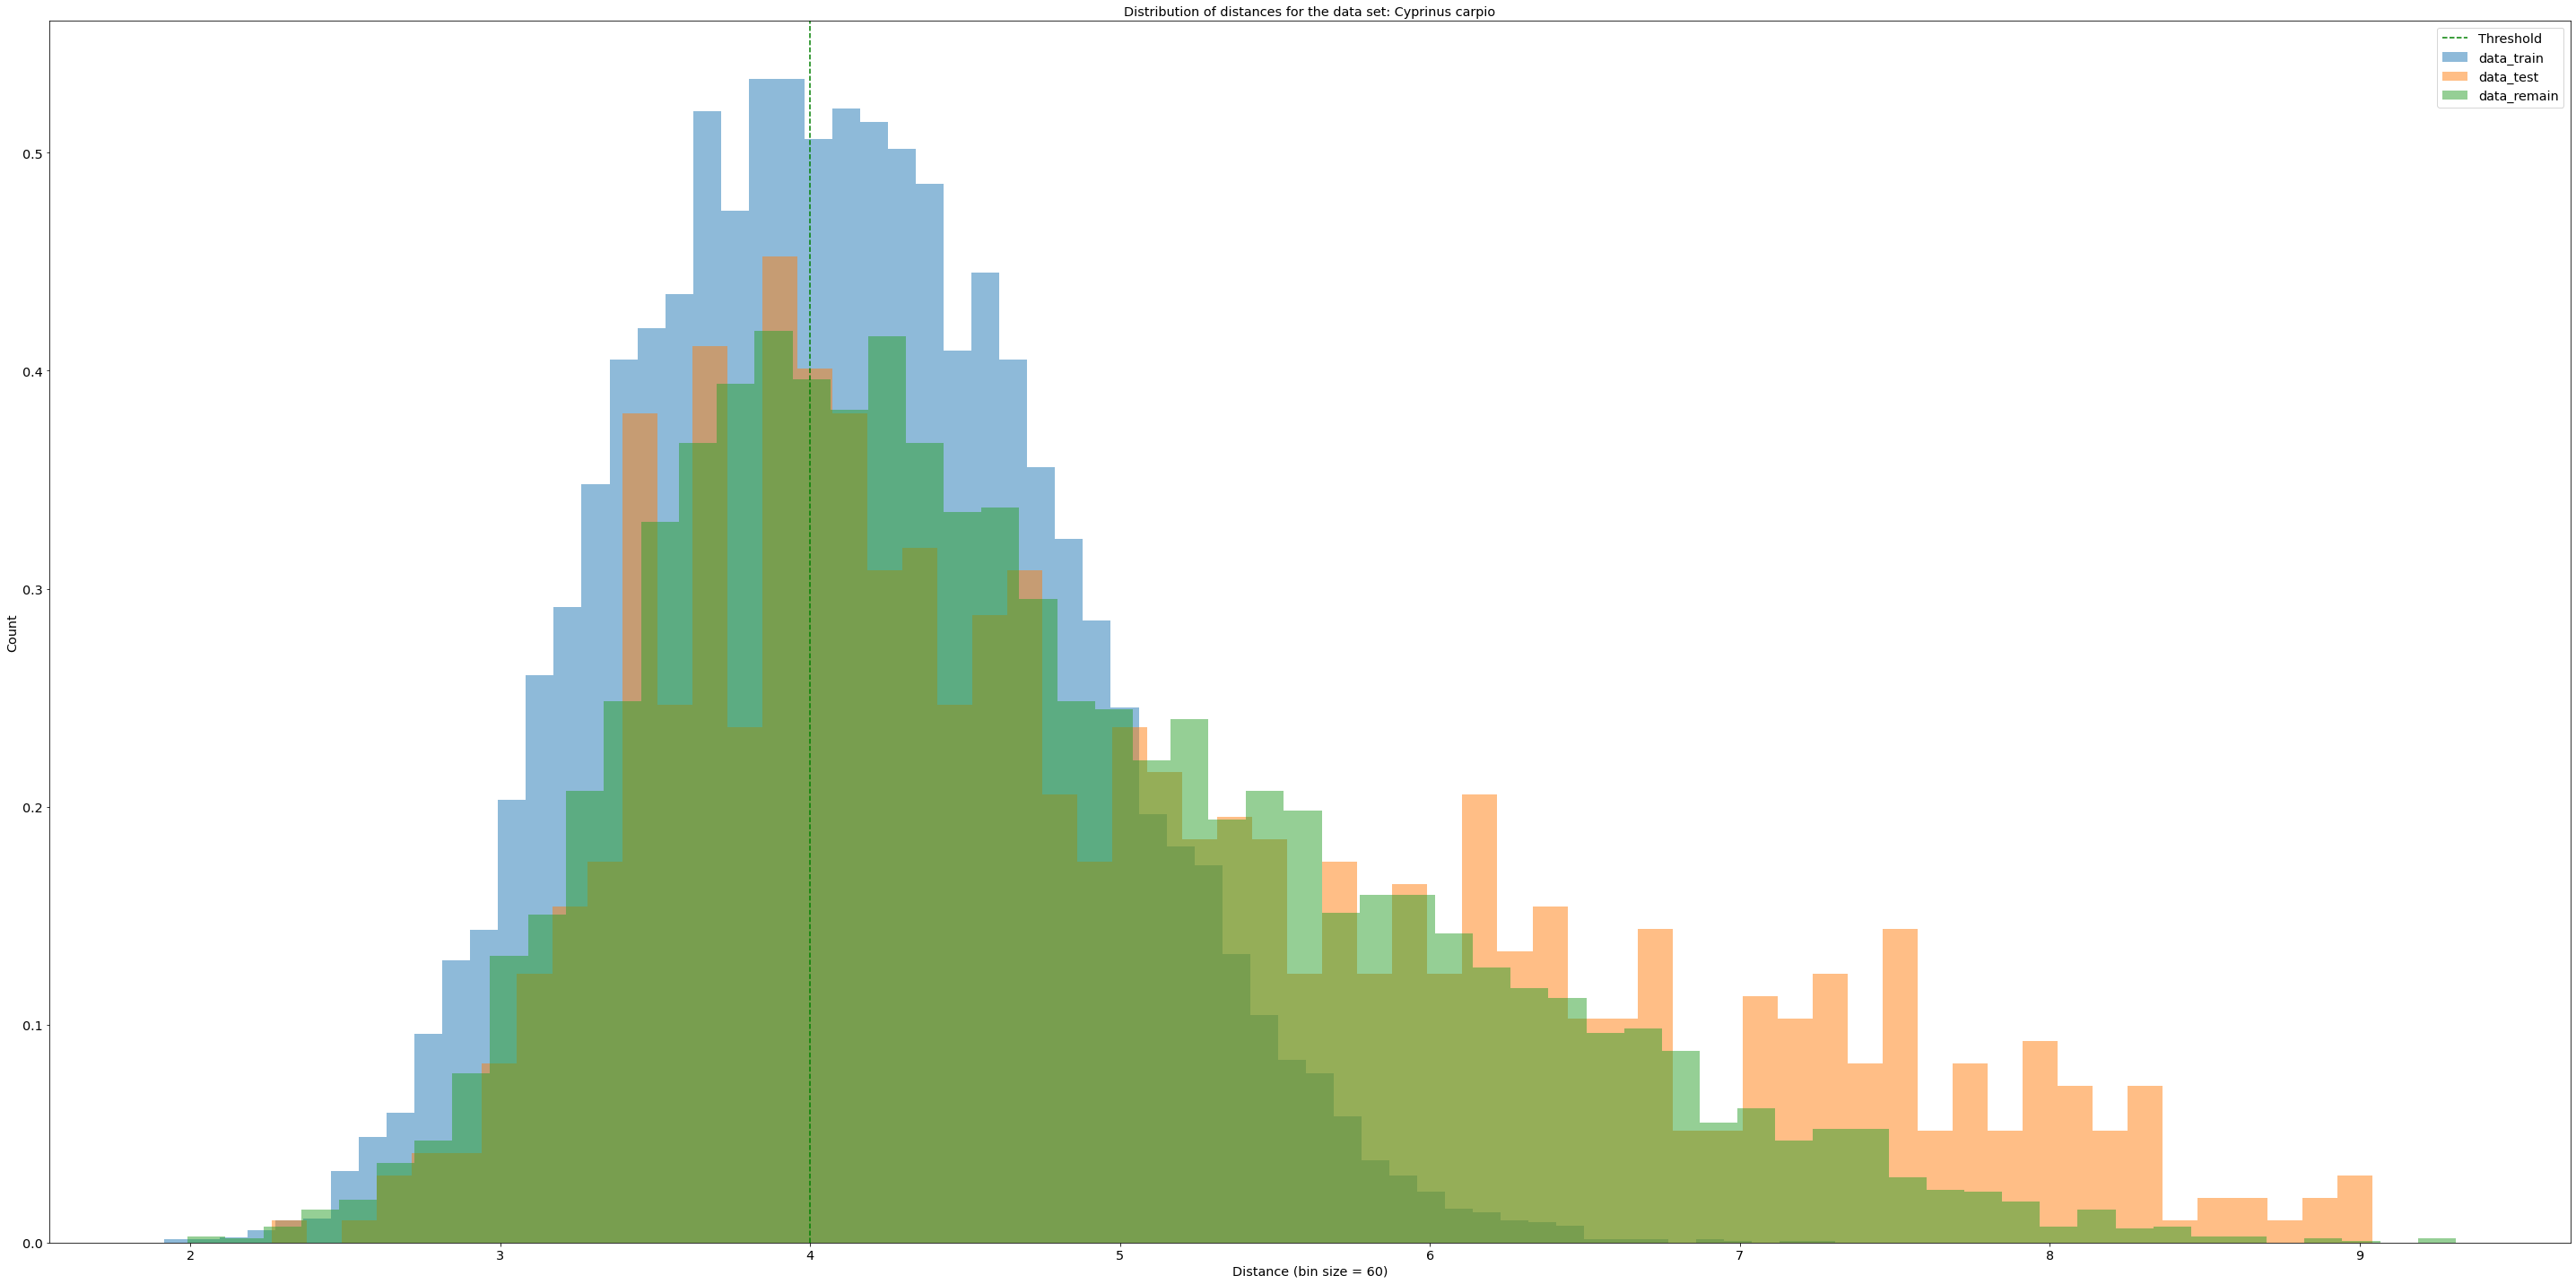

Train: 272 Test: 210 Remain: 0


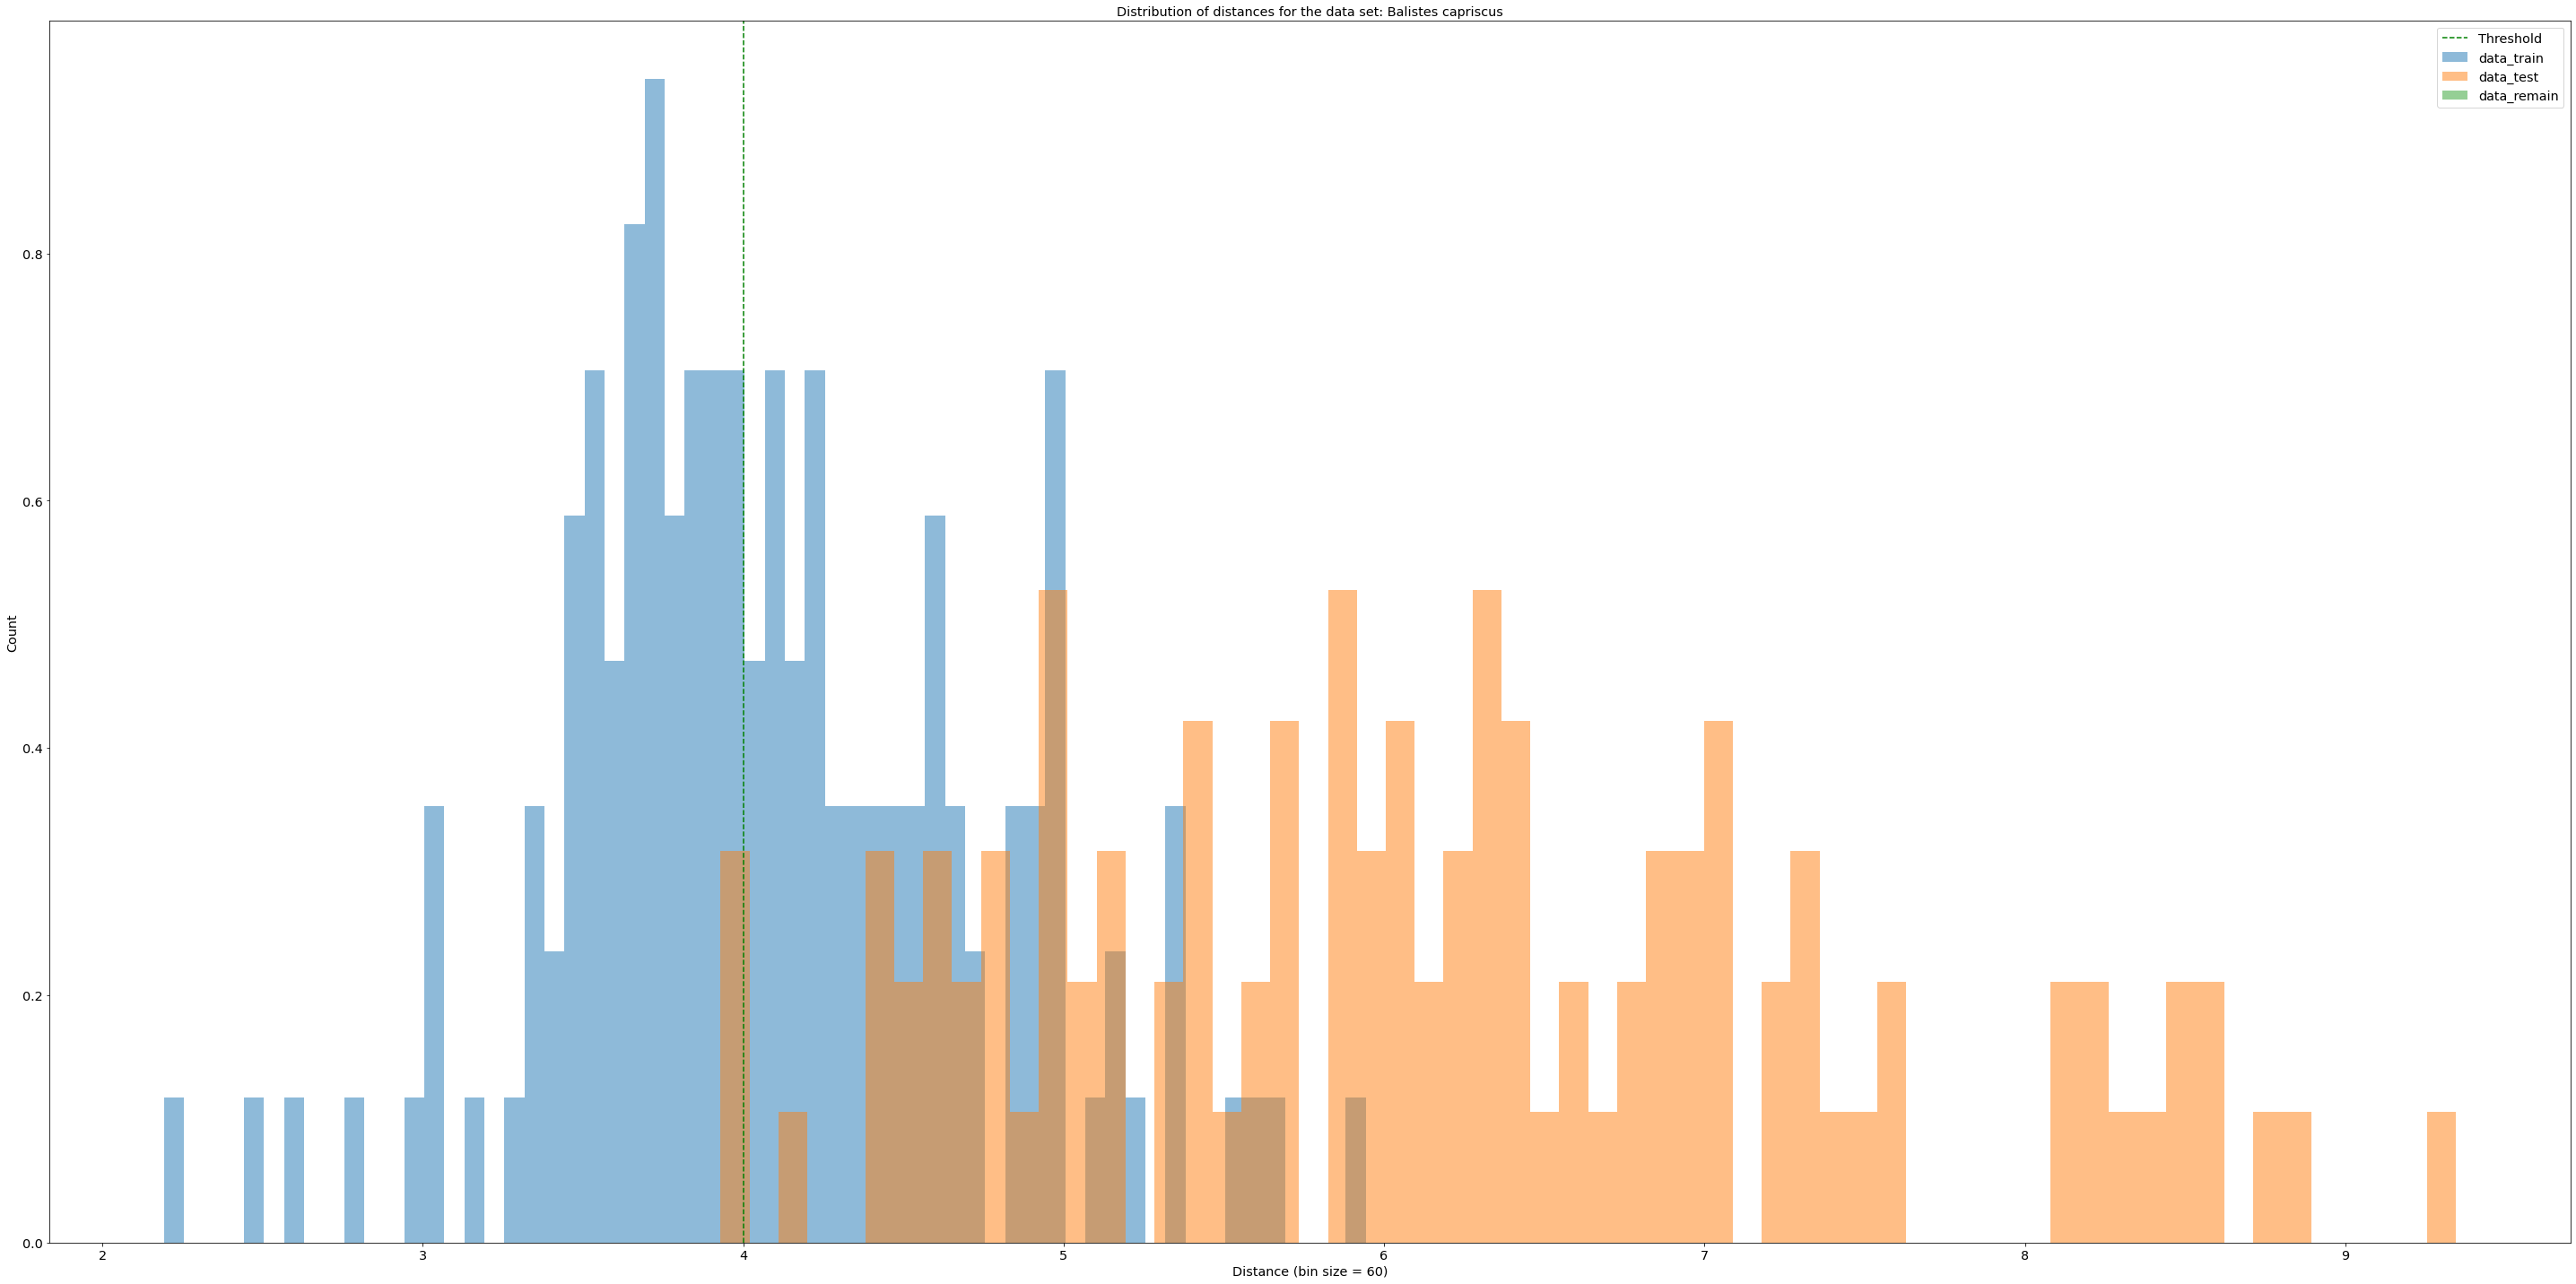

Train: 28392 Test: 1722 Remain: 15500


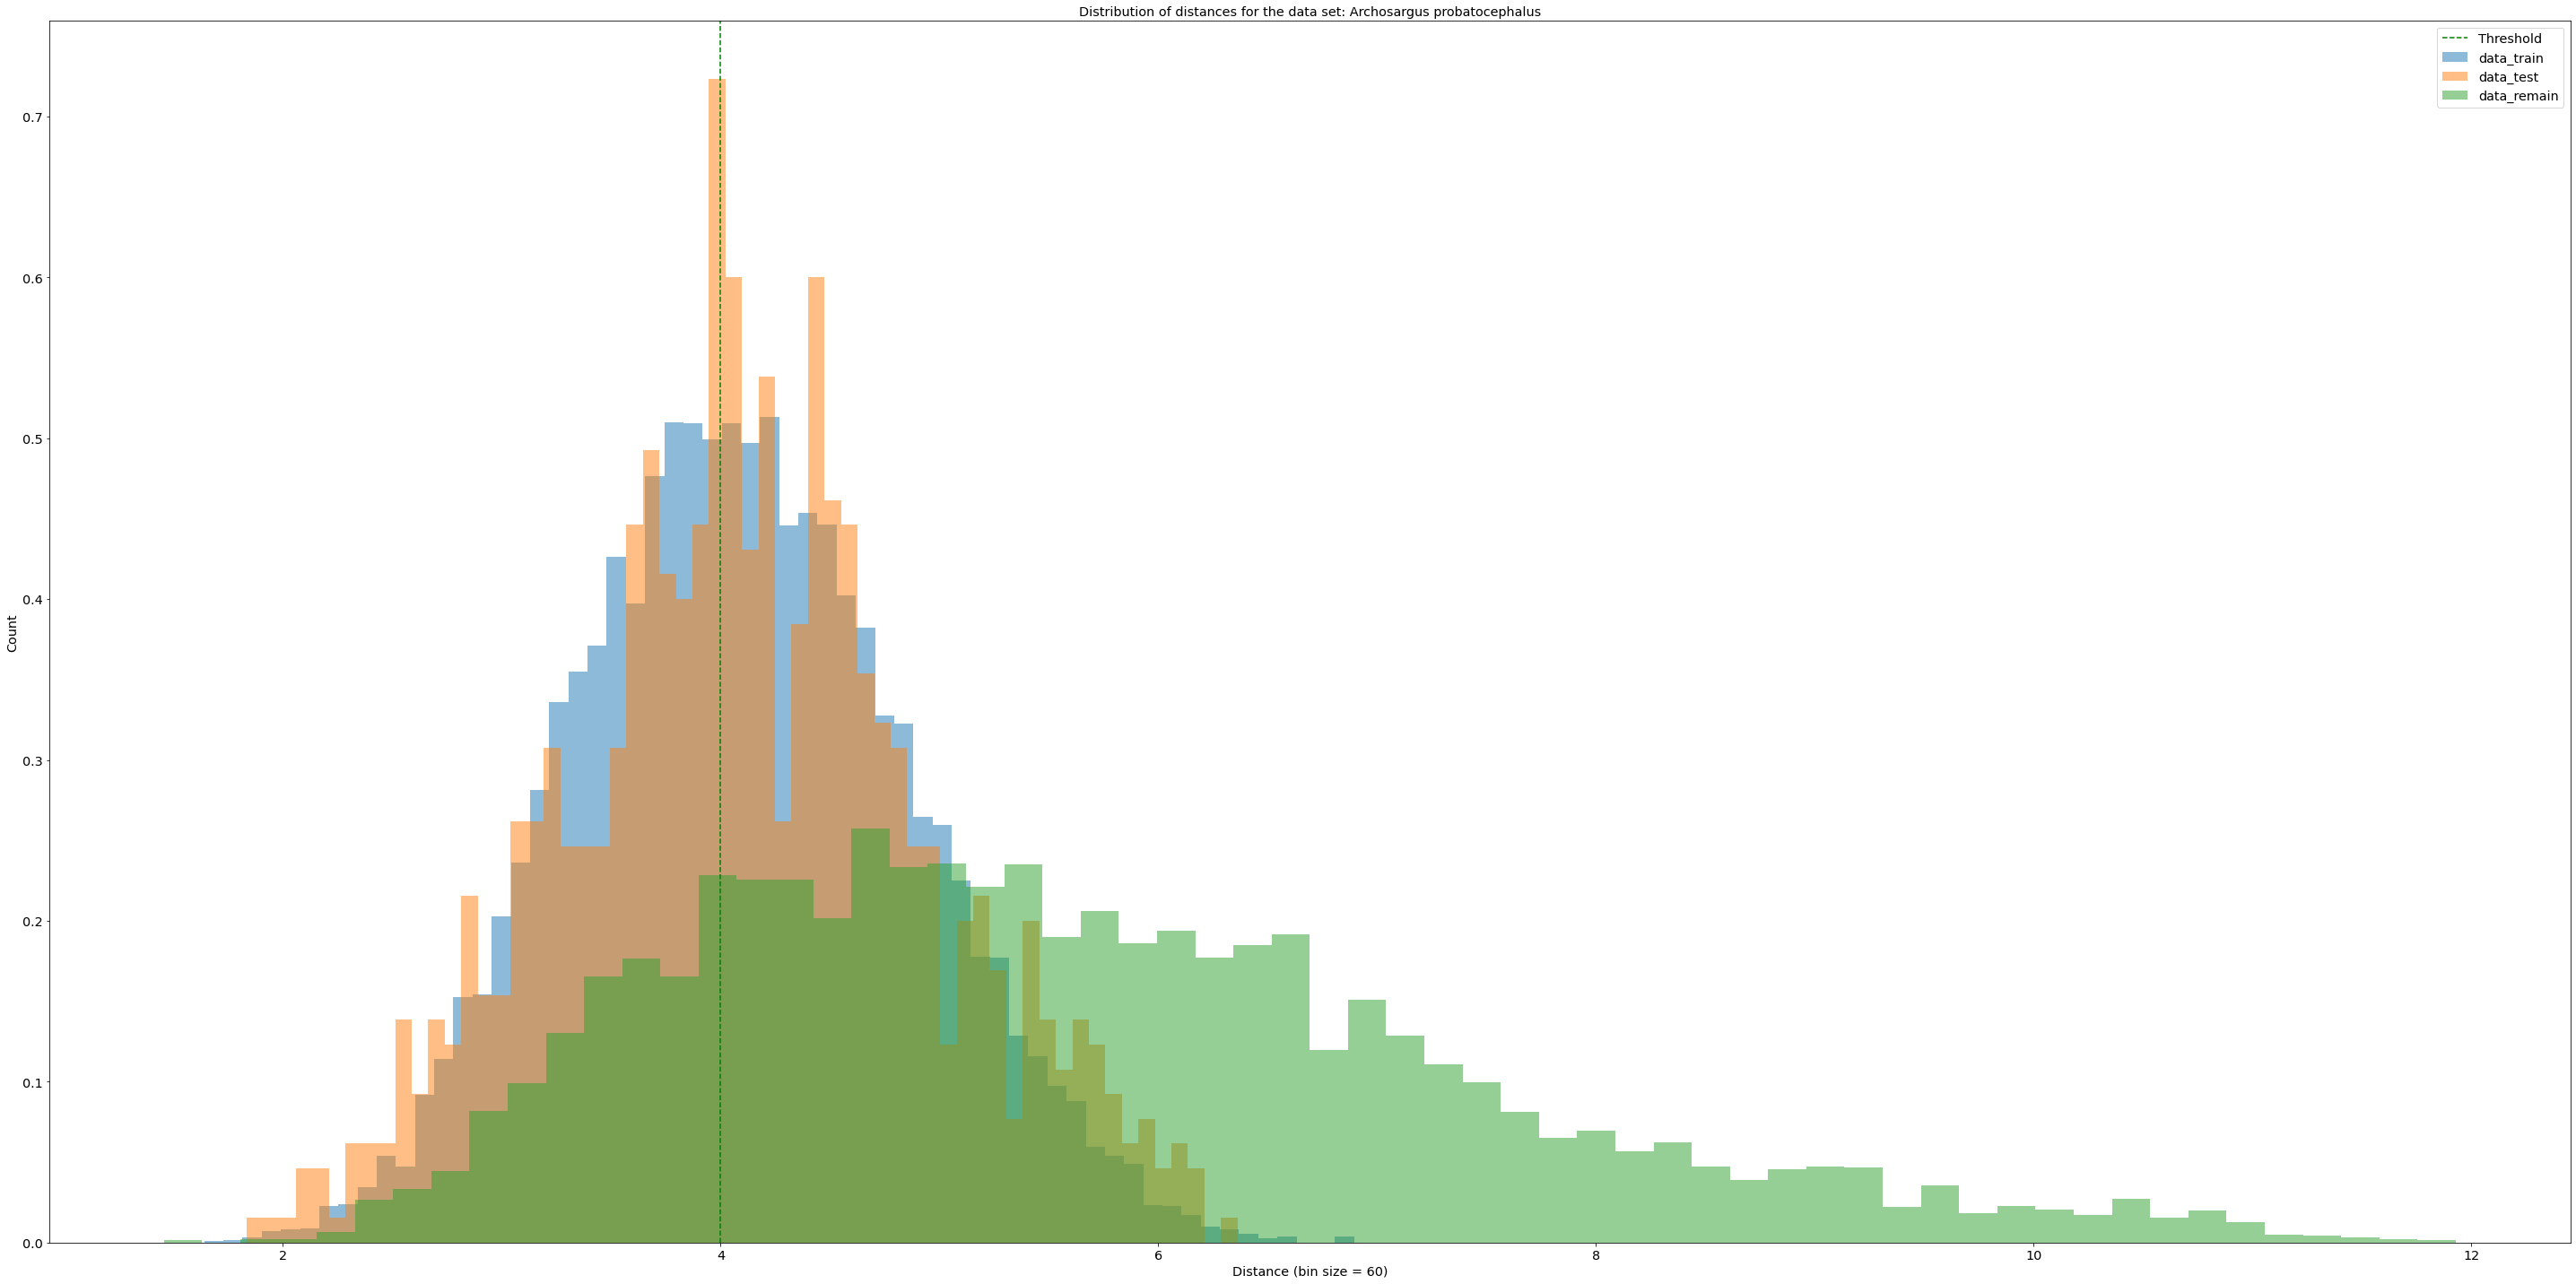

Train: 6642 Test: 380 Remain: 0


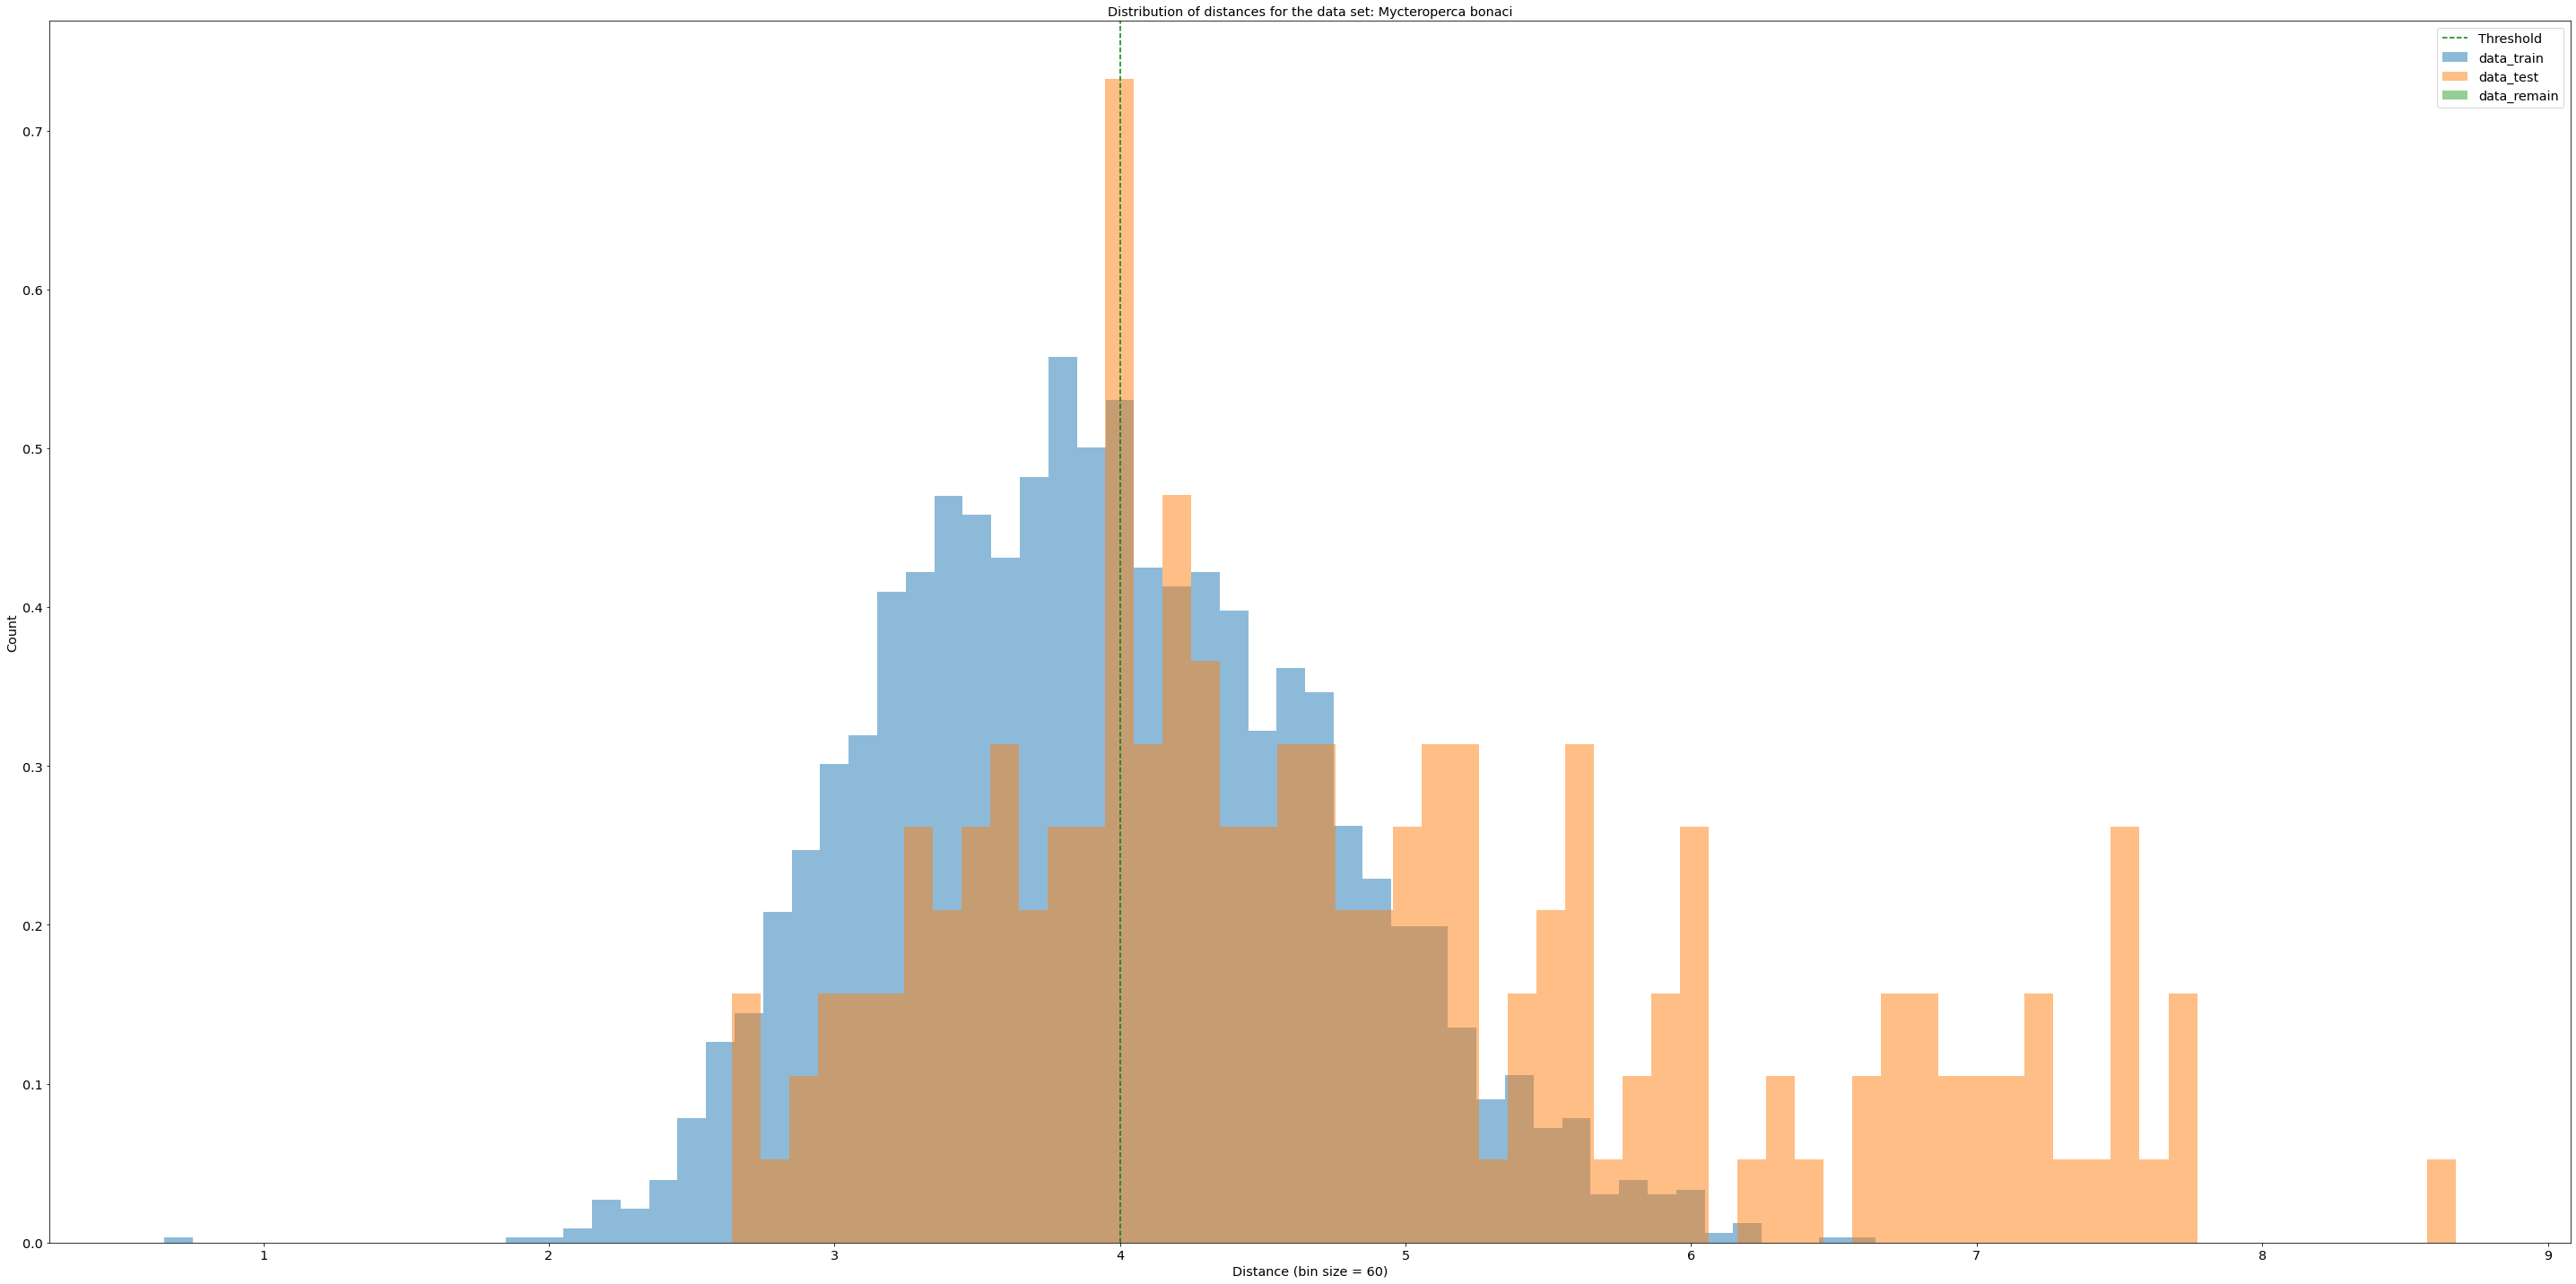

Train: 9900 Test: 600 Remain: 0


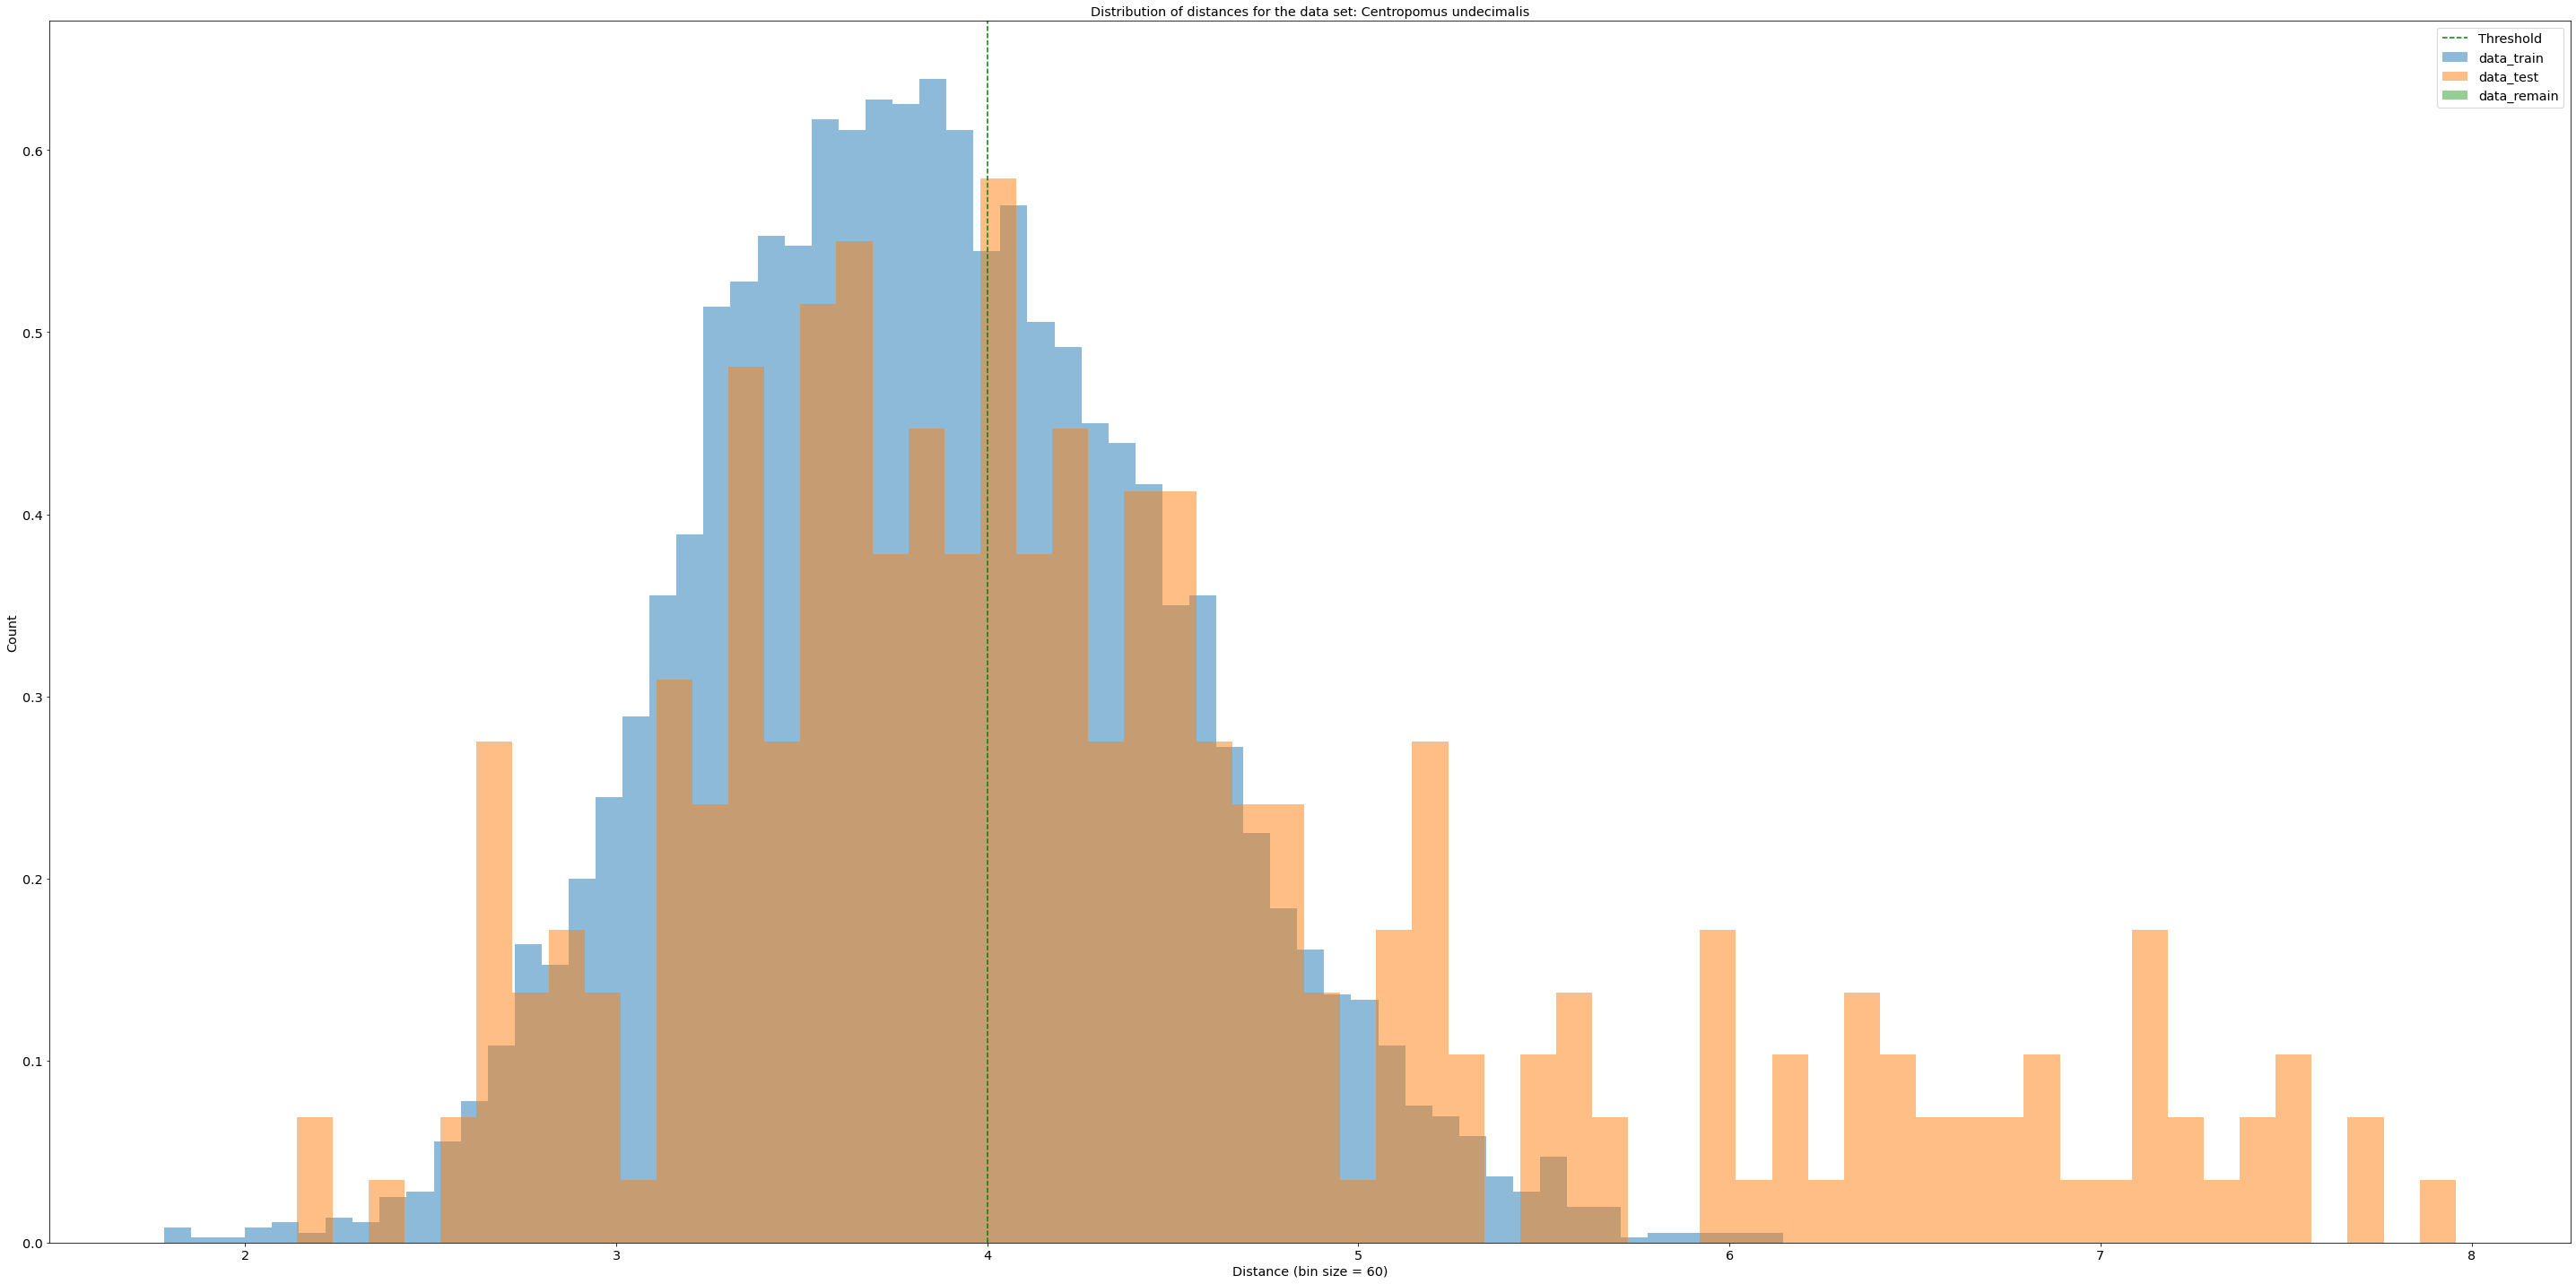

Train: 4970 Test: 306 Remain: 0


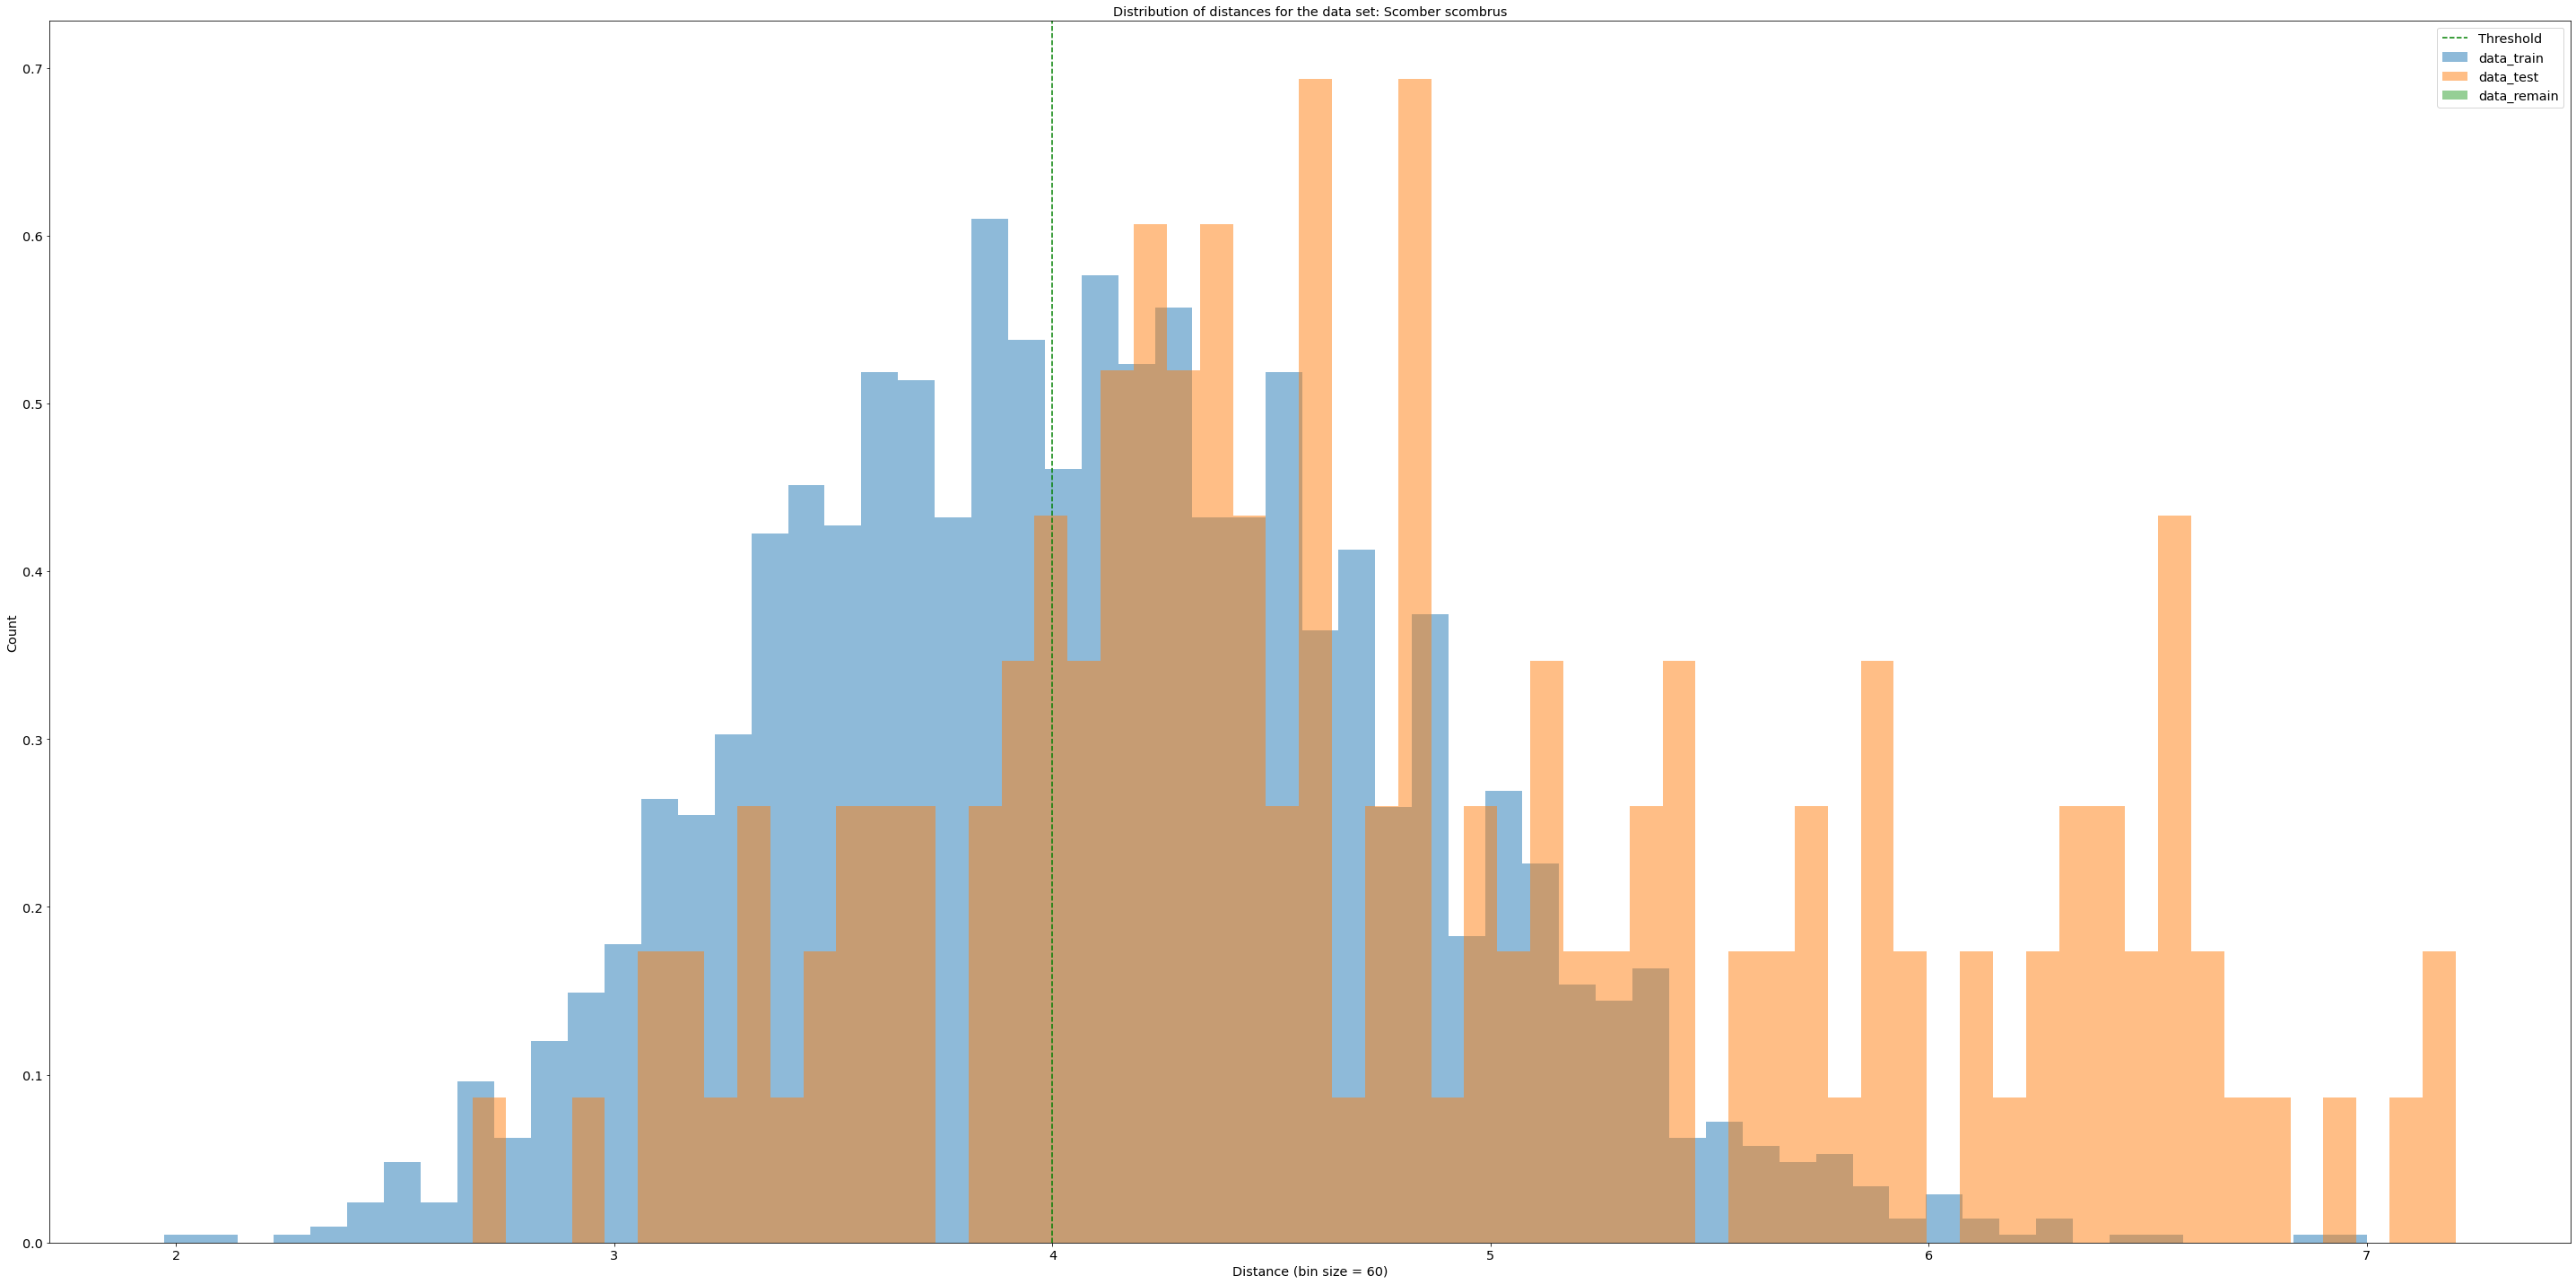

Train: 1190 Test: 210 Remain: 0


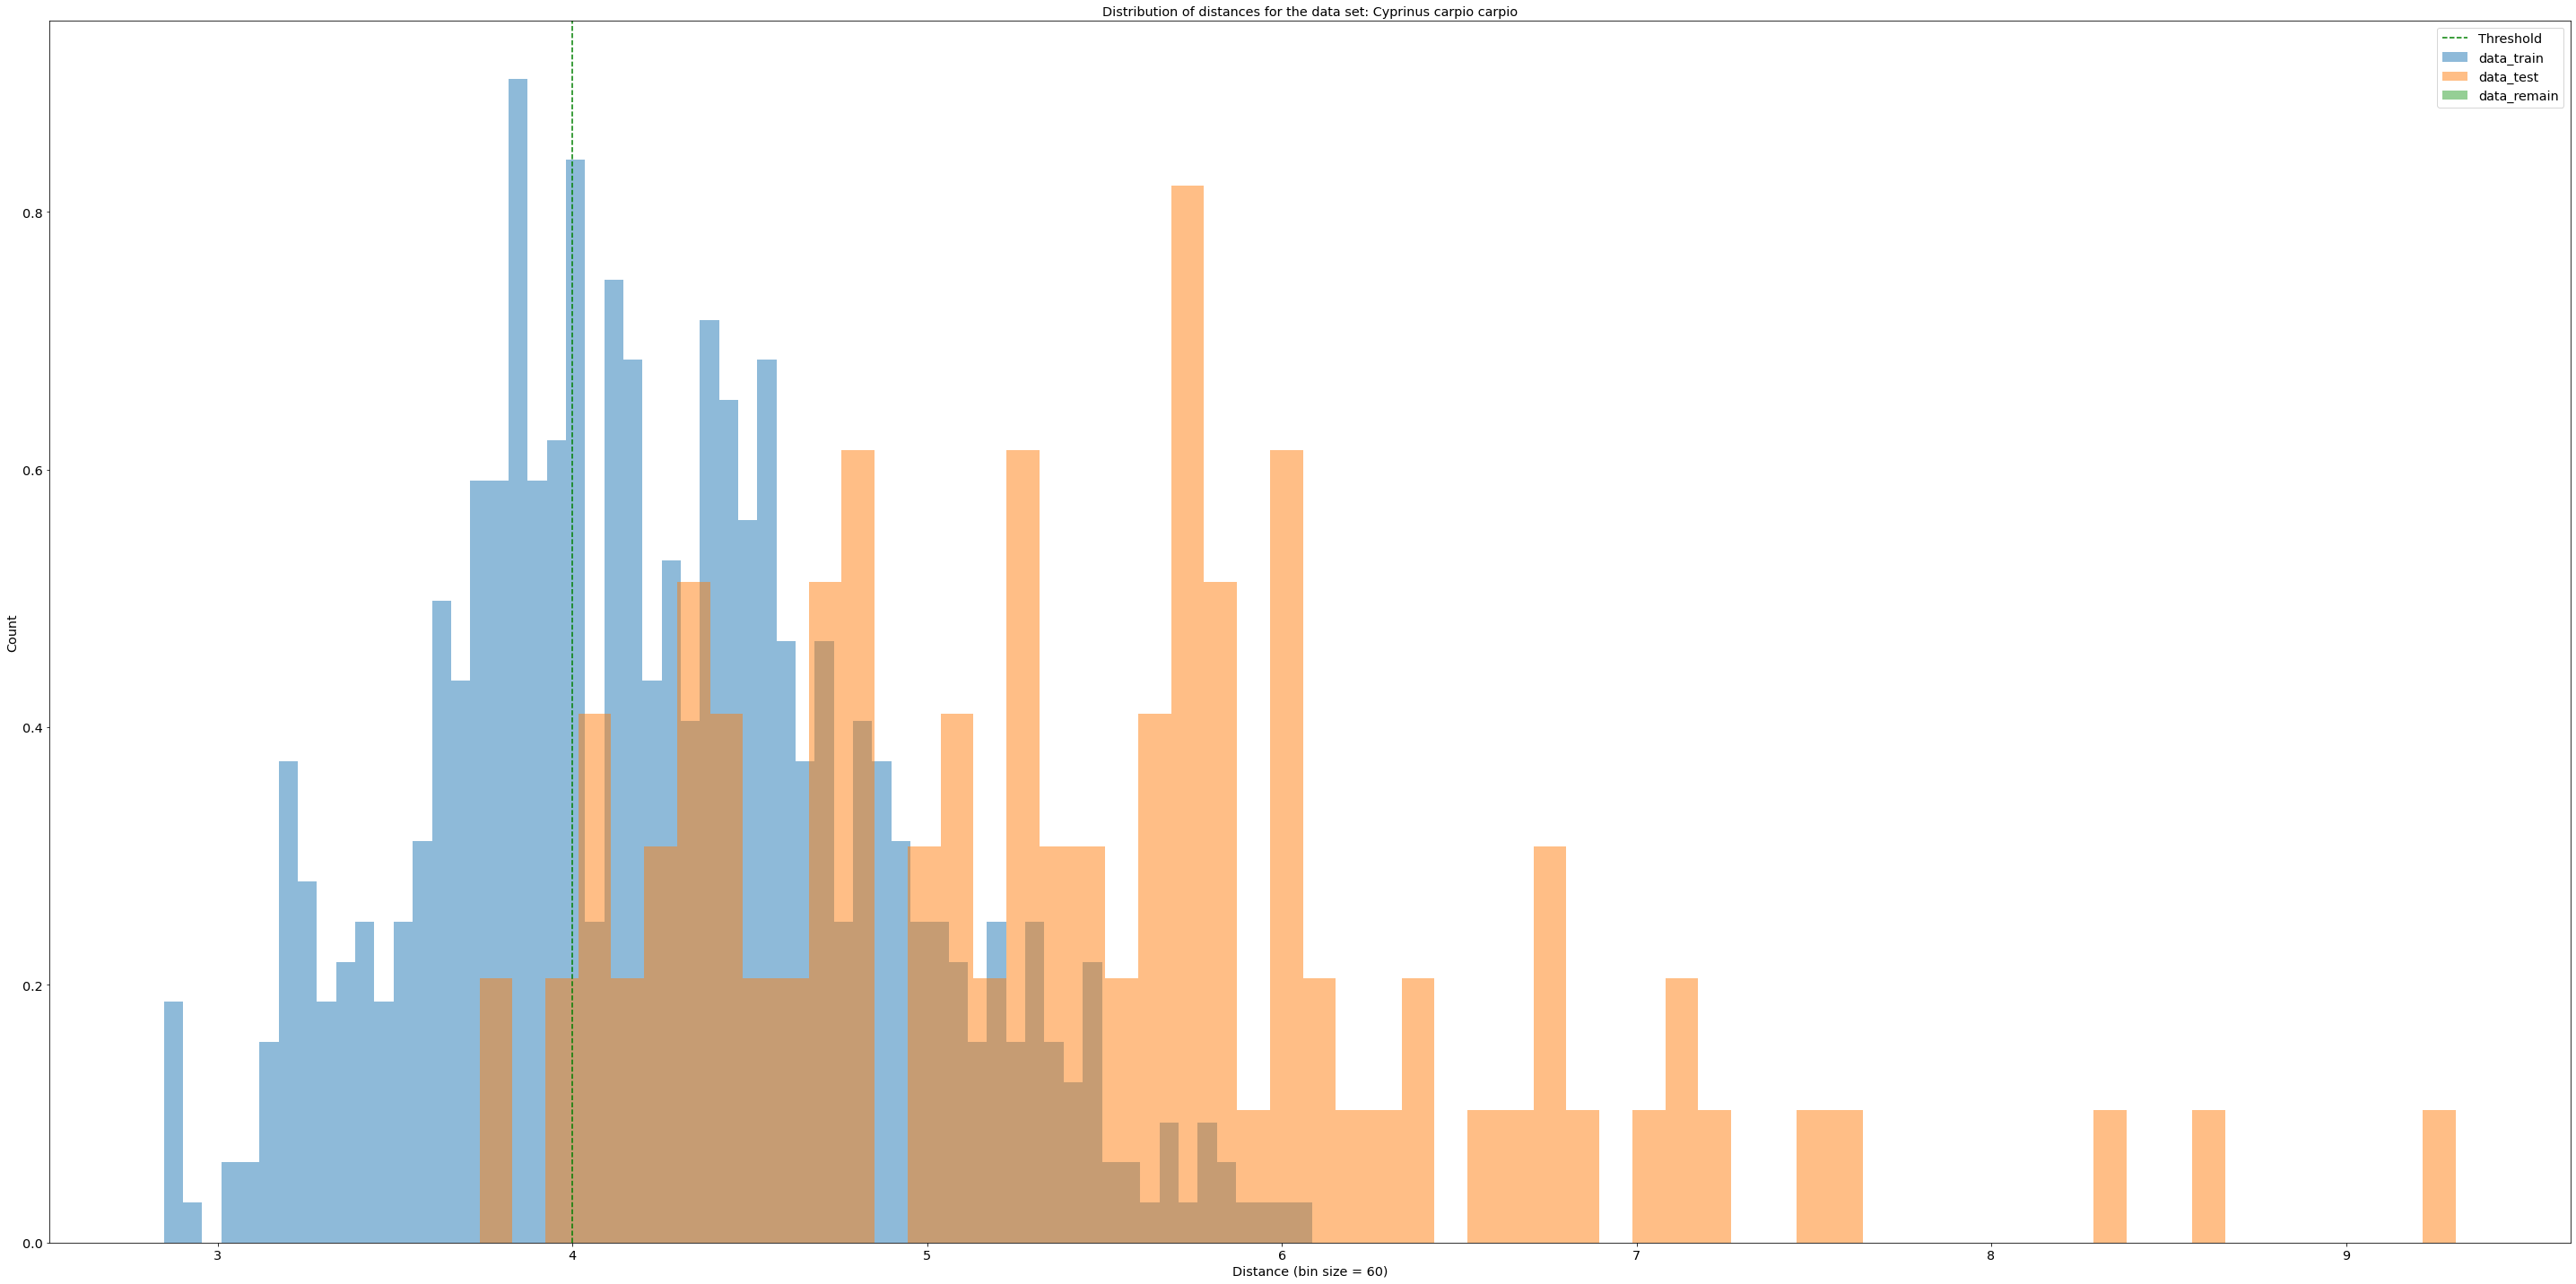

Train: 8742 Test: 506 Remain: 0


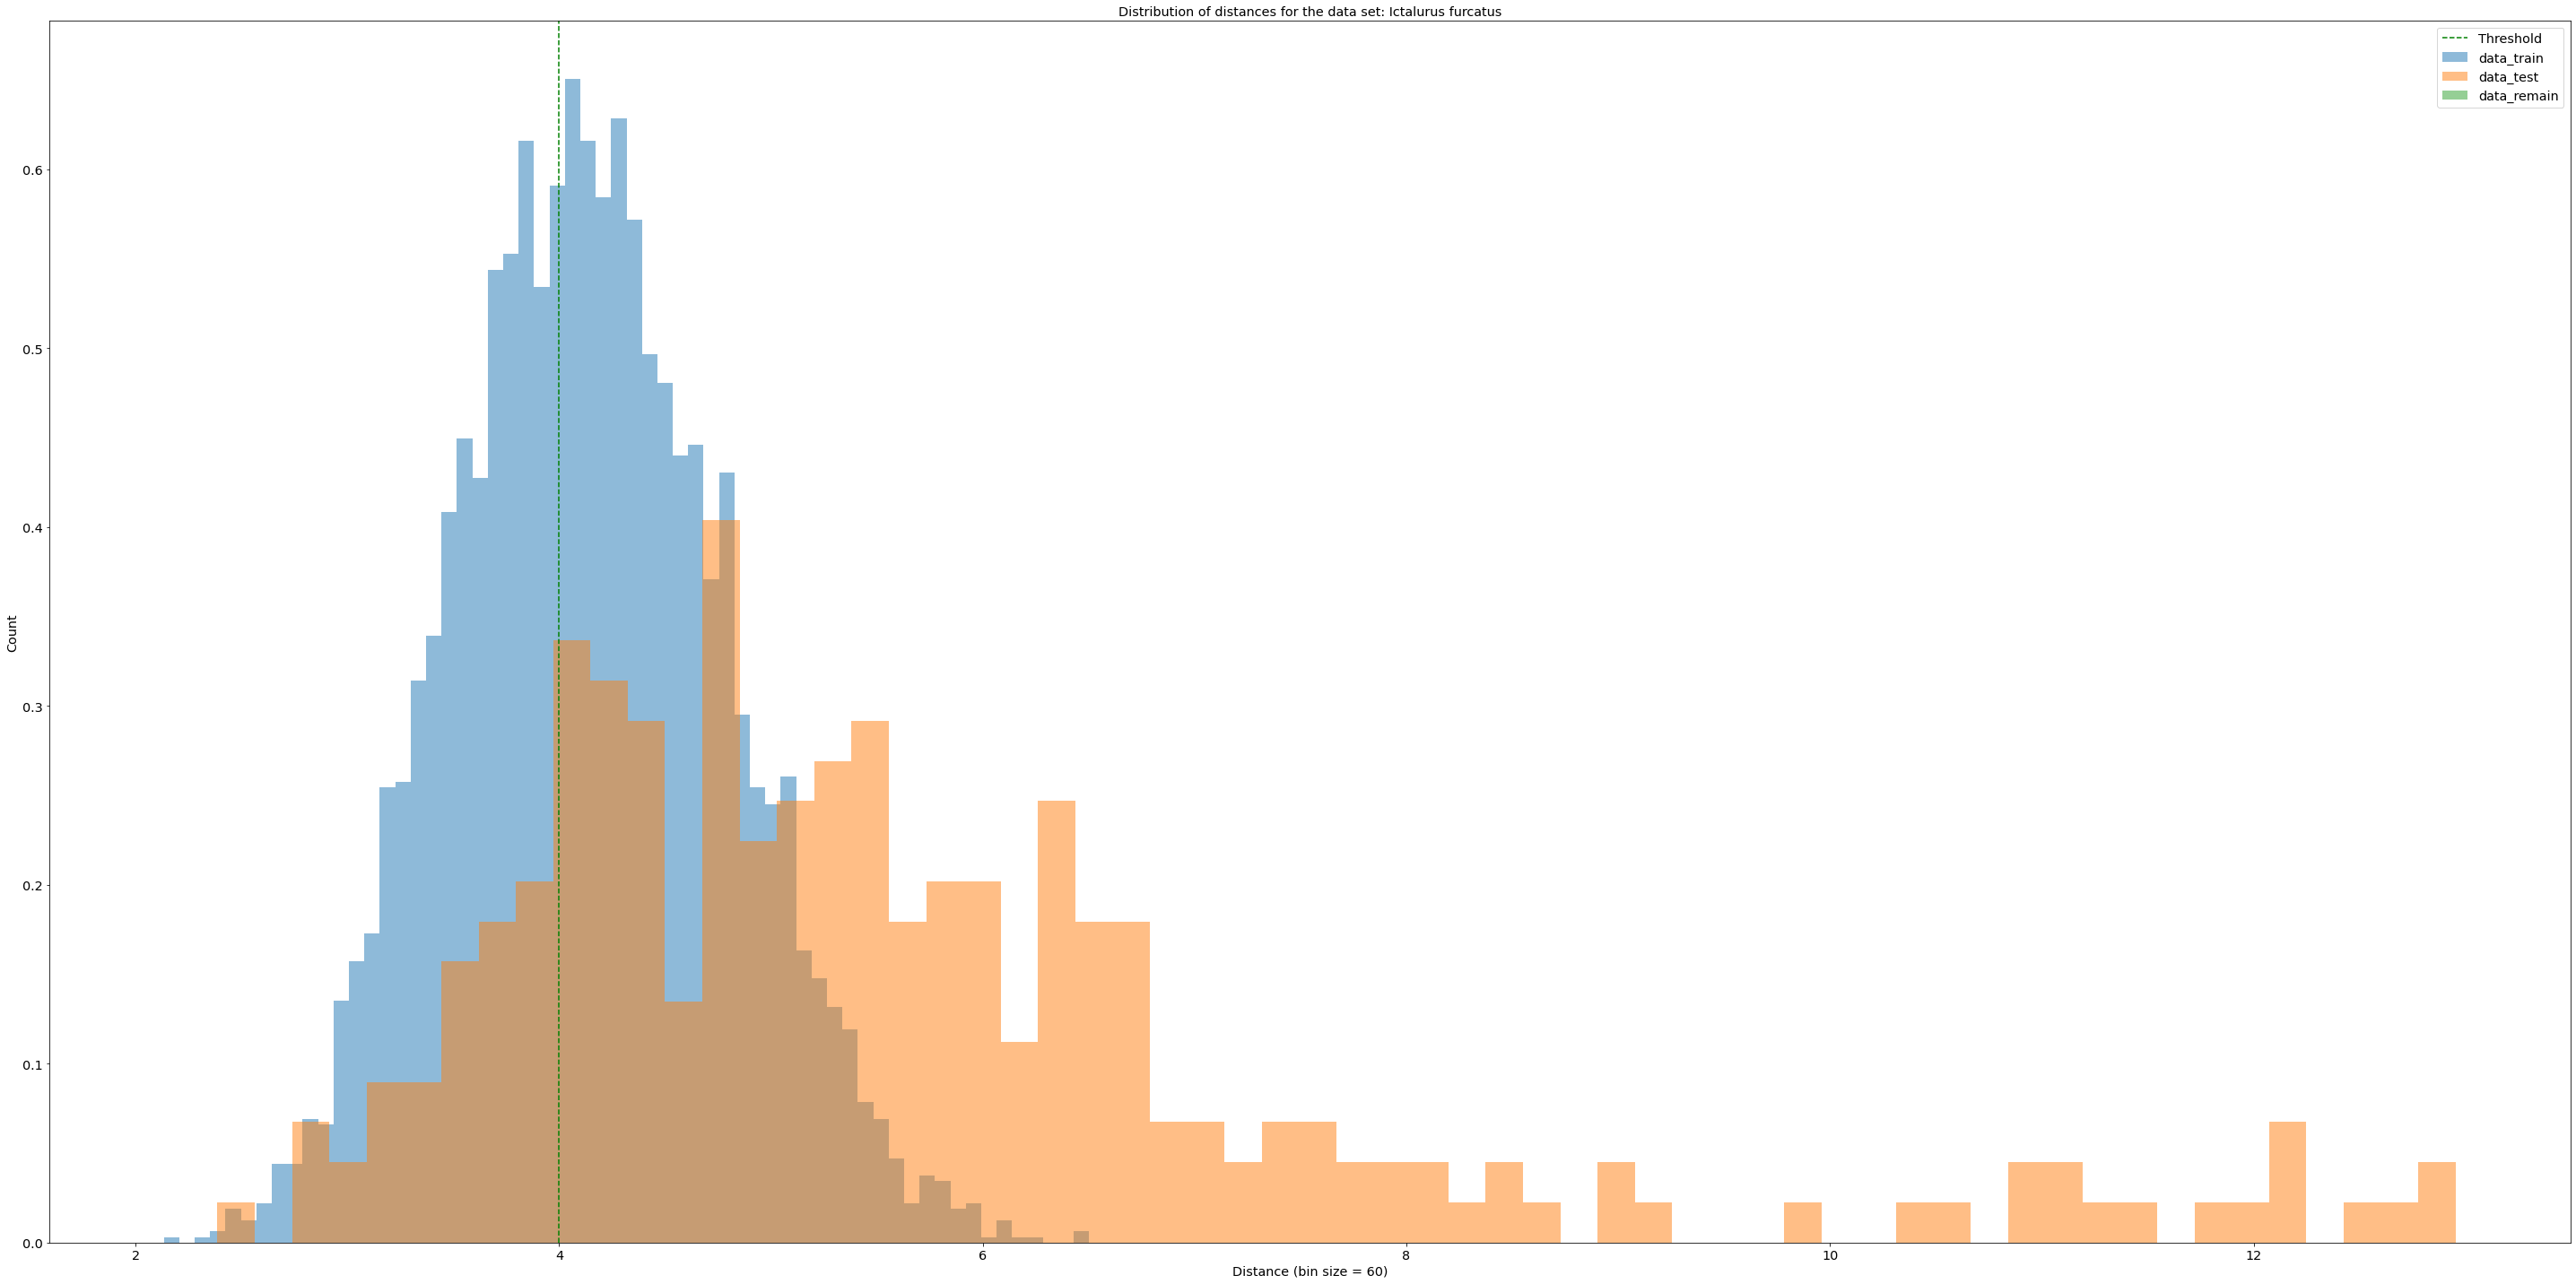

Train: 12432 Test: 702 Remain: 0


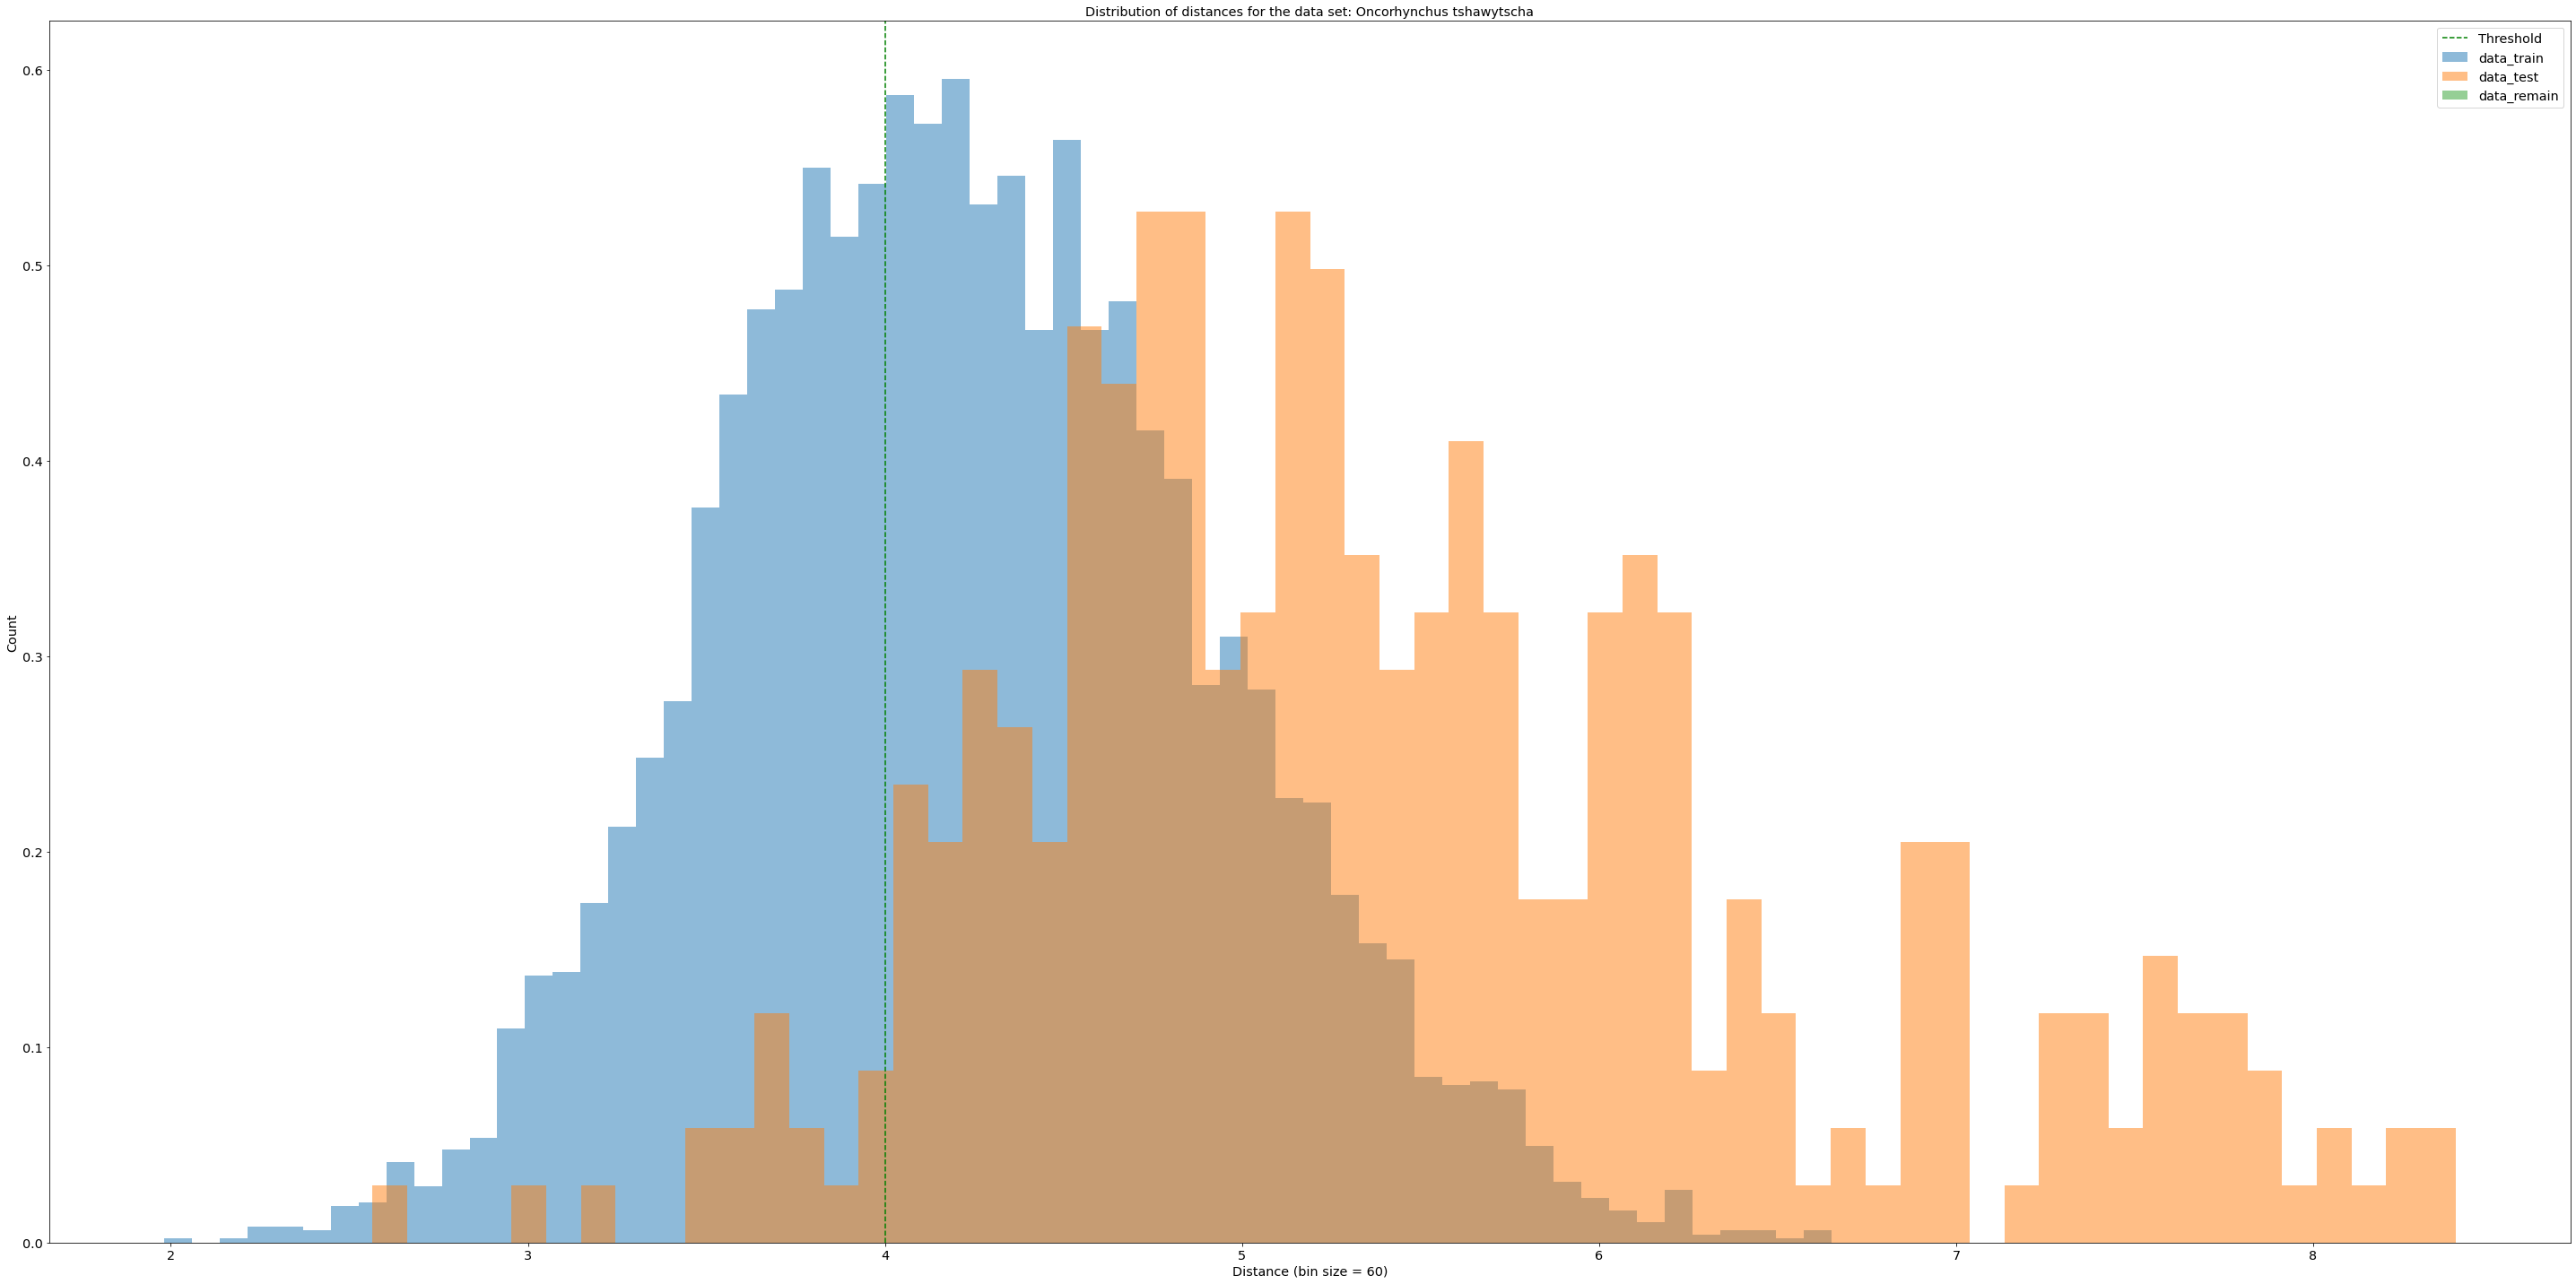

Train: 8742 Test: 506 Remain: 0


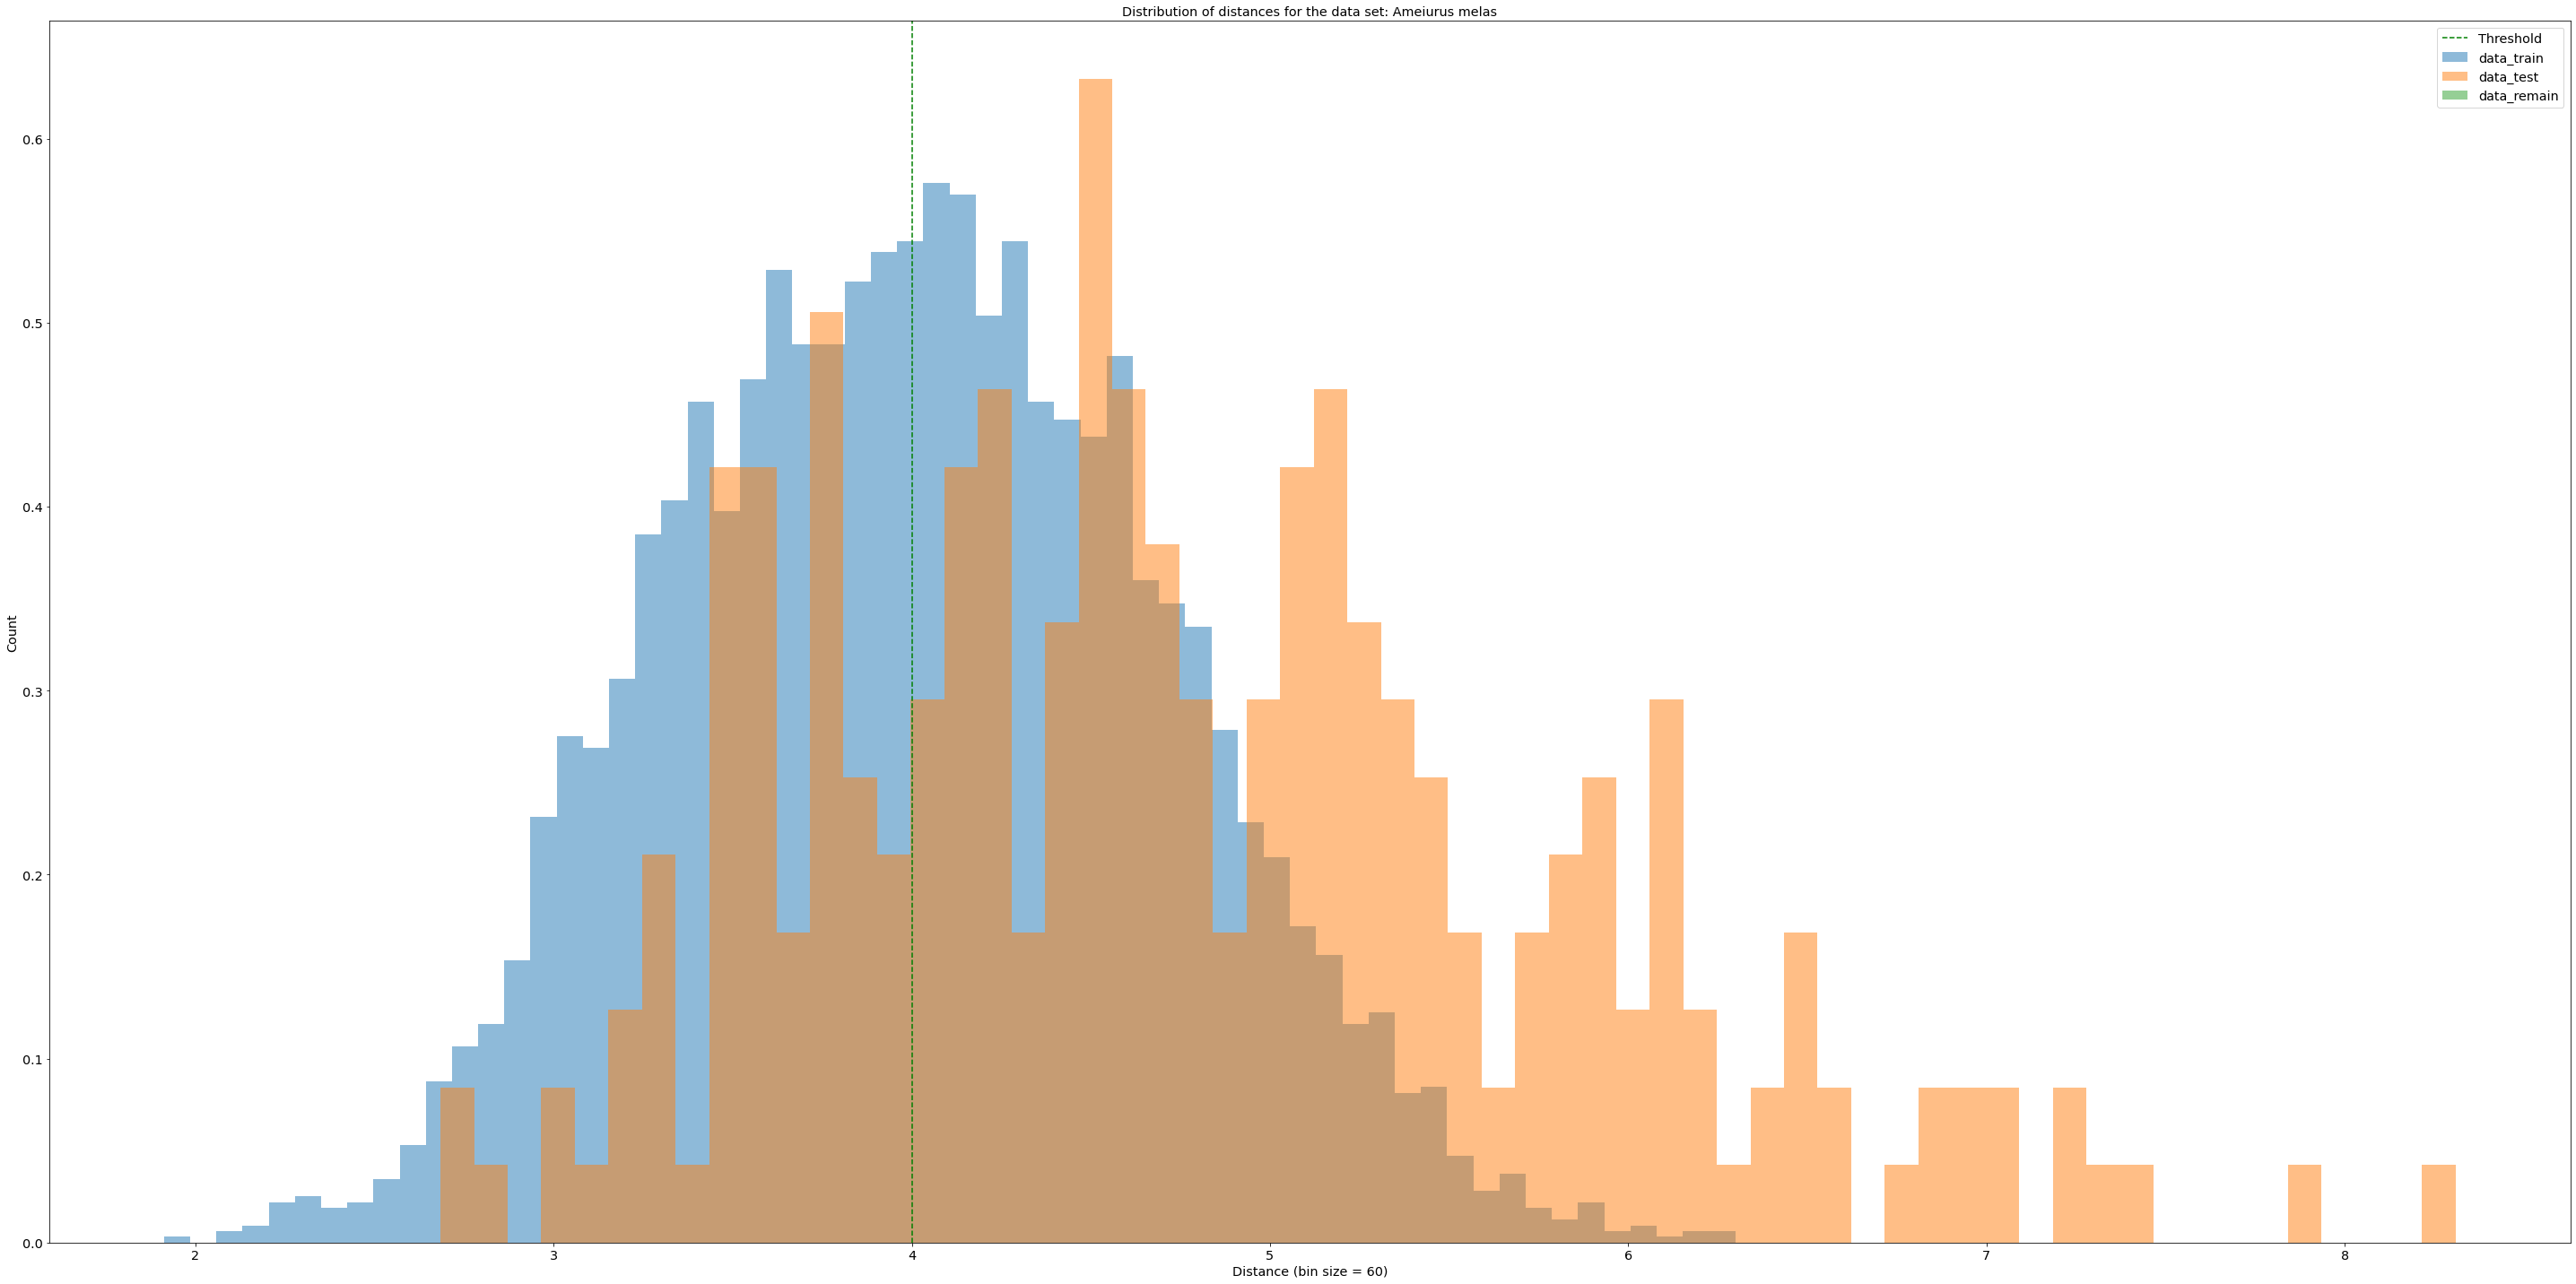

Train: 20592 Test: 1190 Remain: 0


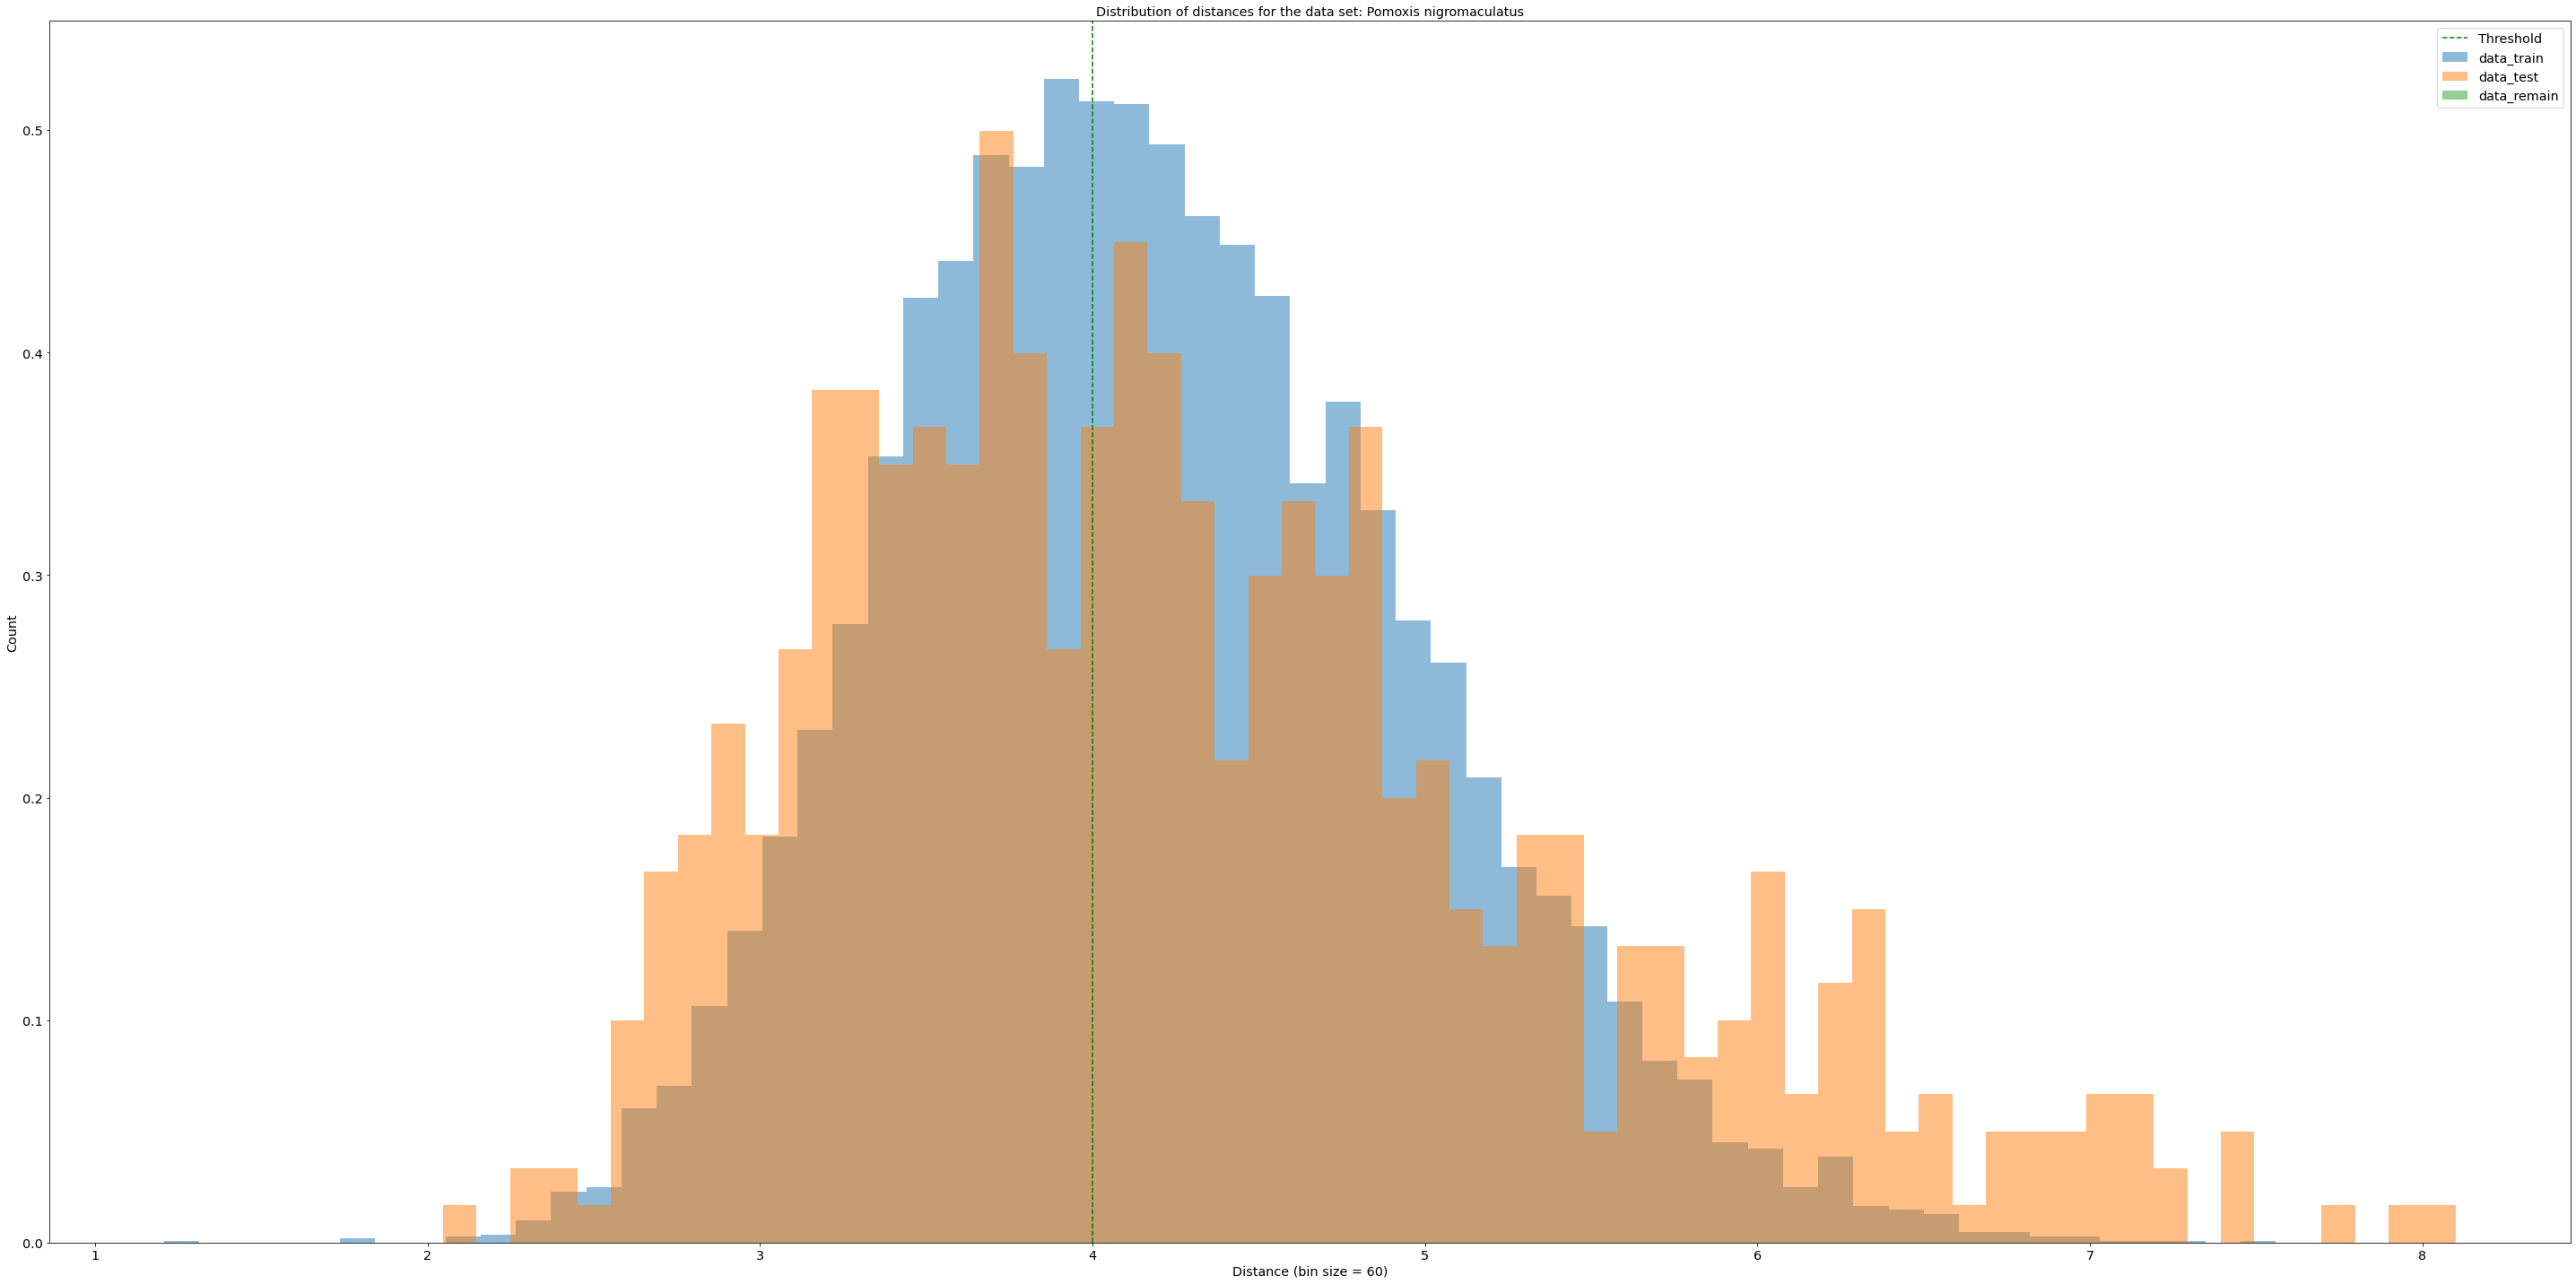

Train: 23870 Test: 1406 Remain: 0


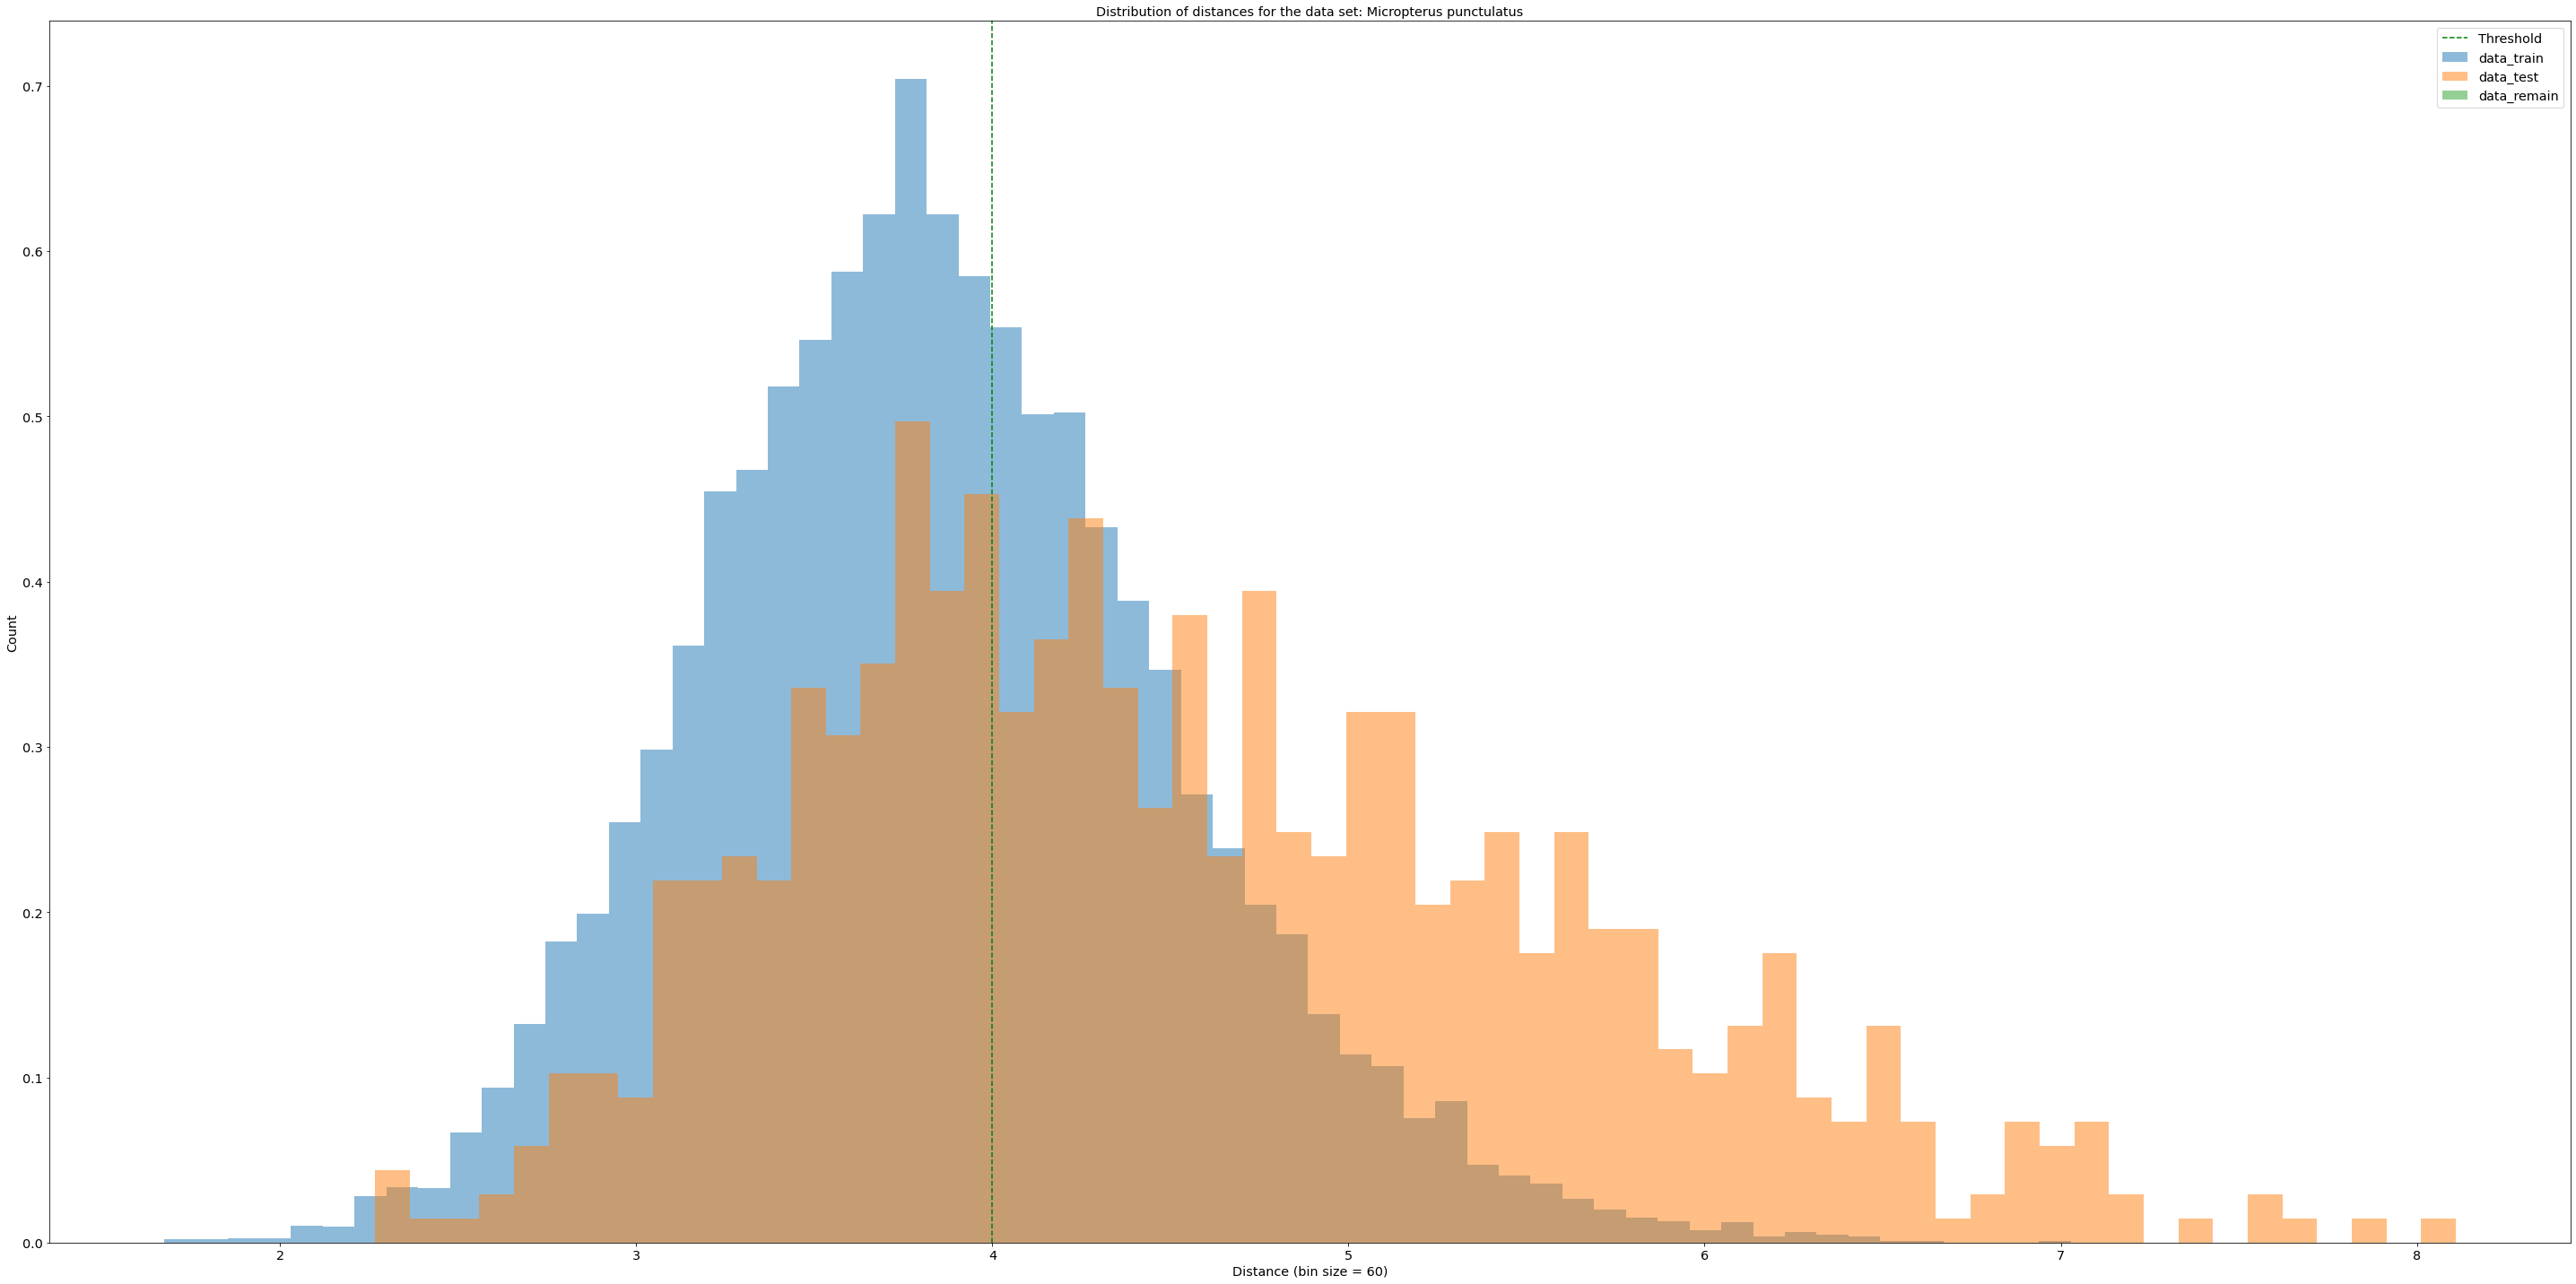

Train: 26732 Test: 1640 Remain: 0


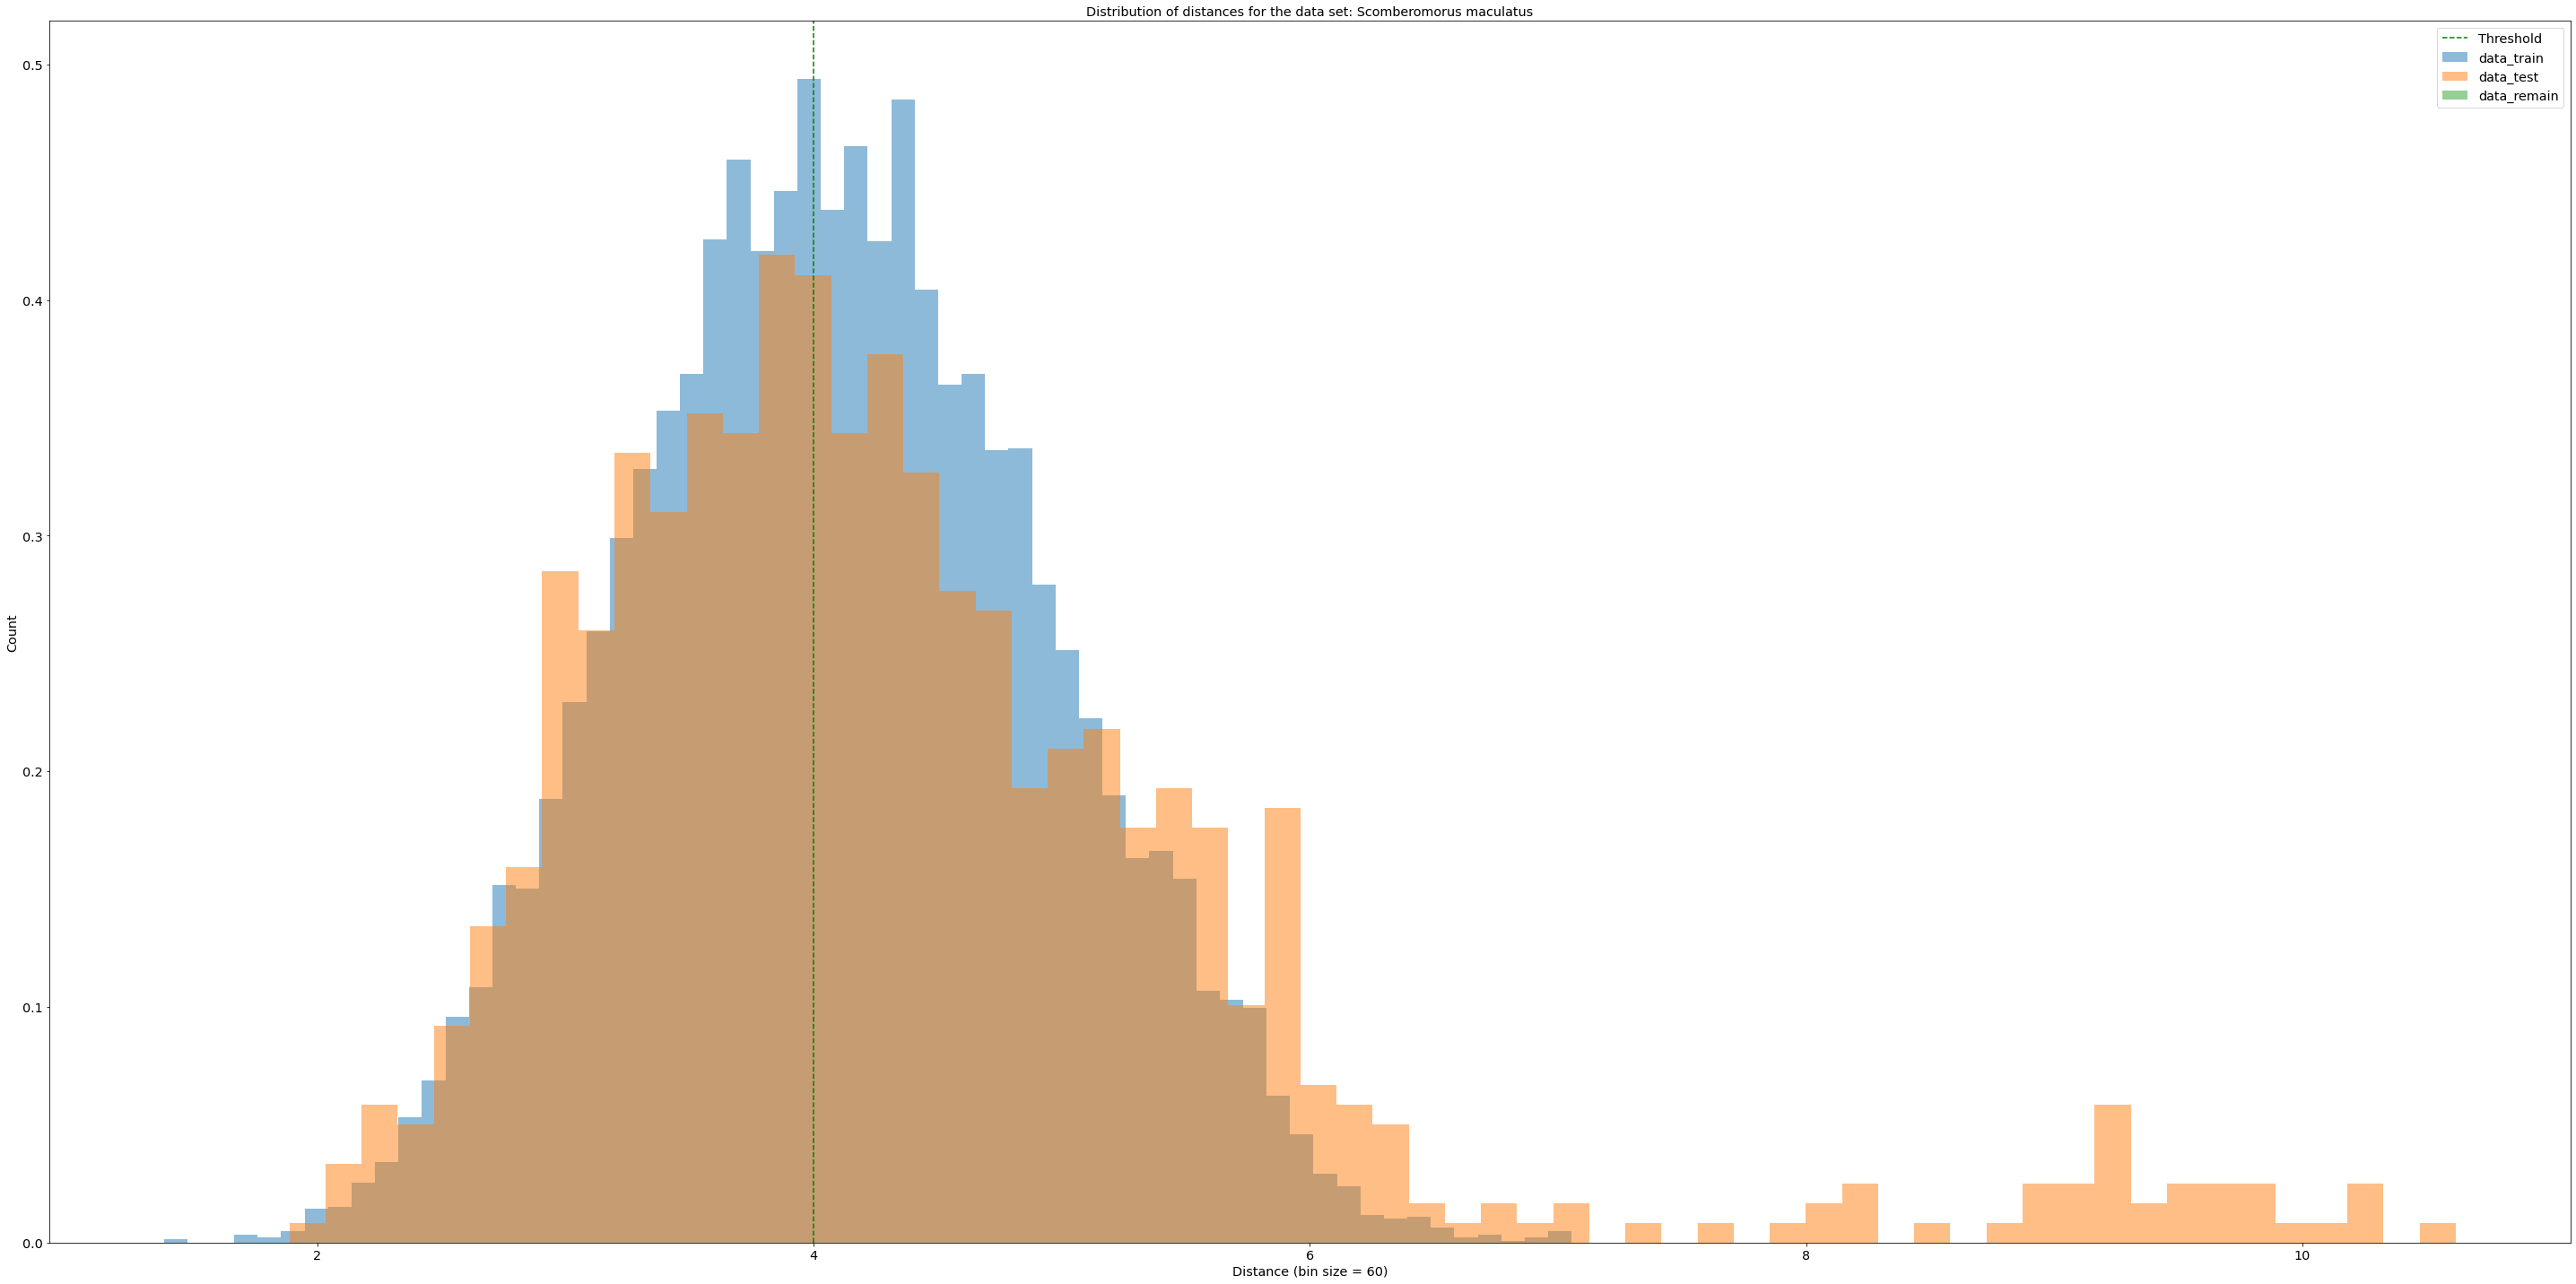

Train: 25760 Test: 1560 Remain: 0


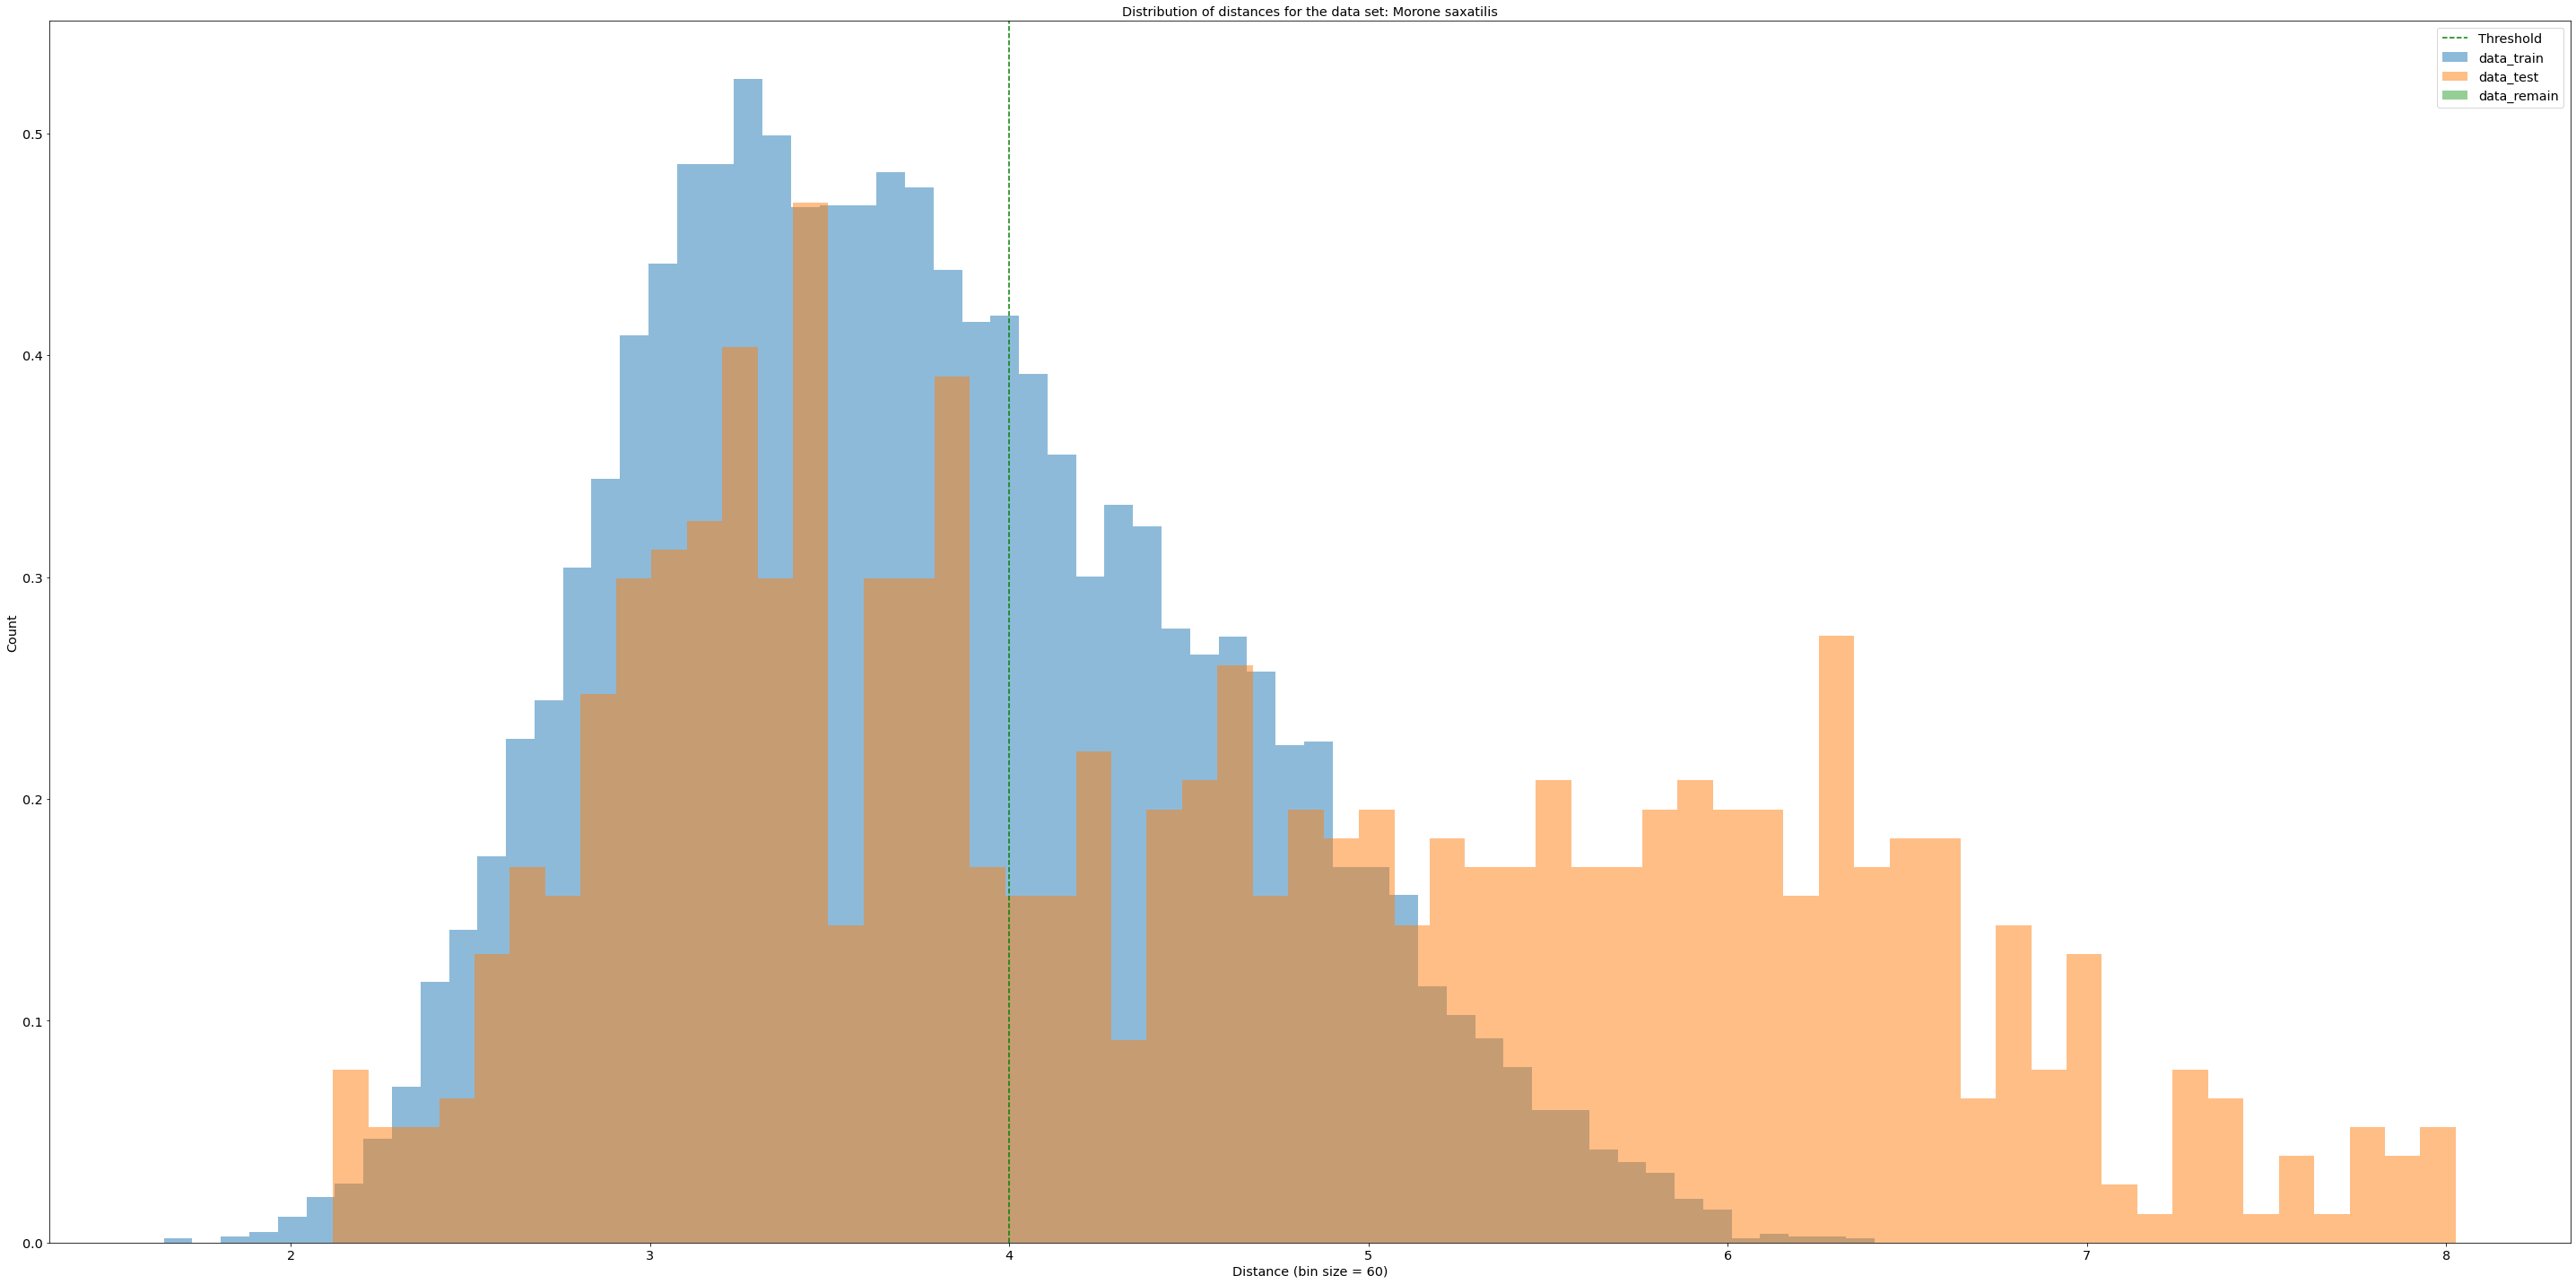

Train: 11556 Test: 702 Remain: 0


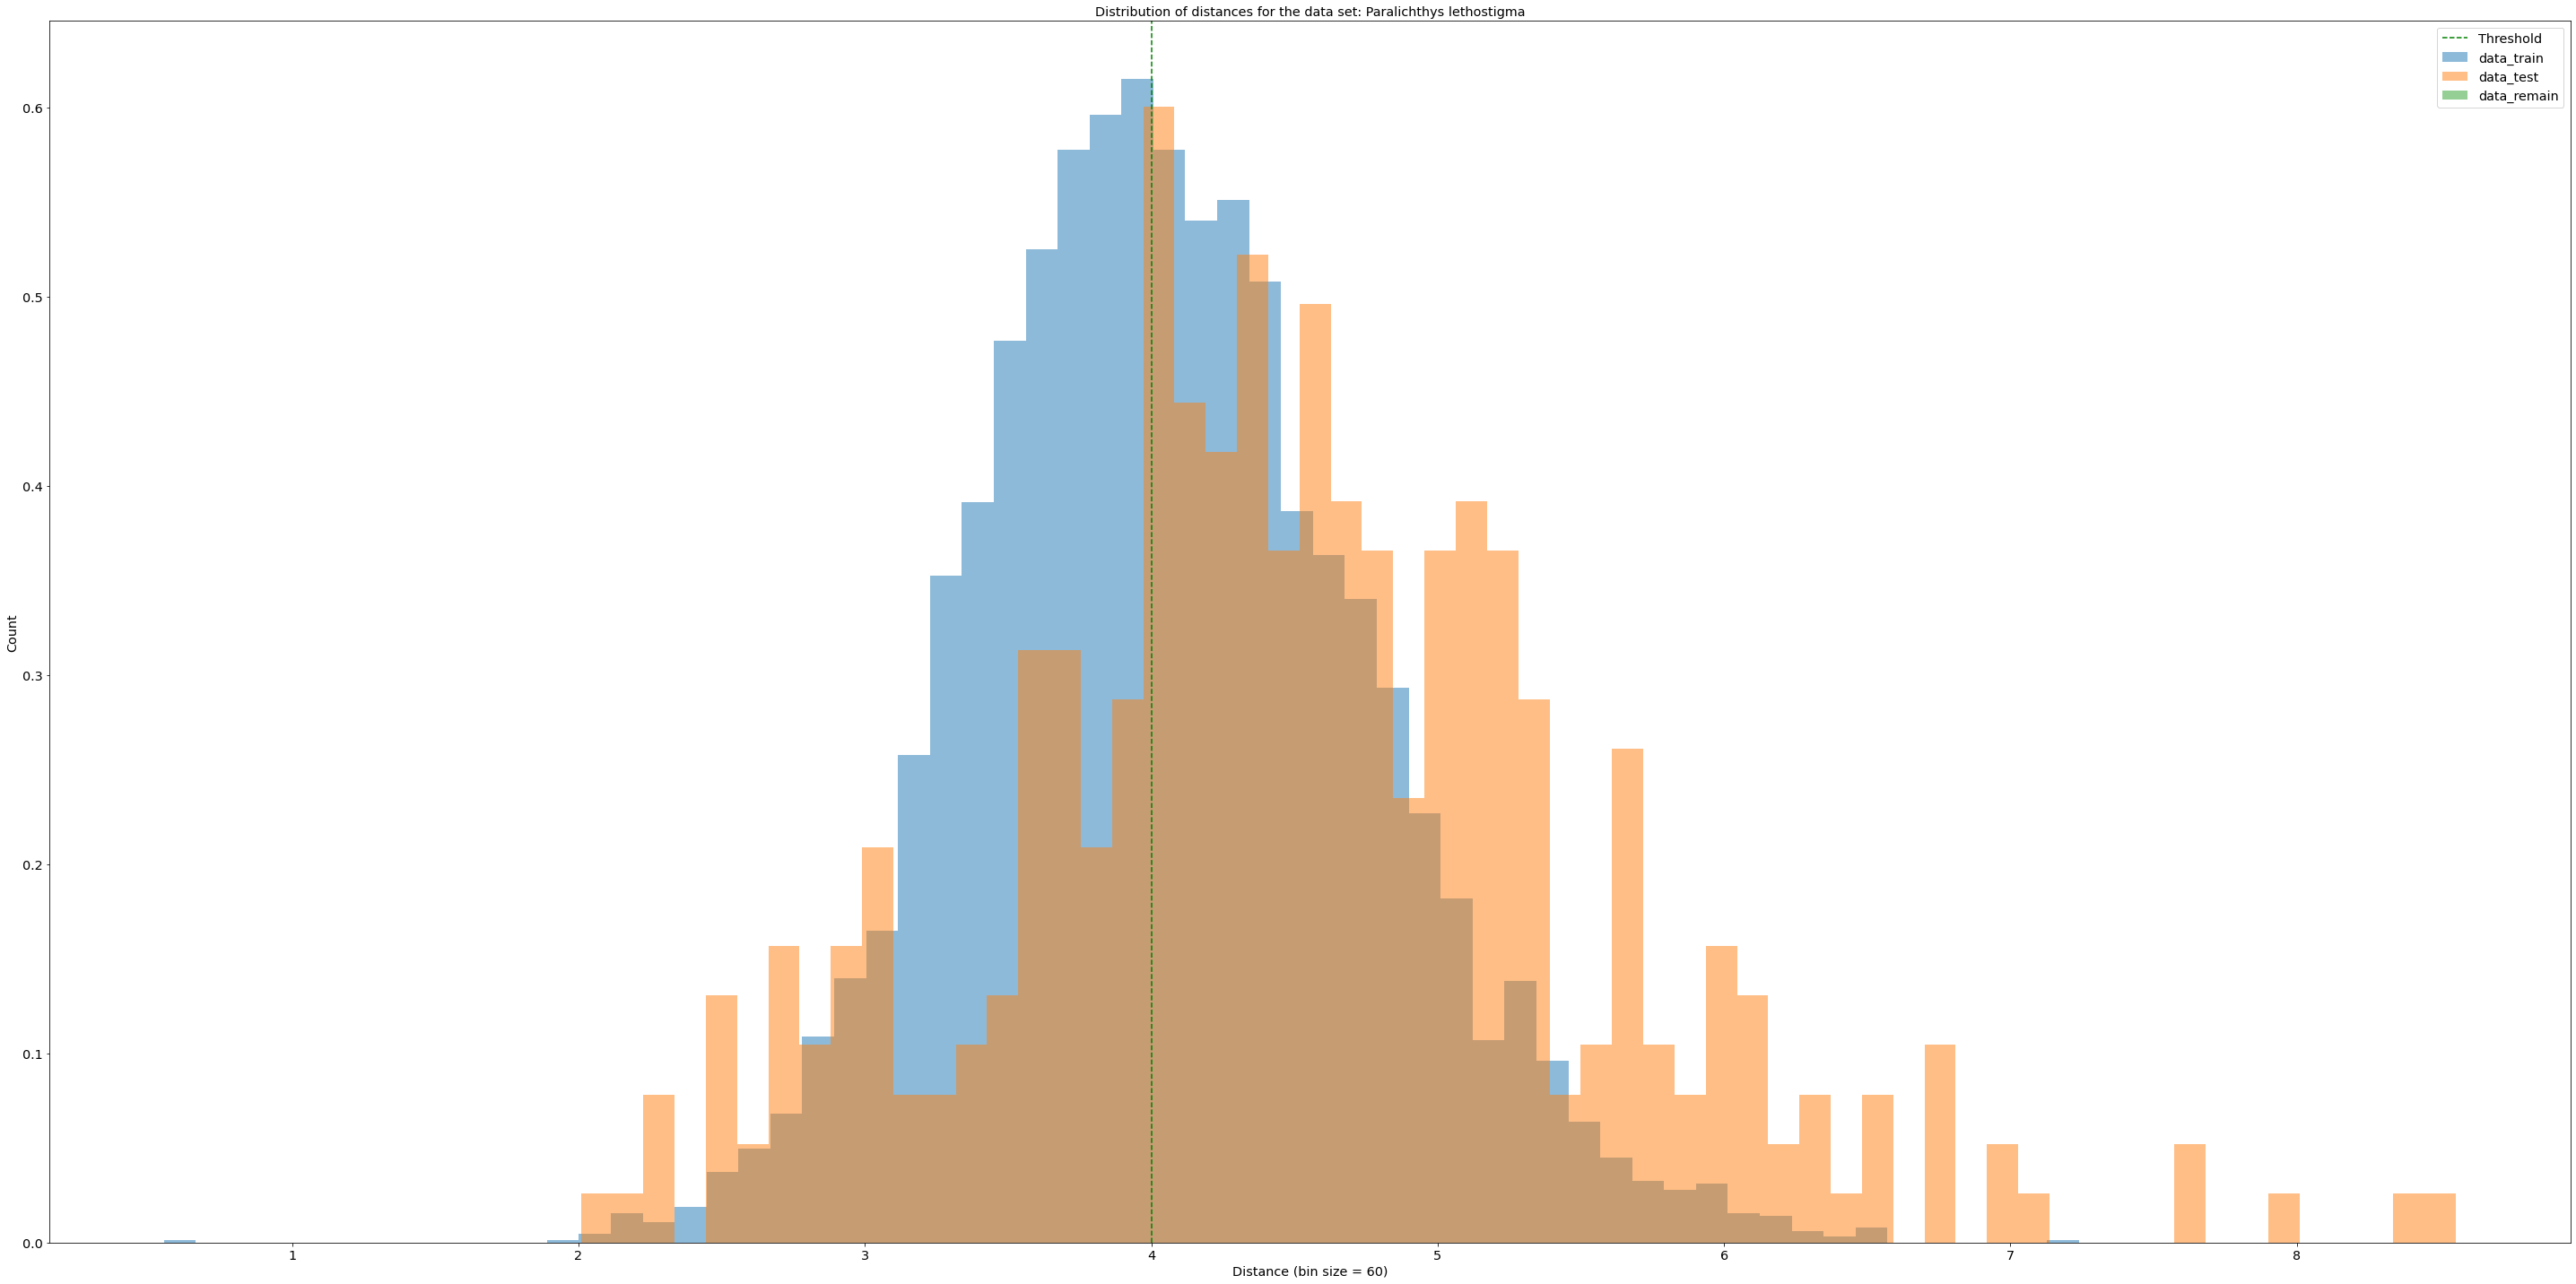

Train: 8372 Test: 506 Remain: 0


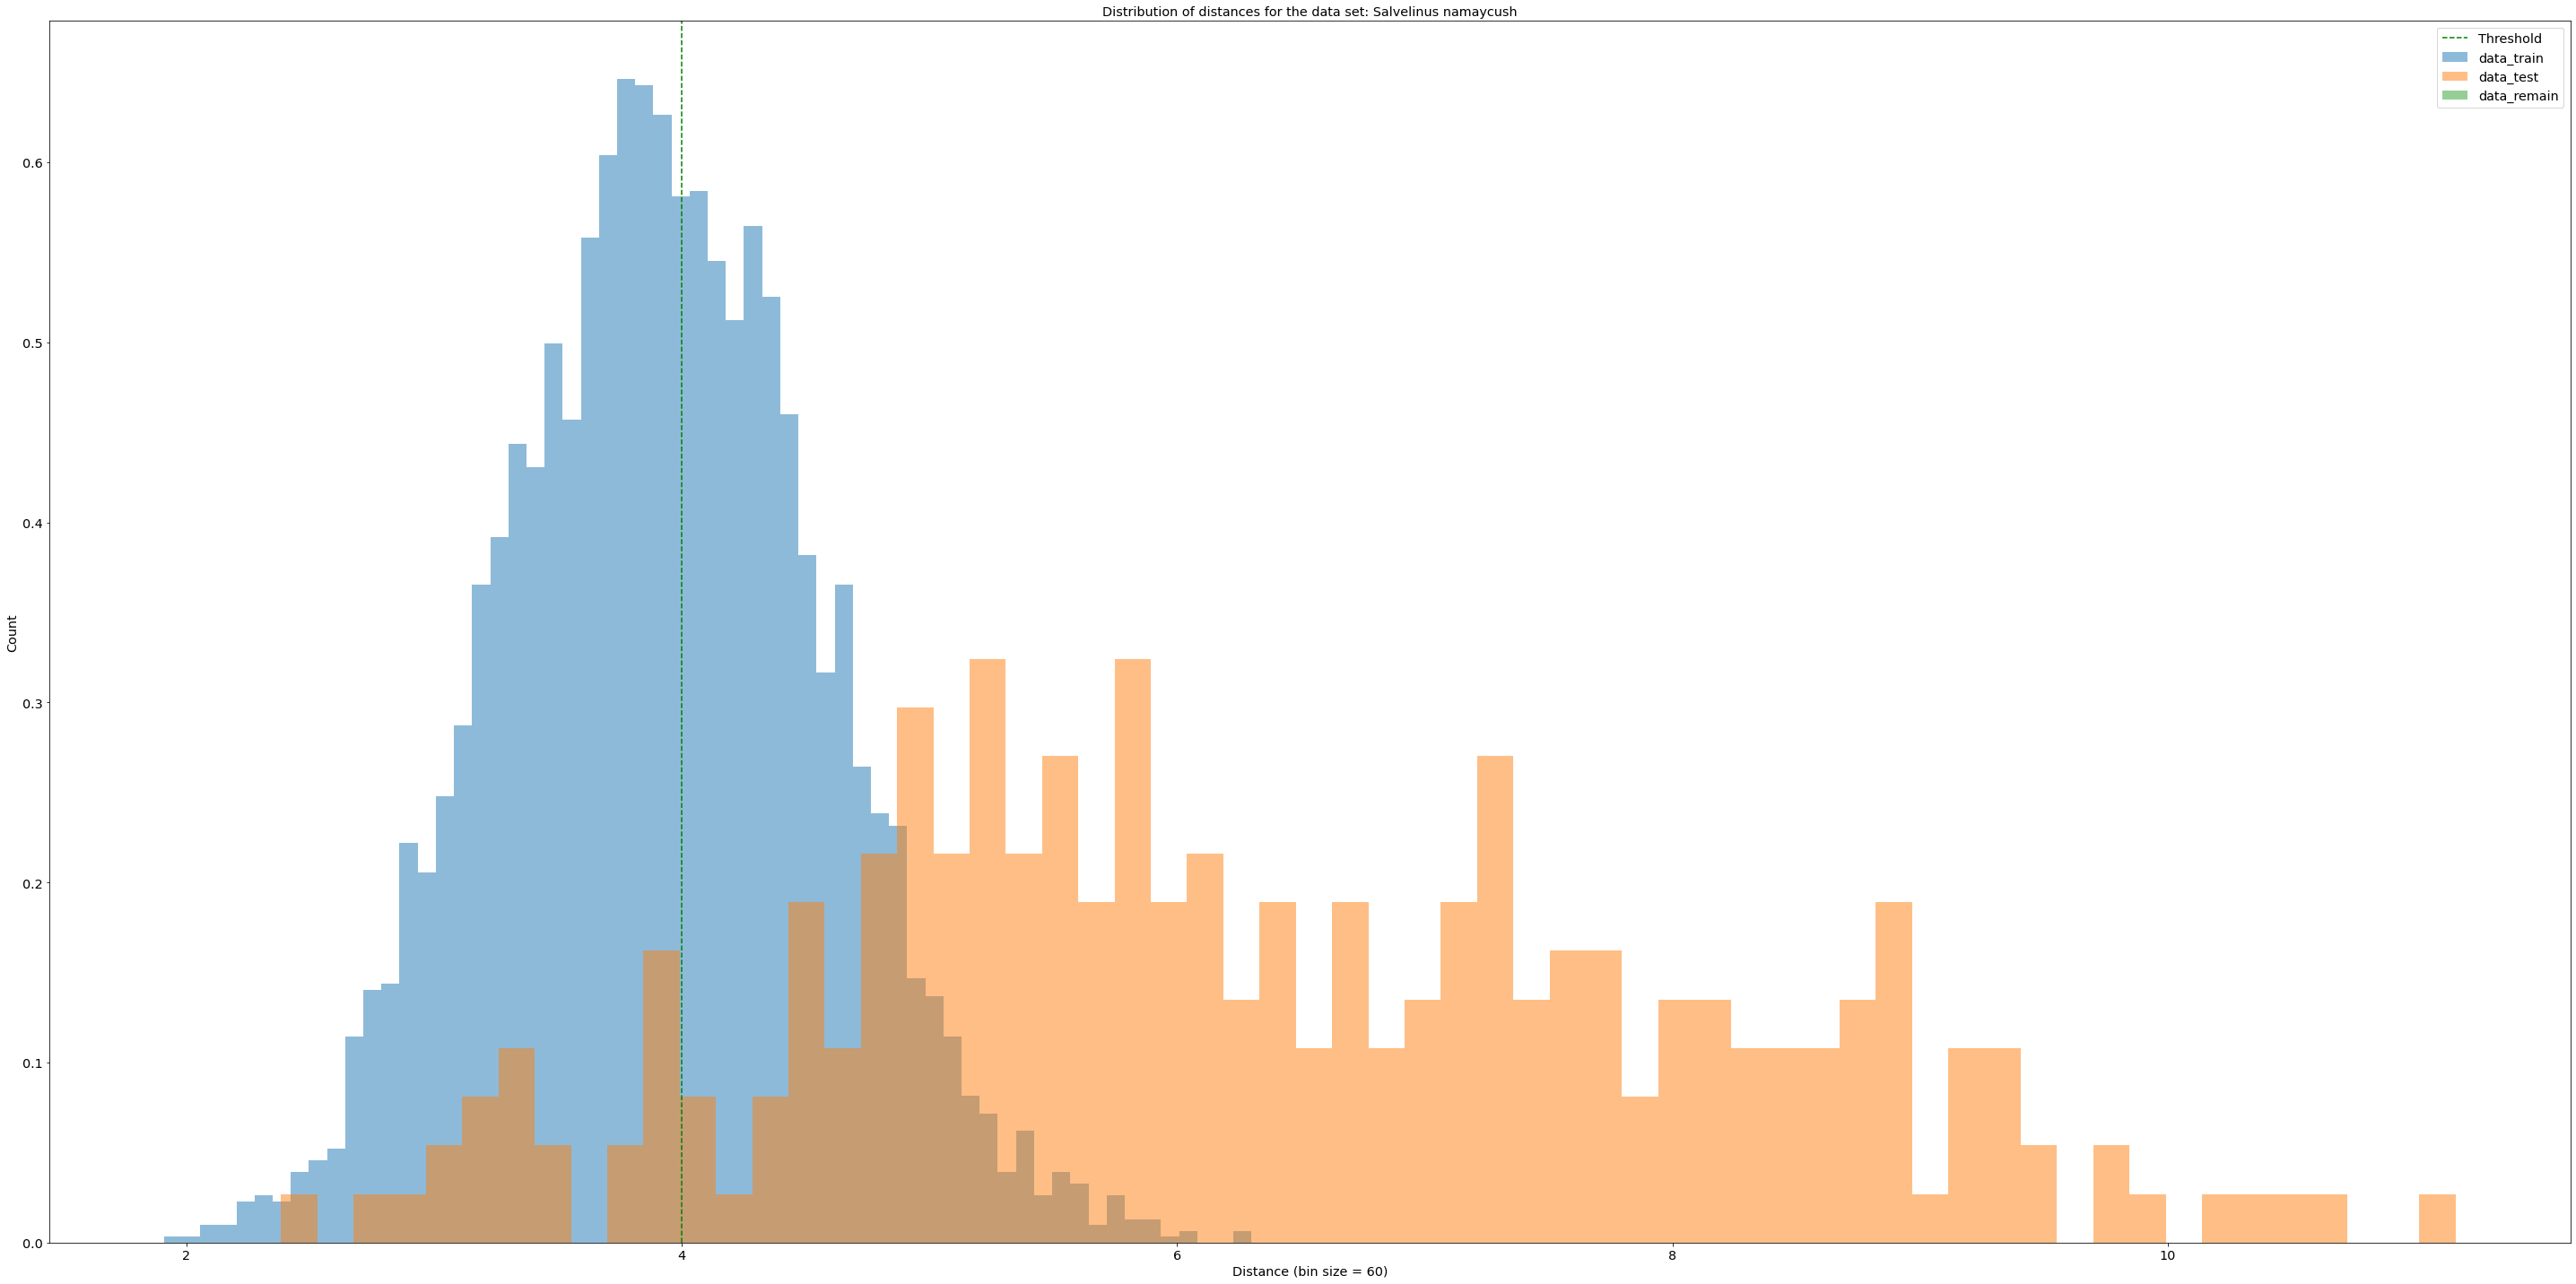

Train: 28392 Test: 1722 Remain: 812


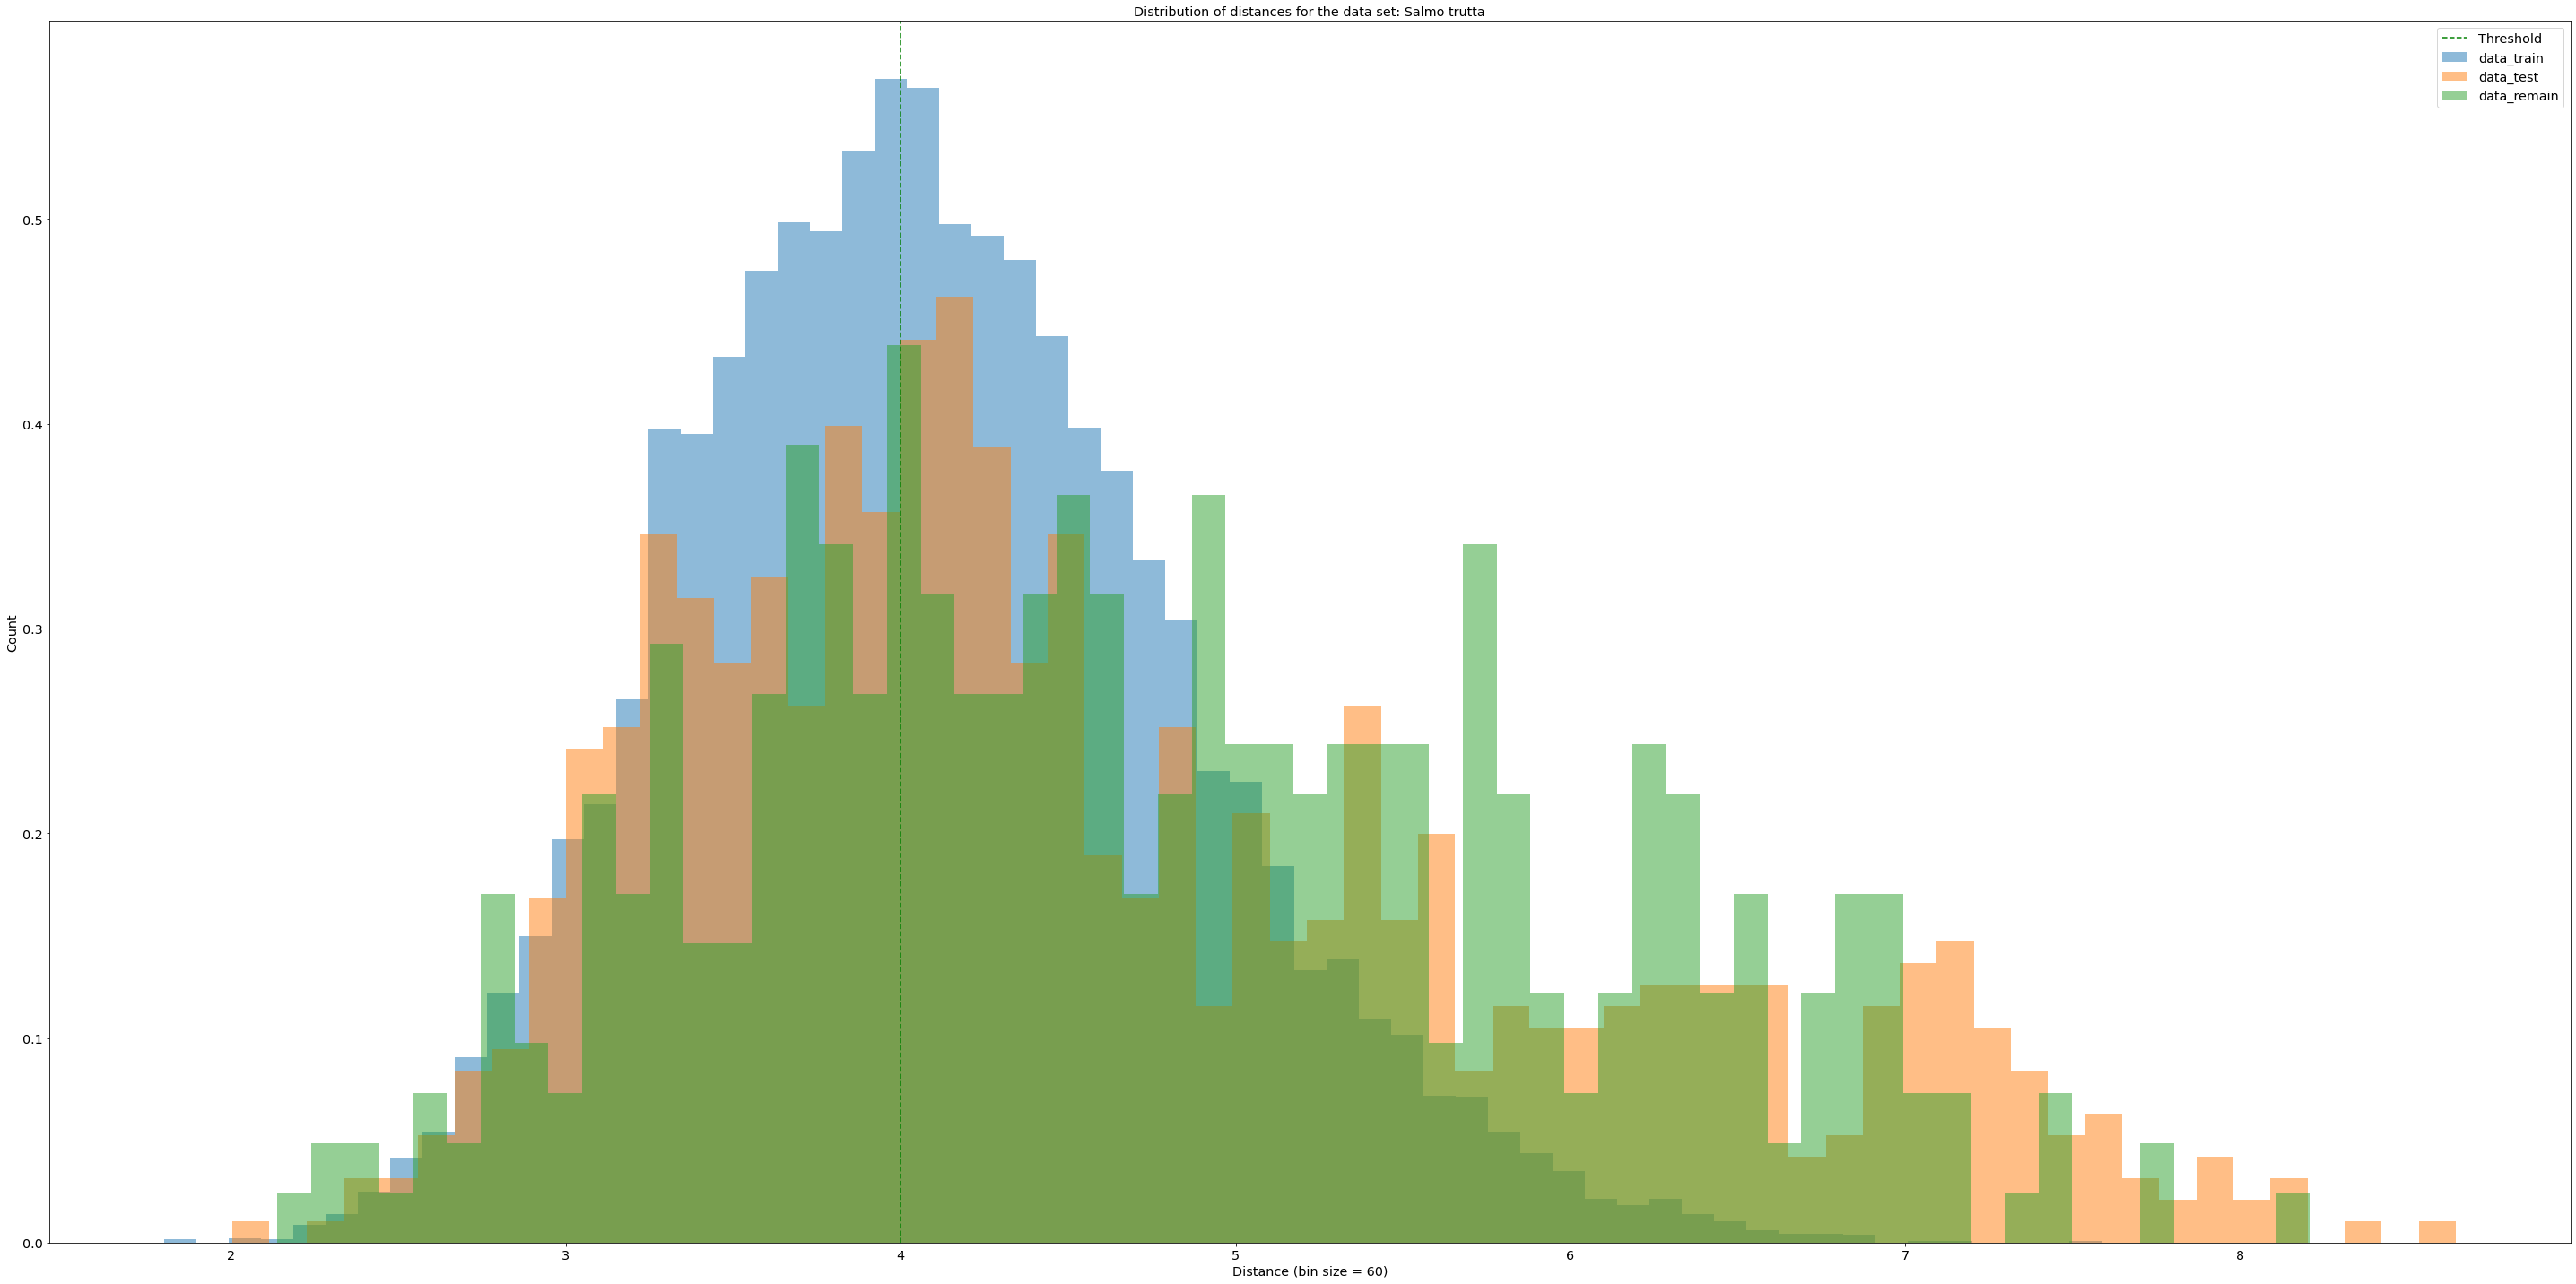

Train: 14762 Test: 870 Remain: 0


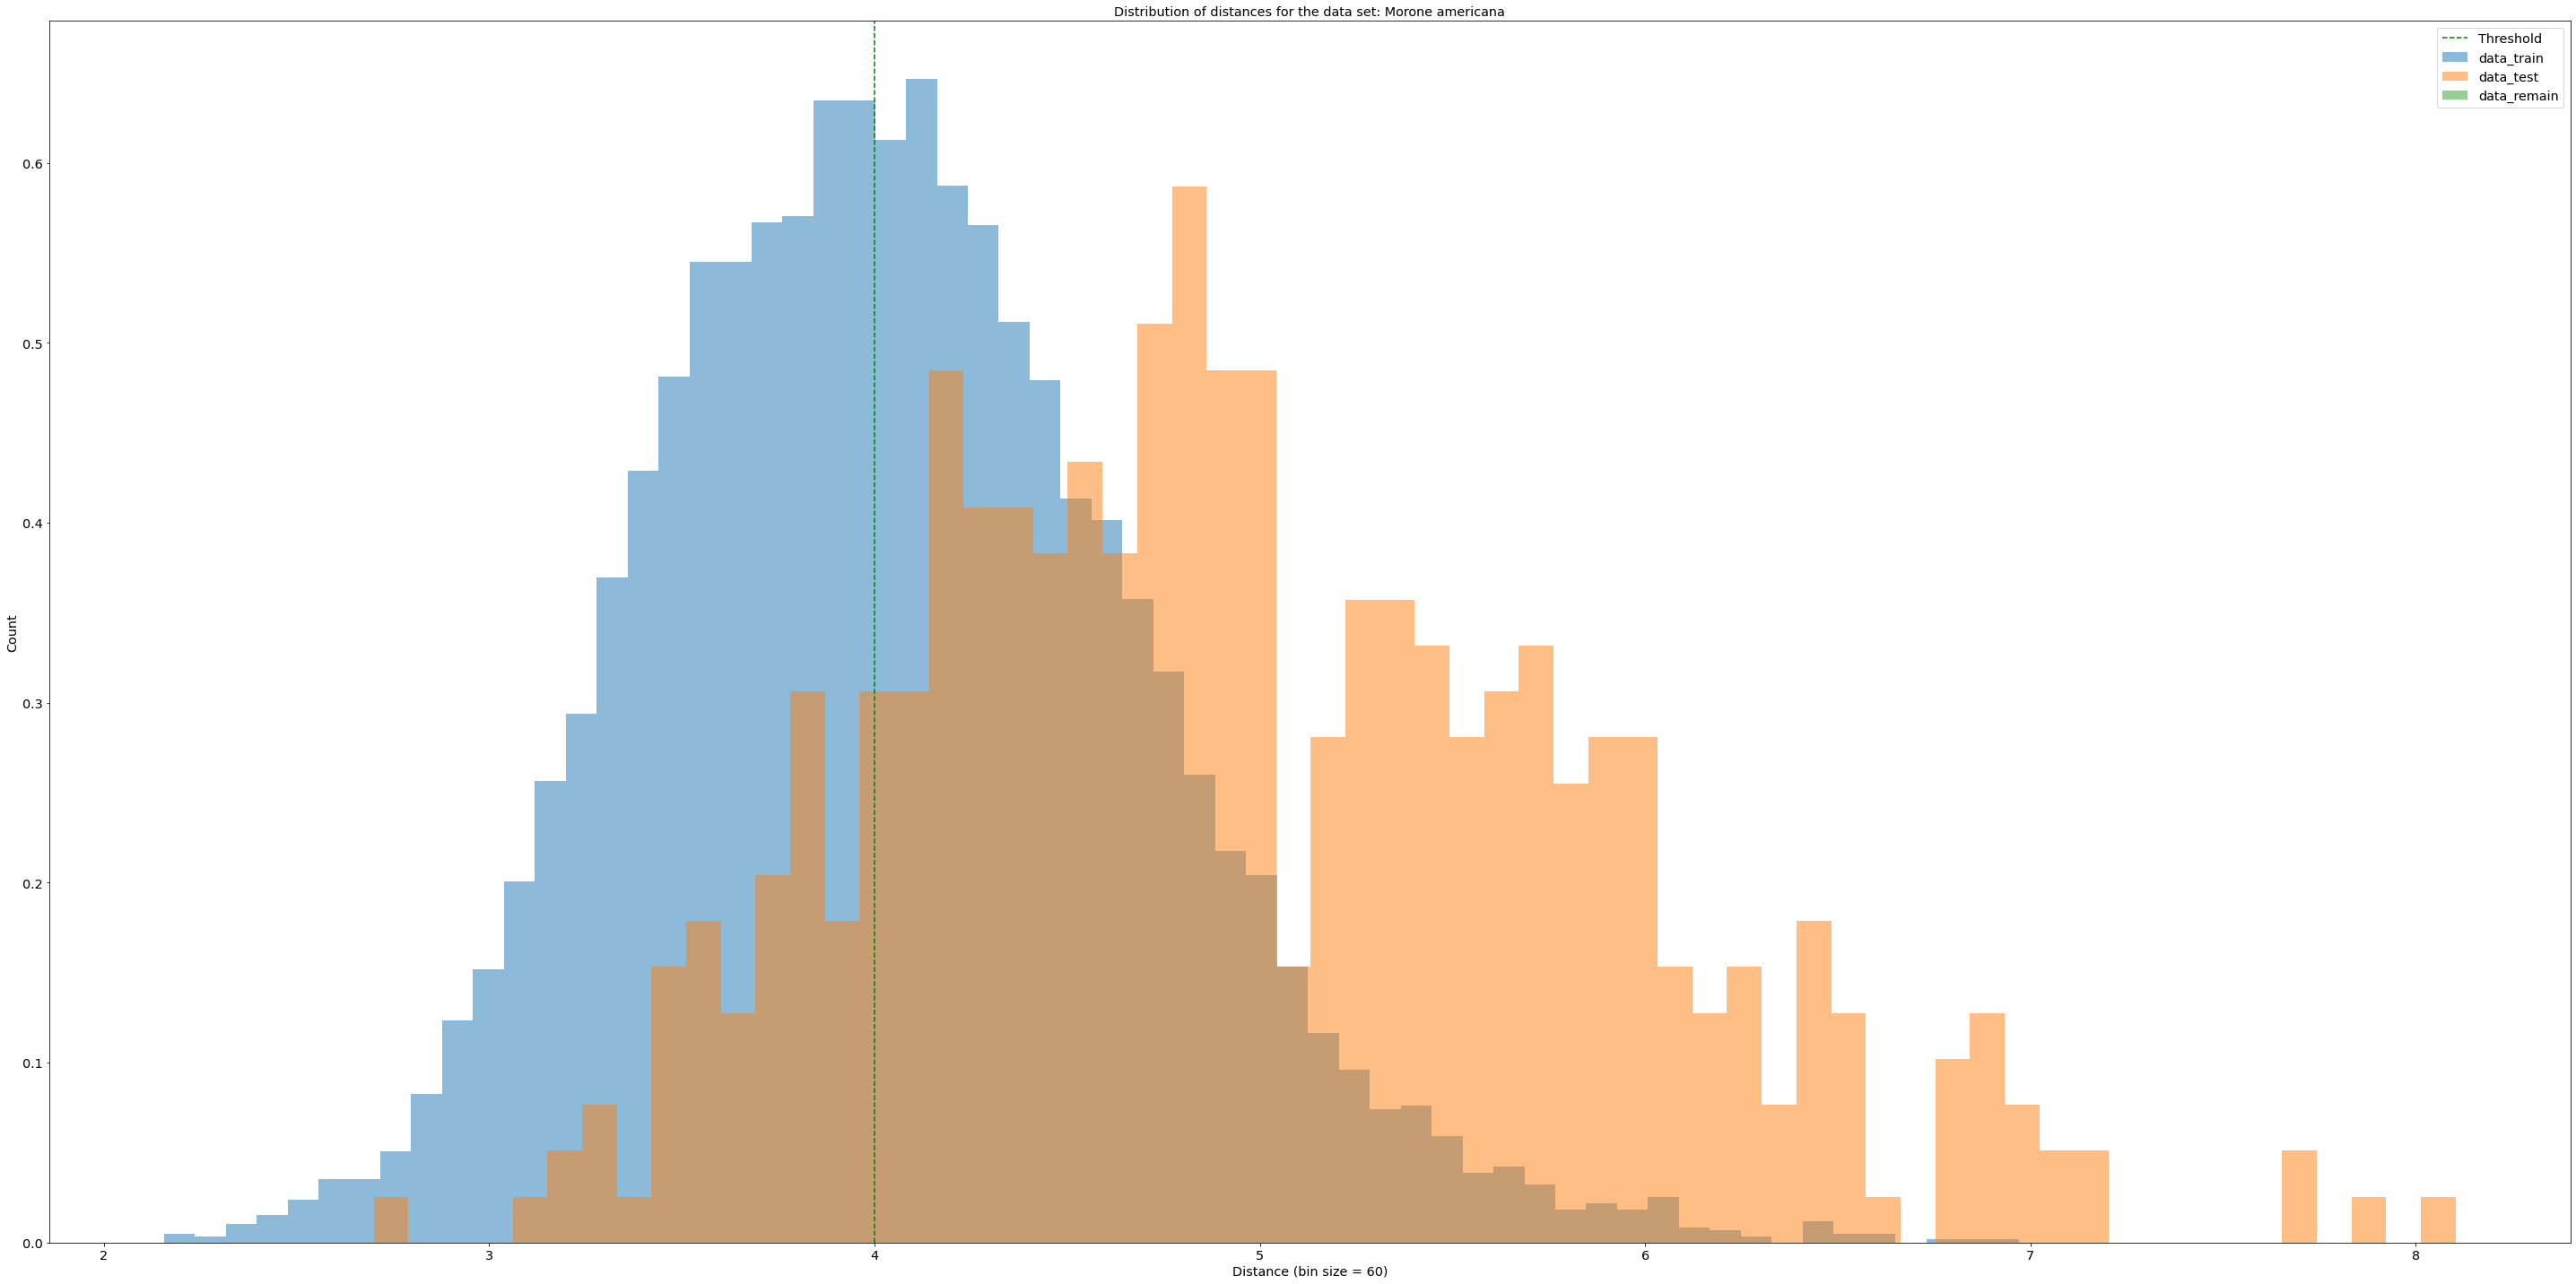

Train: 28392 Test: 1722 Remain: 292140


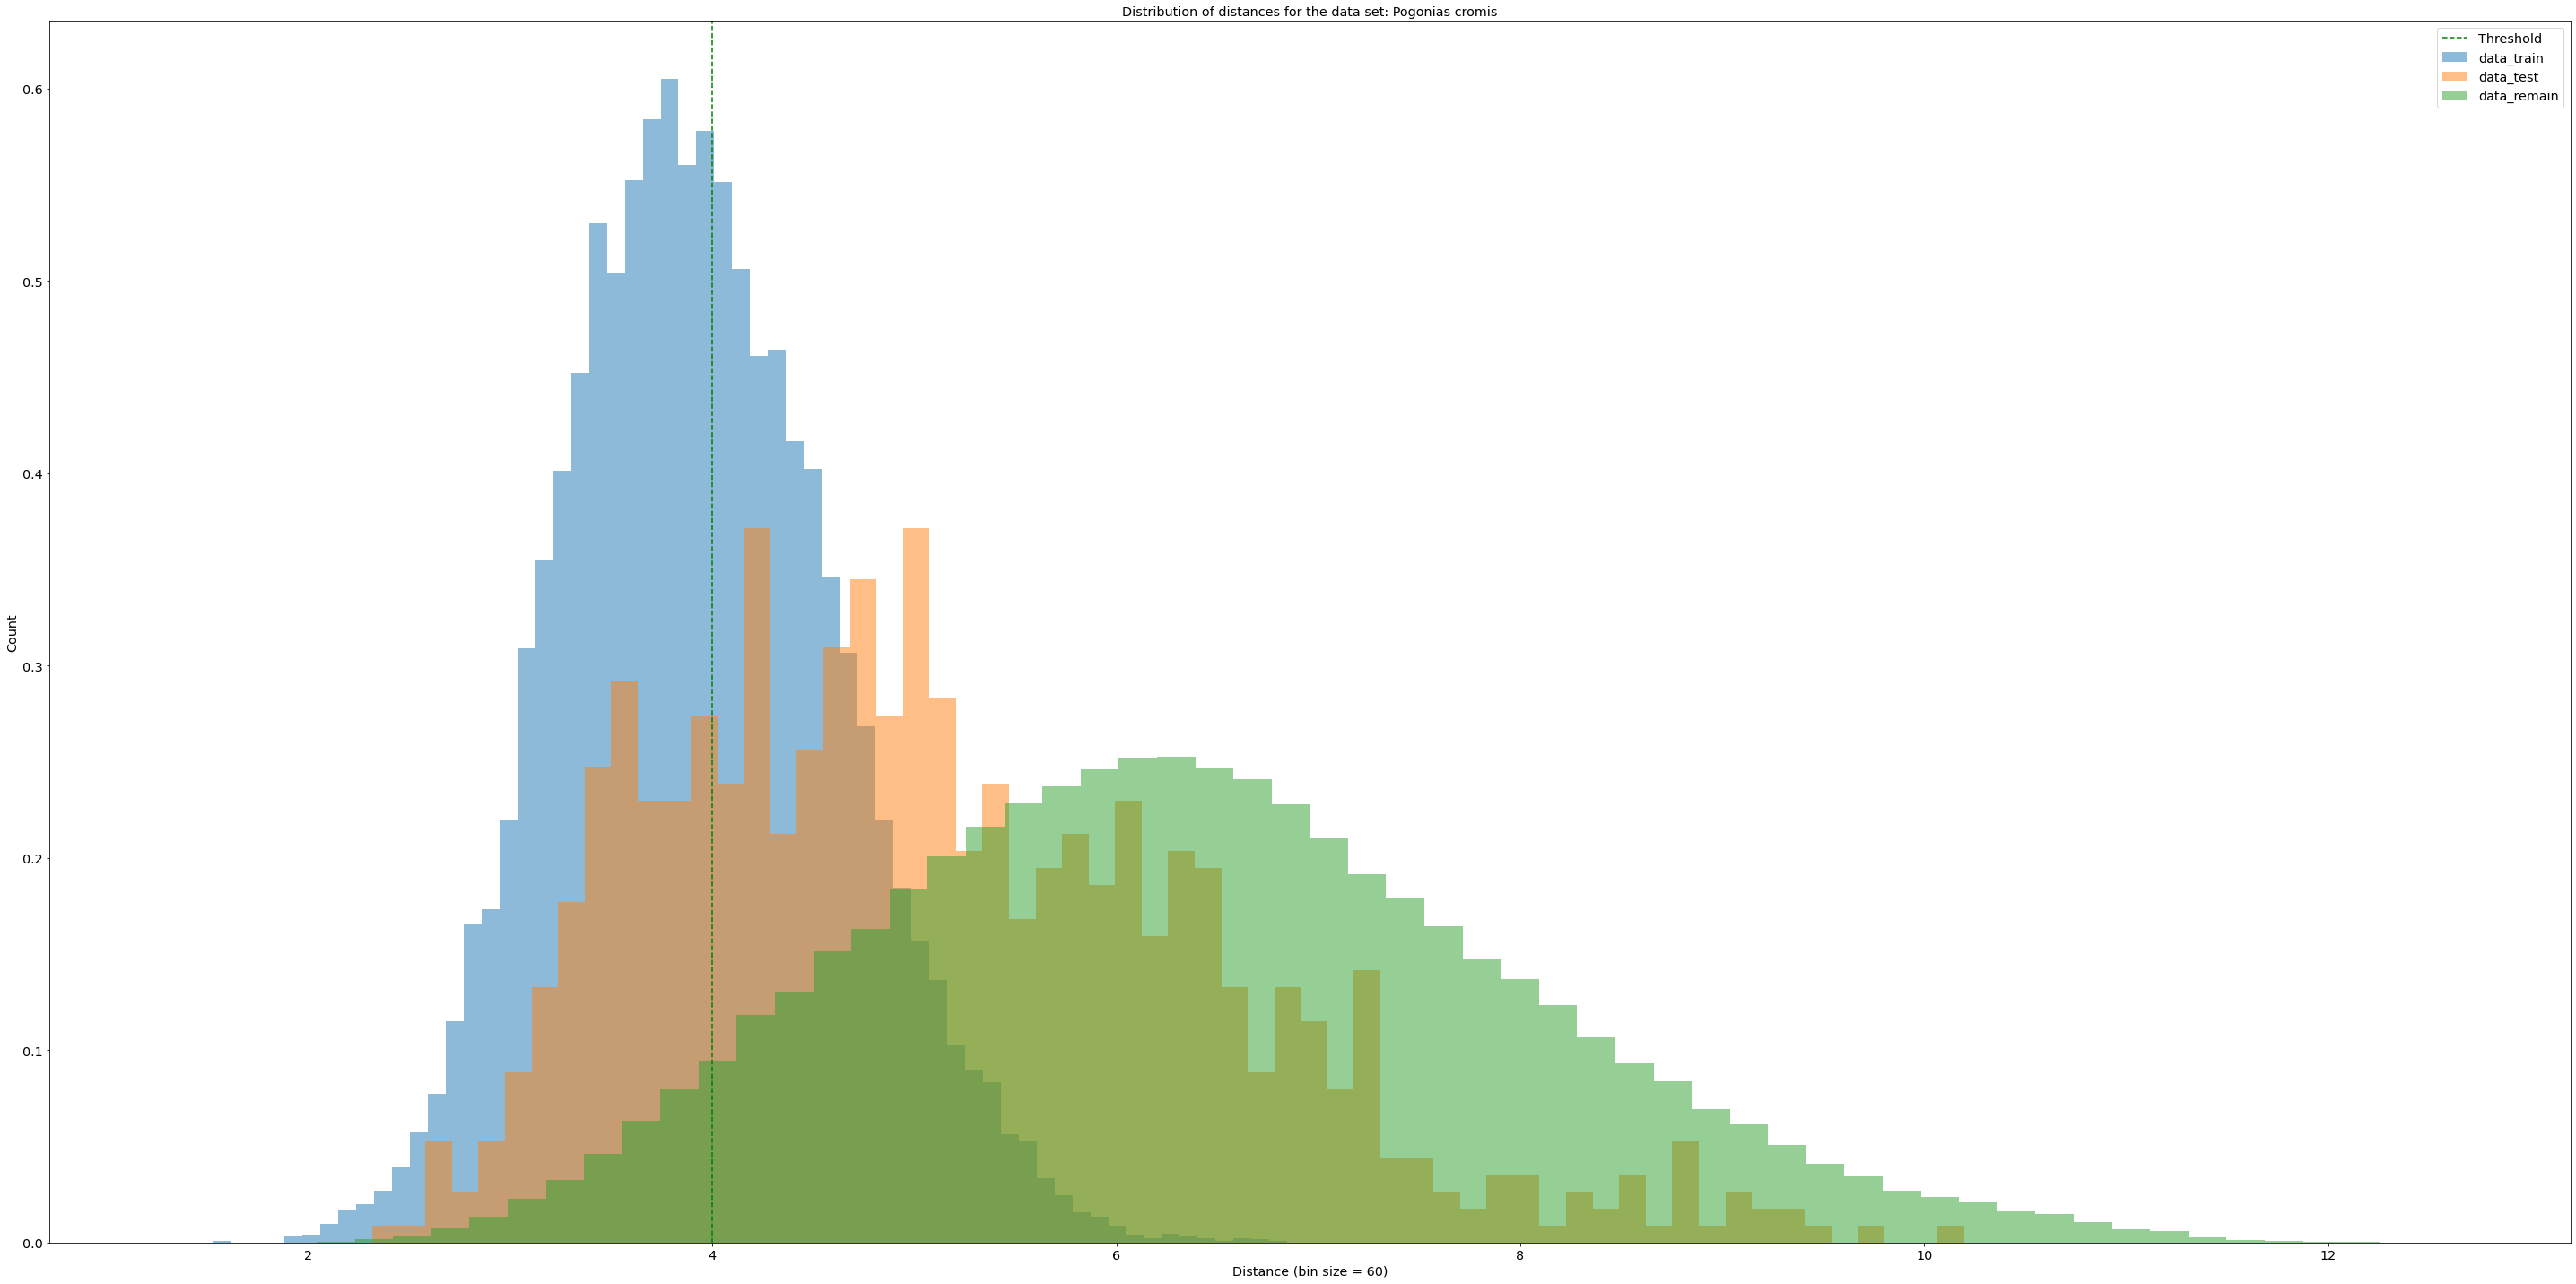

Train: 18632 Test: 1122 Remain: 0


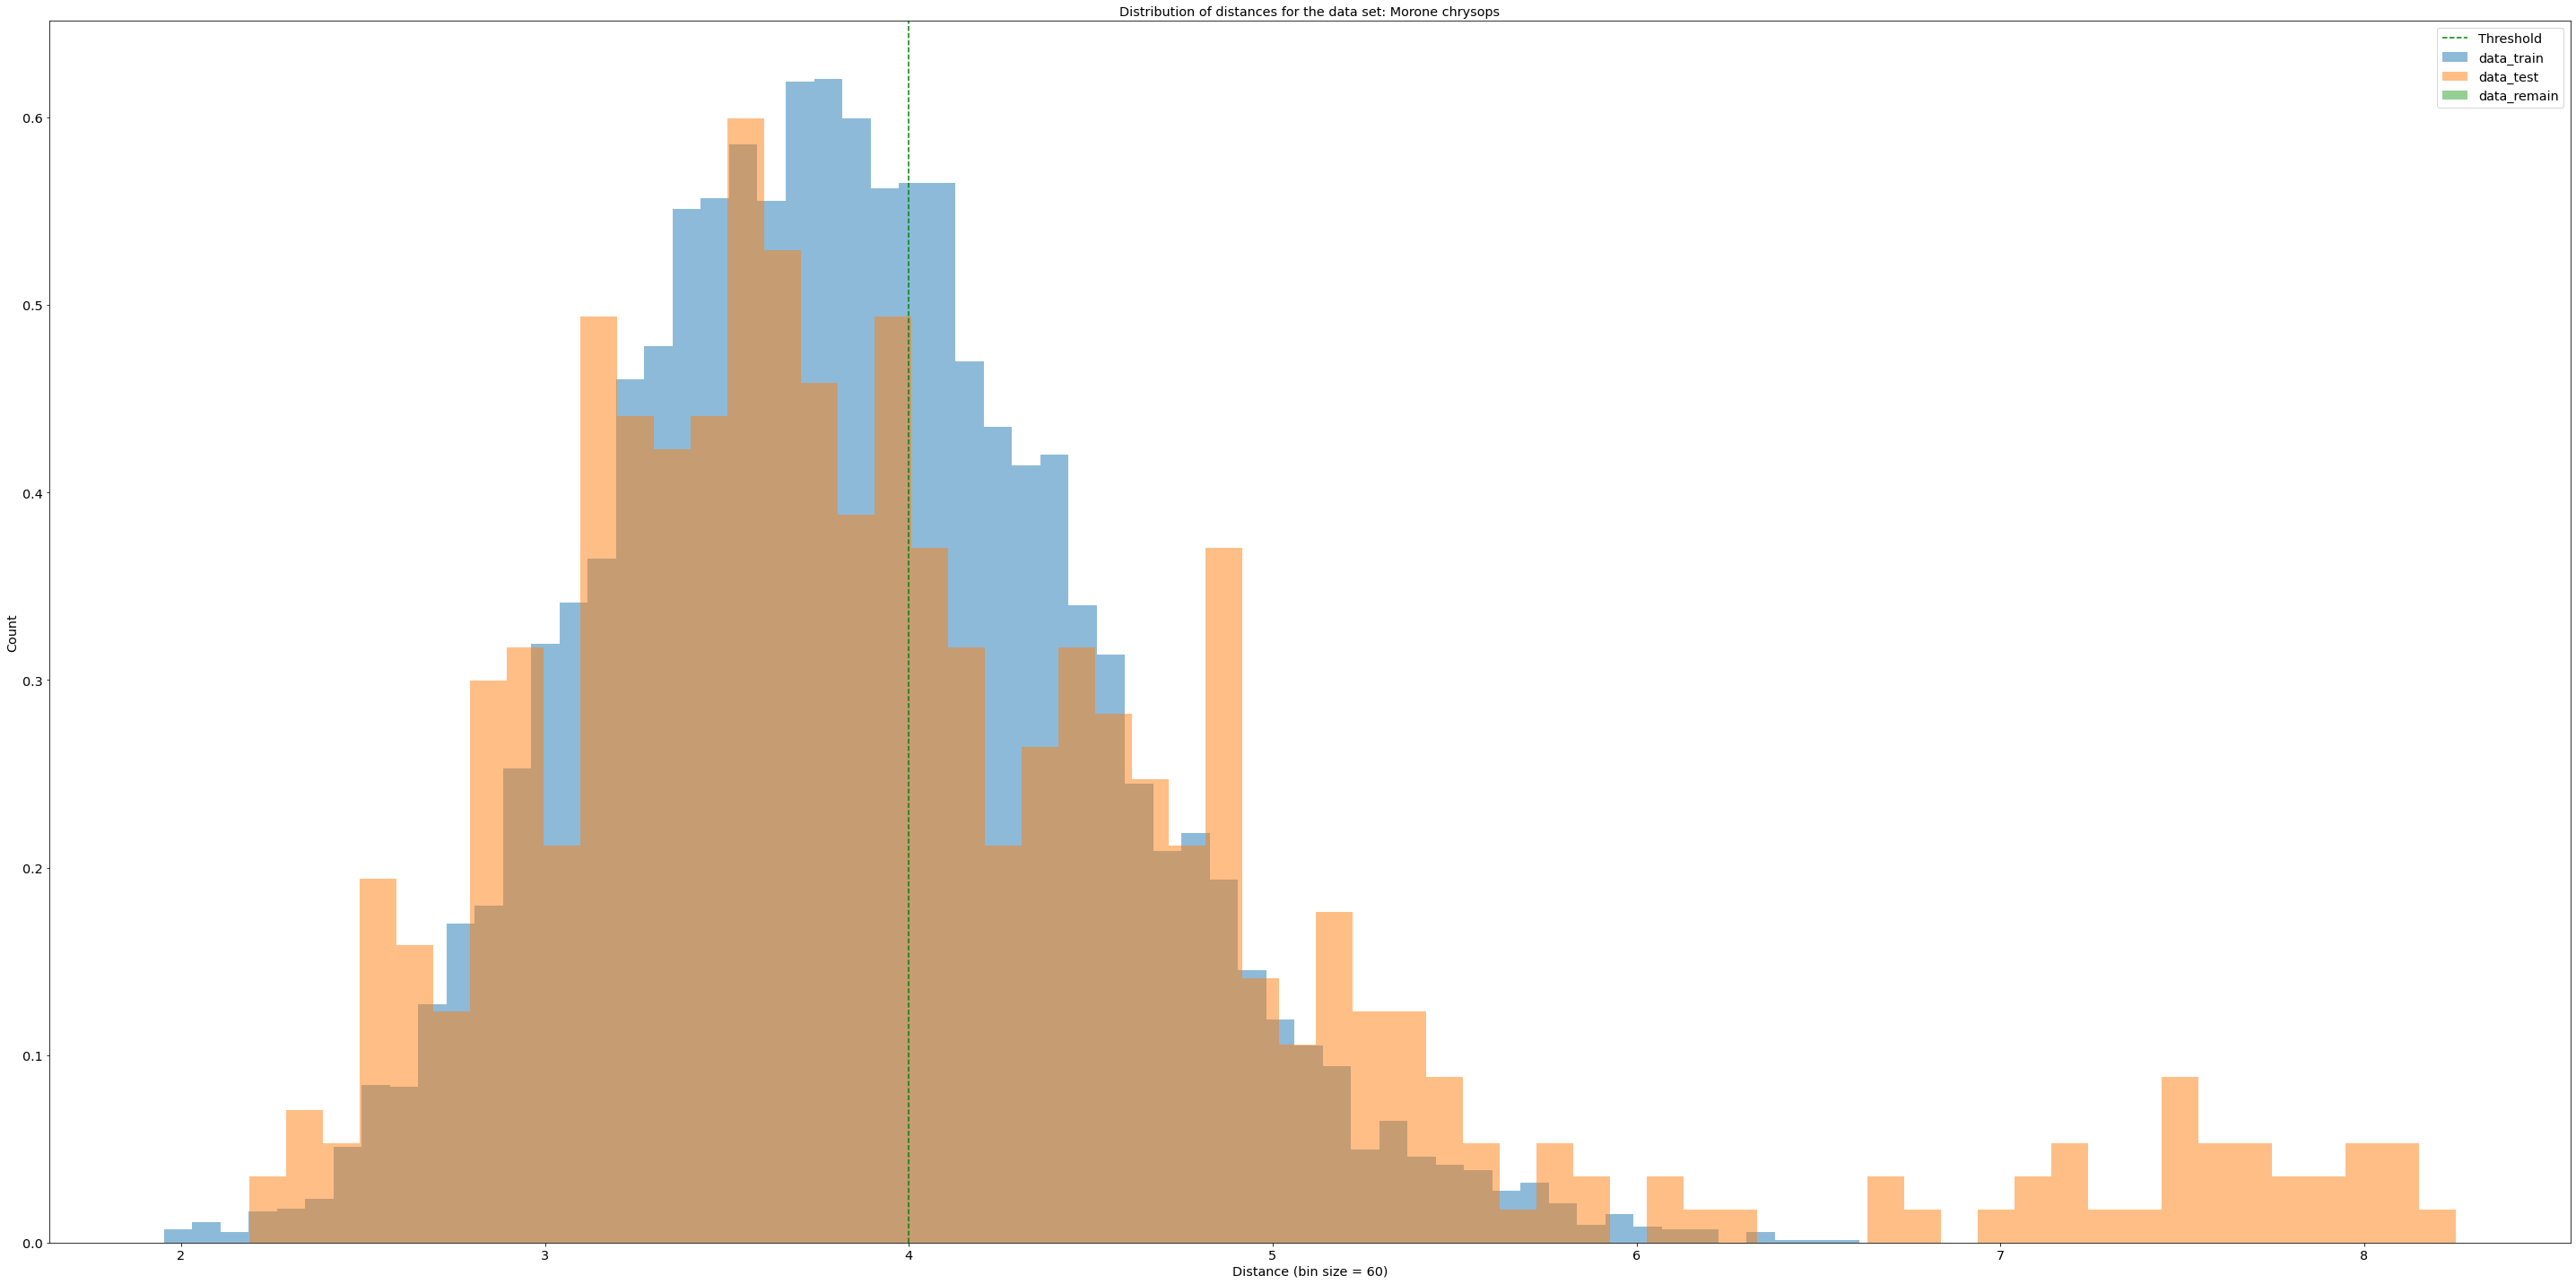

Train: 28392 Test: 1722 Remain: 342


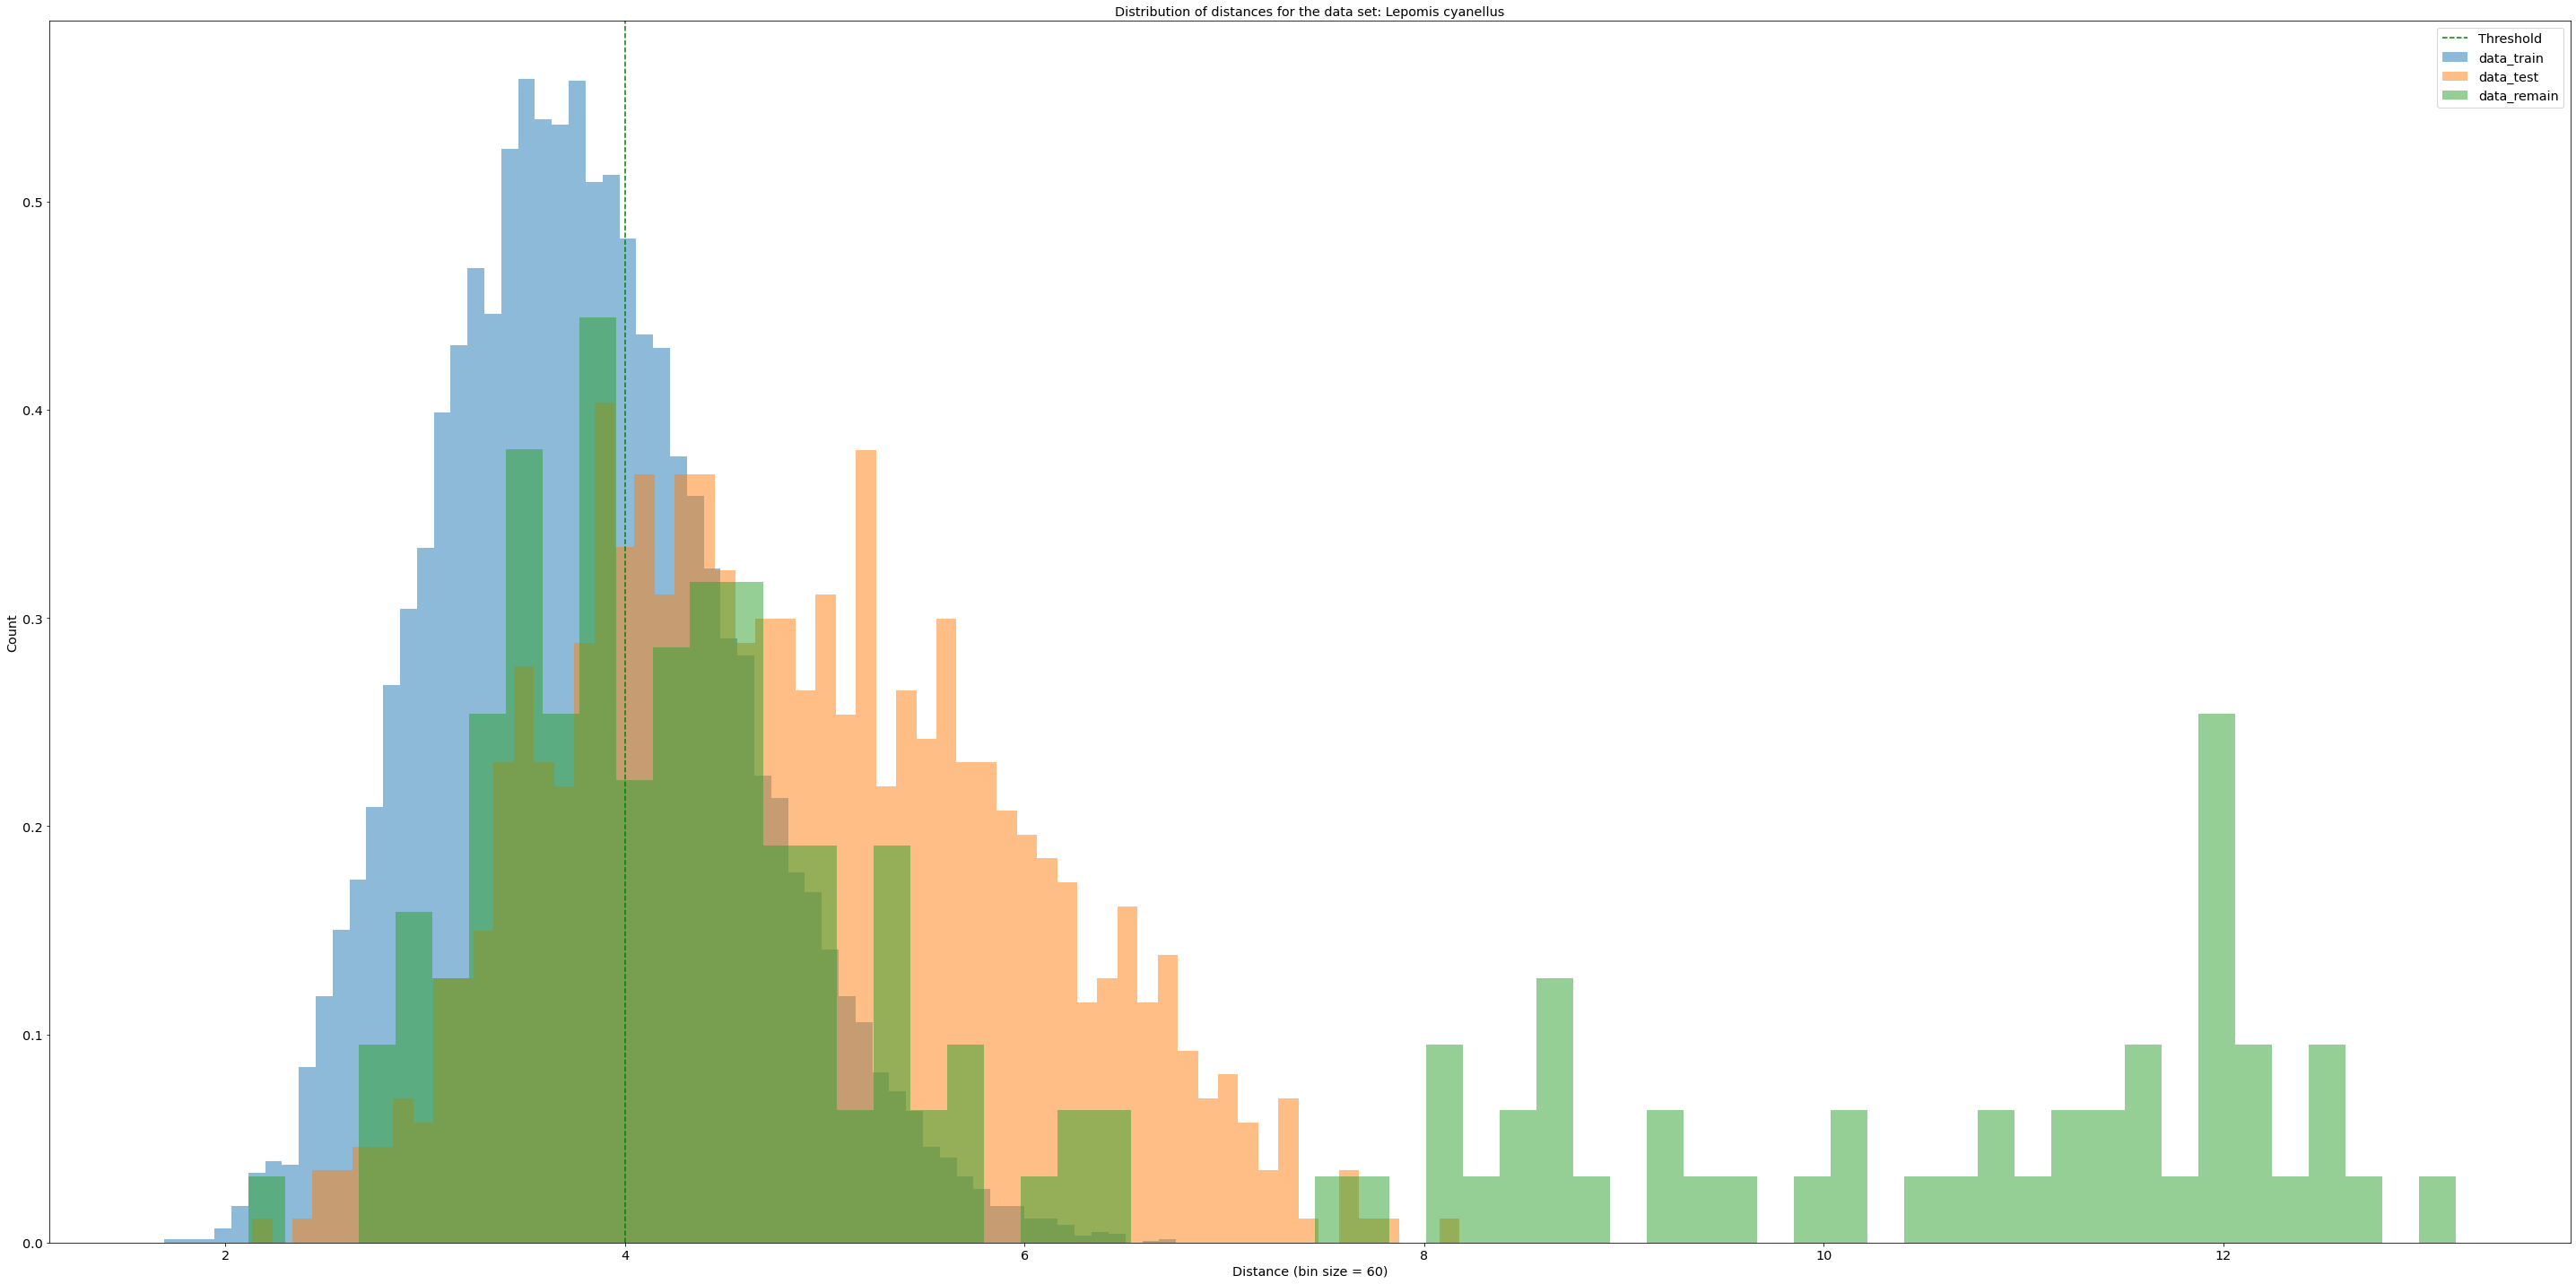

Train: 20592 Test: 1260 Remain: 0


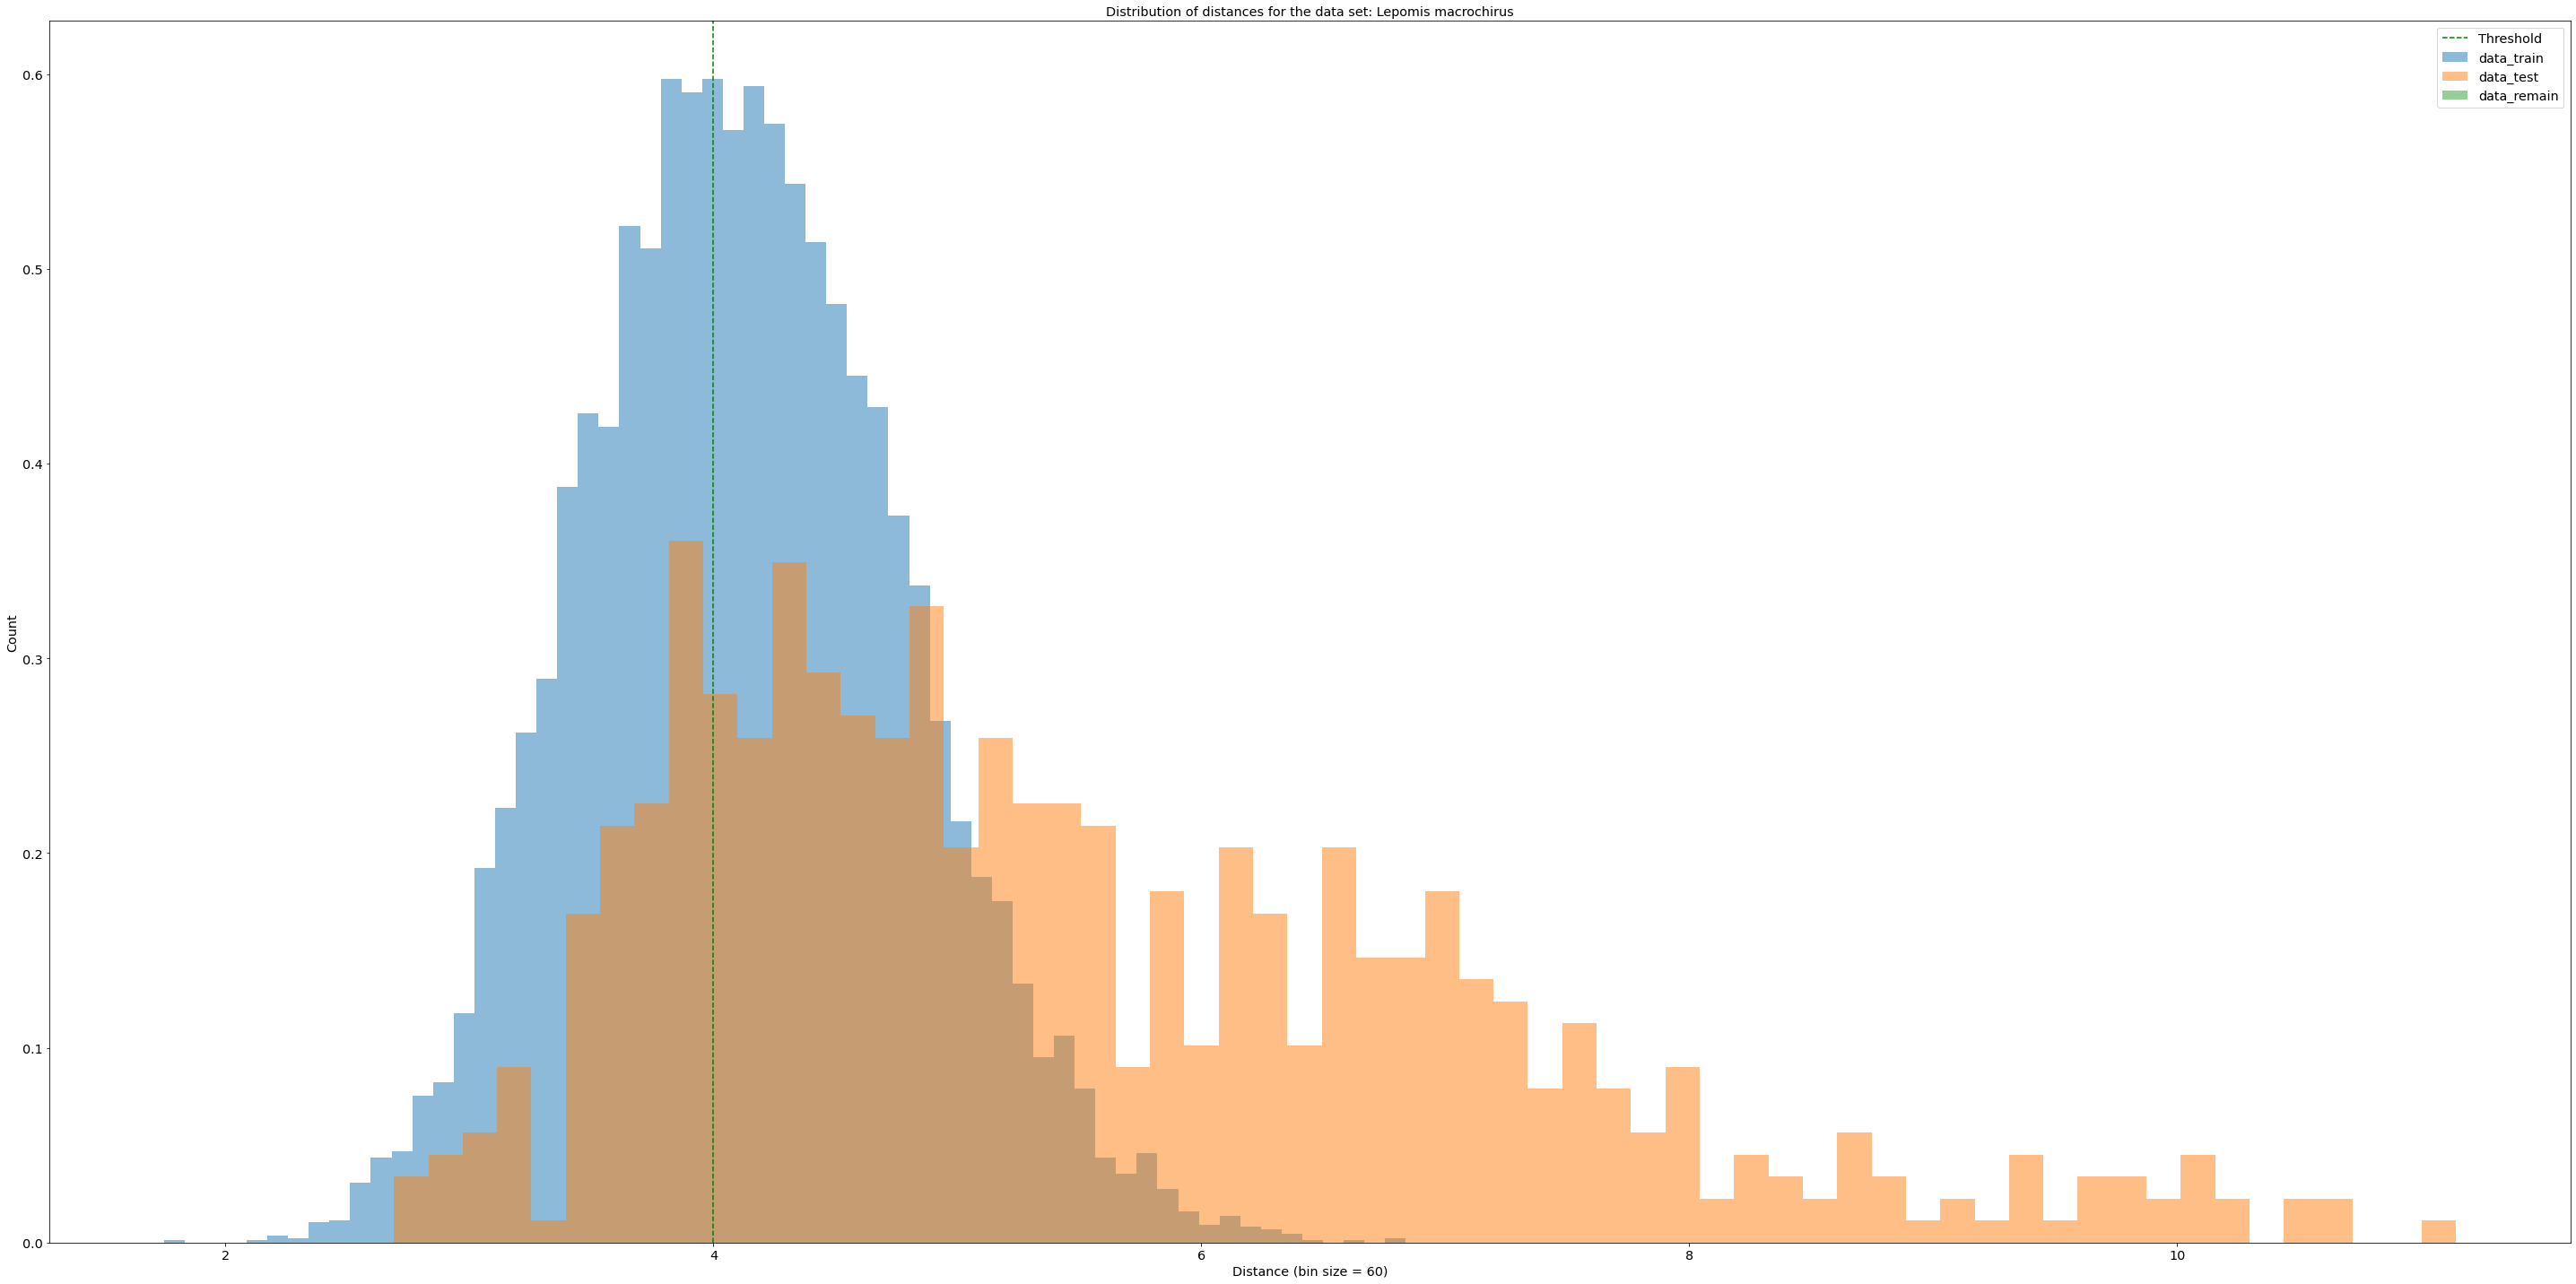

Train: 28392 Test: 1722 Remain: 428370


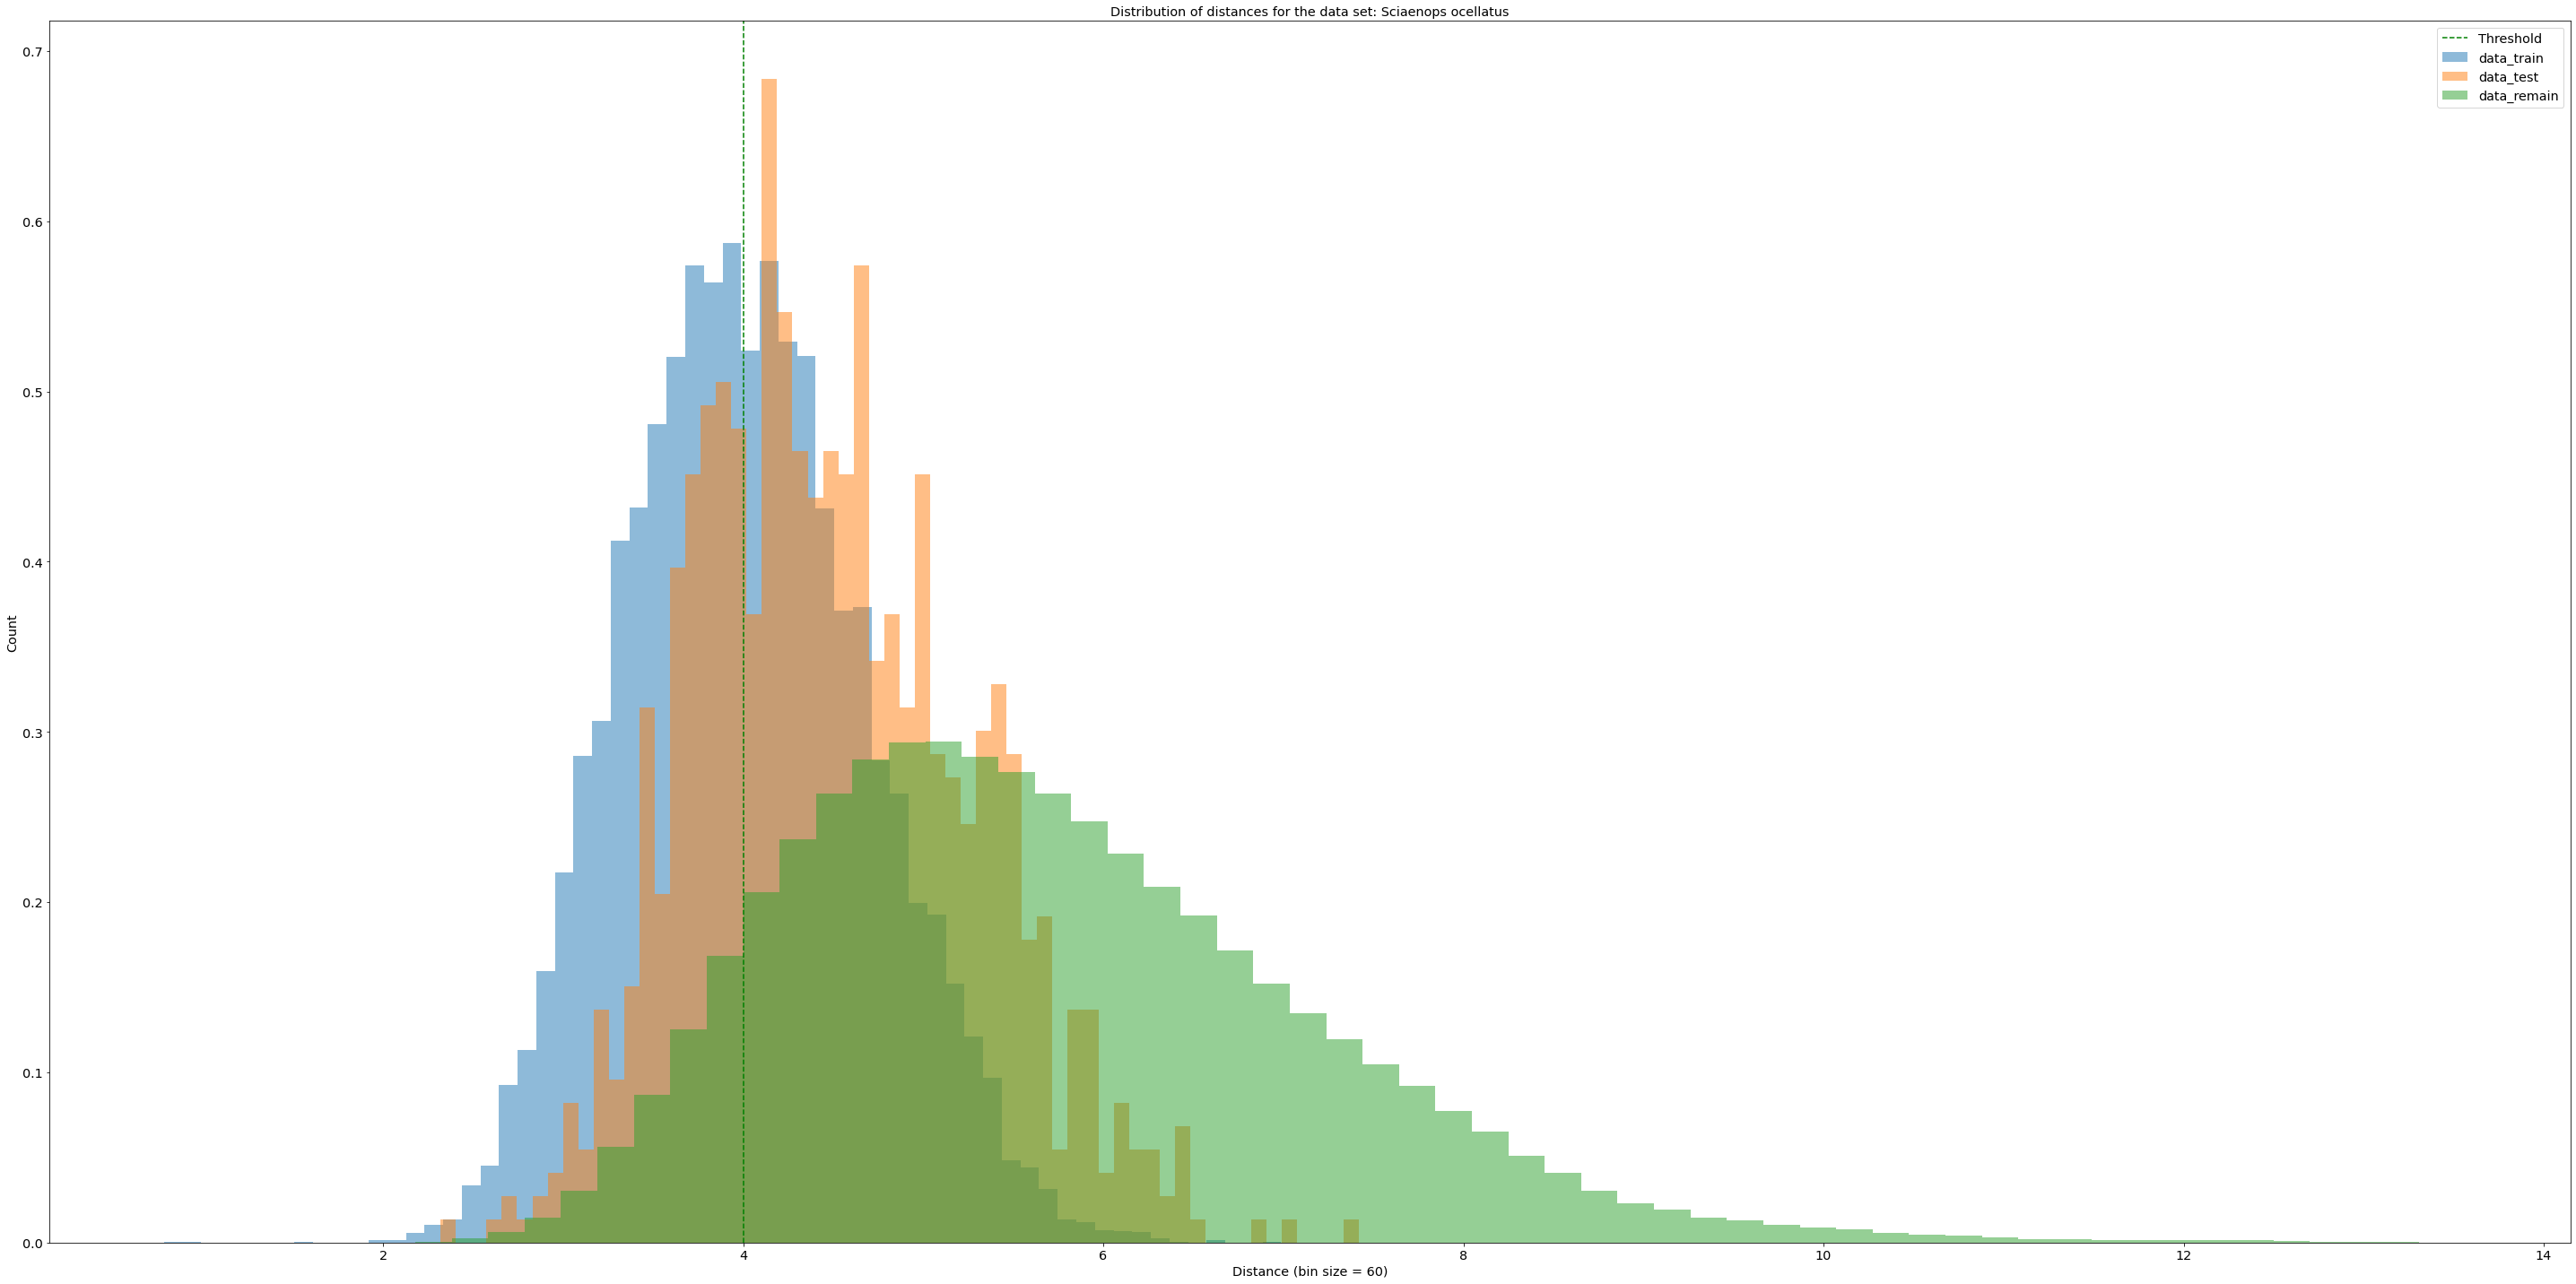

Train: 14762 Test: 870 Remain: 0


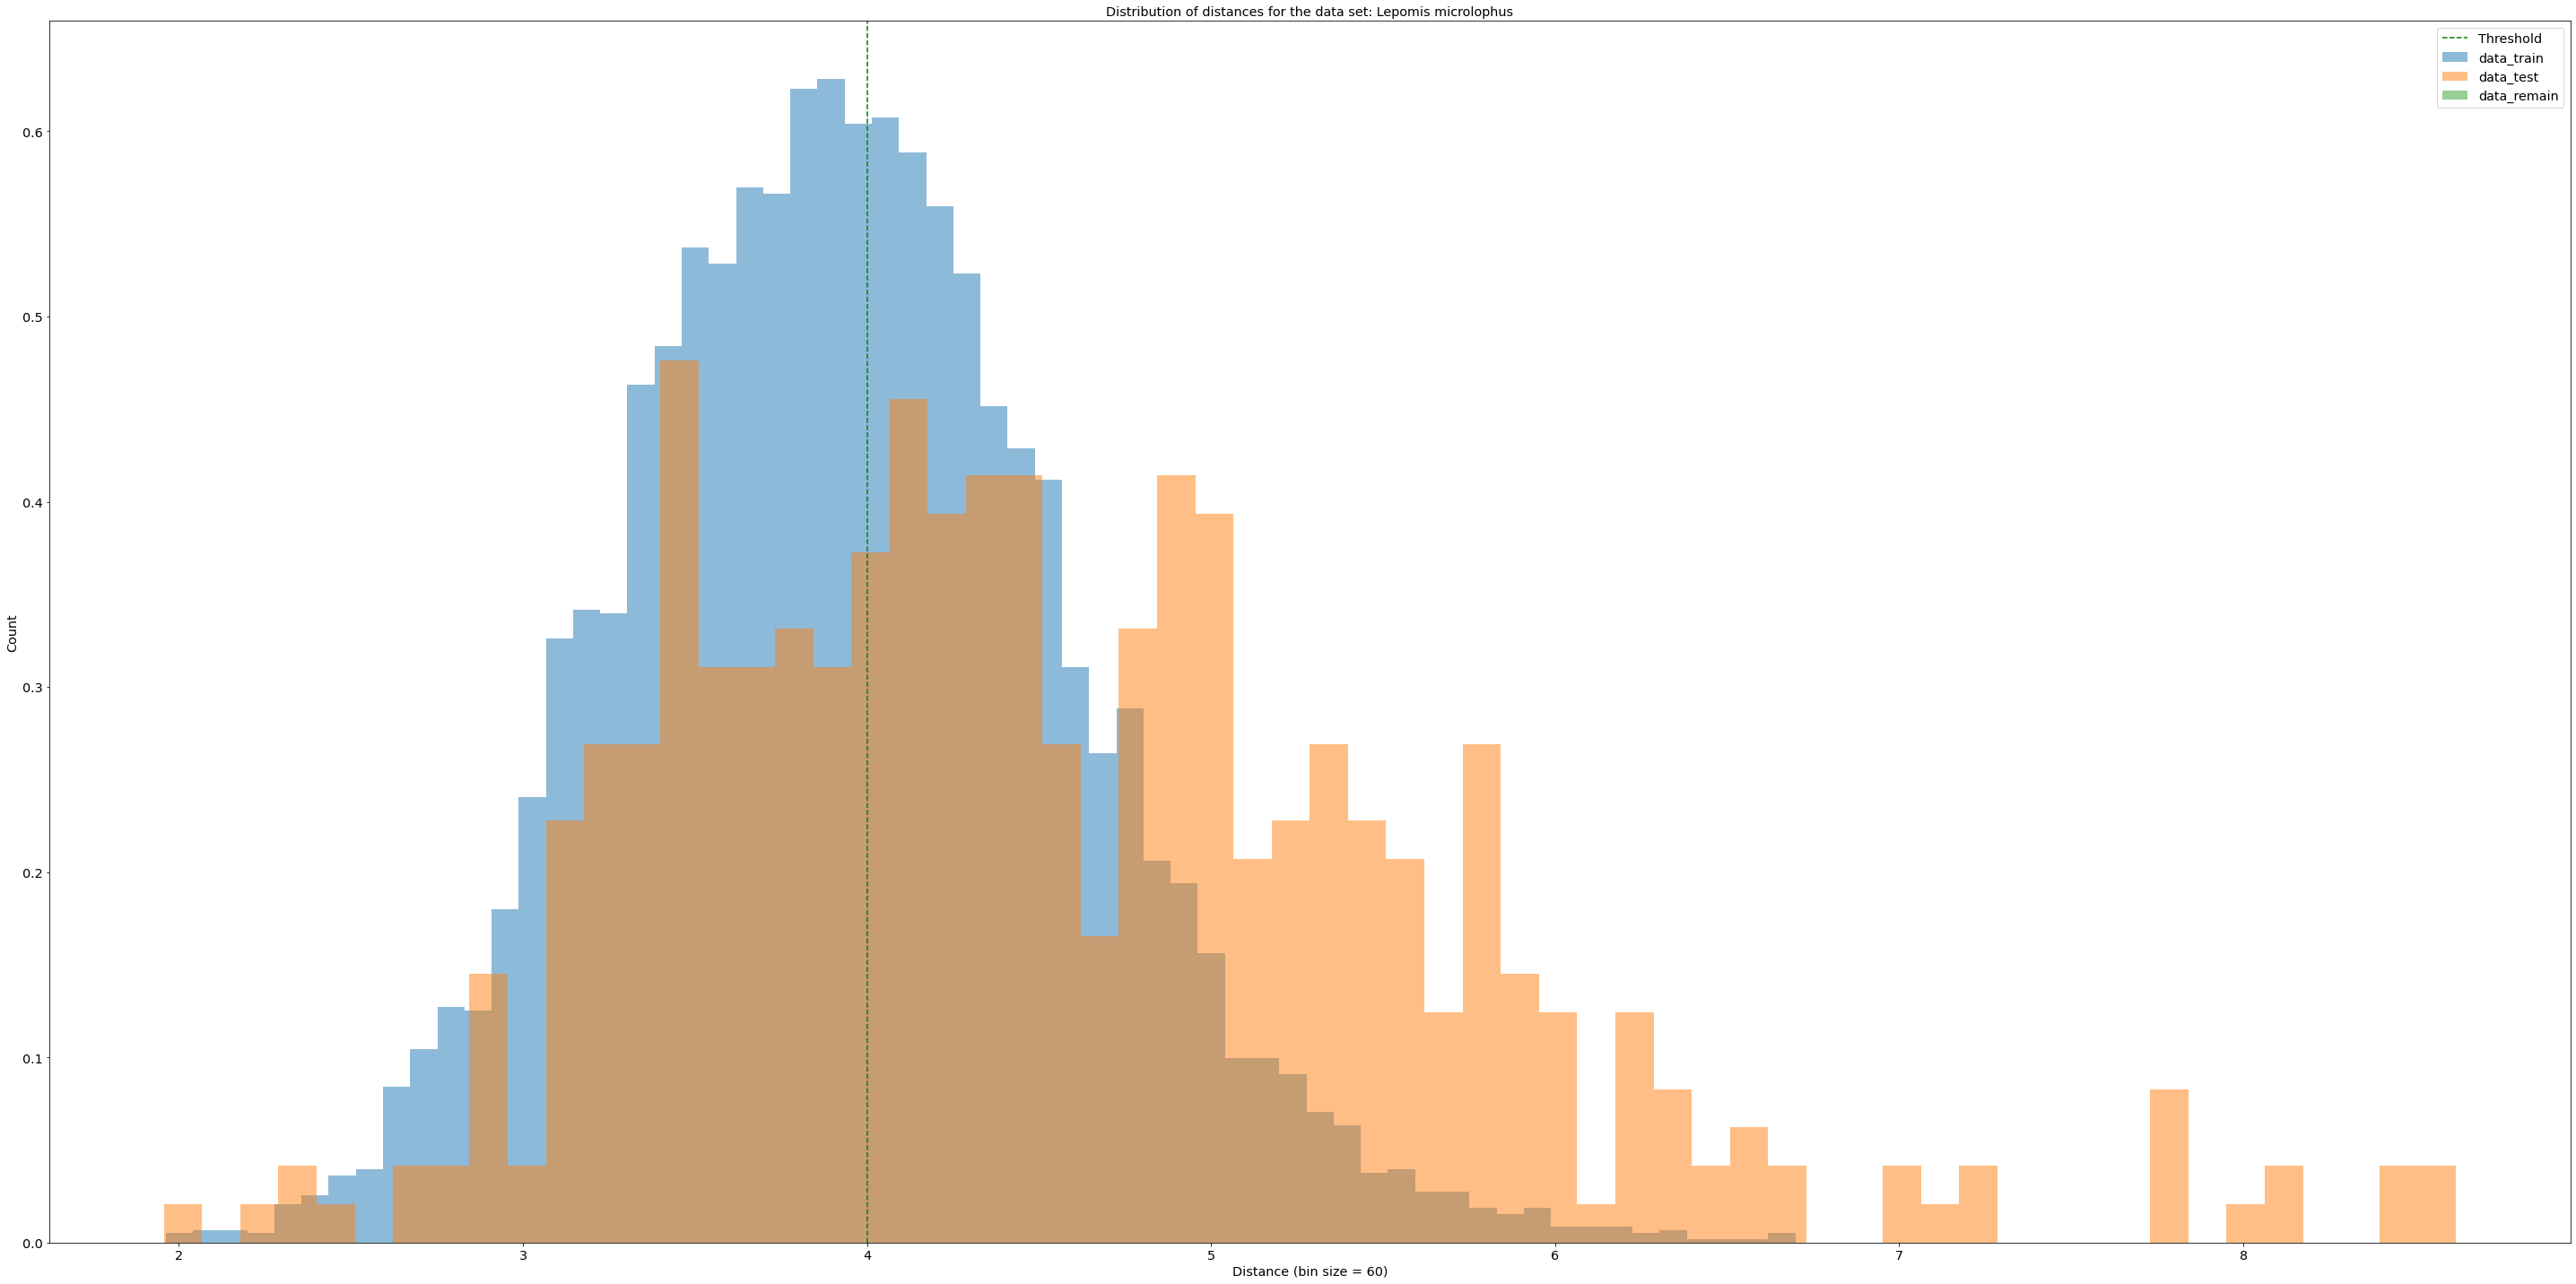

Train: 9312 Test: 552 Remain: 0


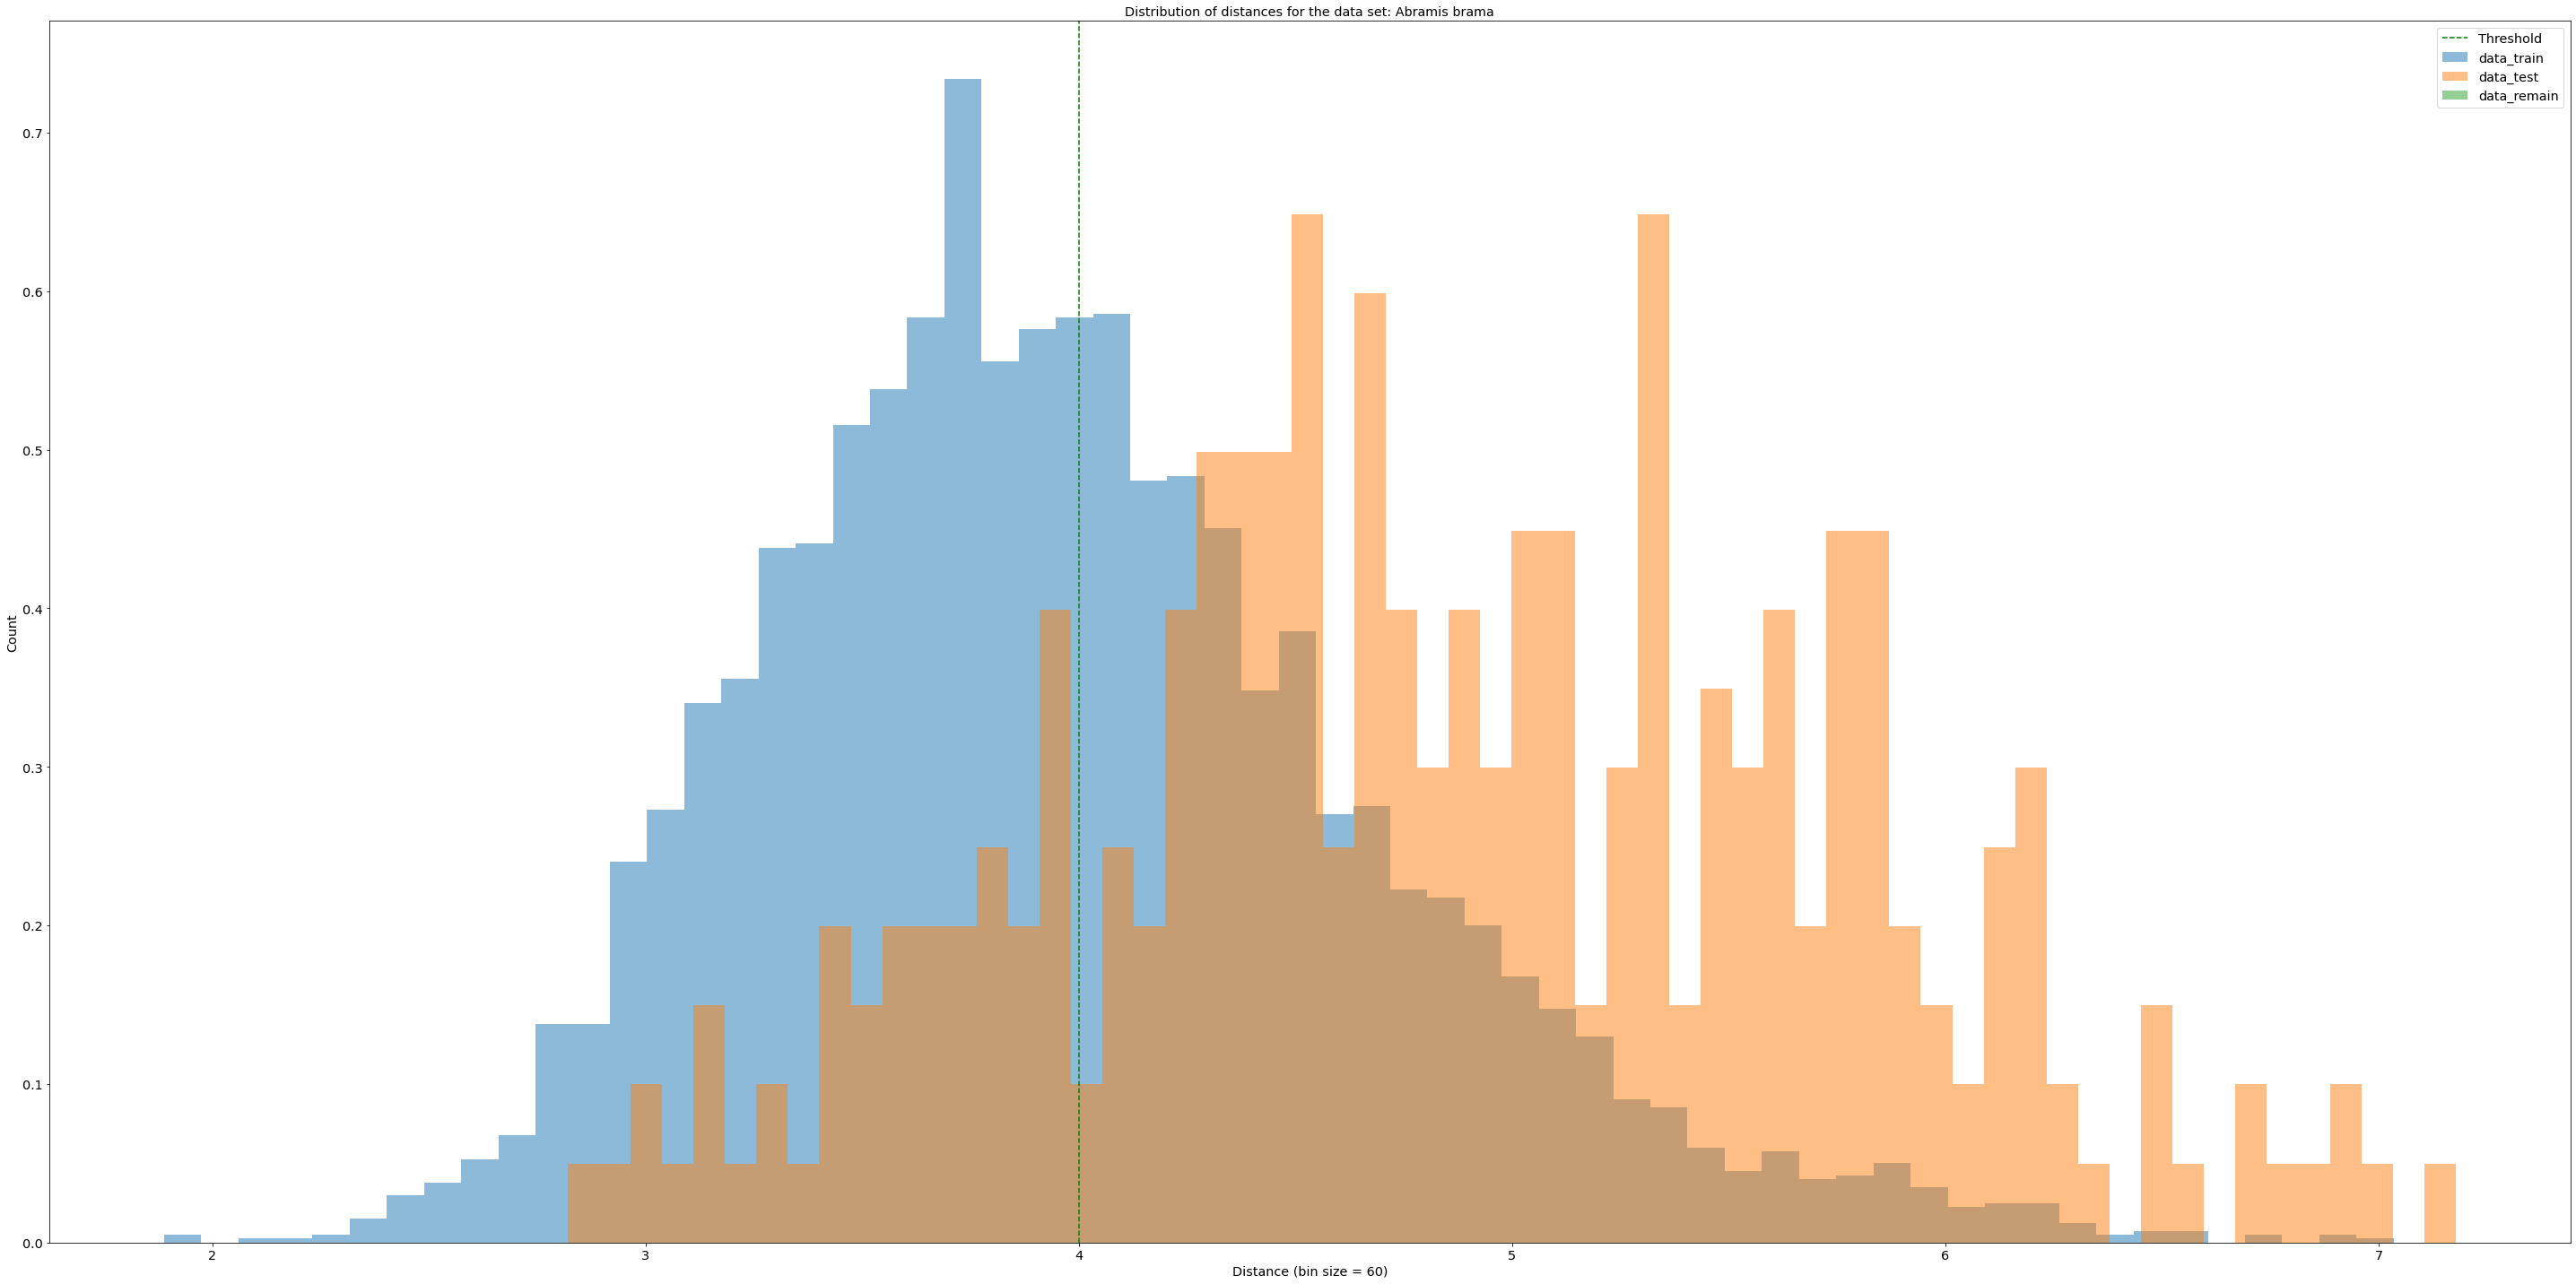

Train: 14762 Test: 870 Remain: 0


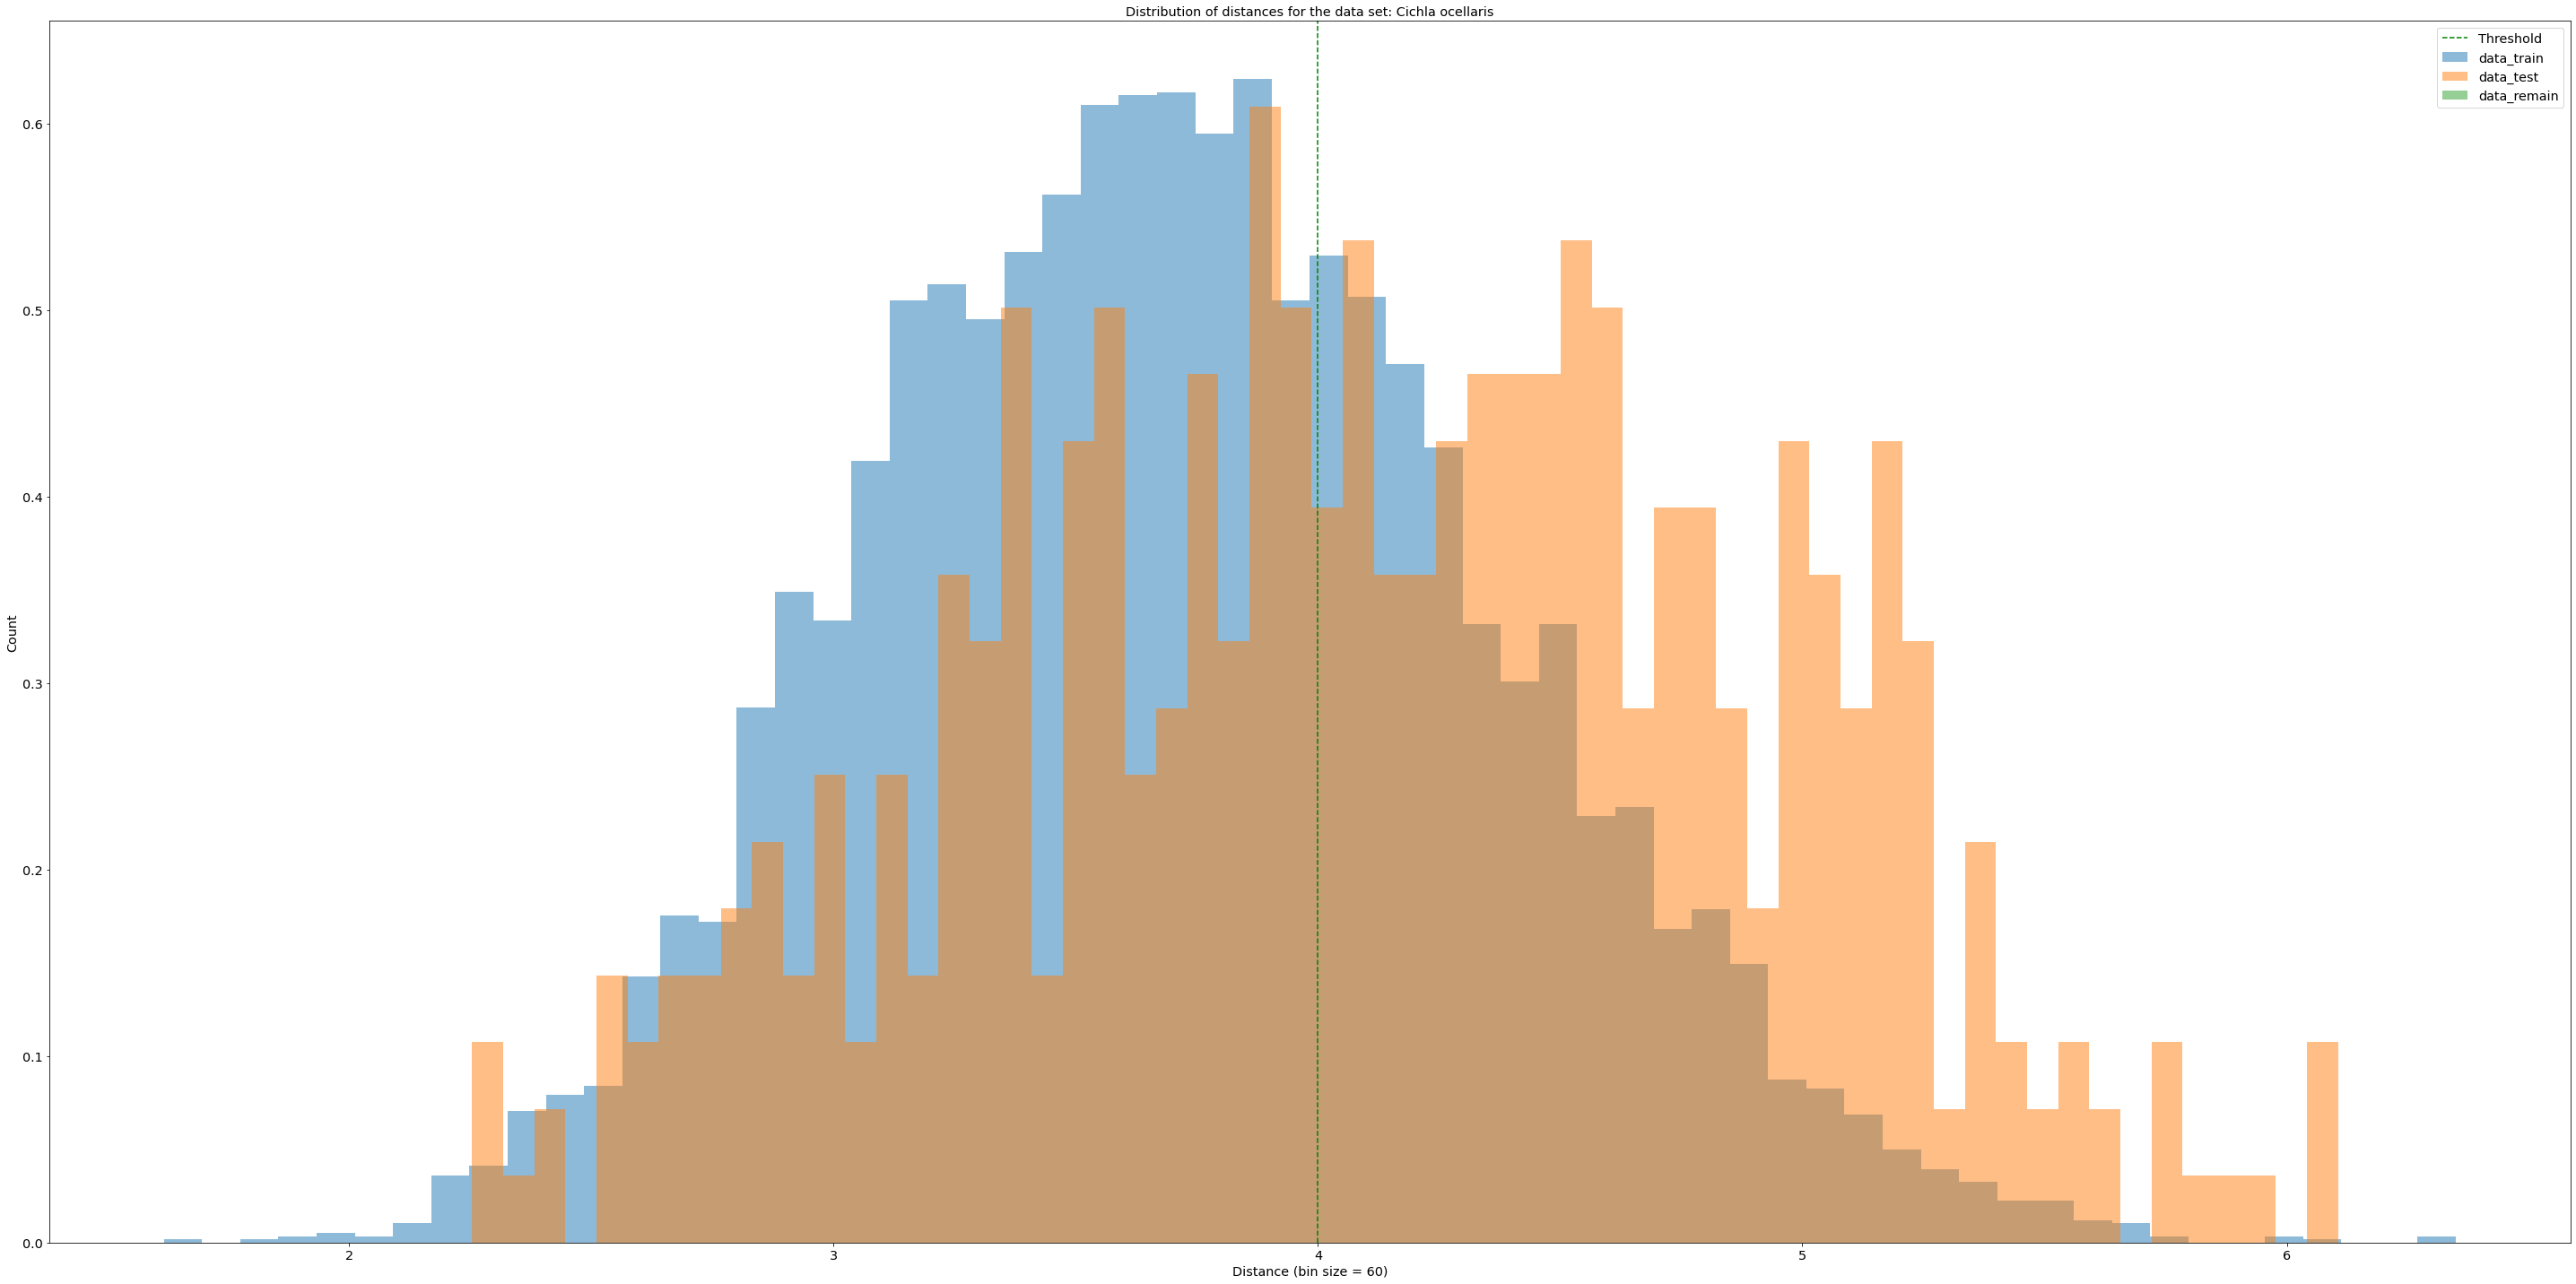

Train: 28392 Test: 1722 Remain: 18090


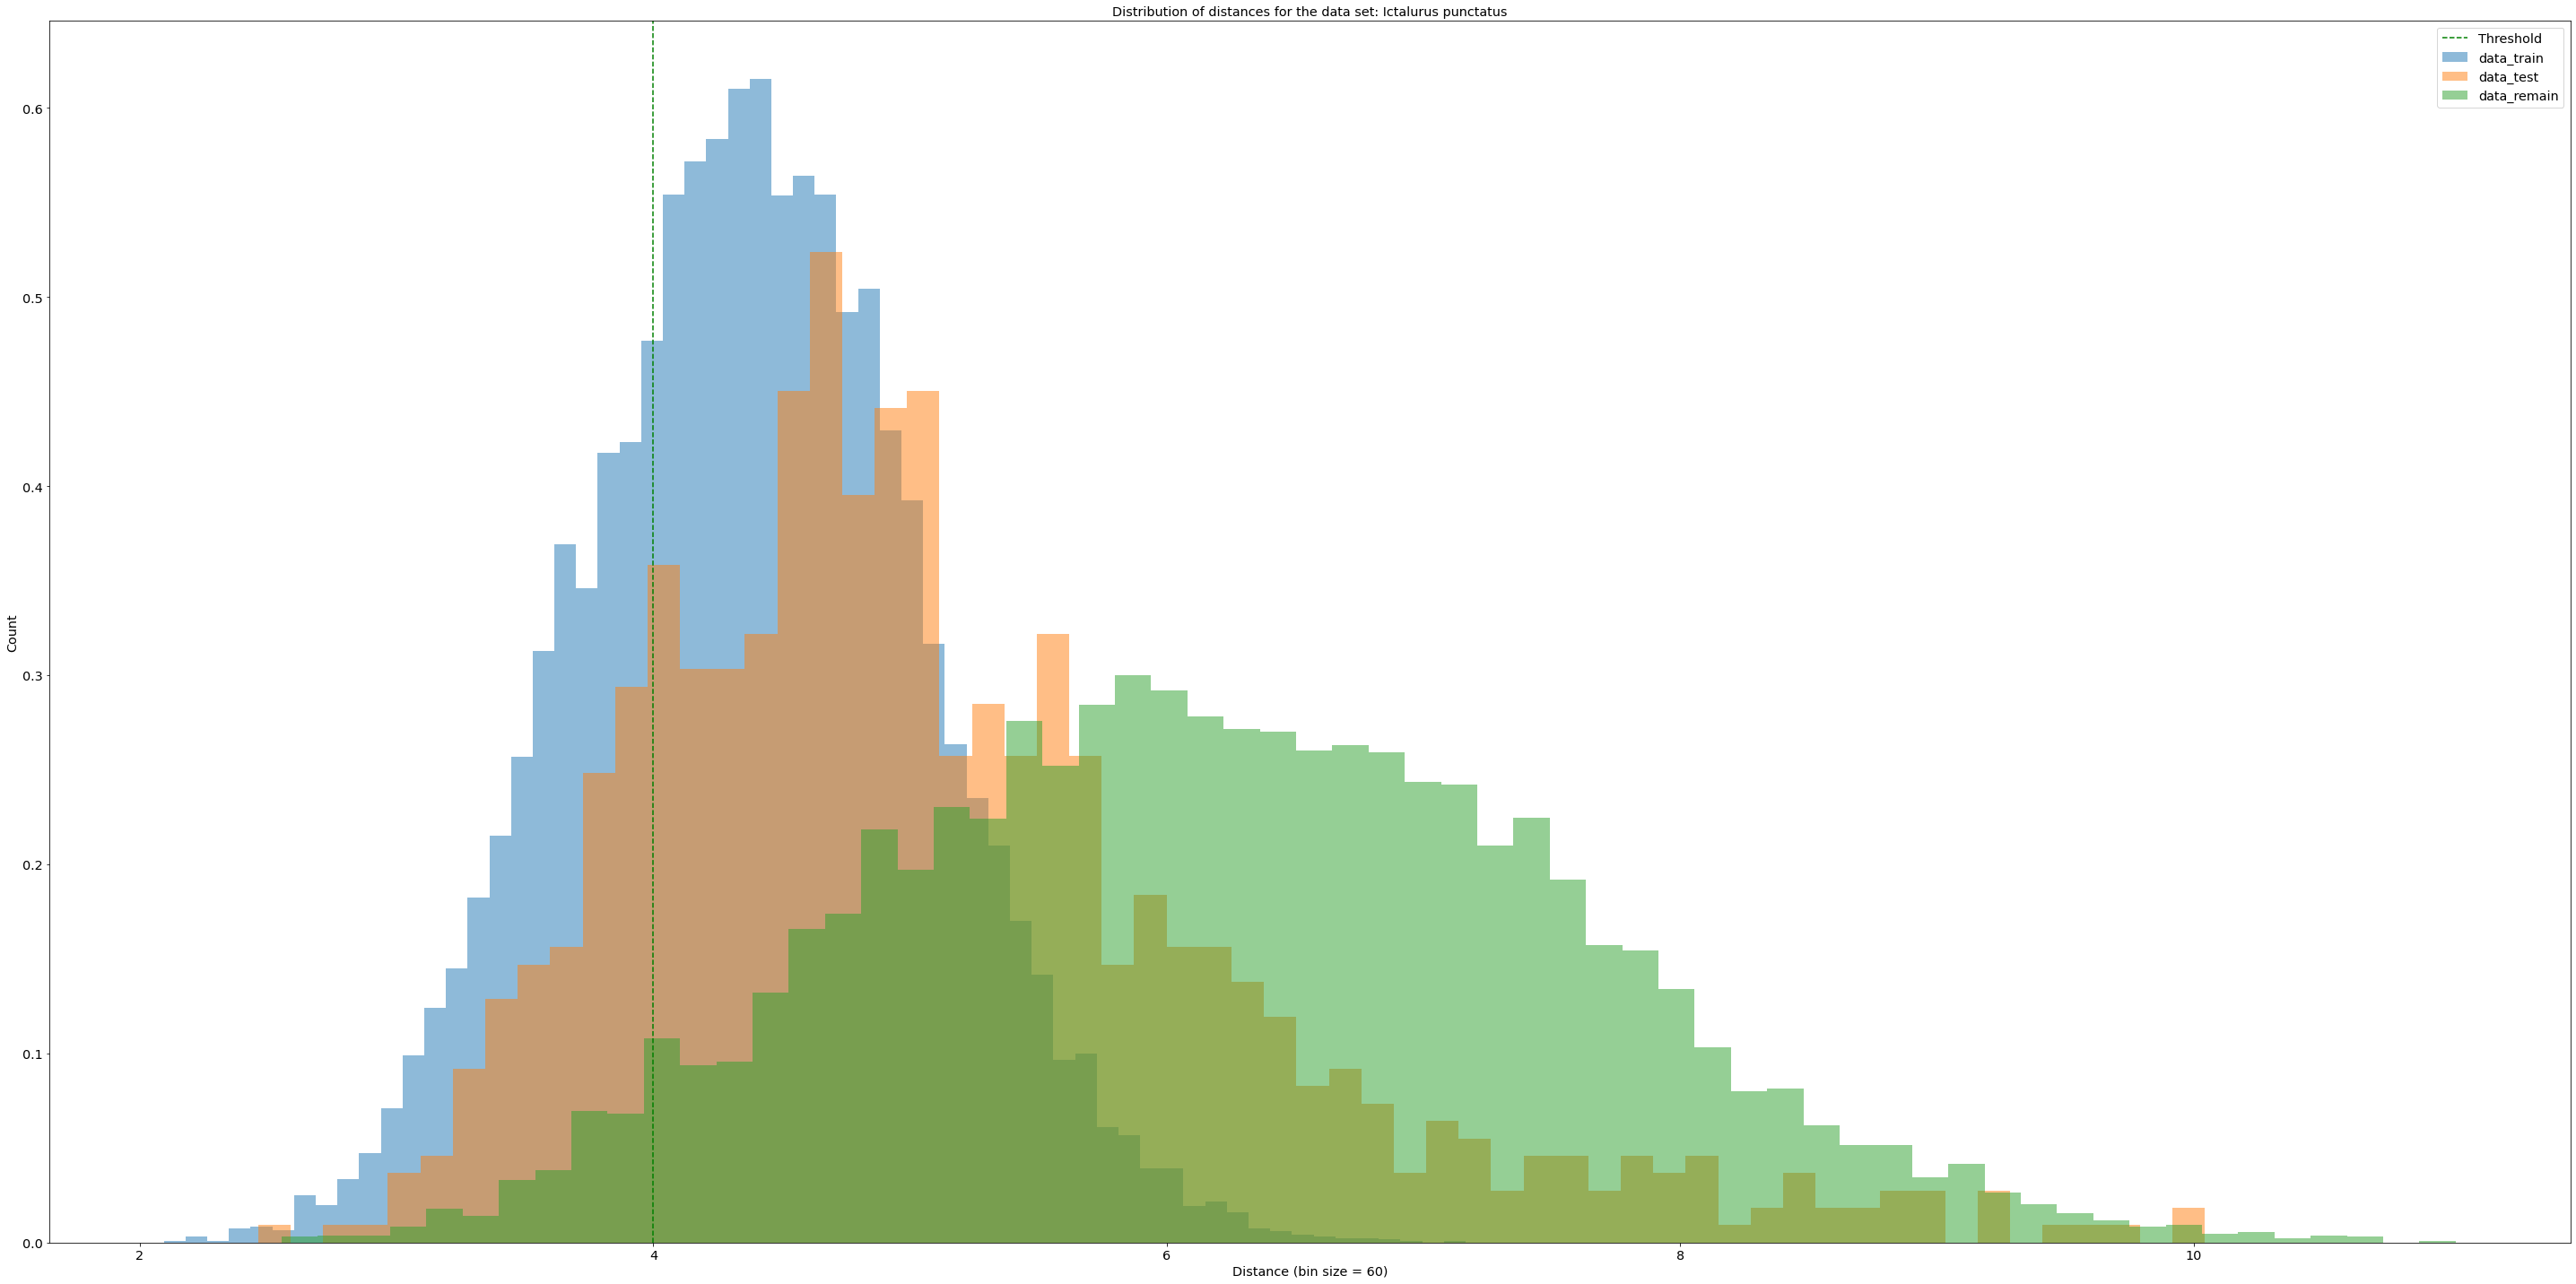

Train: 2162 Test: 210 Remain: 0


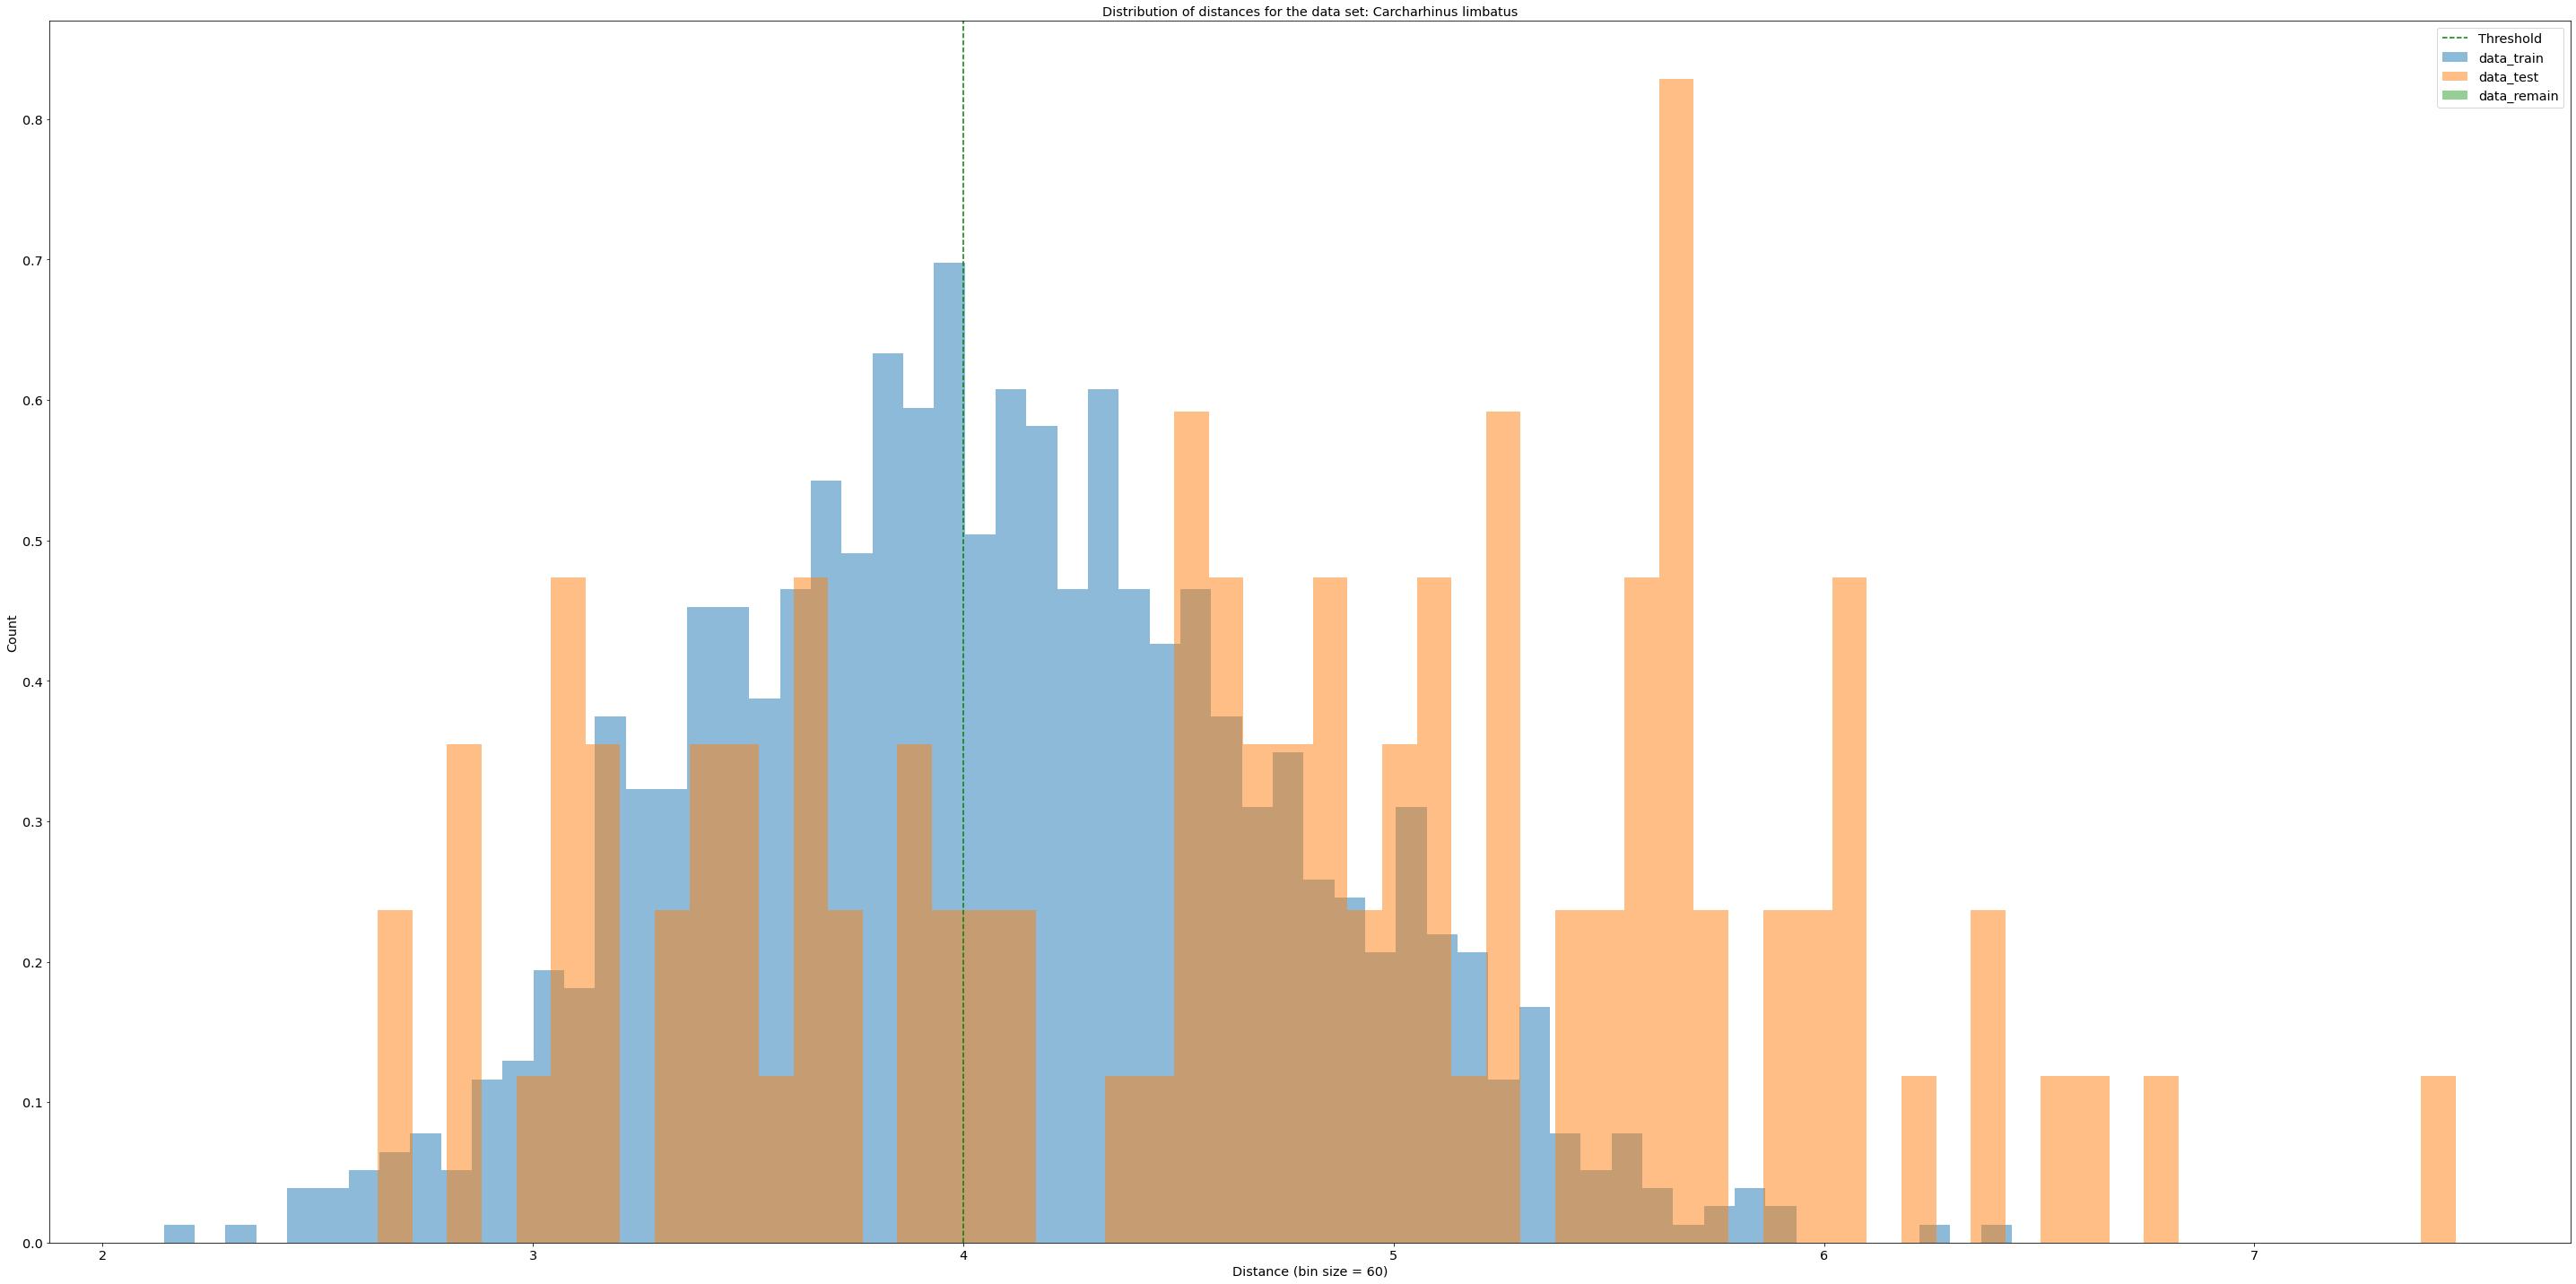

Train: 5256 Test: 342 Remain: 0


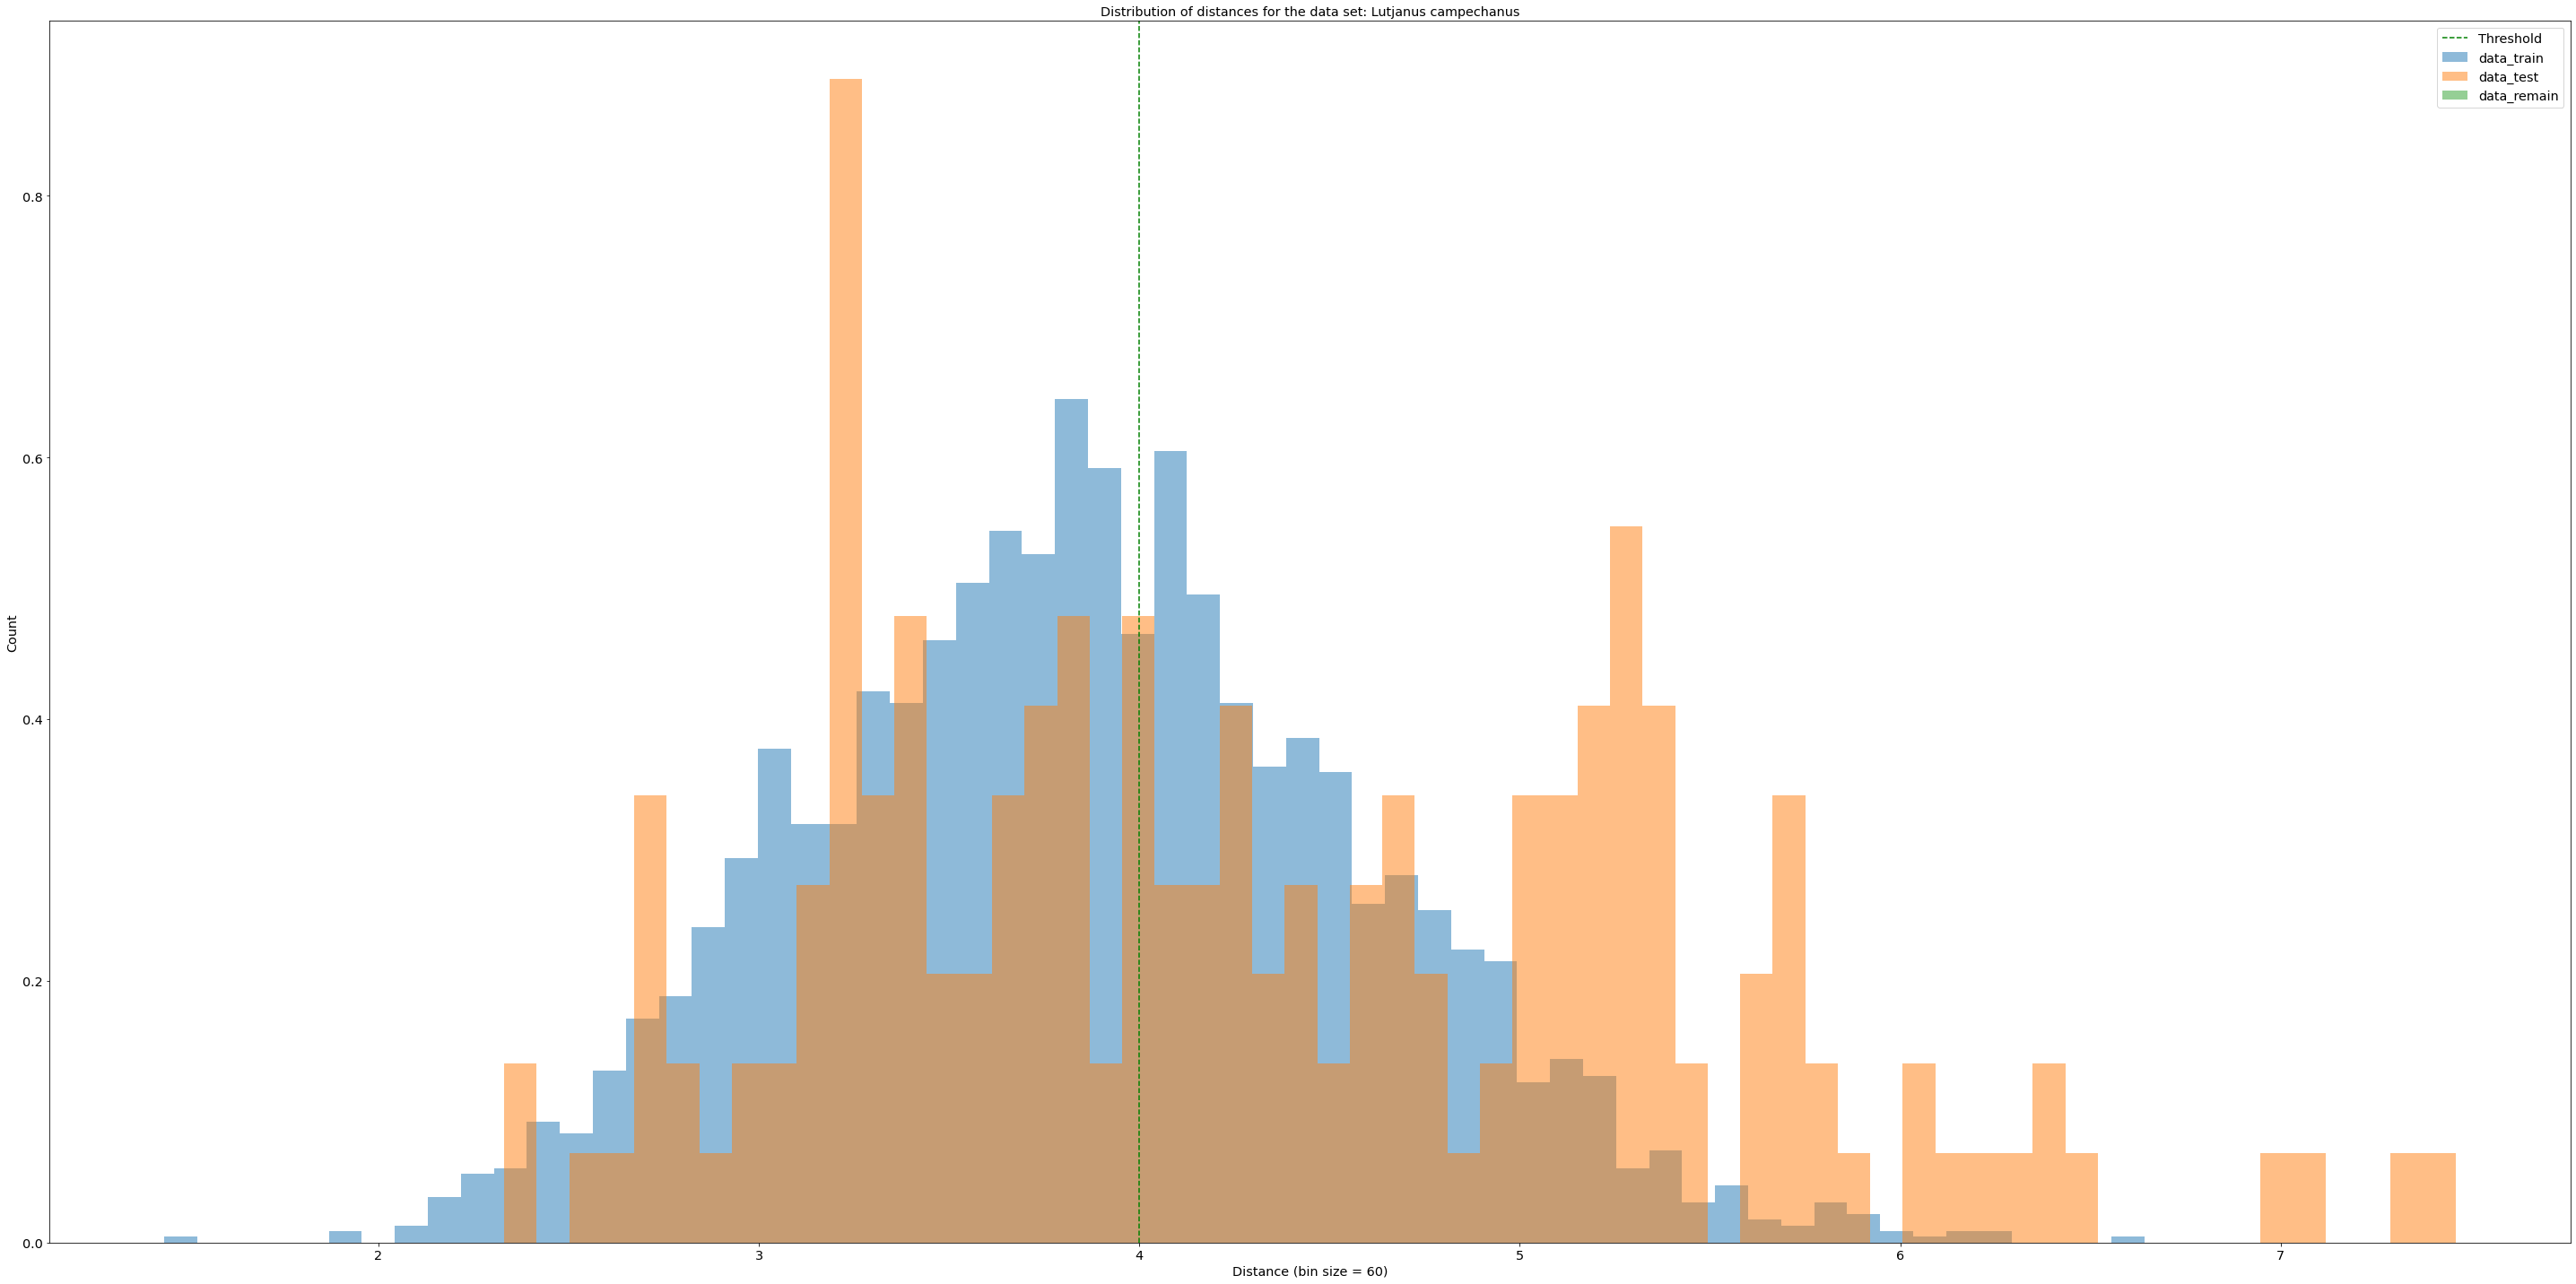

Train: 28392 Test: 1722 Remain: 1167480


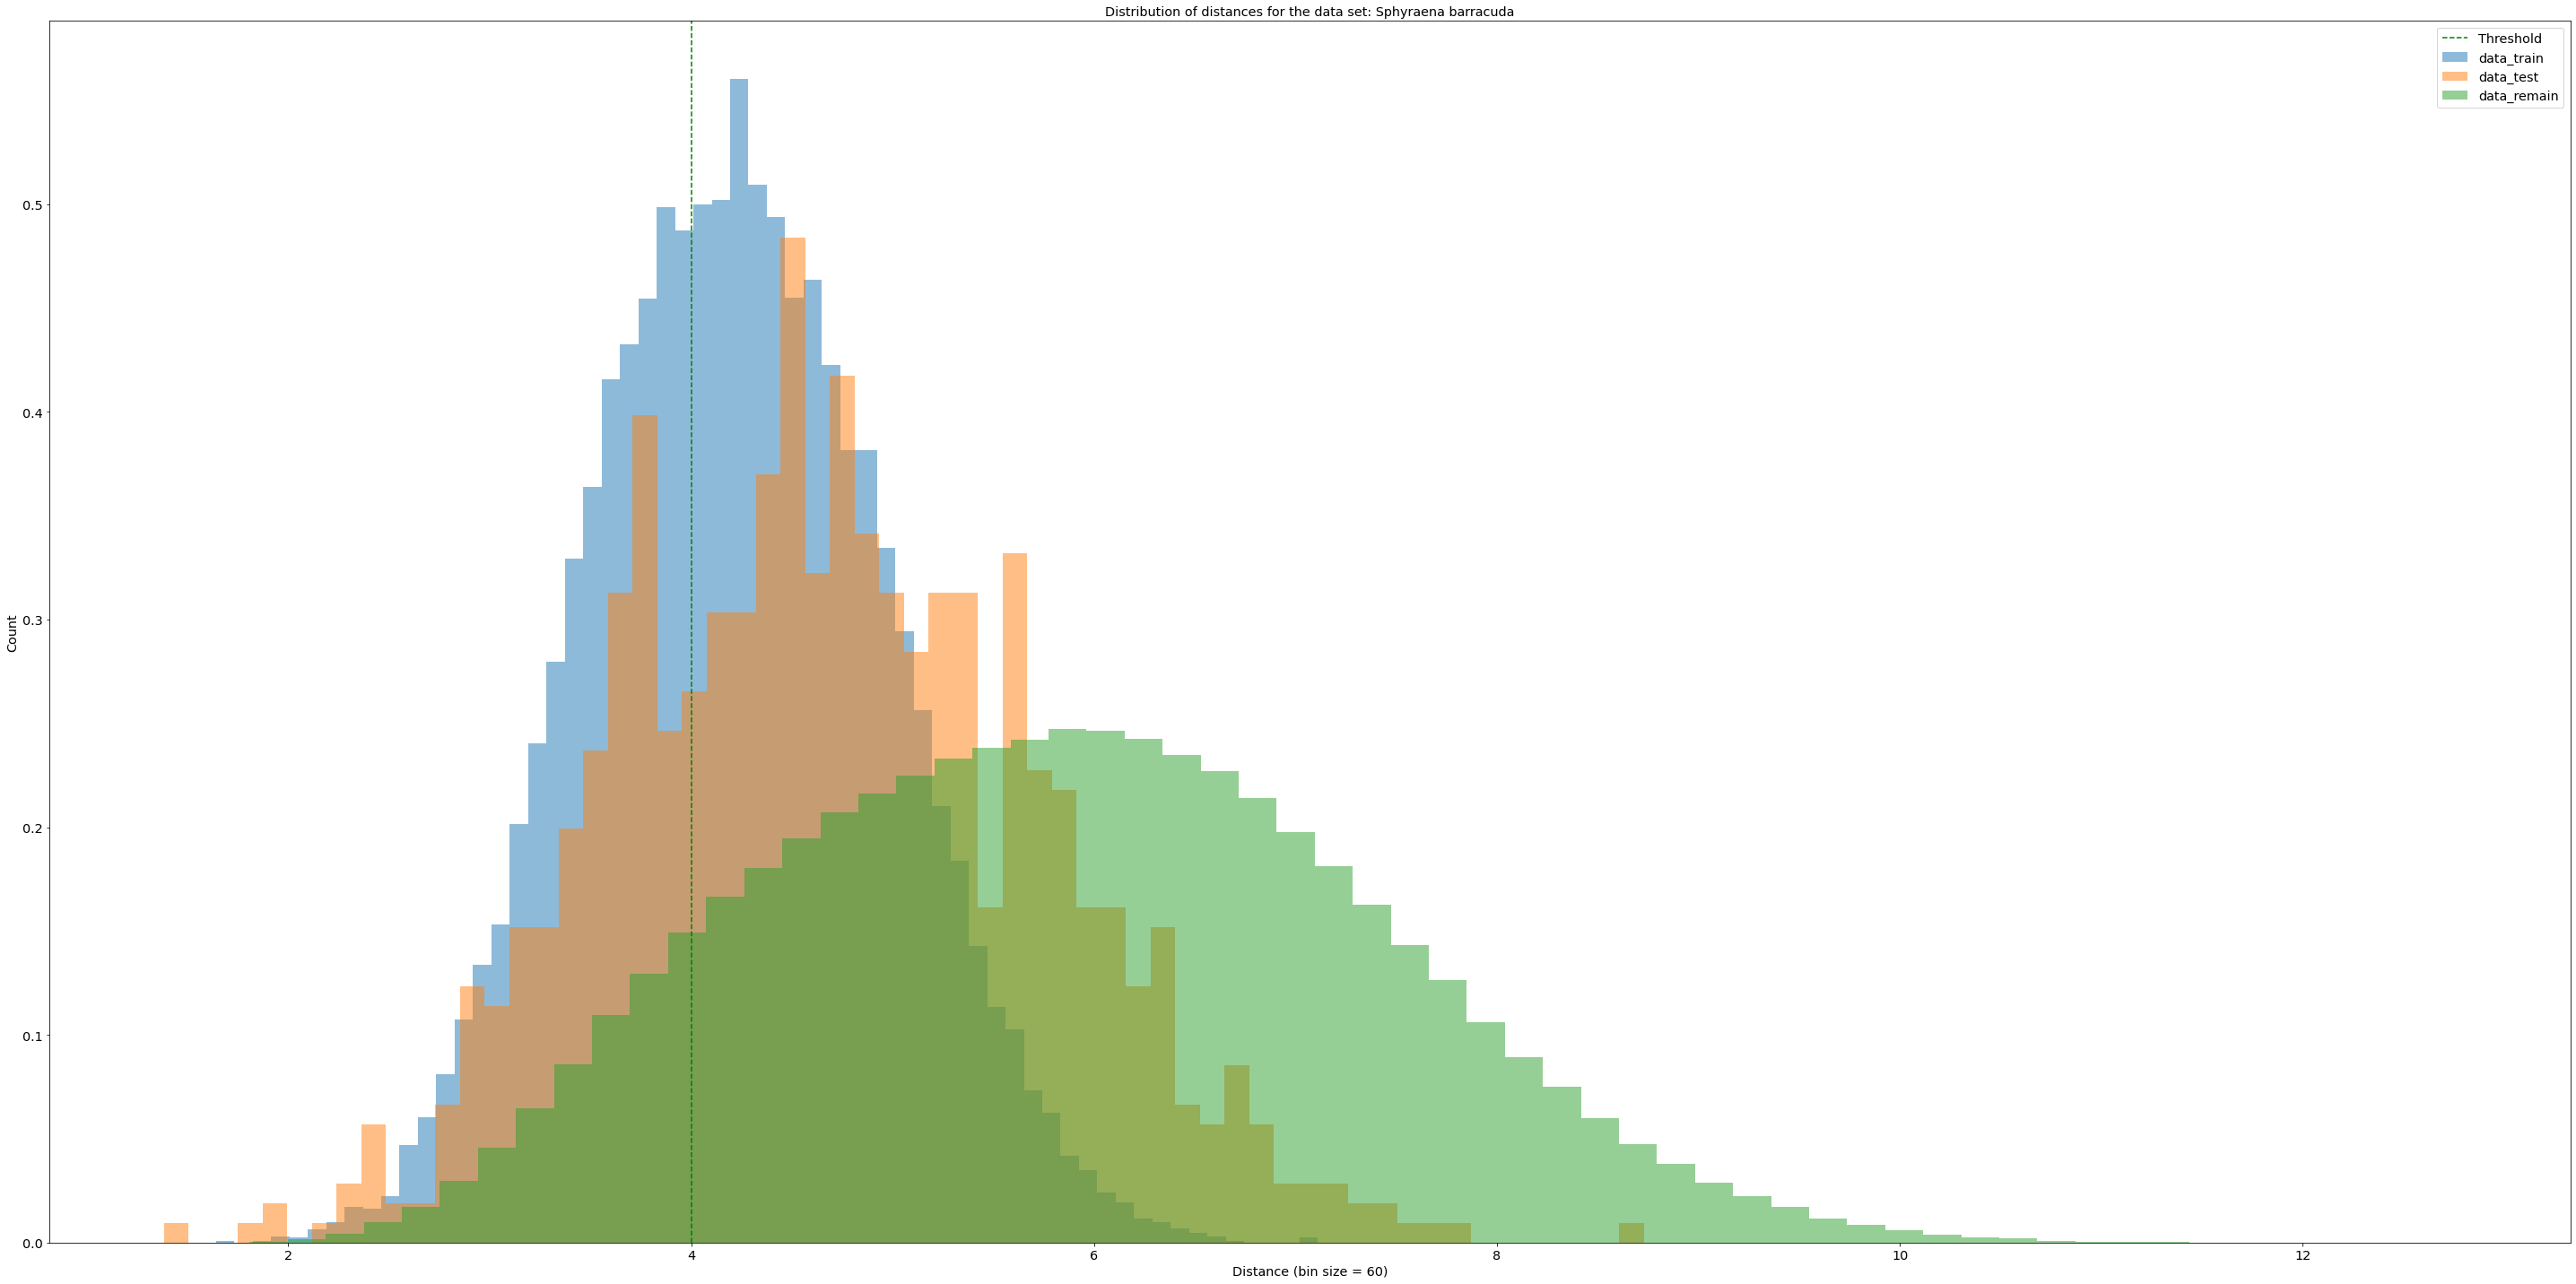

Train: 19460 Test: 1190 Remain: 0


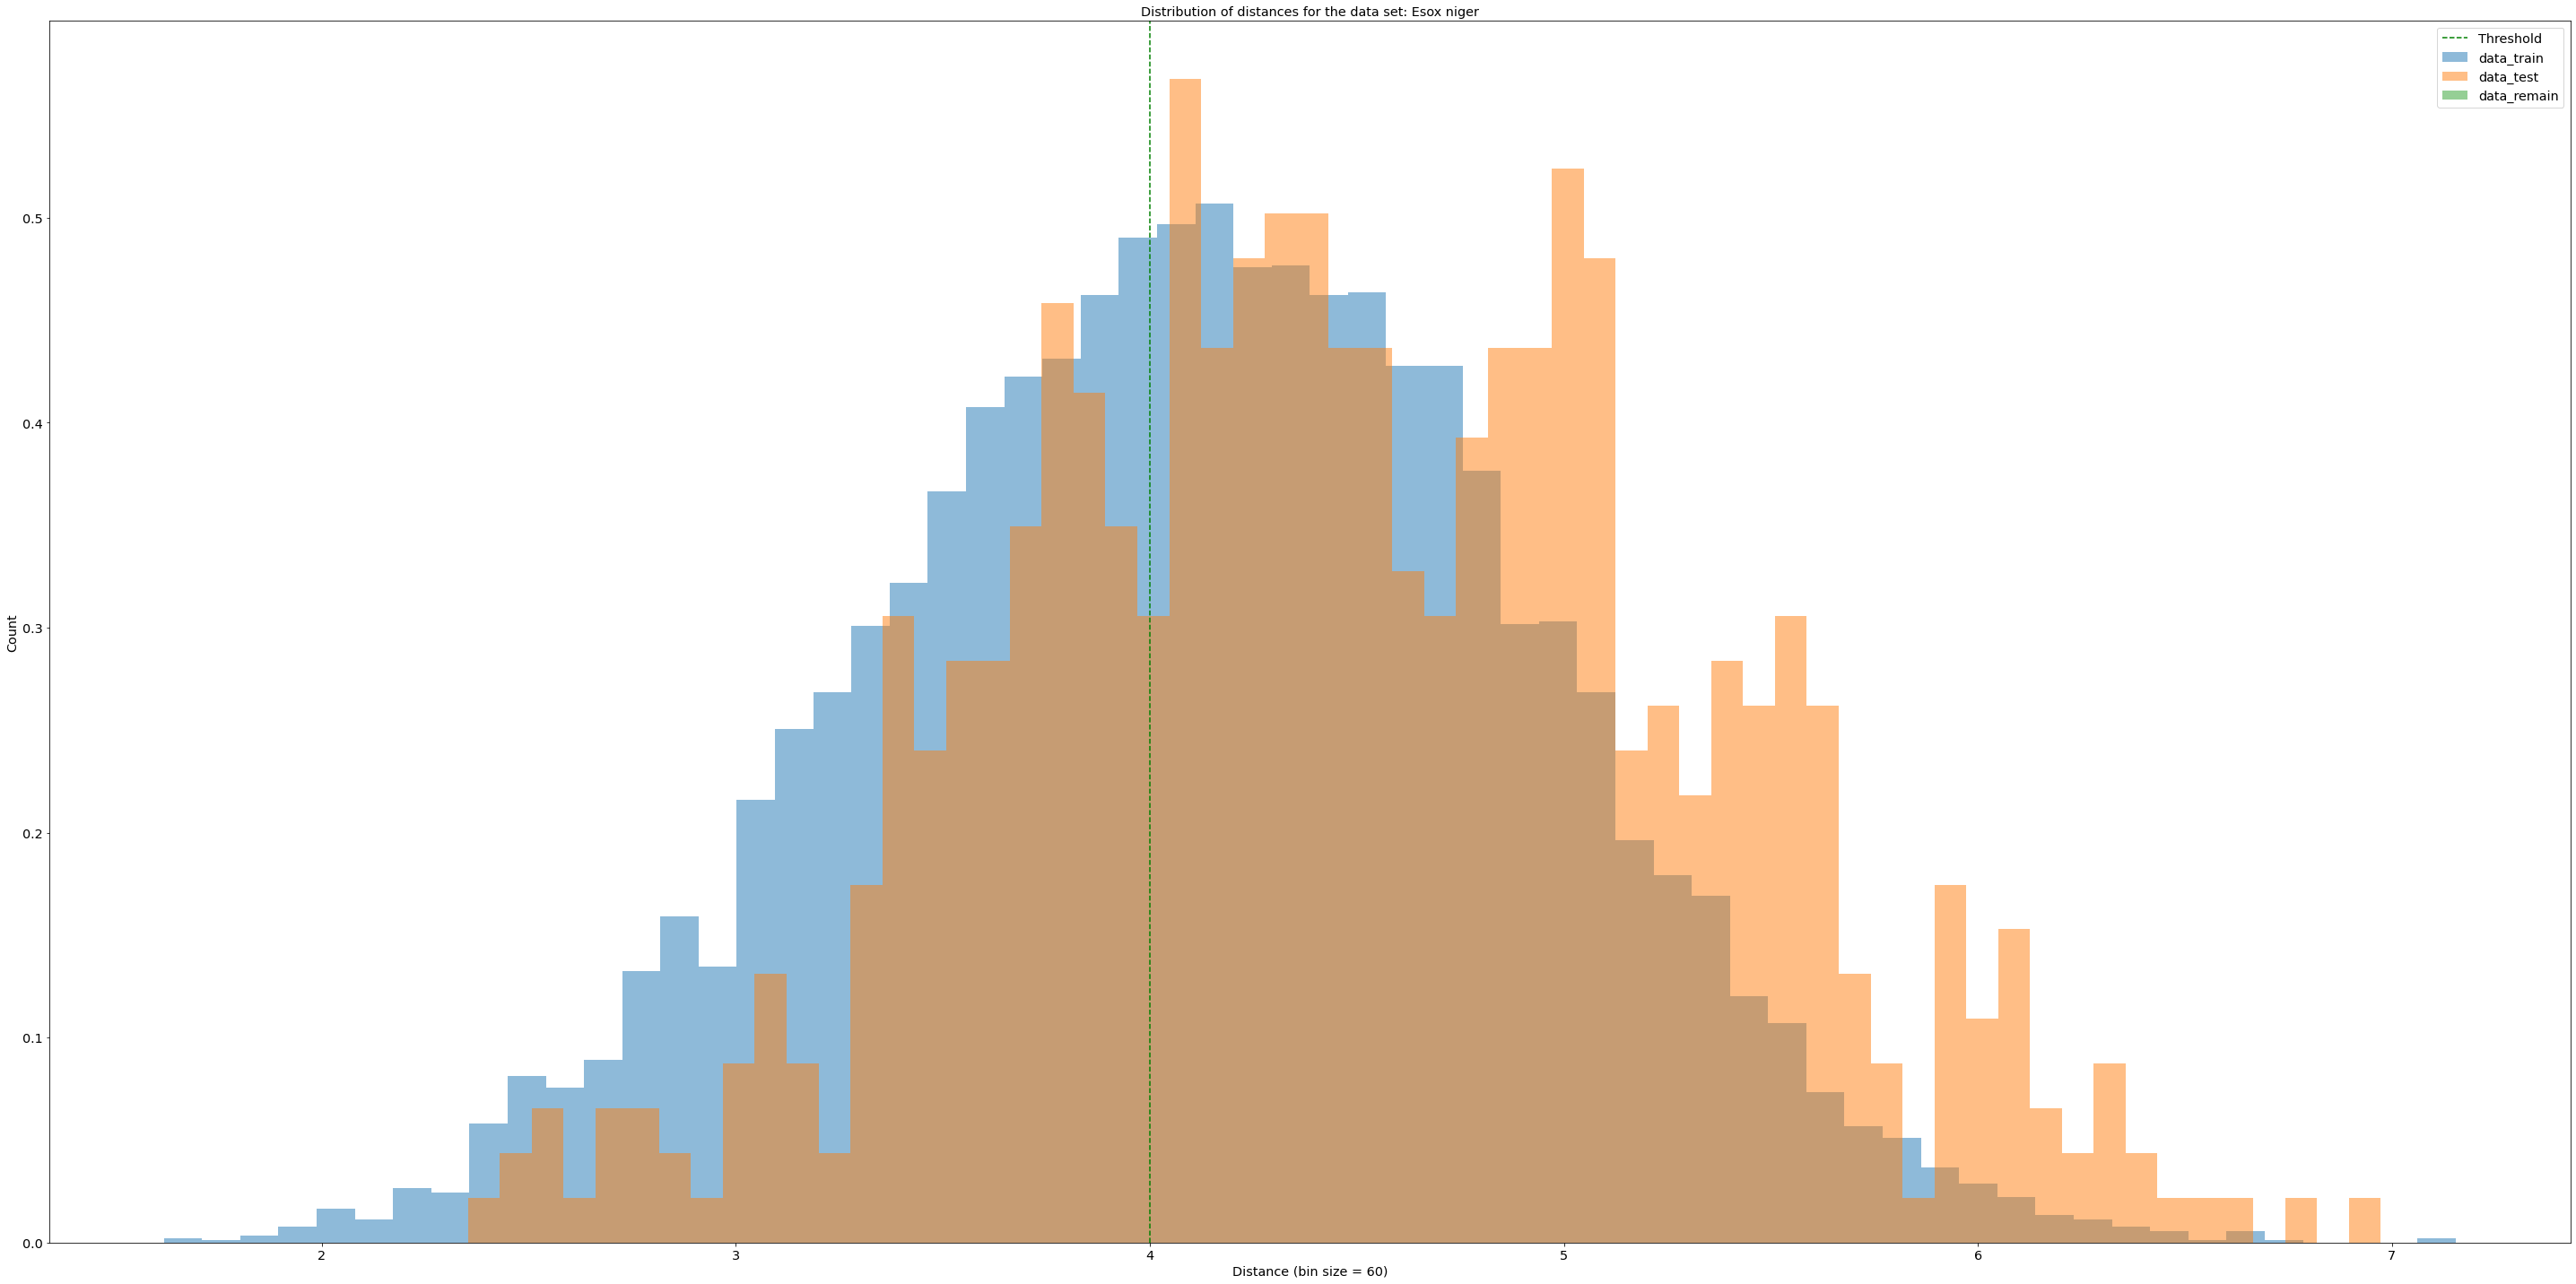

Train: 7310 Test: 420 Remain: 0


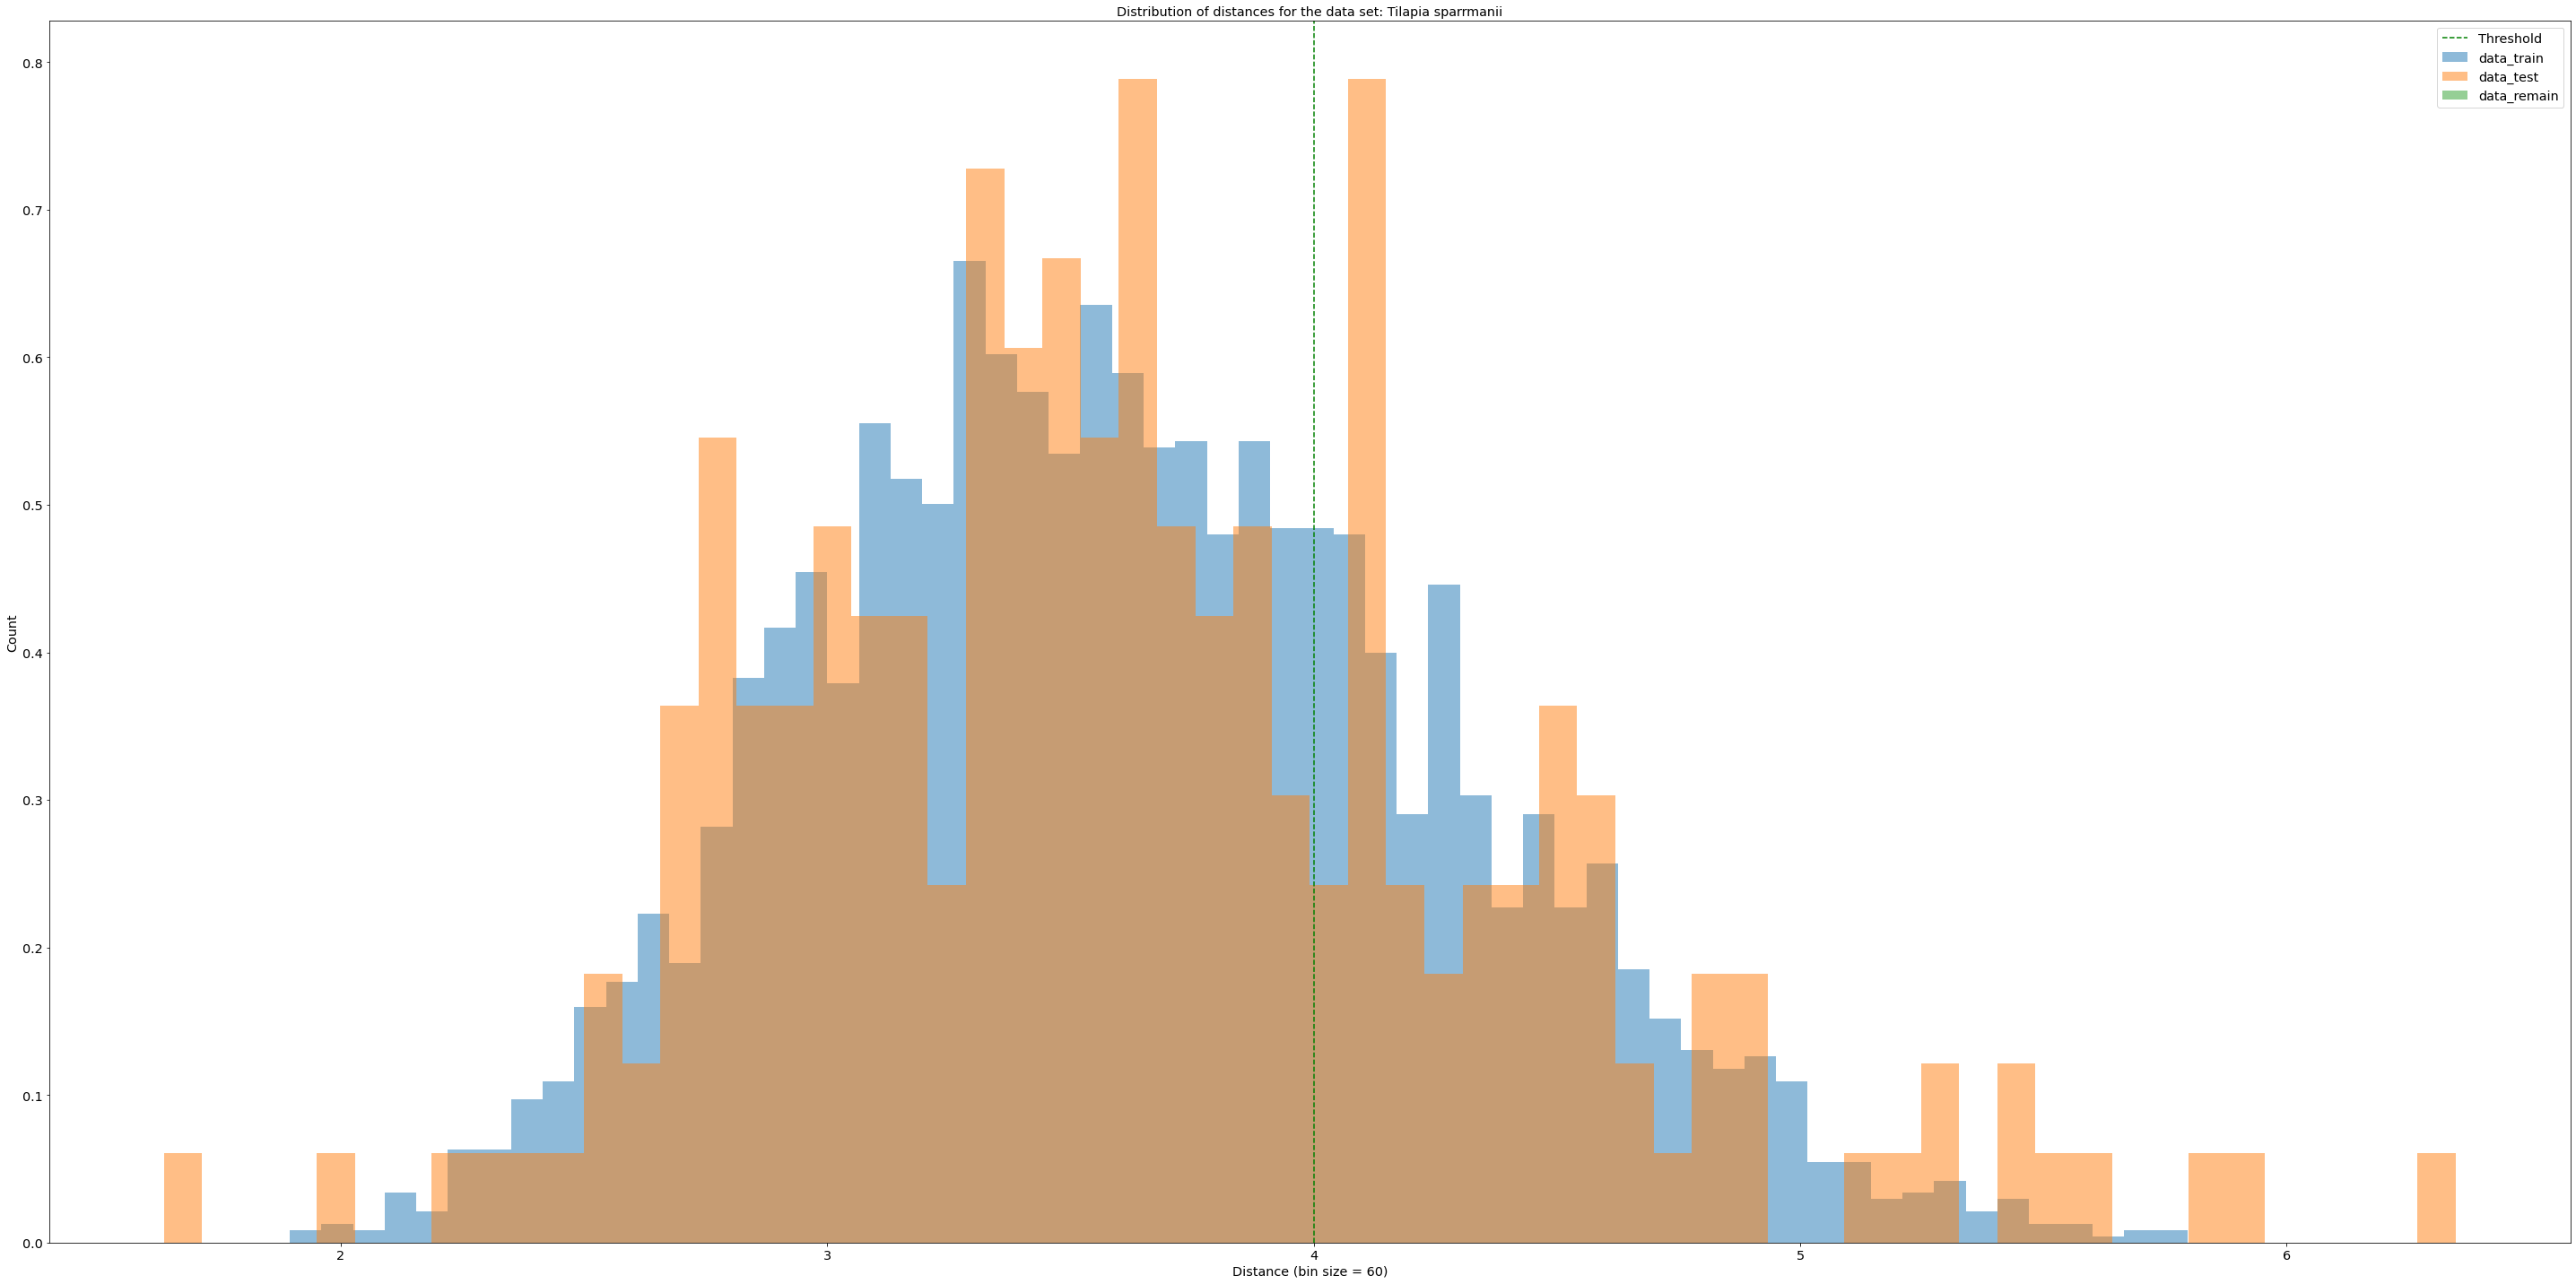

Train: 28392 Test: 1722 Remain: 23562


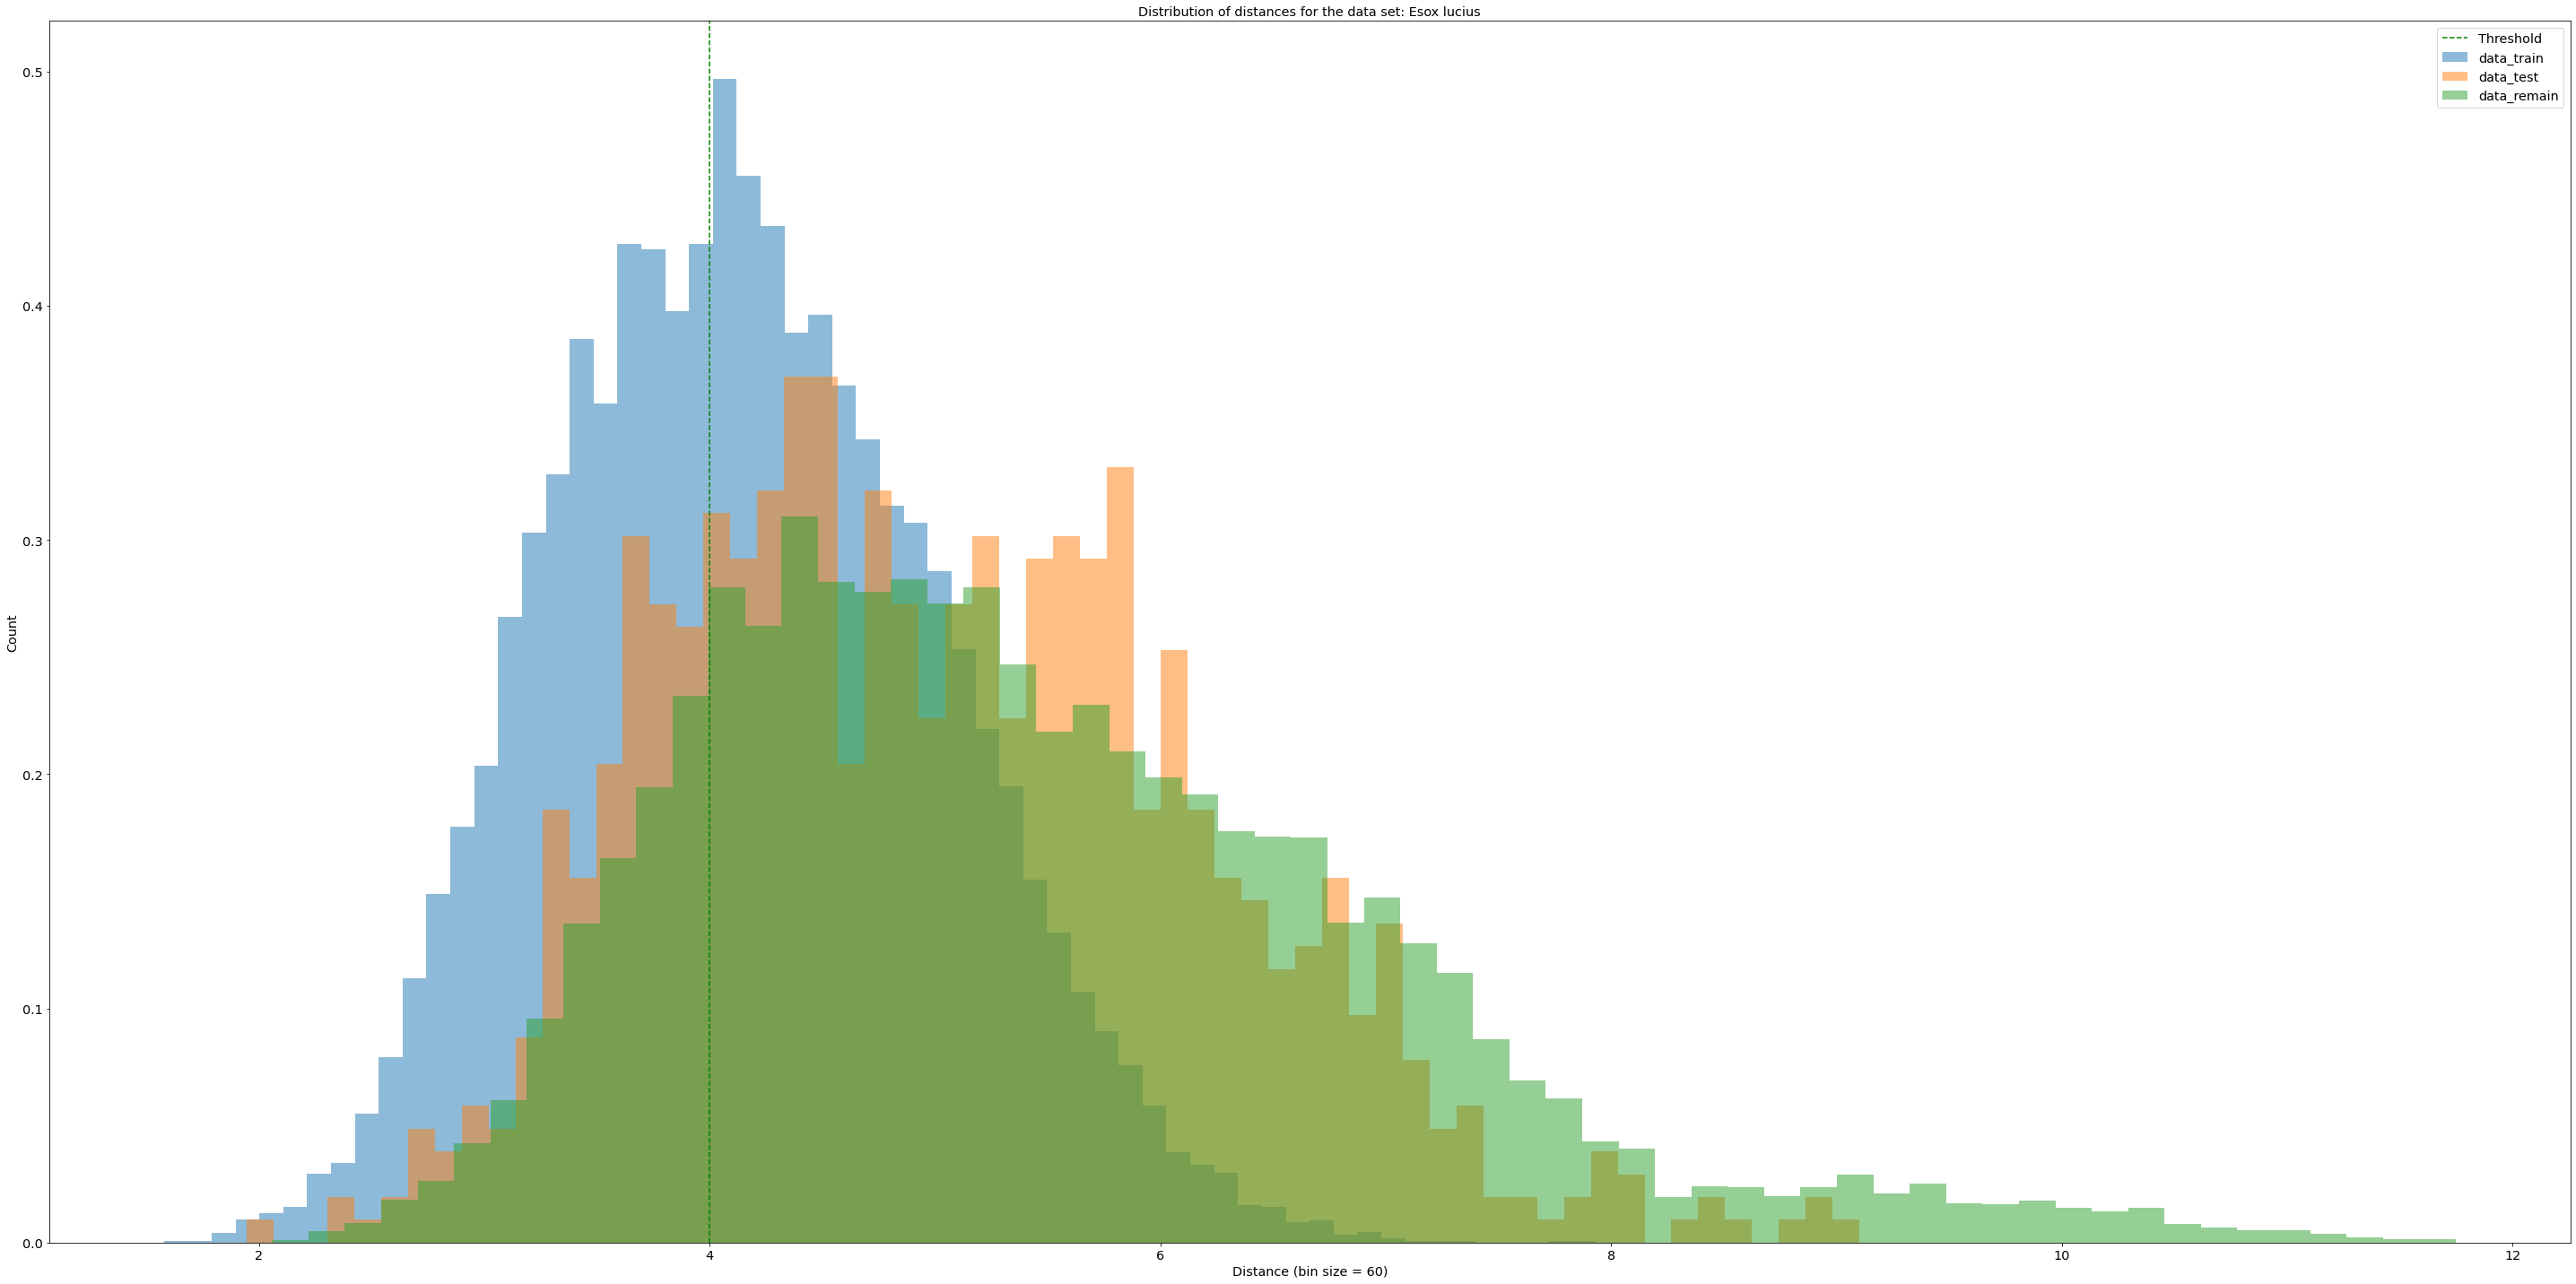

Train: 28392 Test: 1722 Remain: 391250


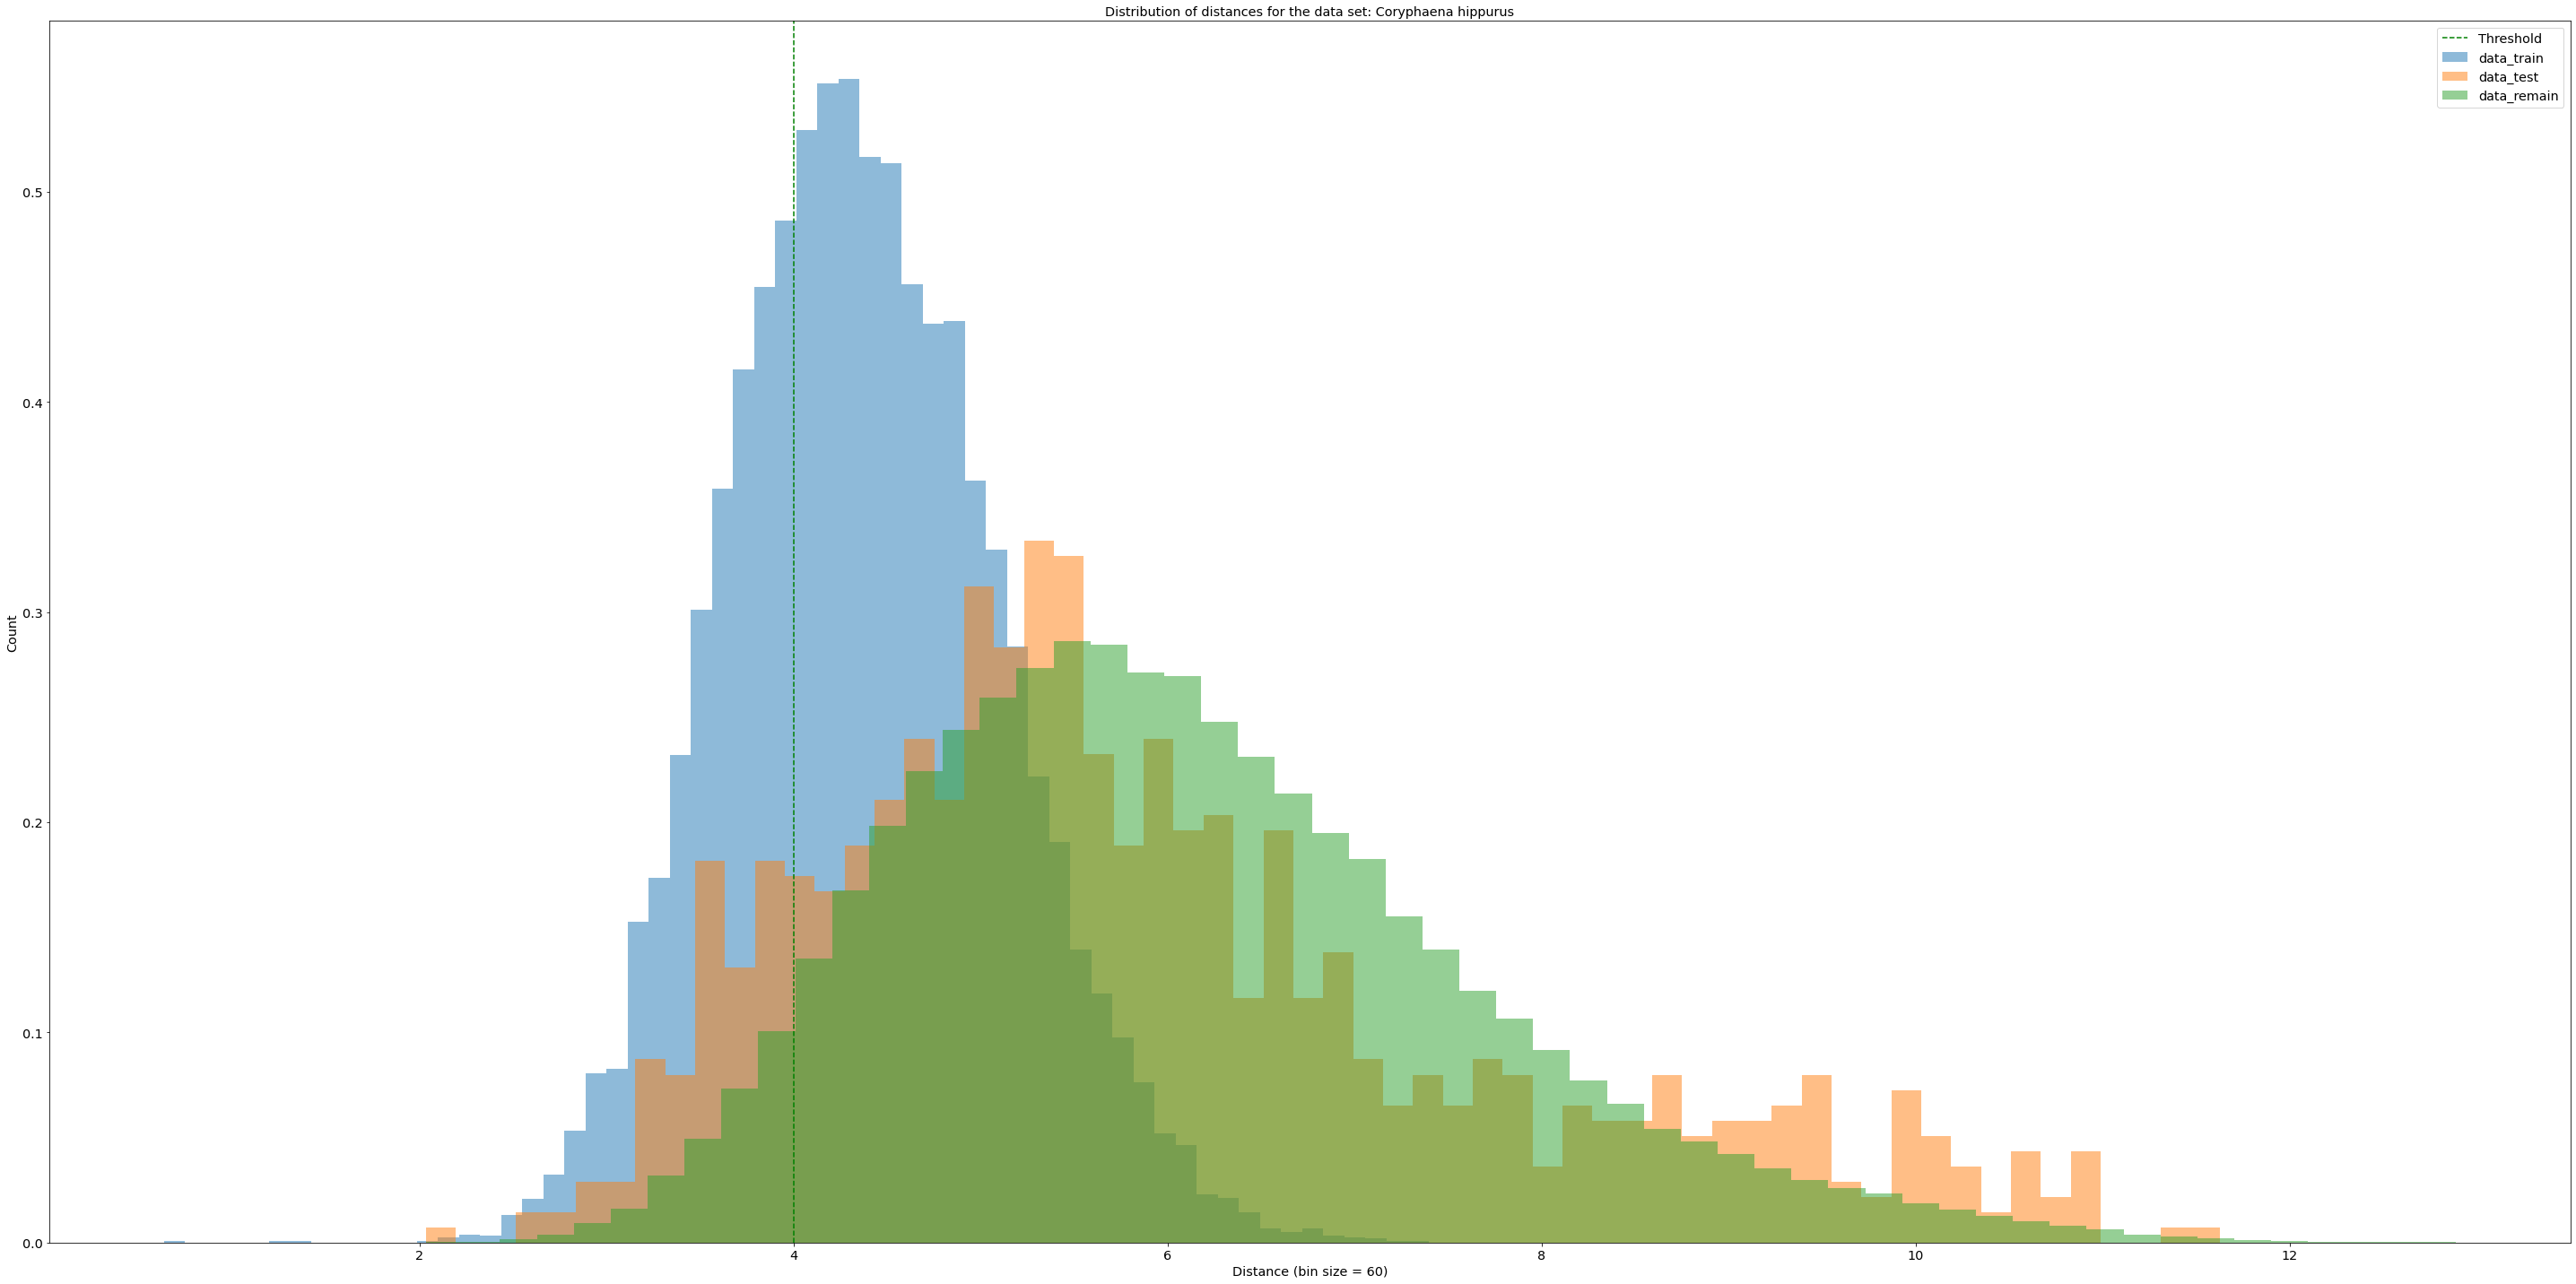

Train: 28392 Test: 1722 Remain: 510510


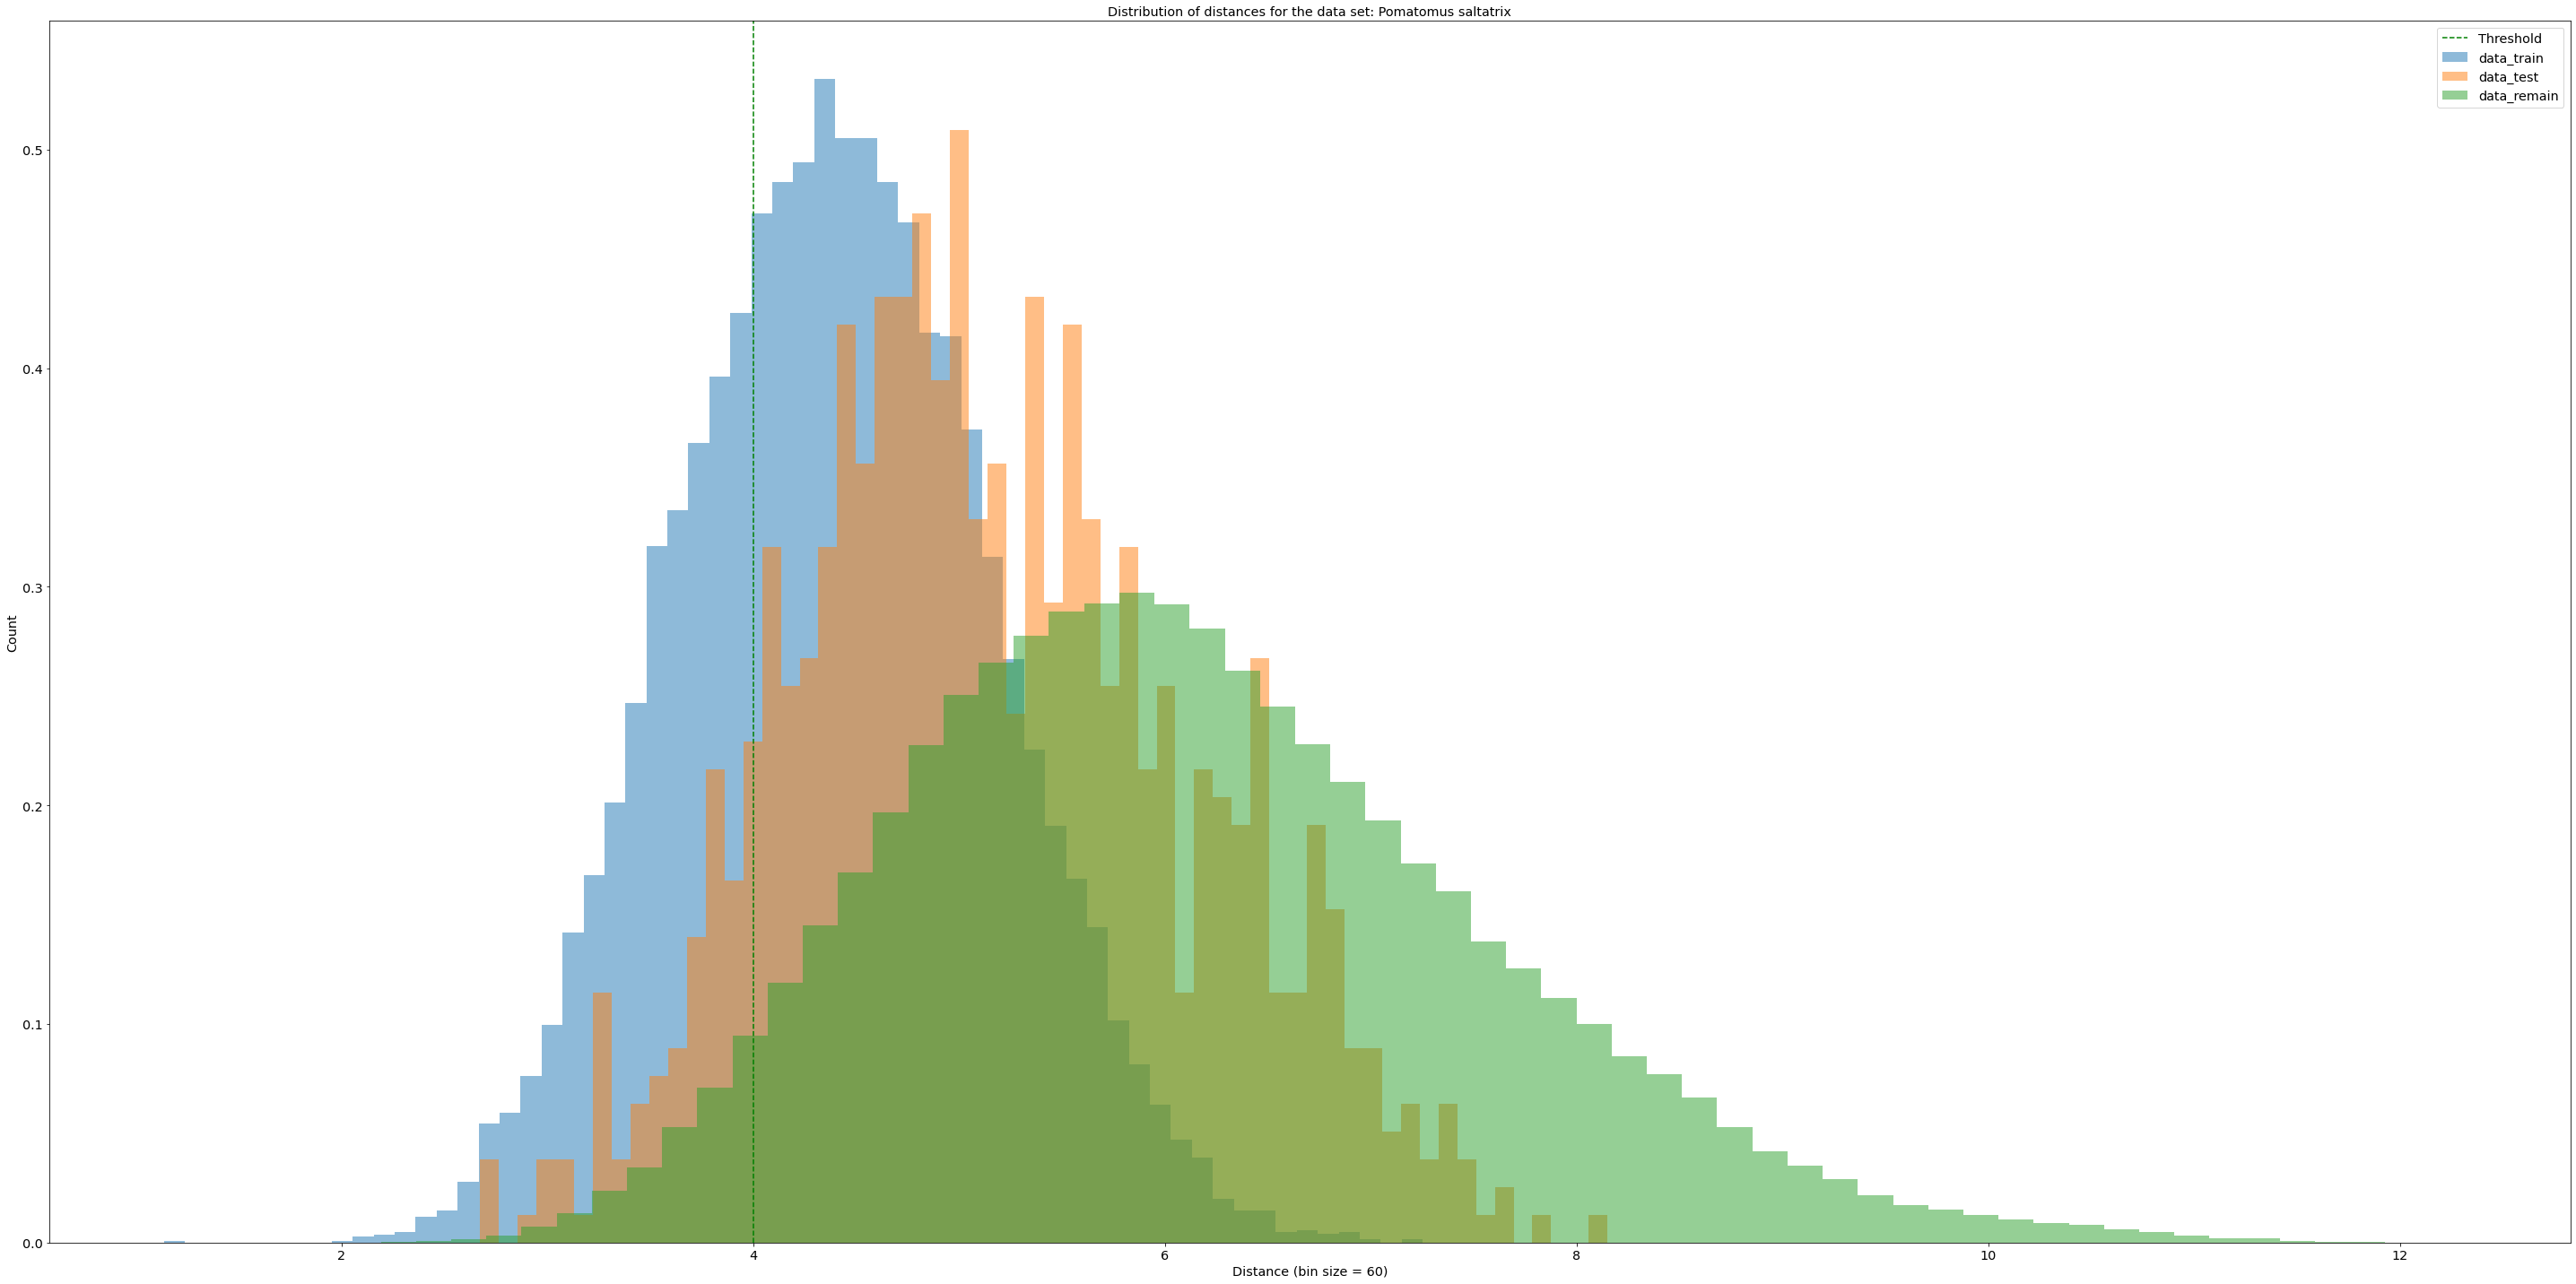

Train: 28392 Test: 1722 Remain: 19182


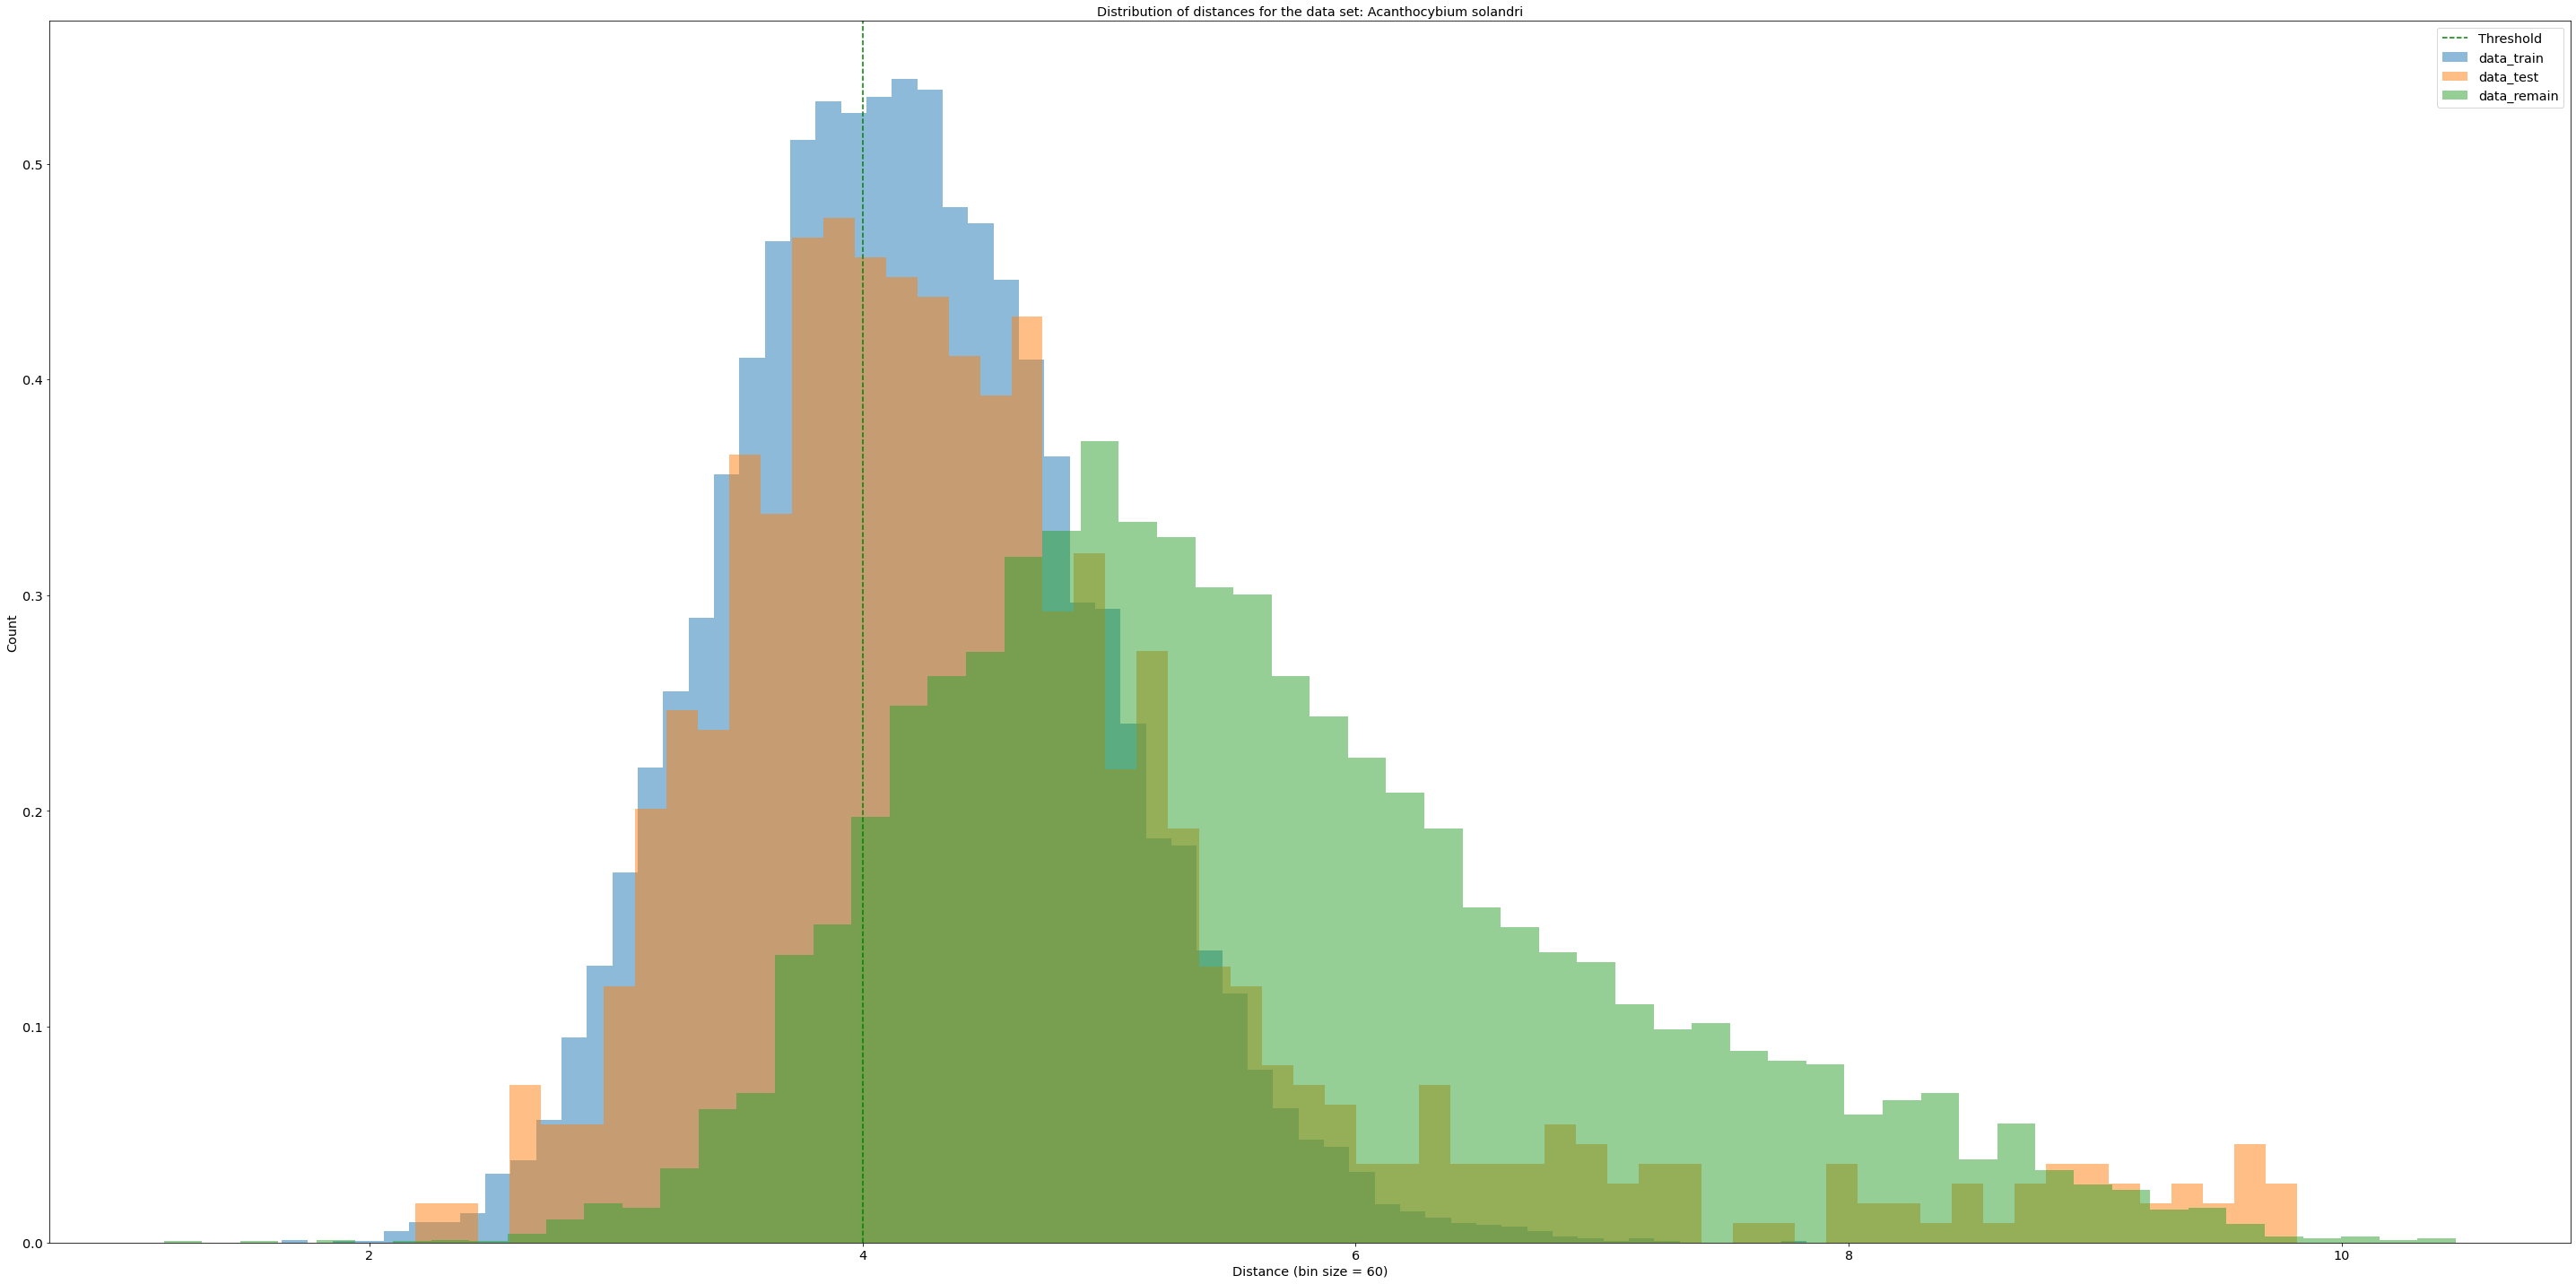

Train: 702 Test: 210 Remain: 0


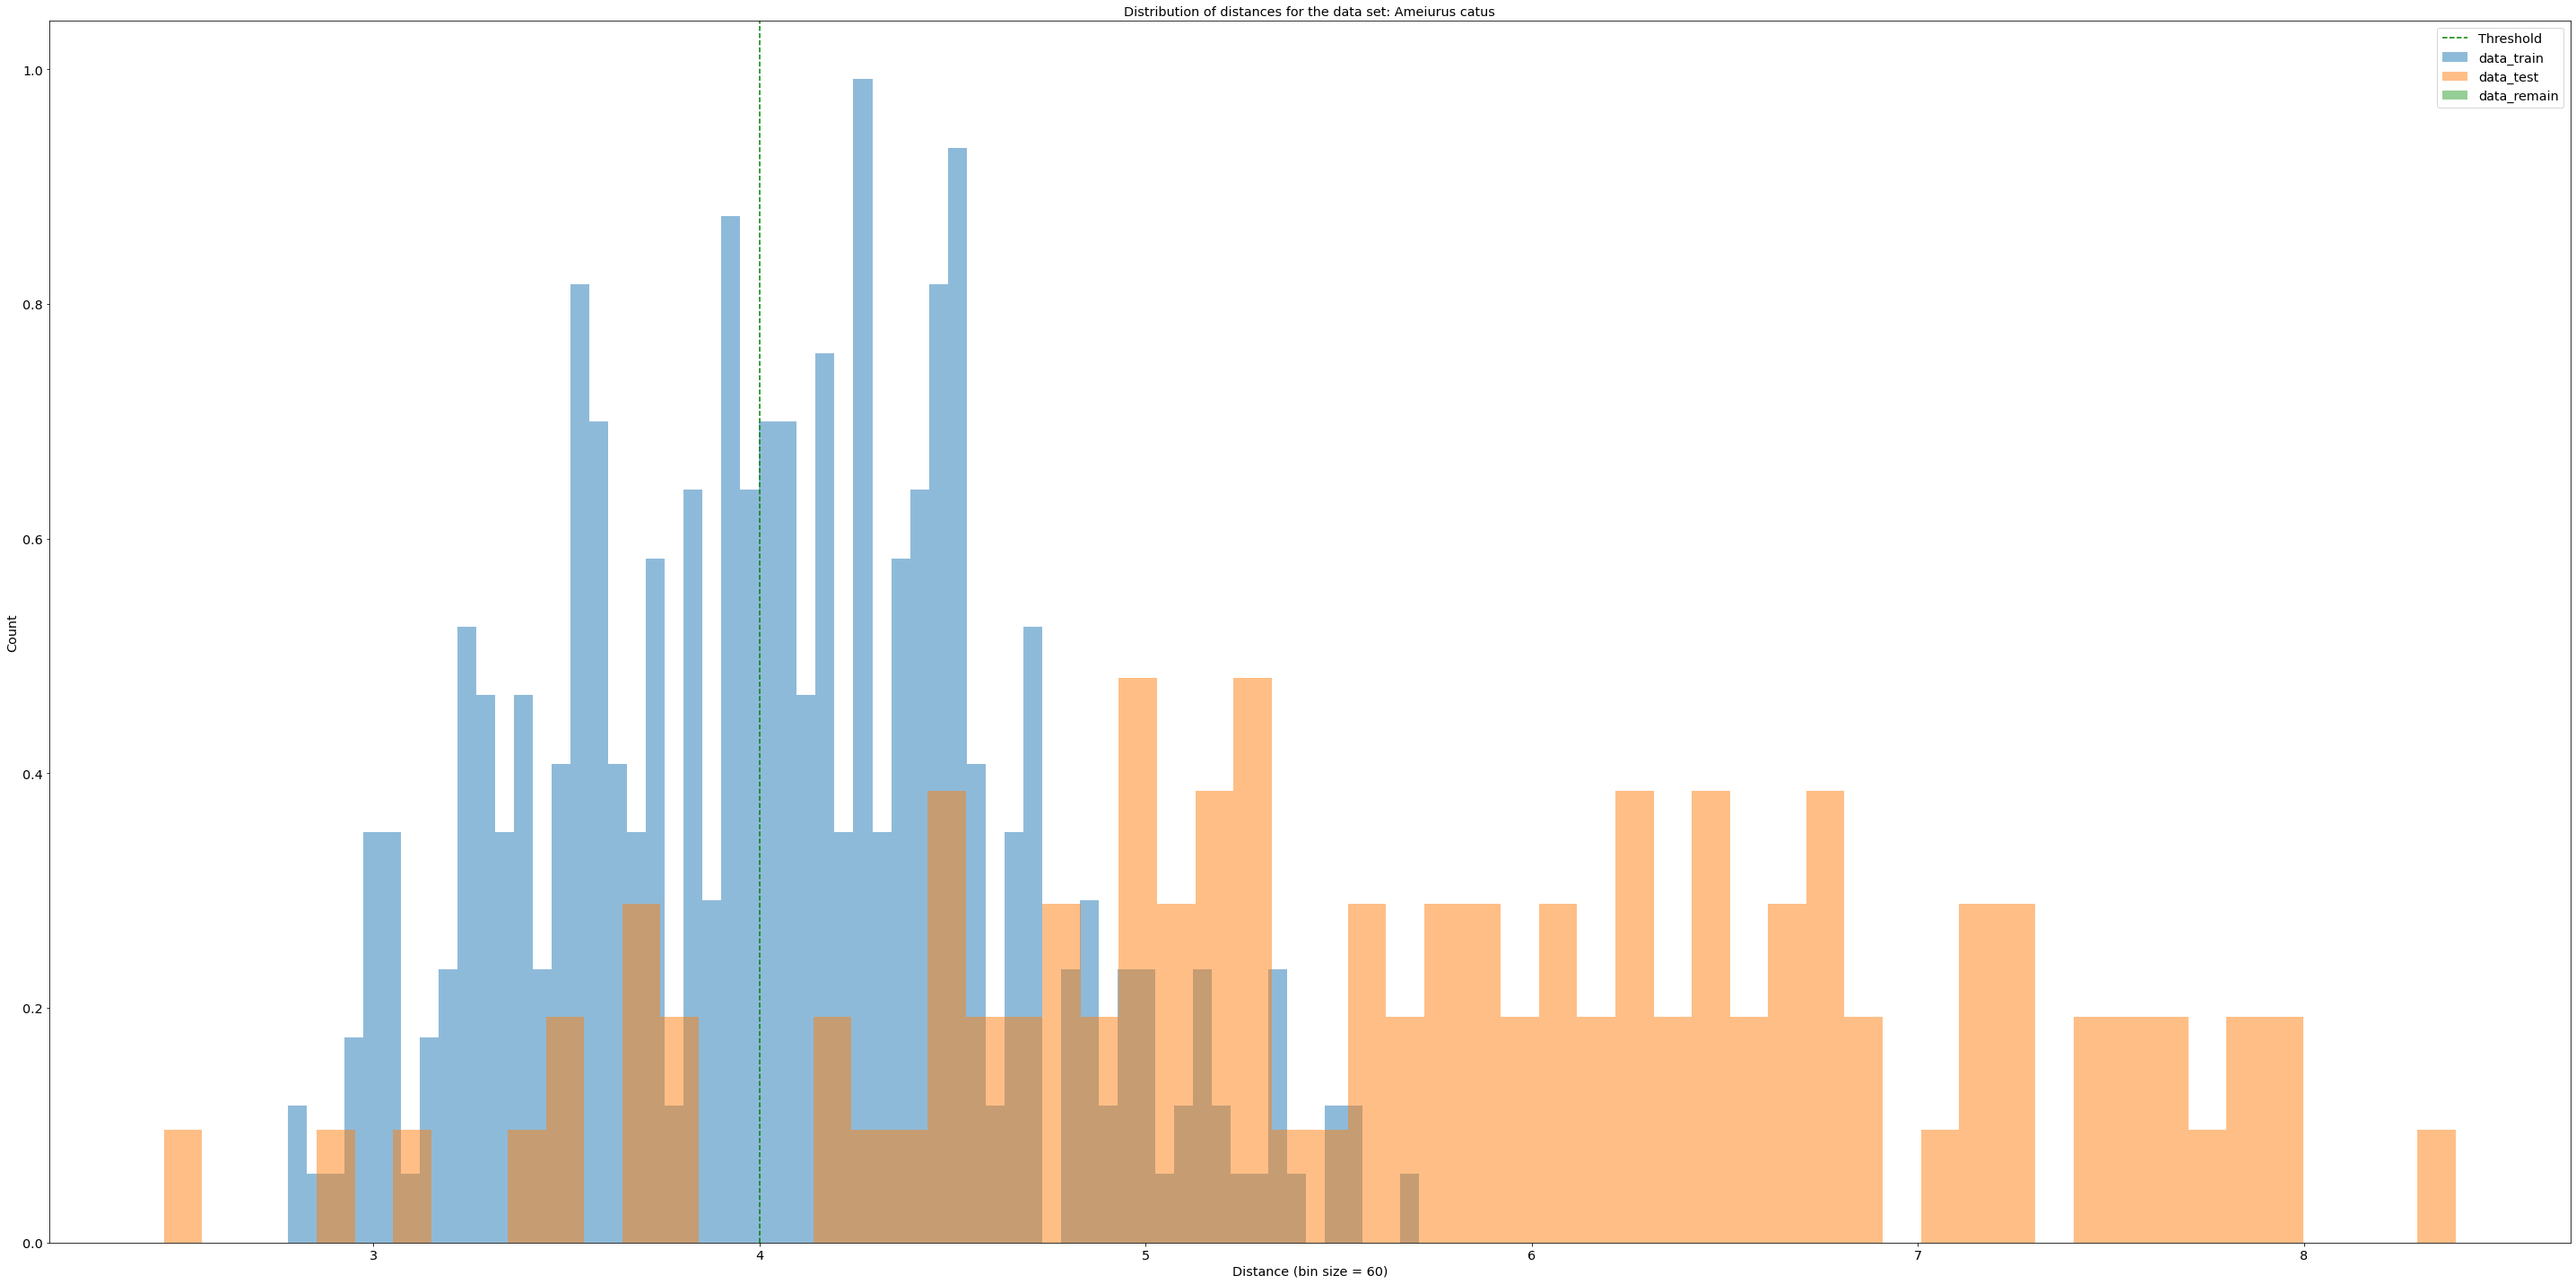

Train: 21756 Test: 1332 Remain: 0


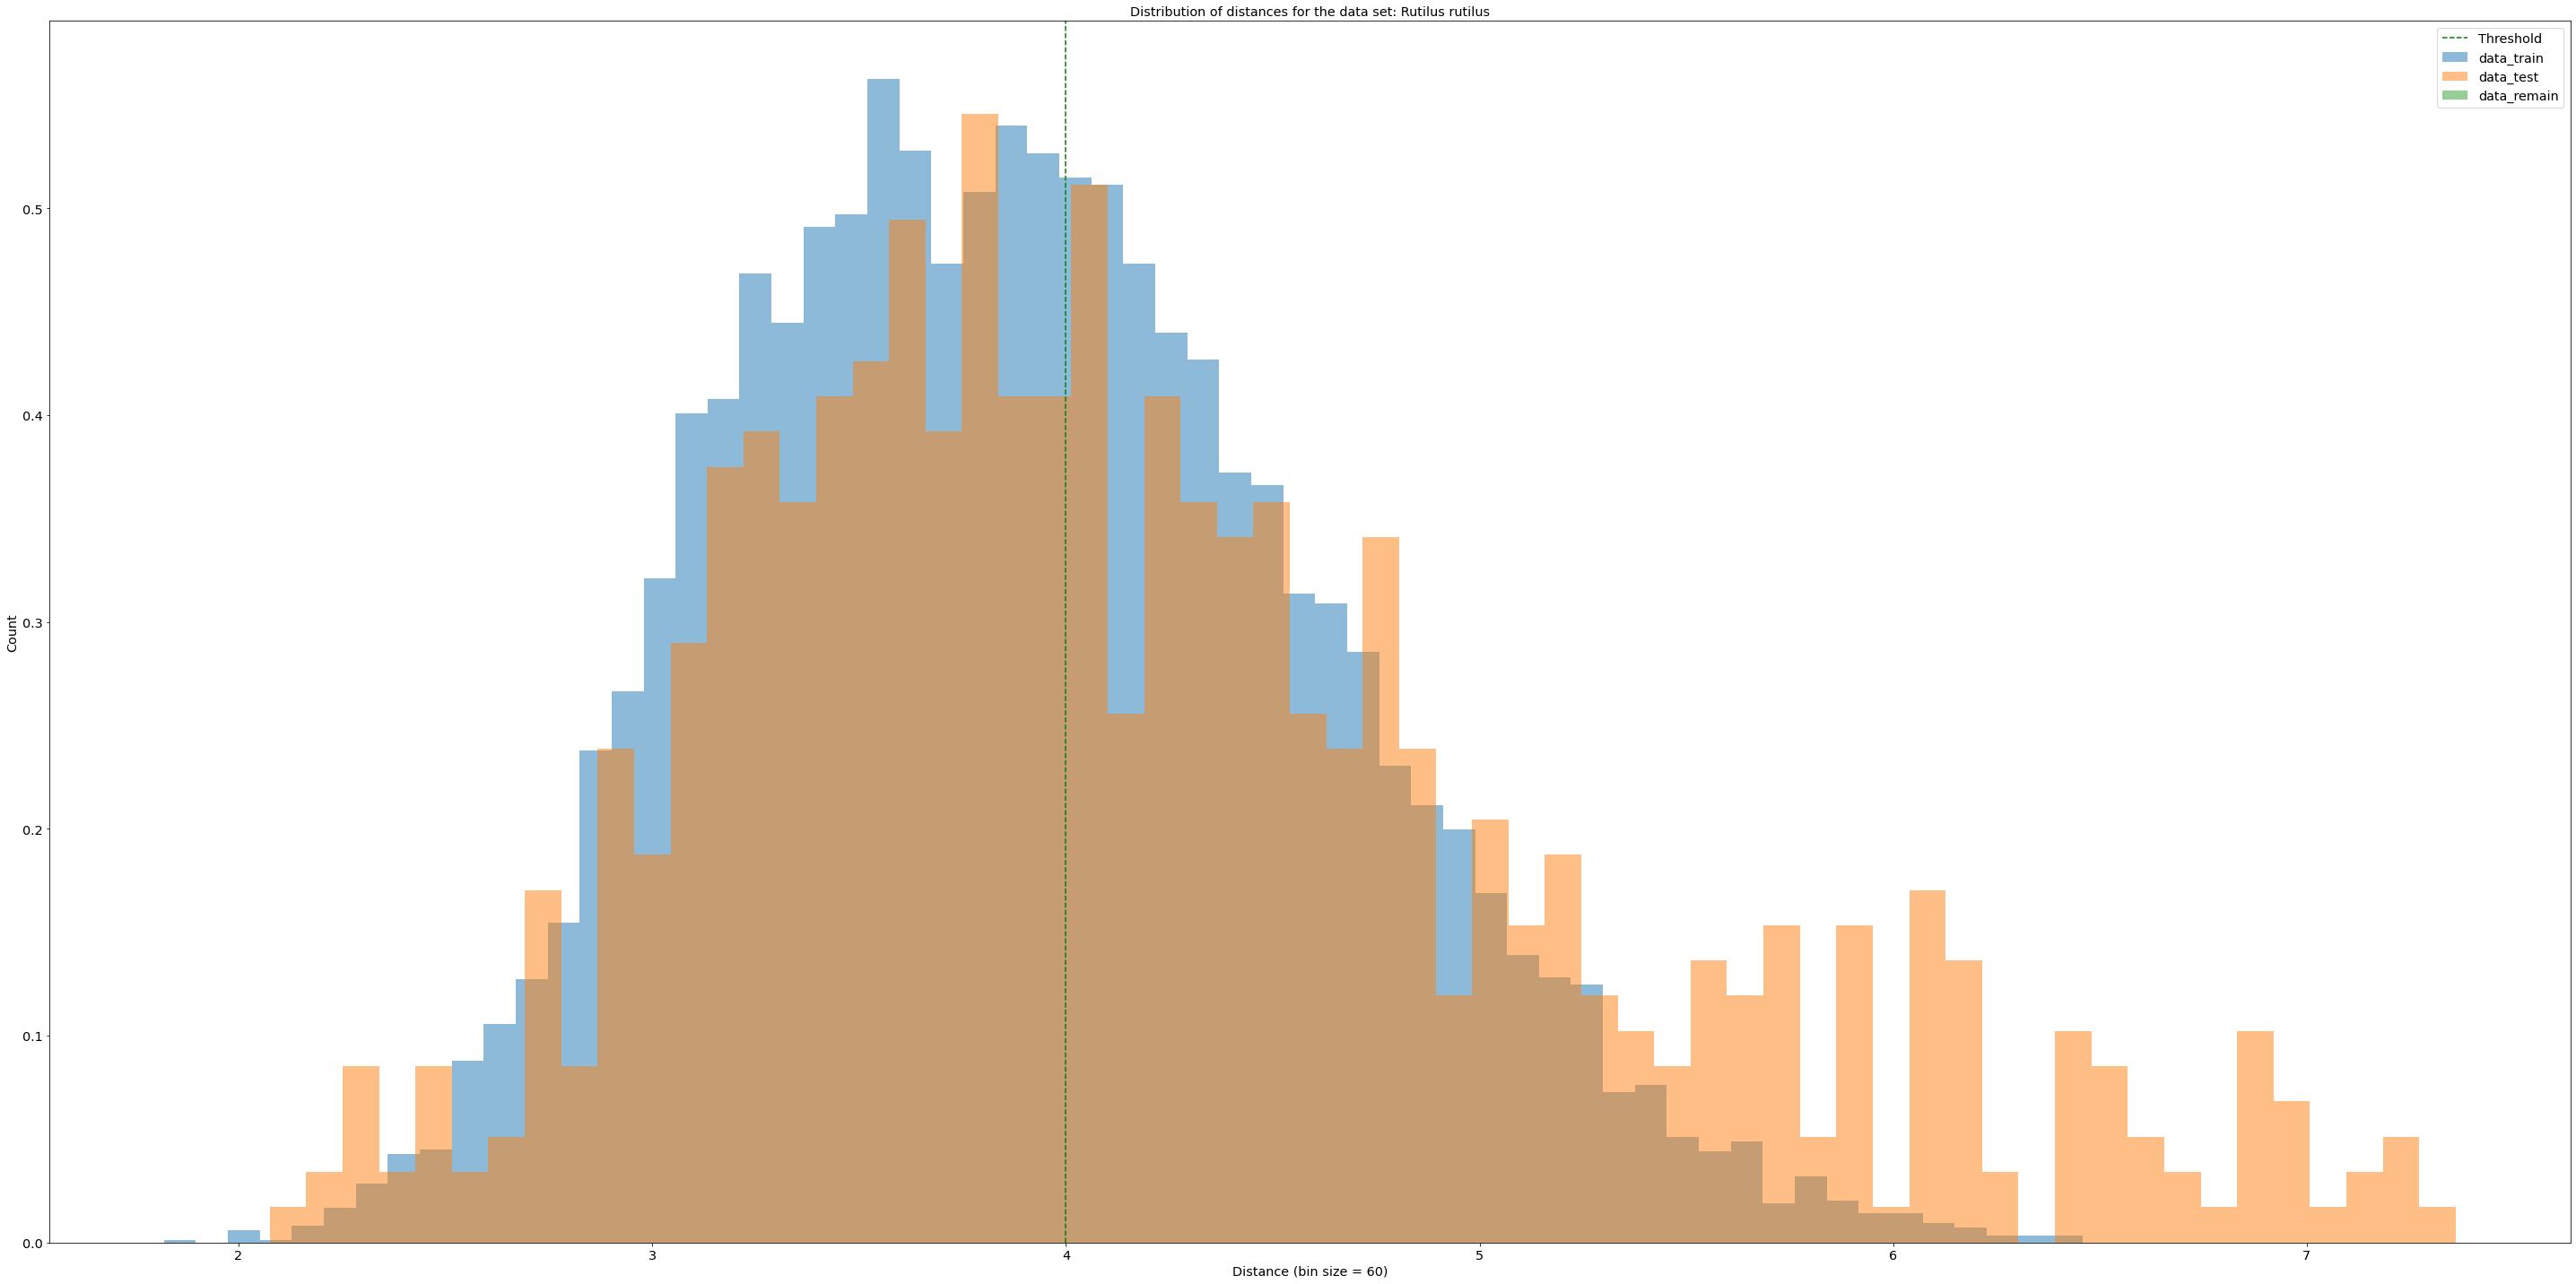

Train: 28392 Test: 1722 Remain: 232806


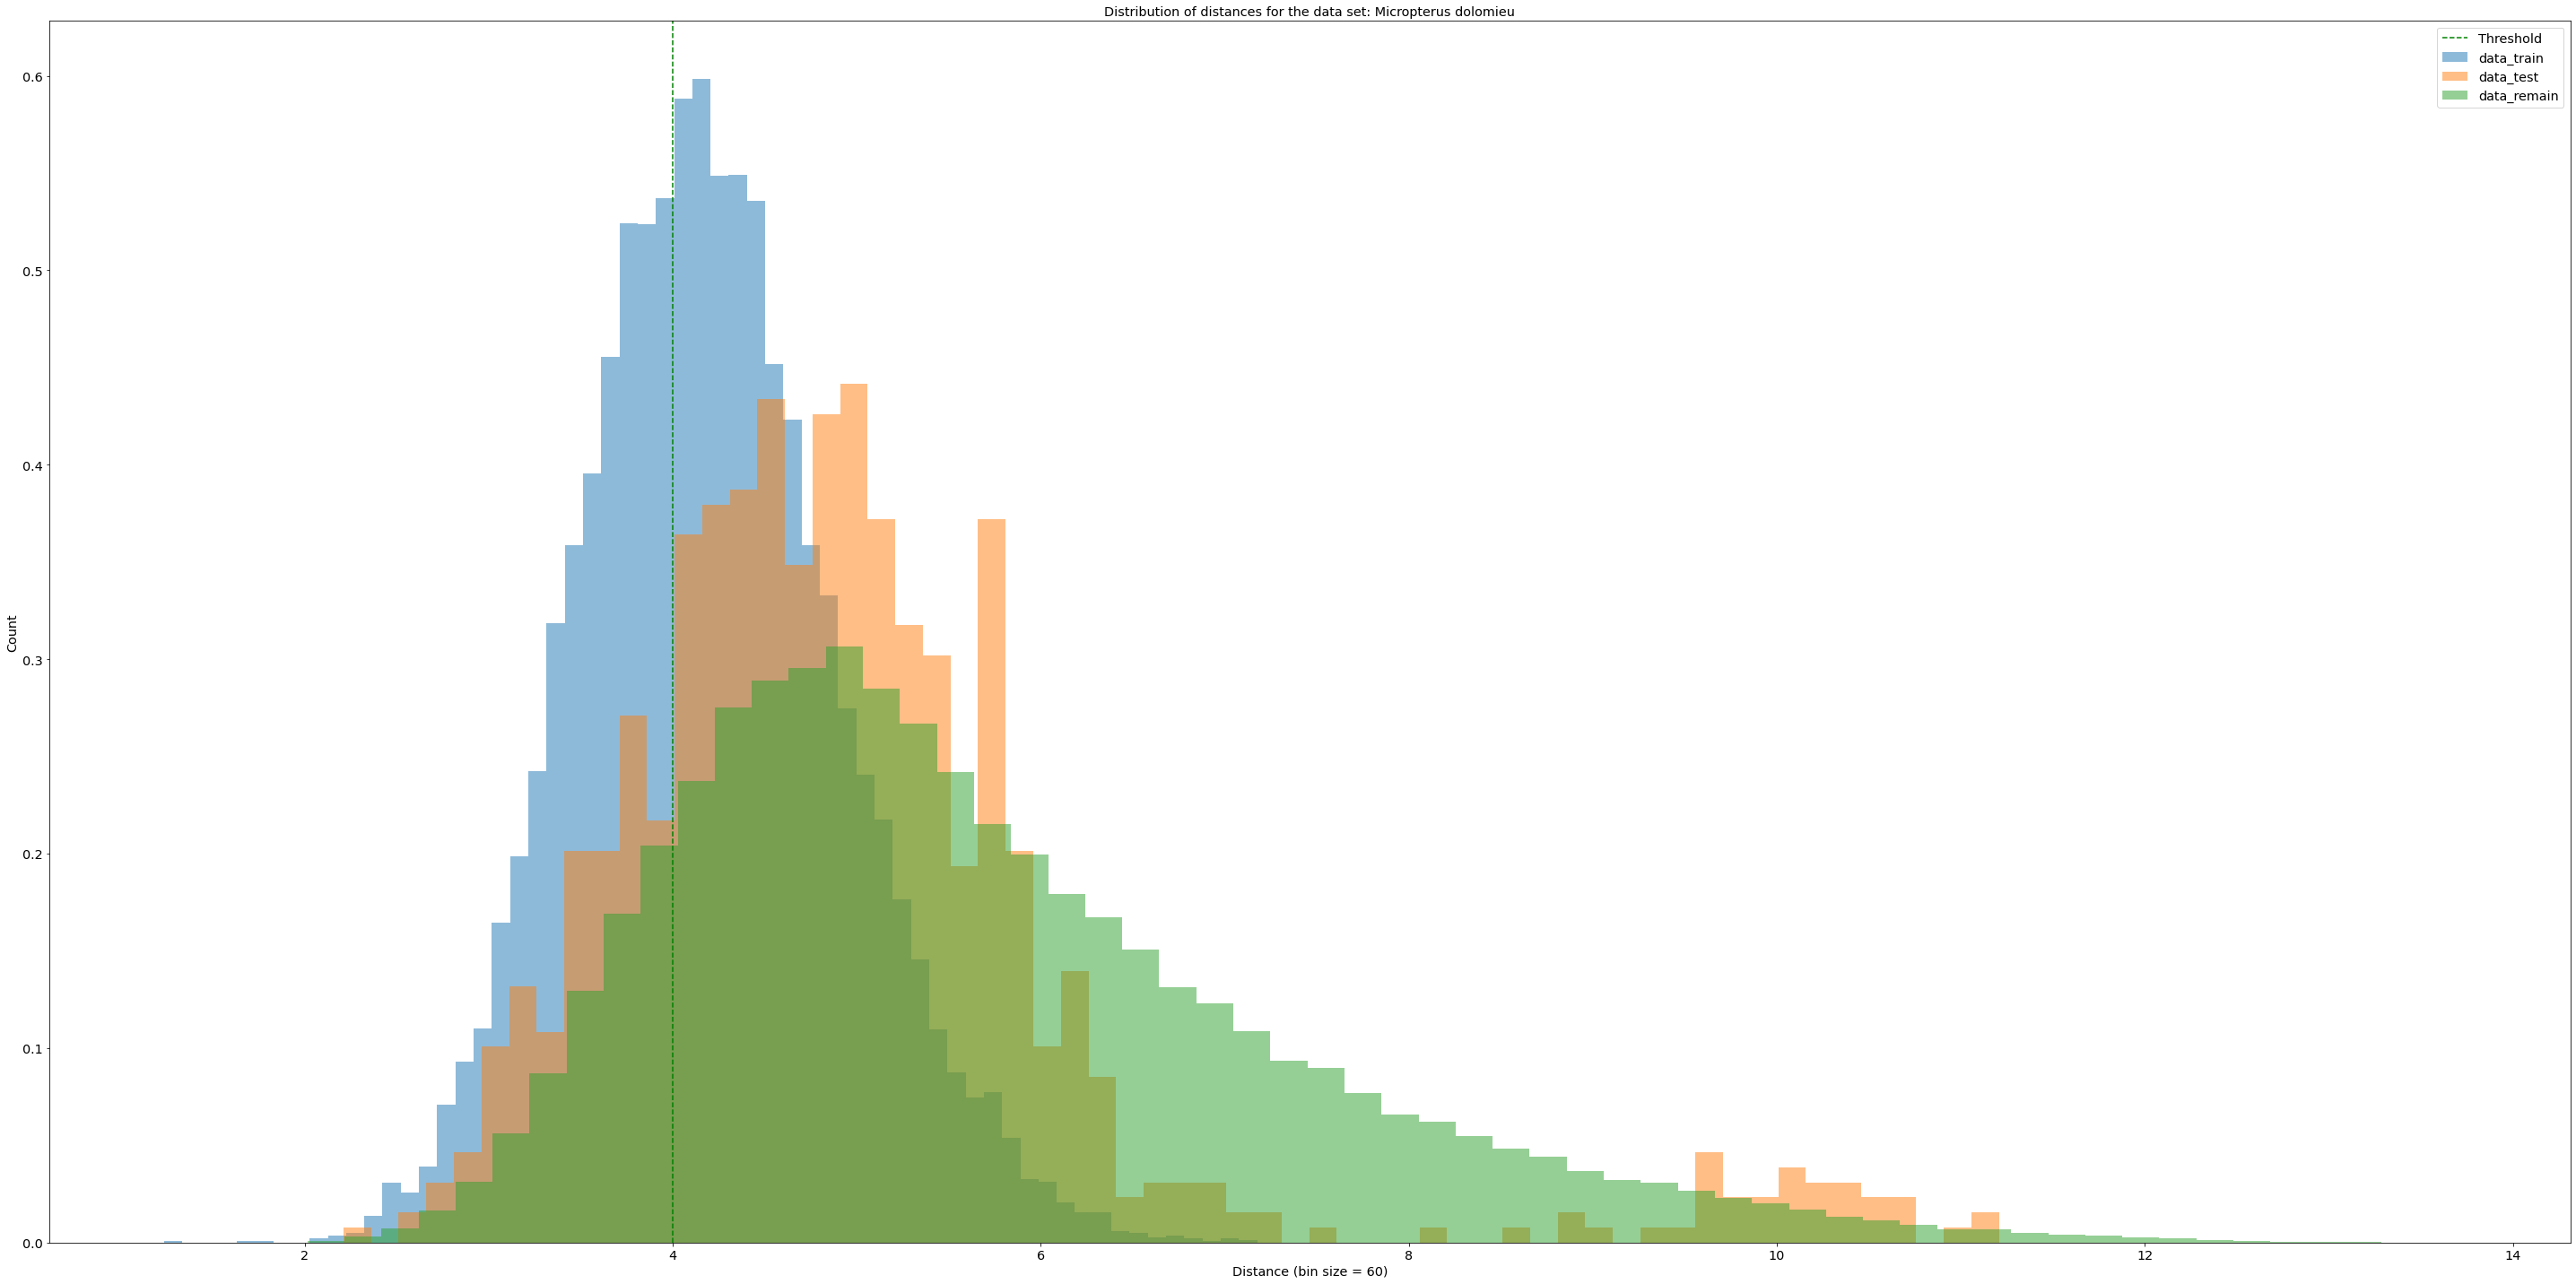

Train: 20592 Test: 1190 Remain: 0


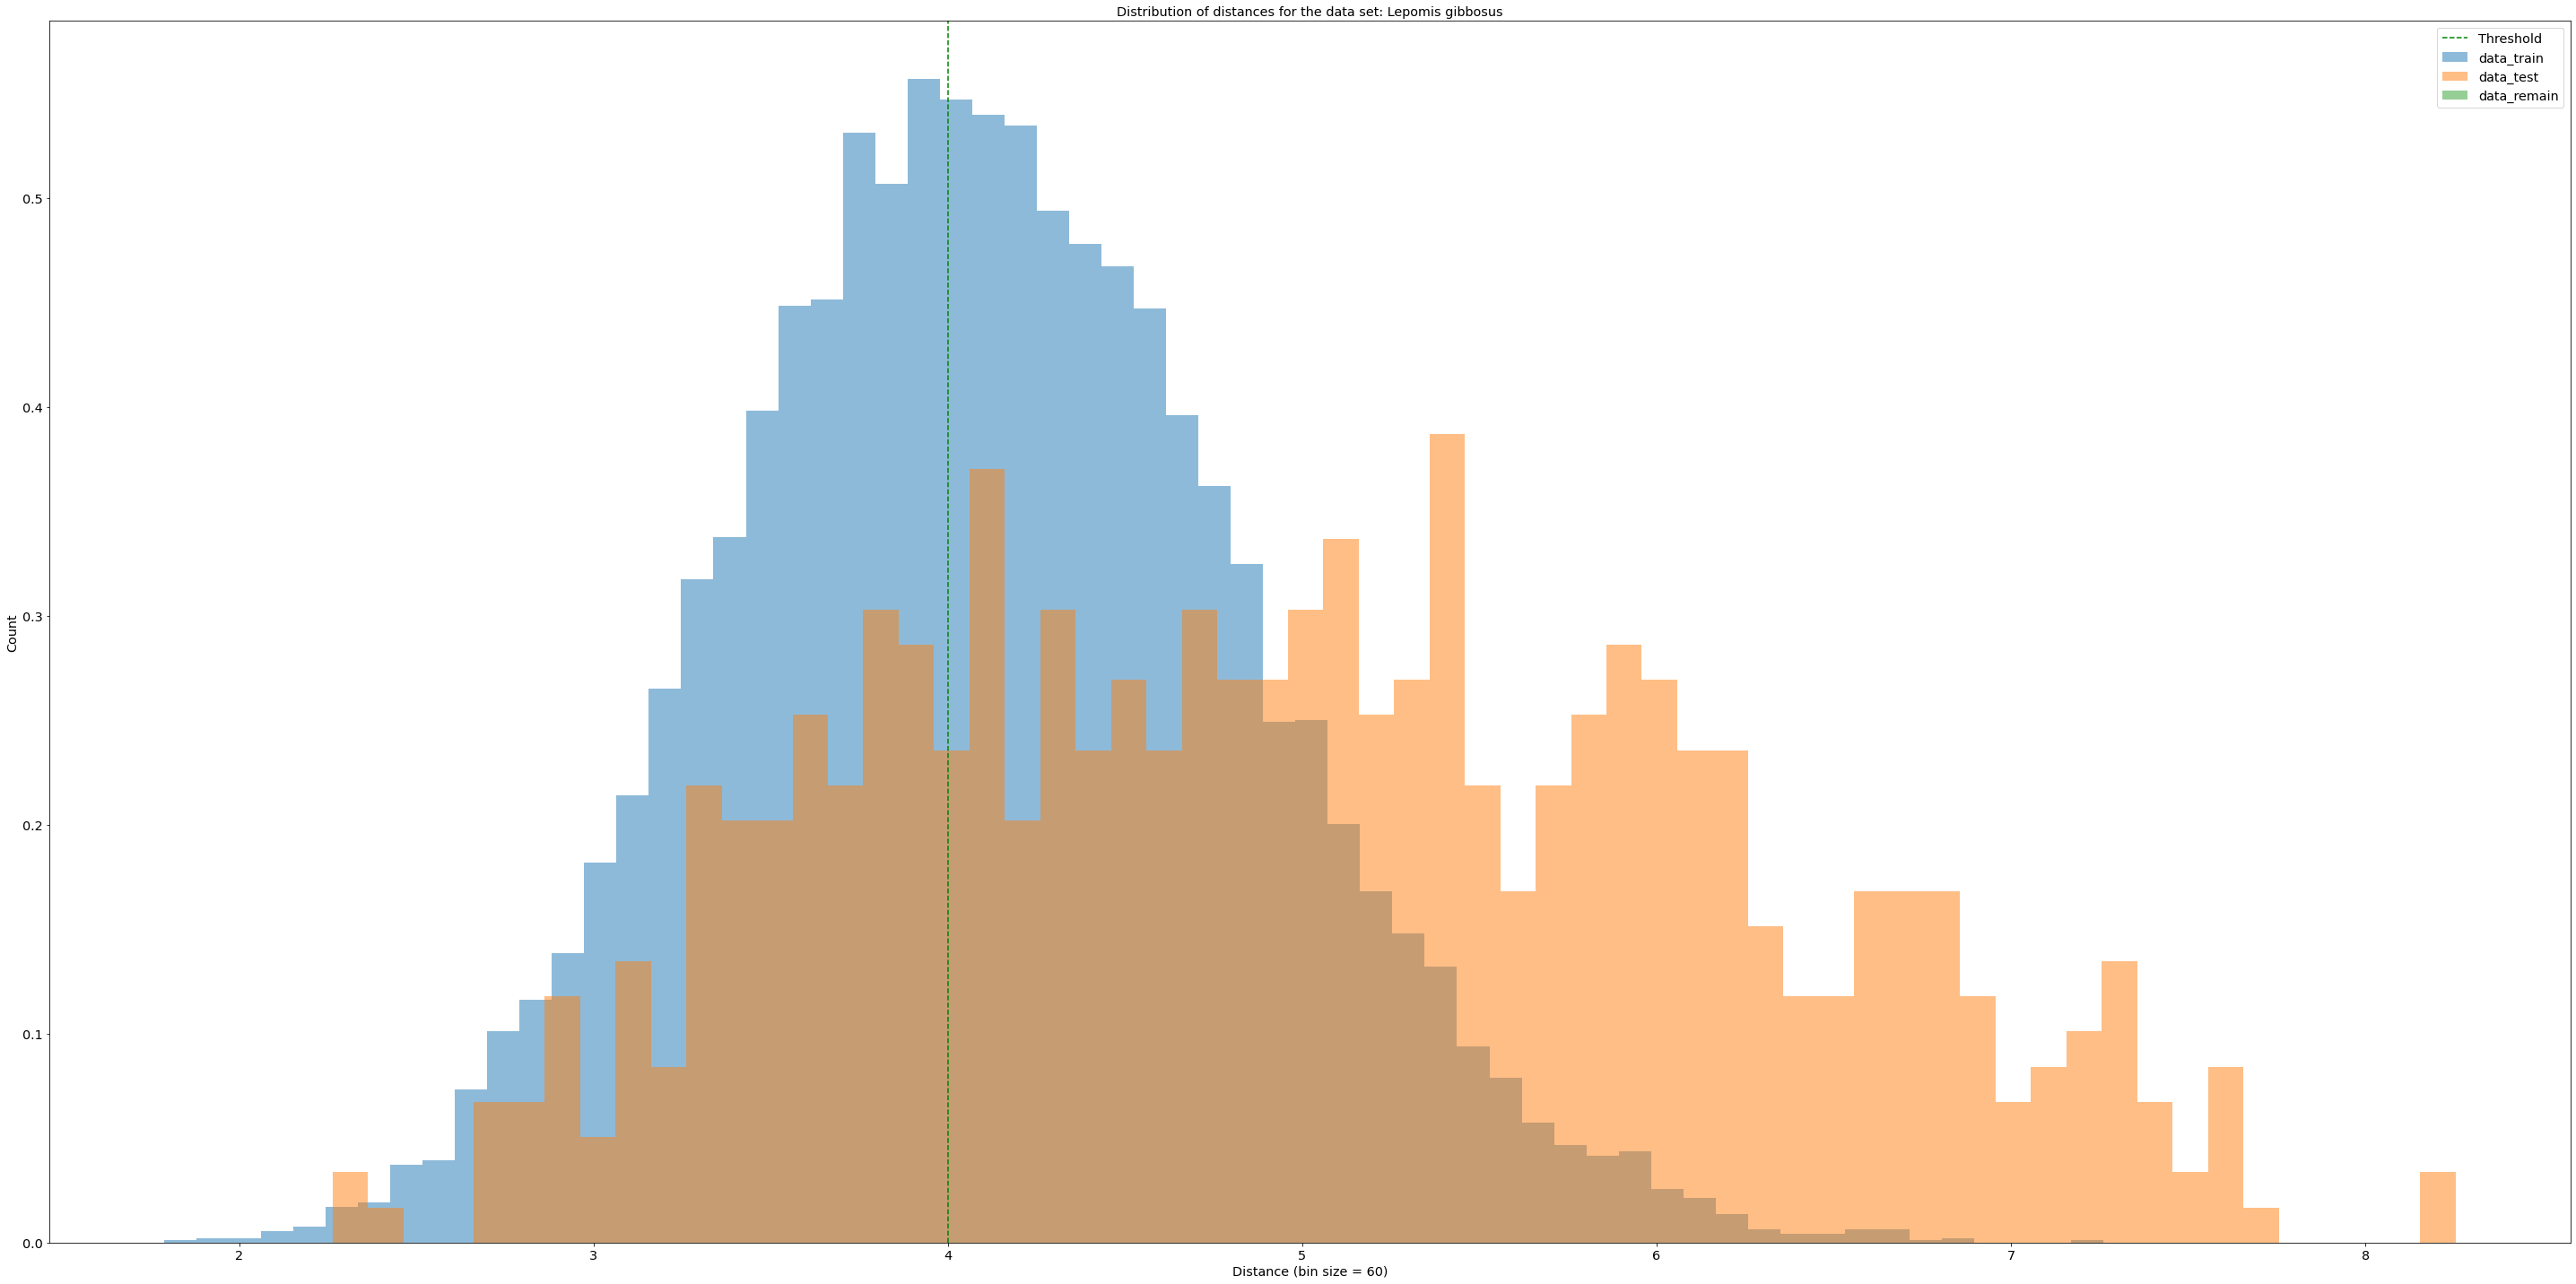

Train: 870 Test: 210 Remain: 0


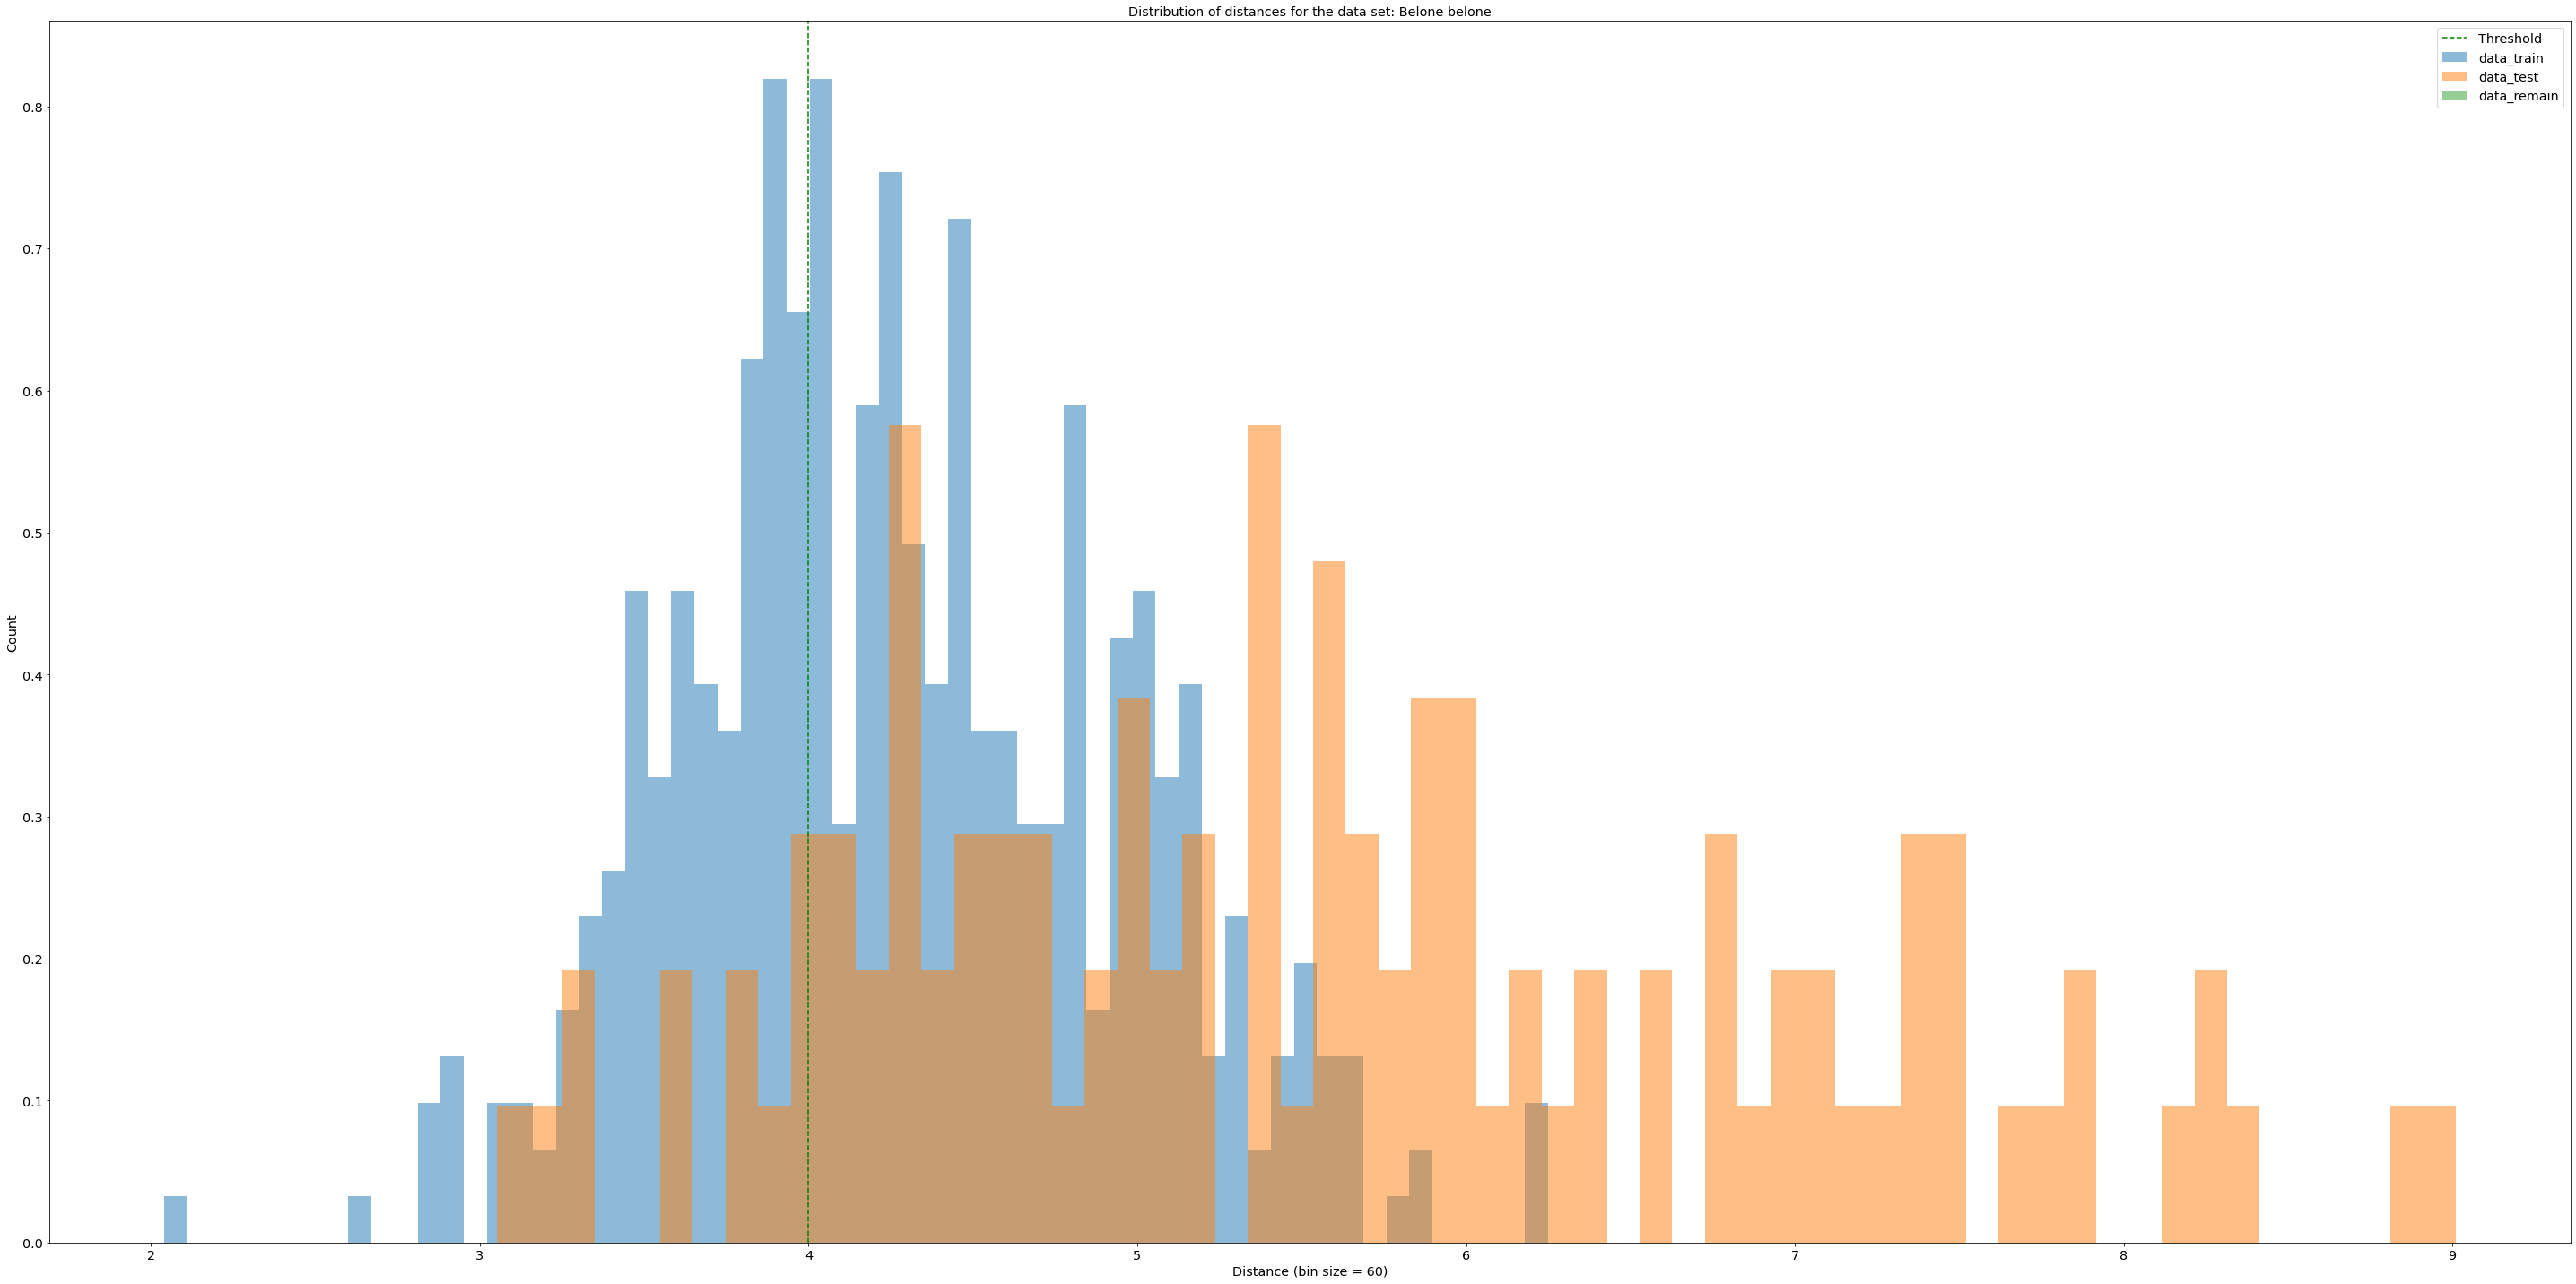

Train: 14762 Test: 930 Remain: 0


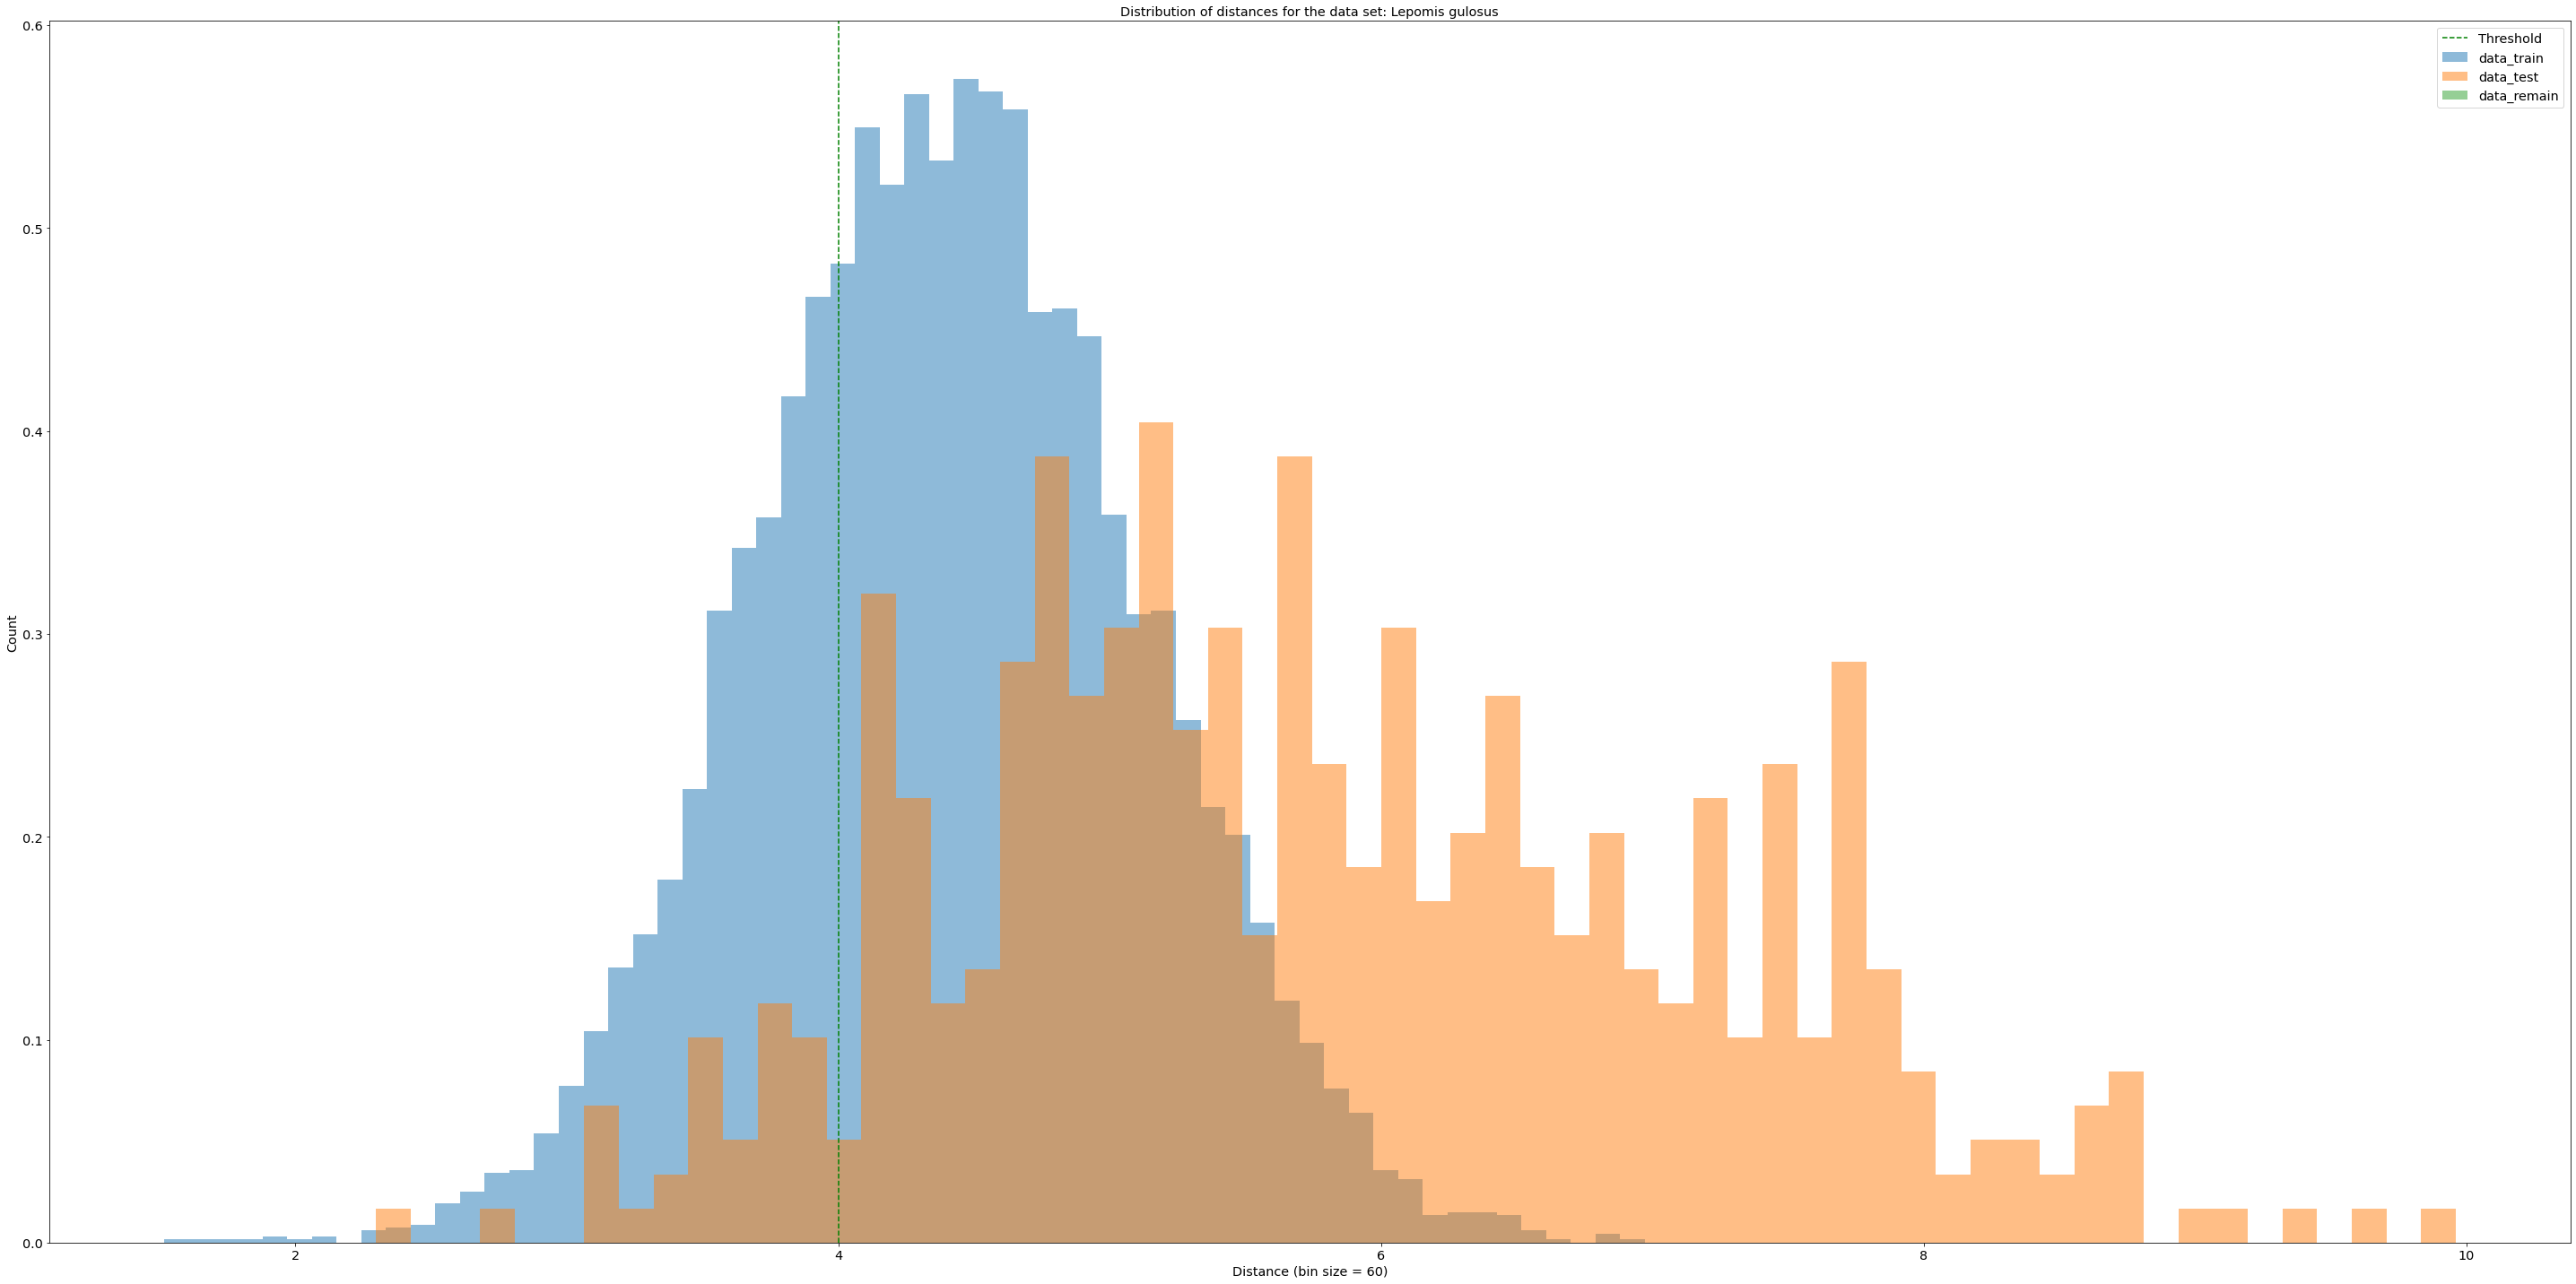

Train: 4692 Test: 272 Remain: 0


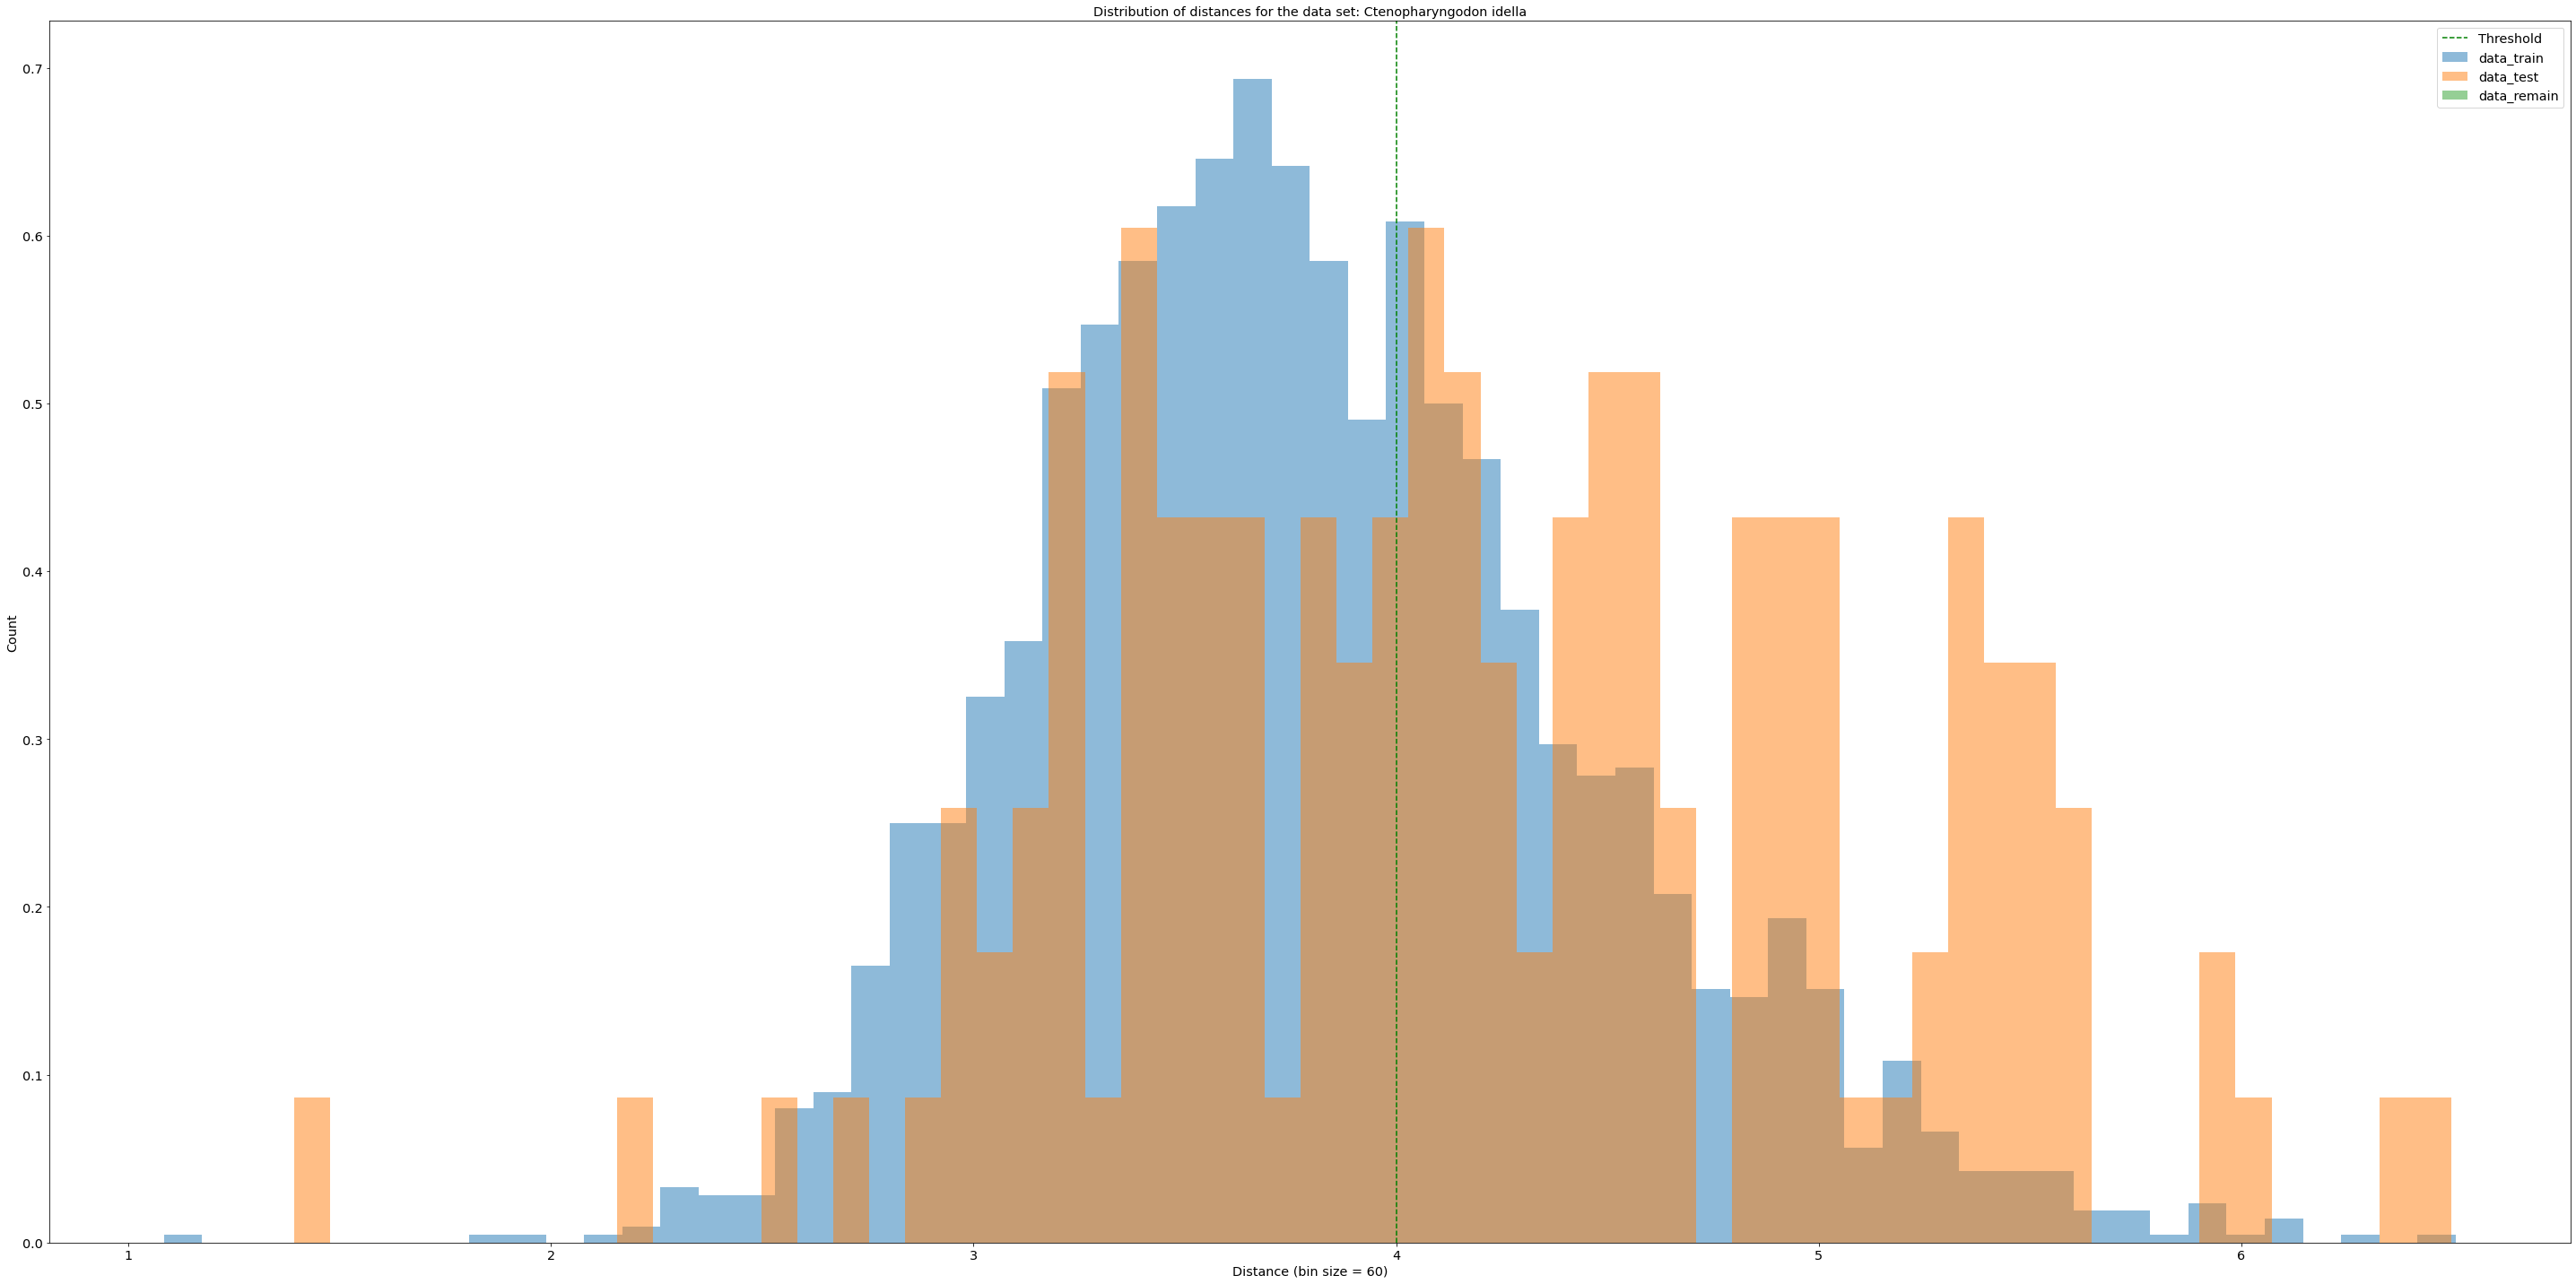

Train: 4830 Test: 272 Remain: 0


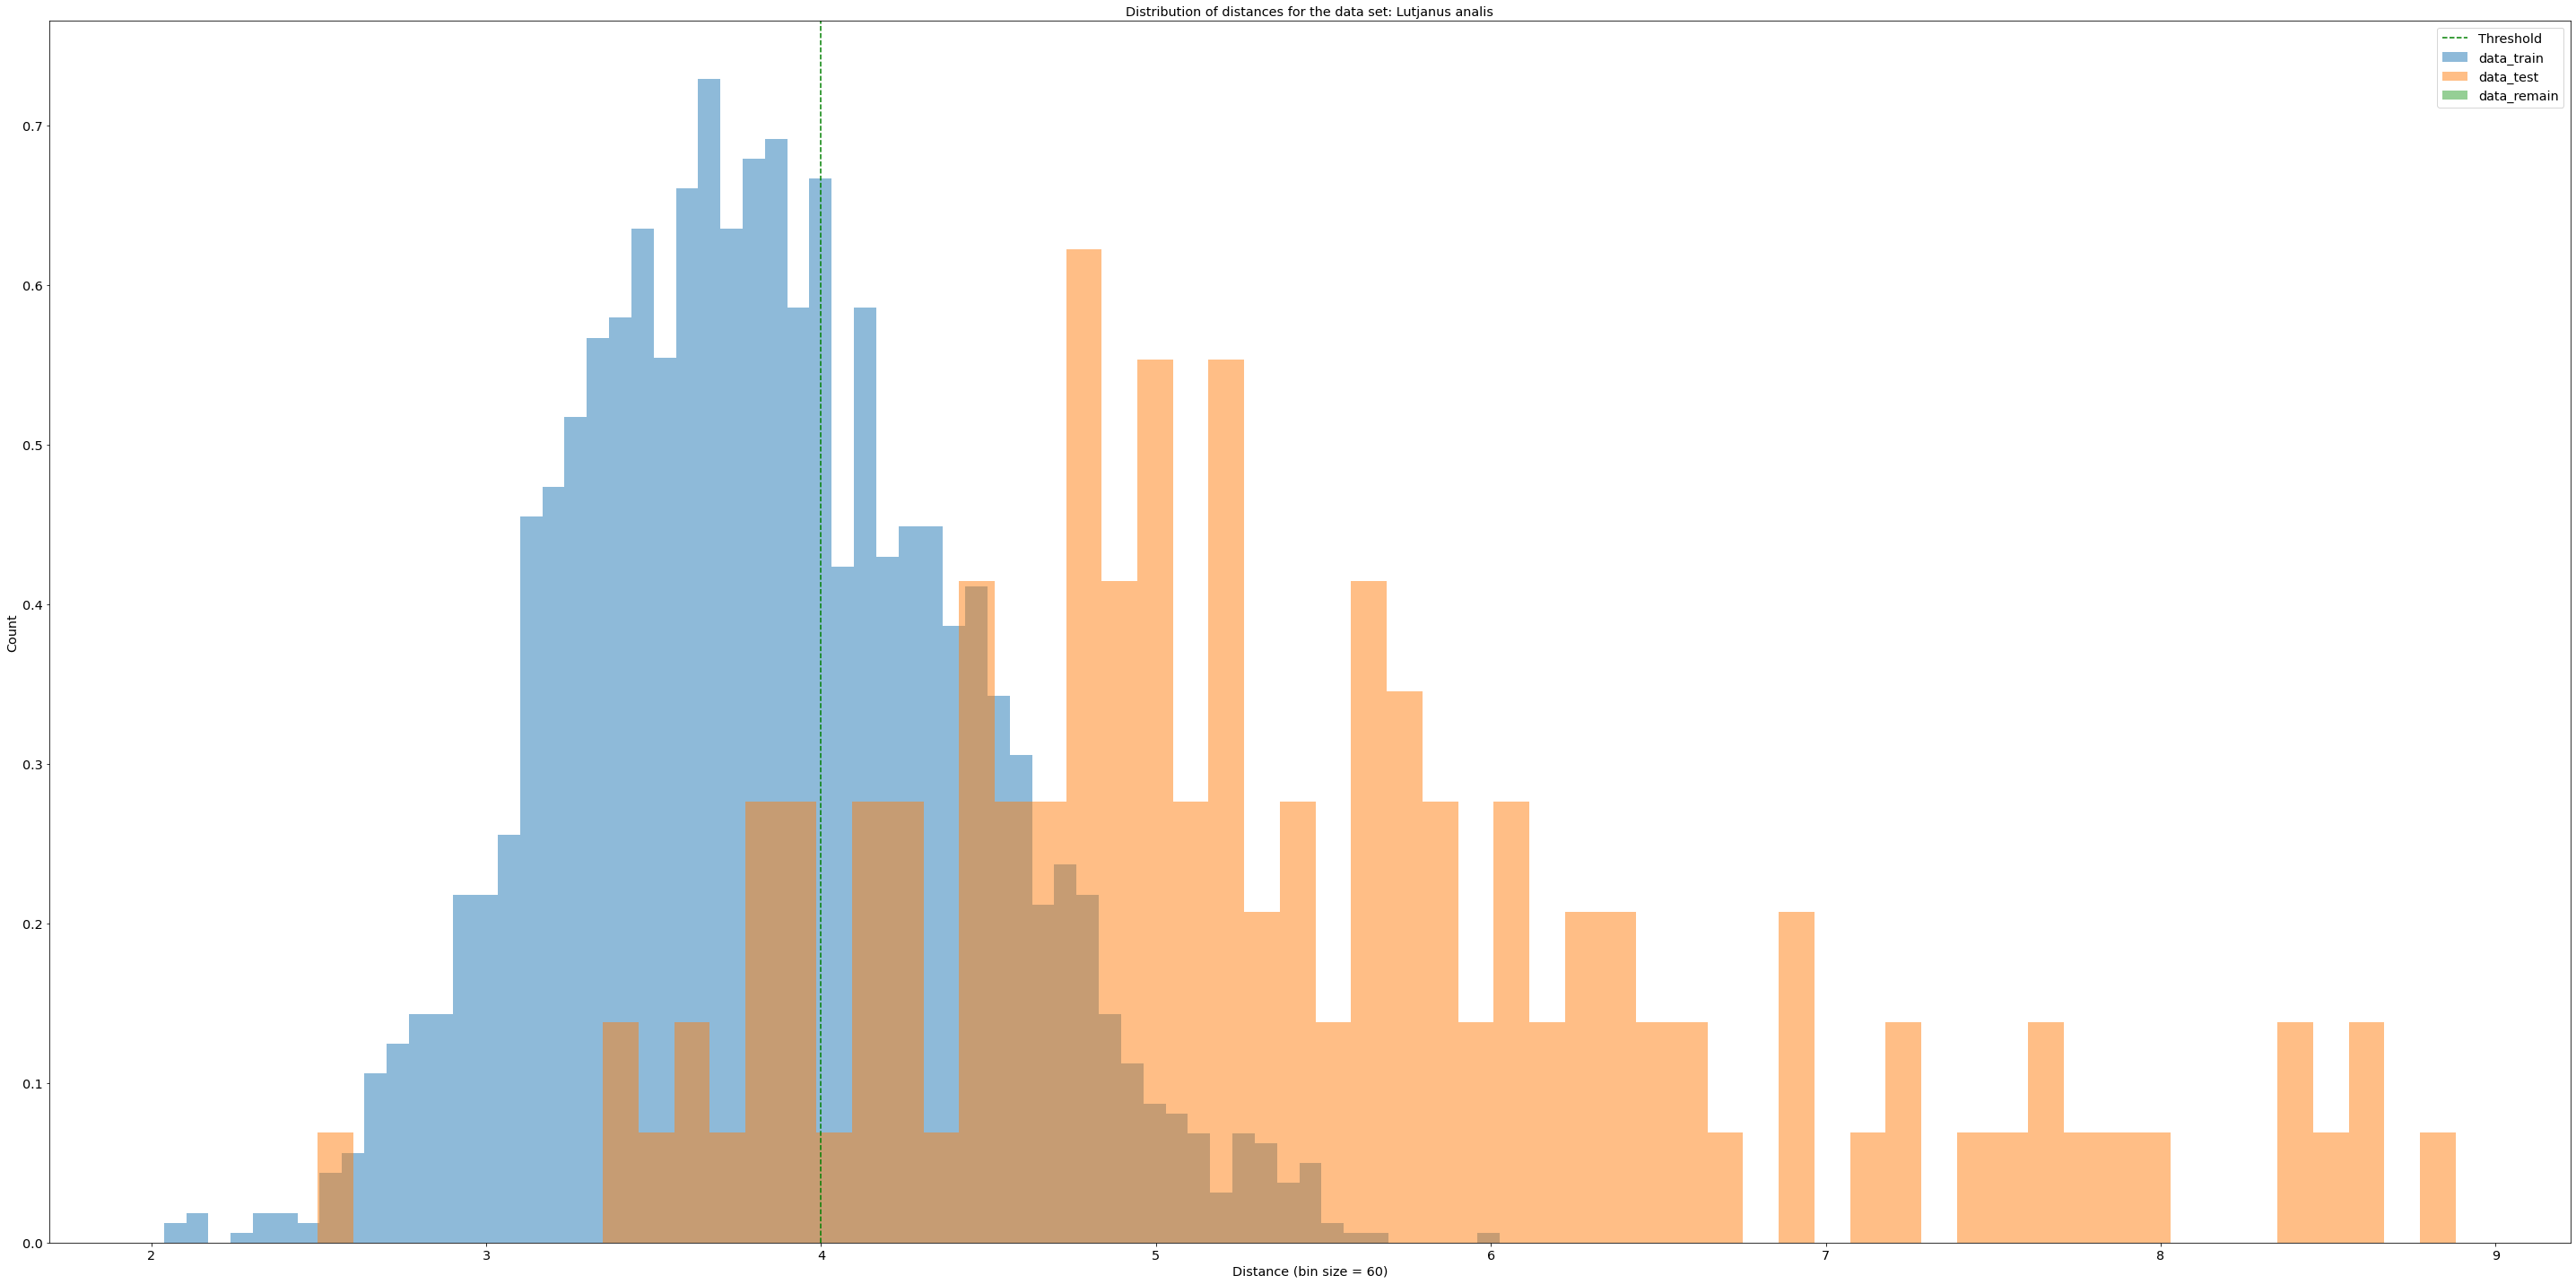

Train: 28392 Test: 1722 Remain: 382542


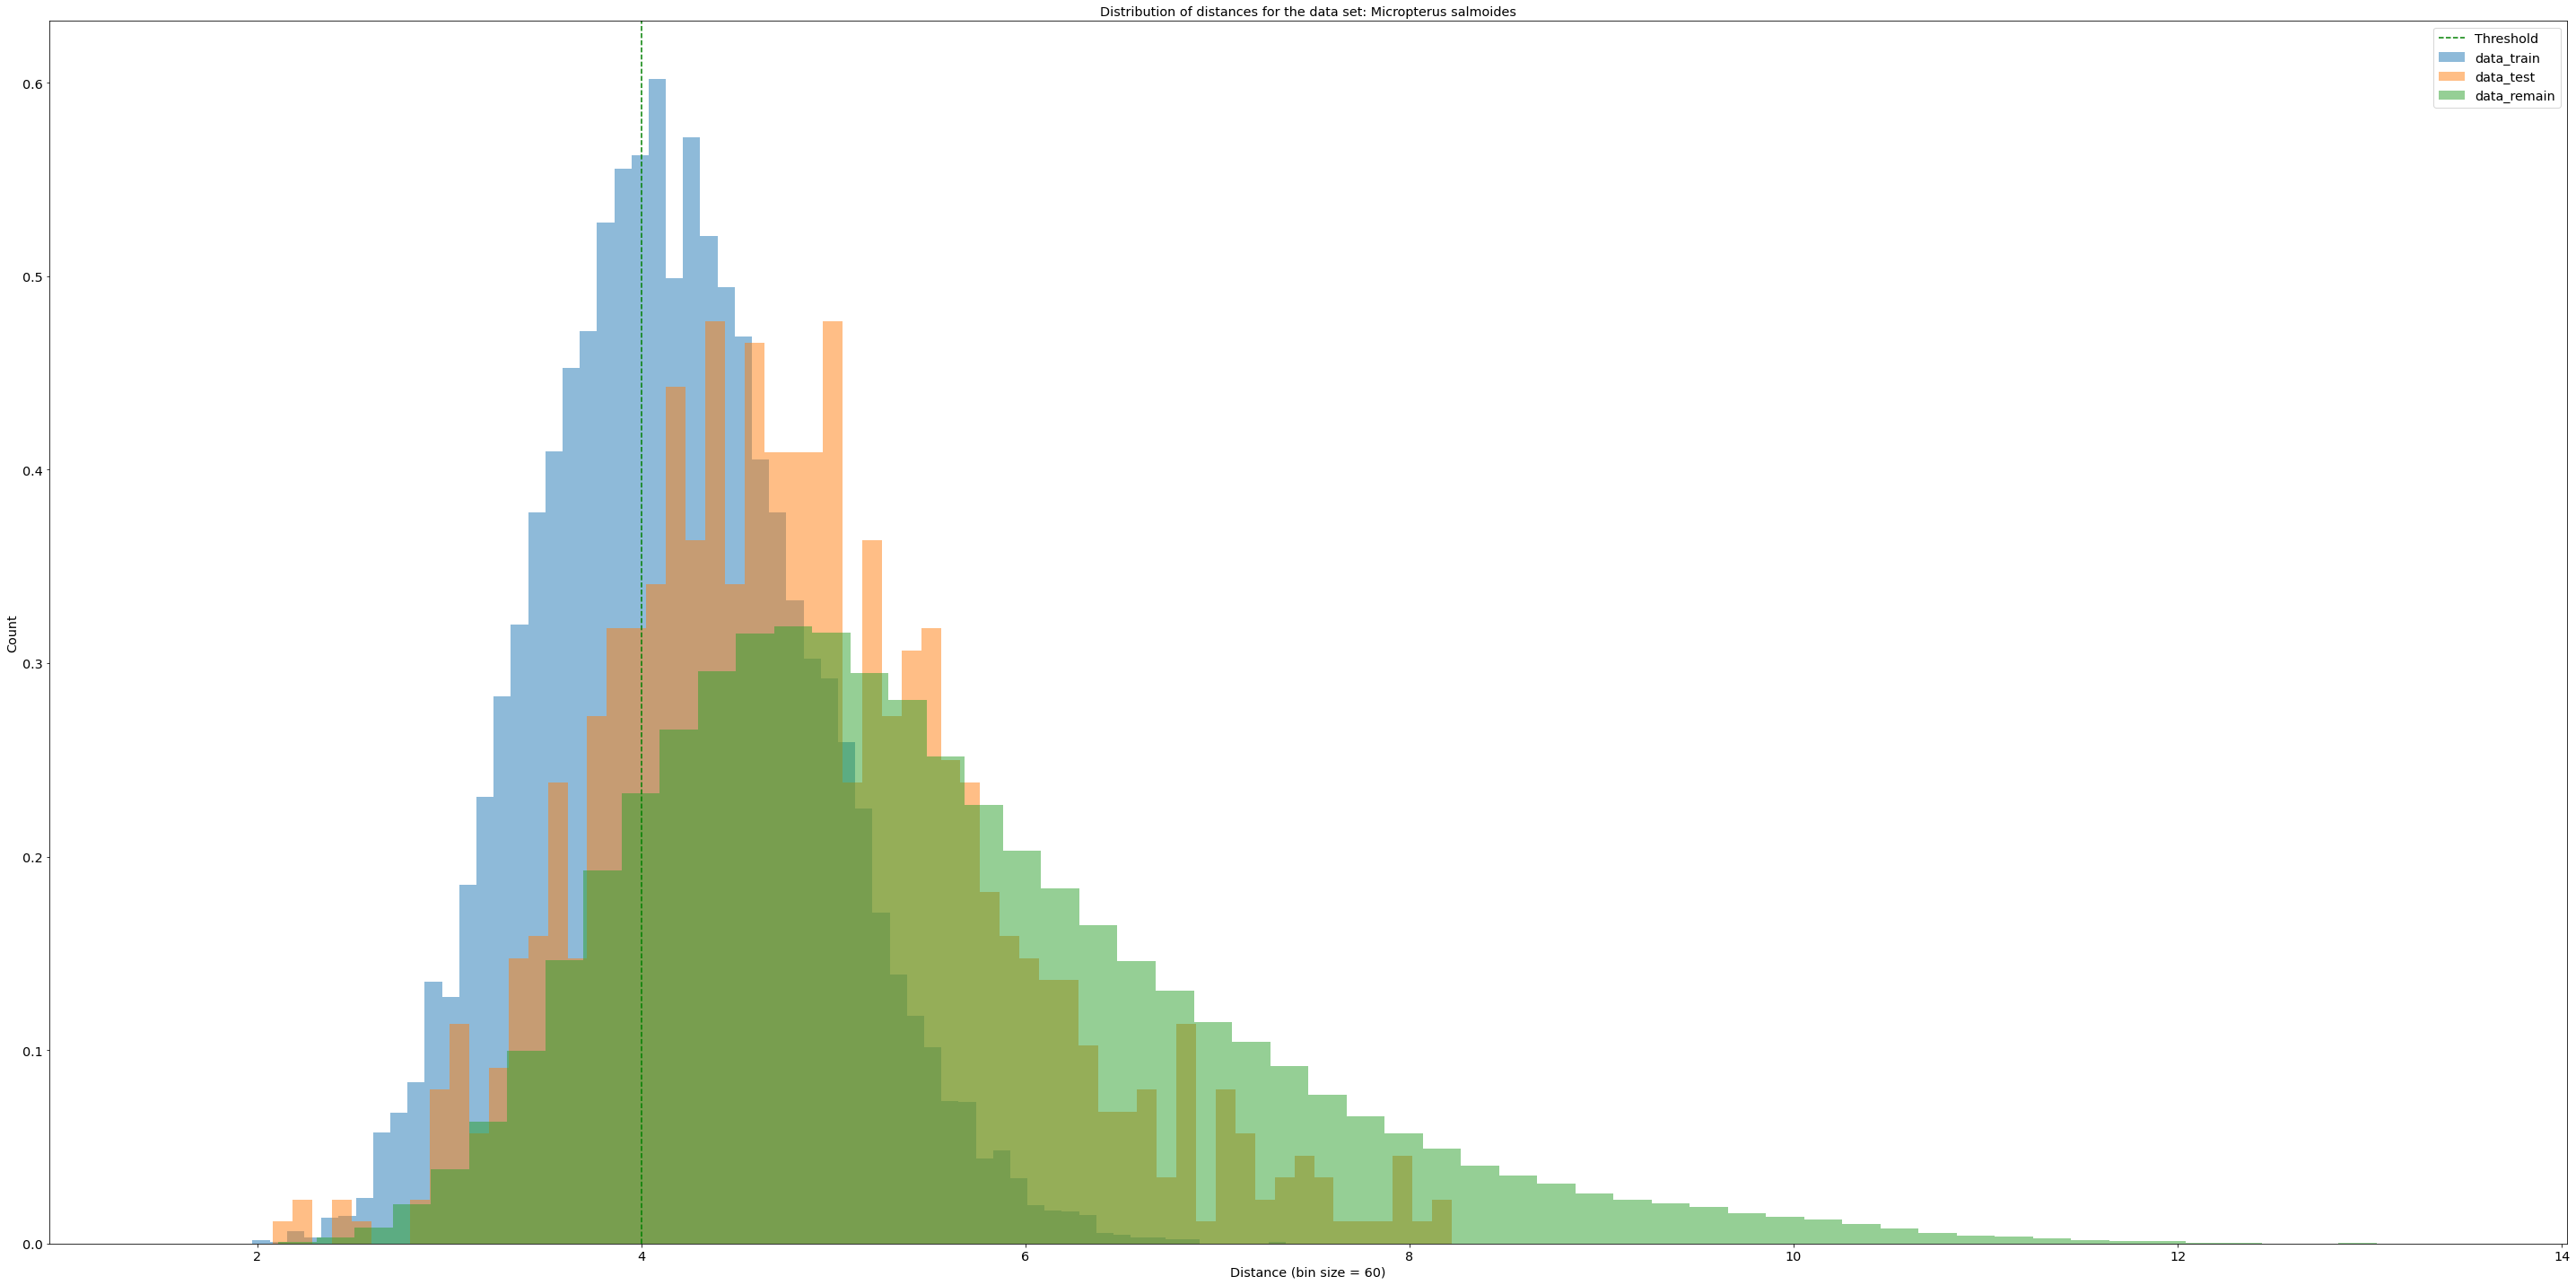

Train: 12432 Test: 756 Remain: 0


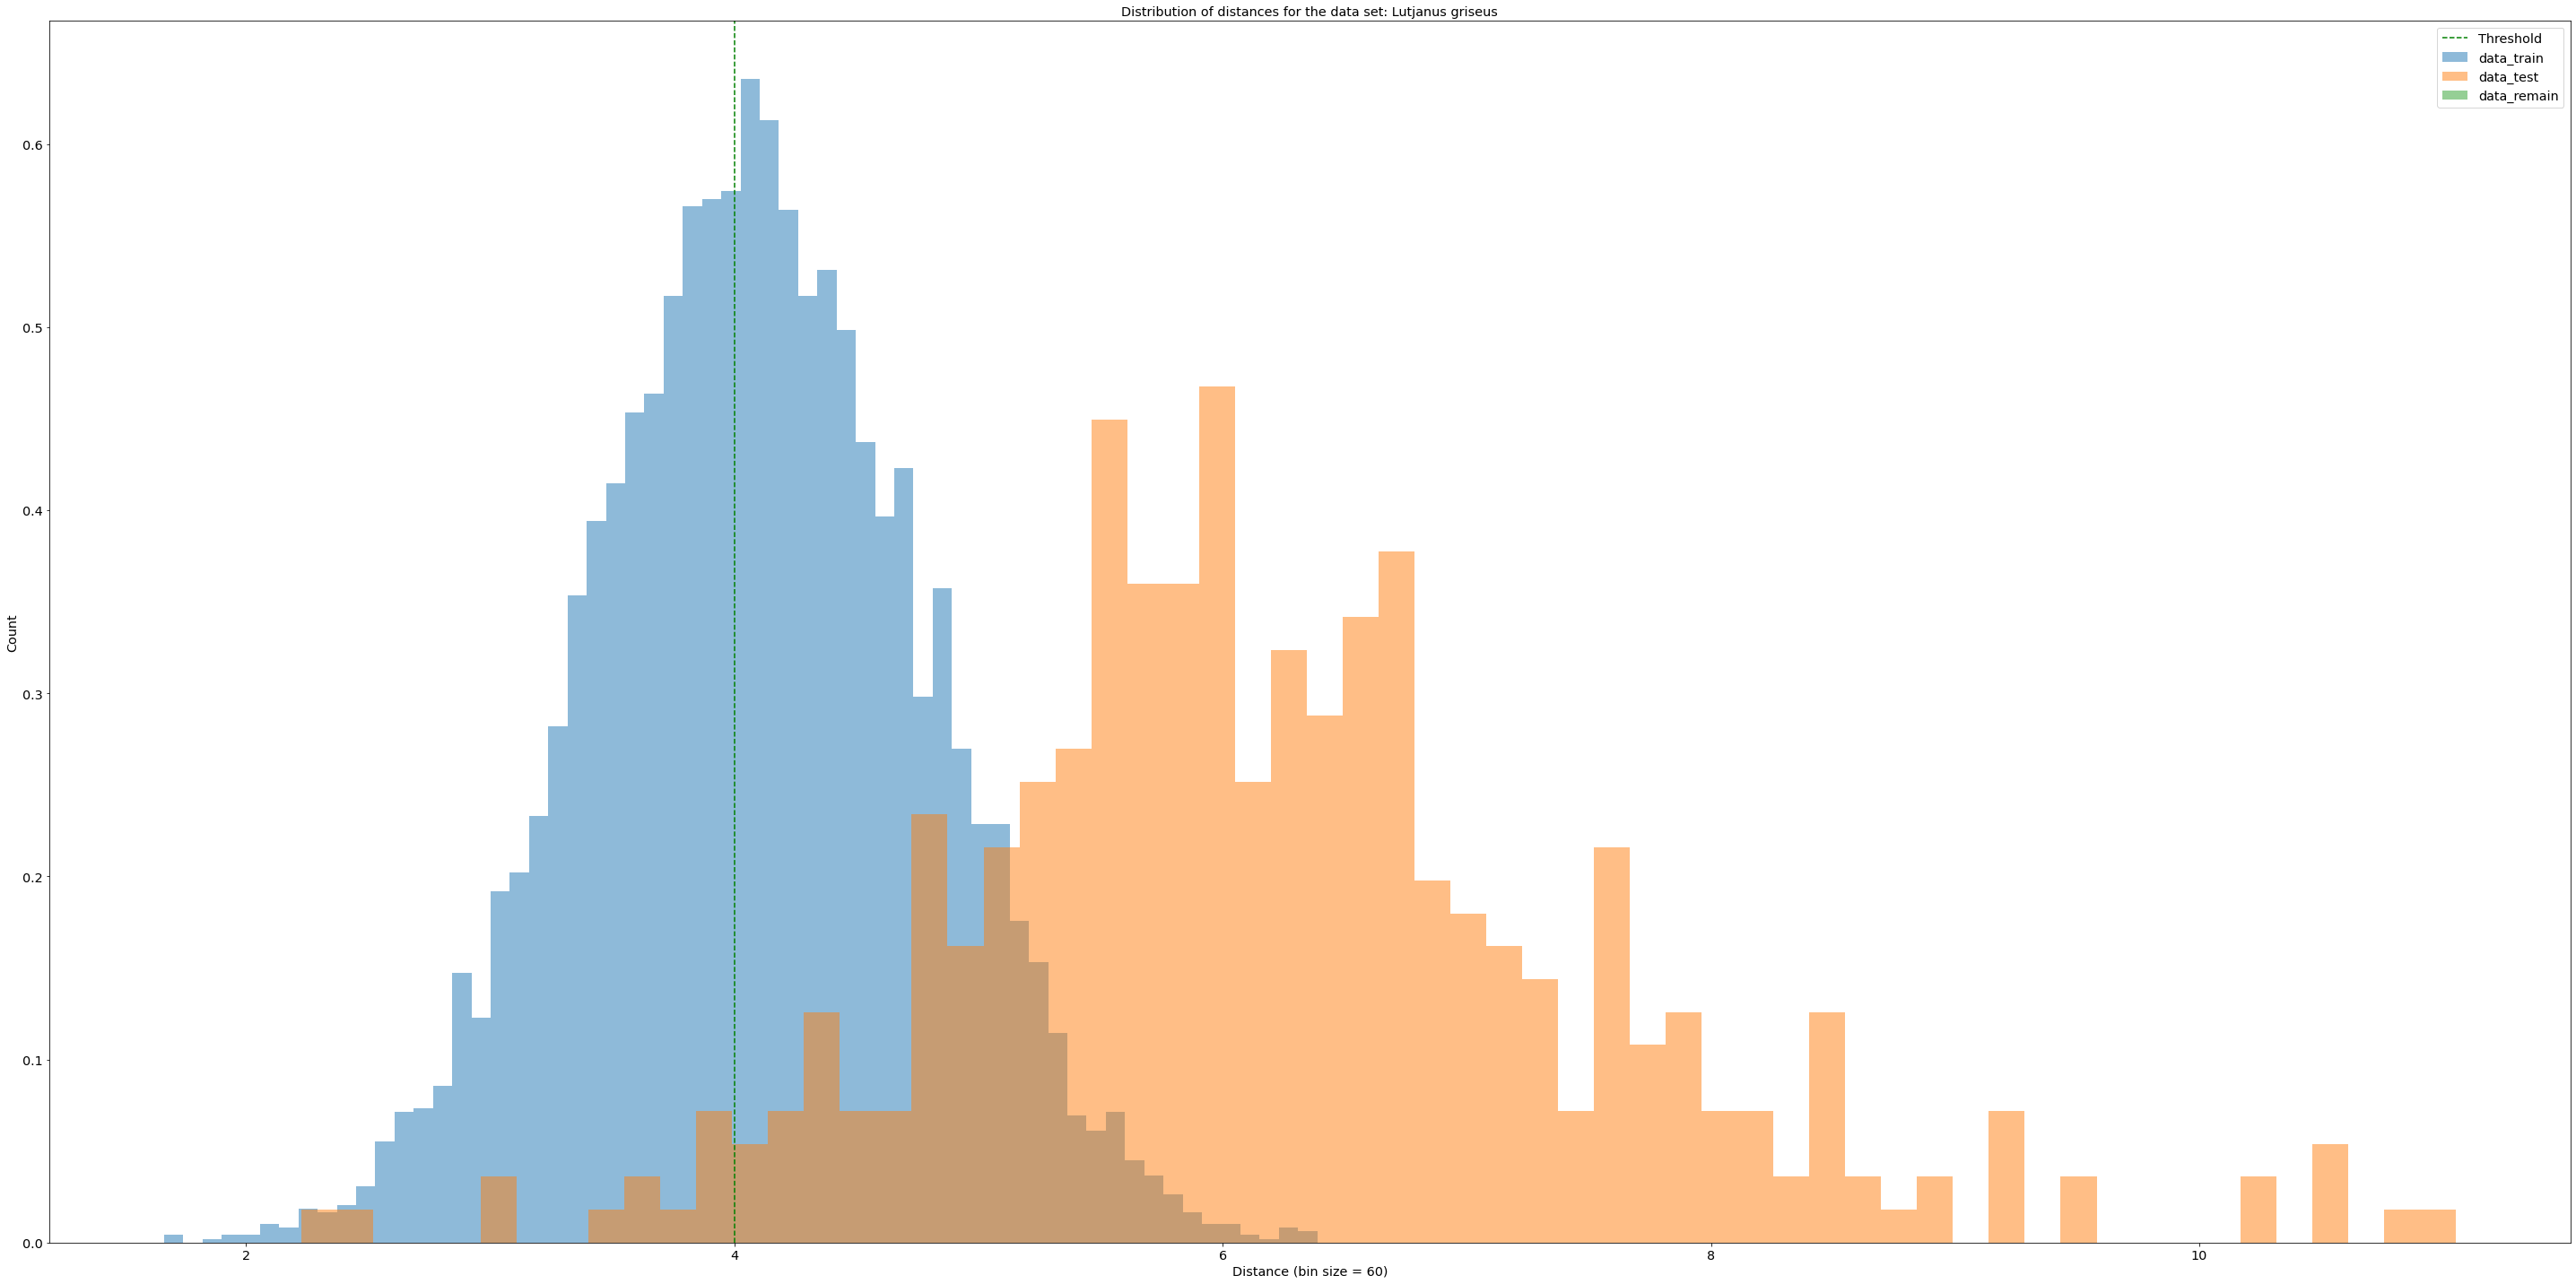

Train: 12210 Test: 702 Remain: 0


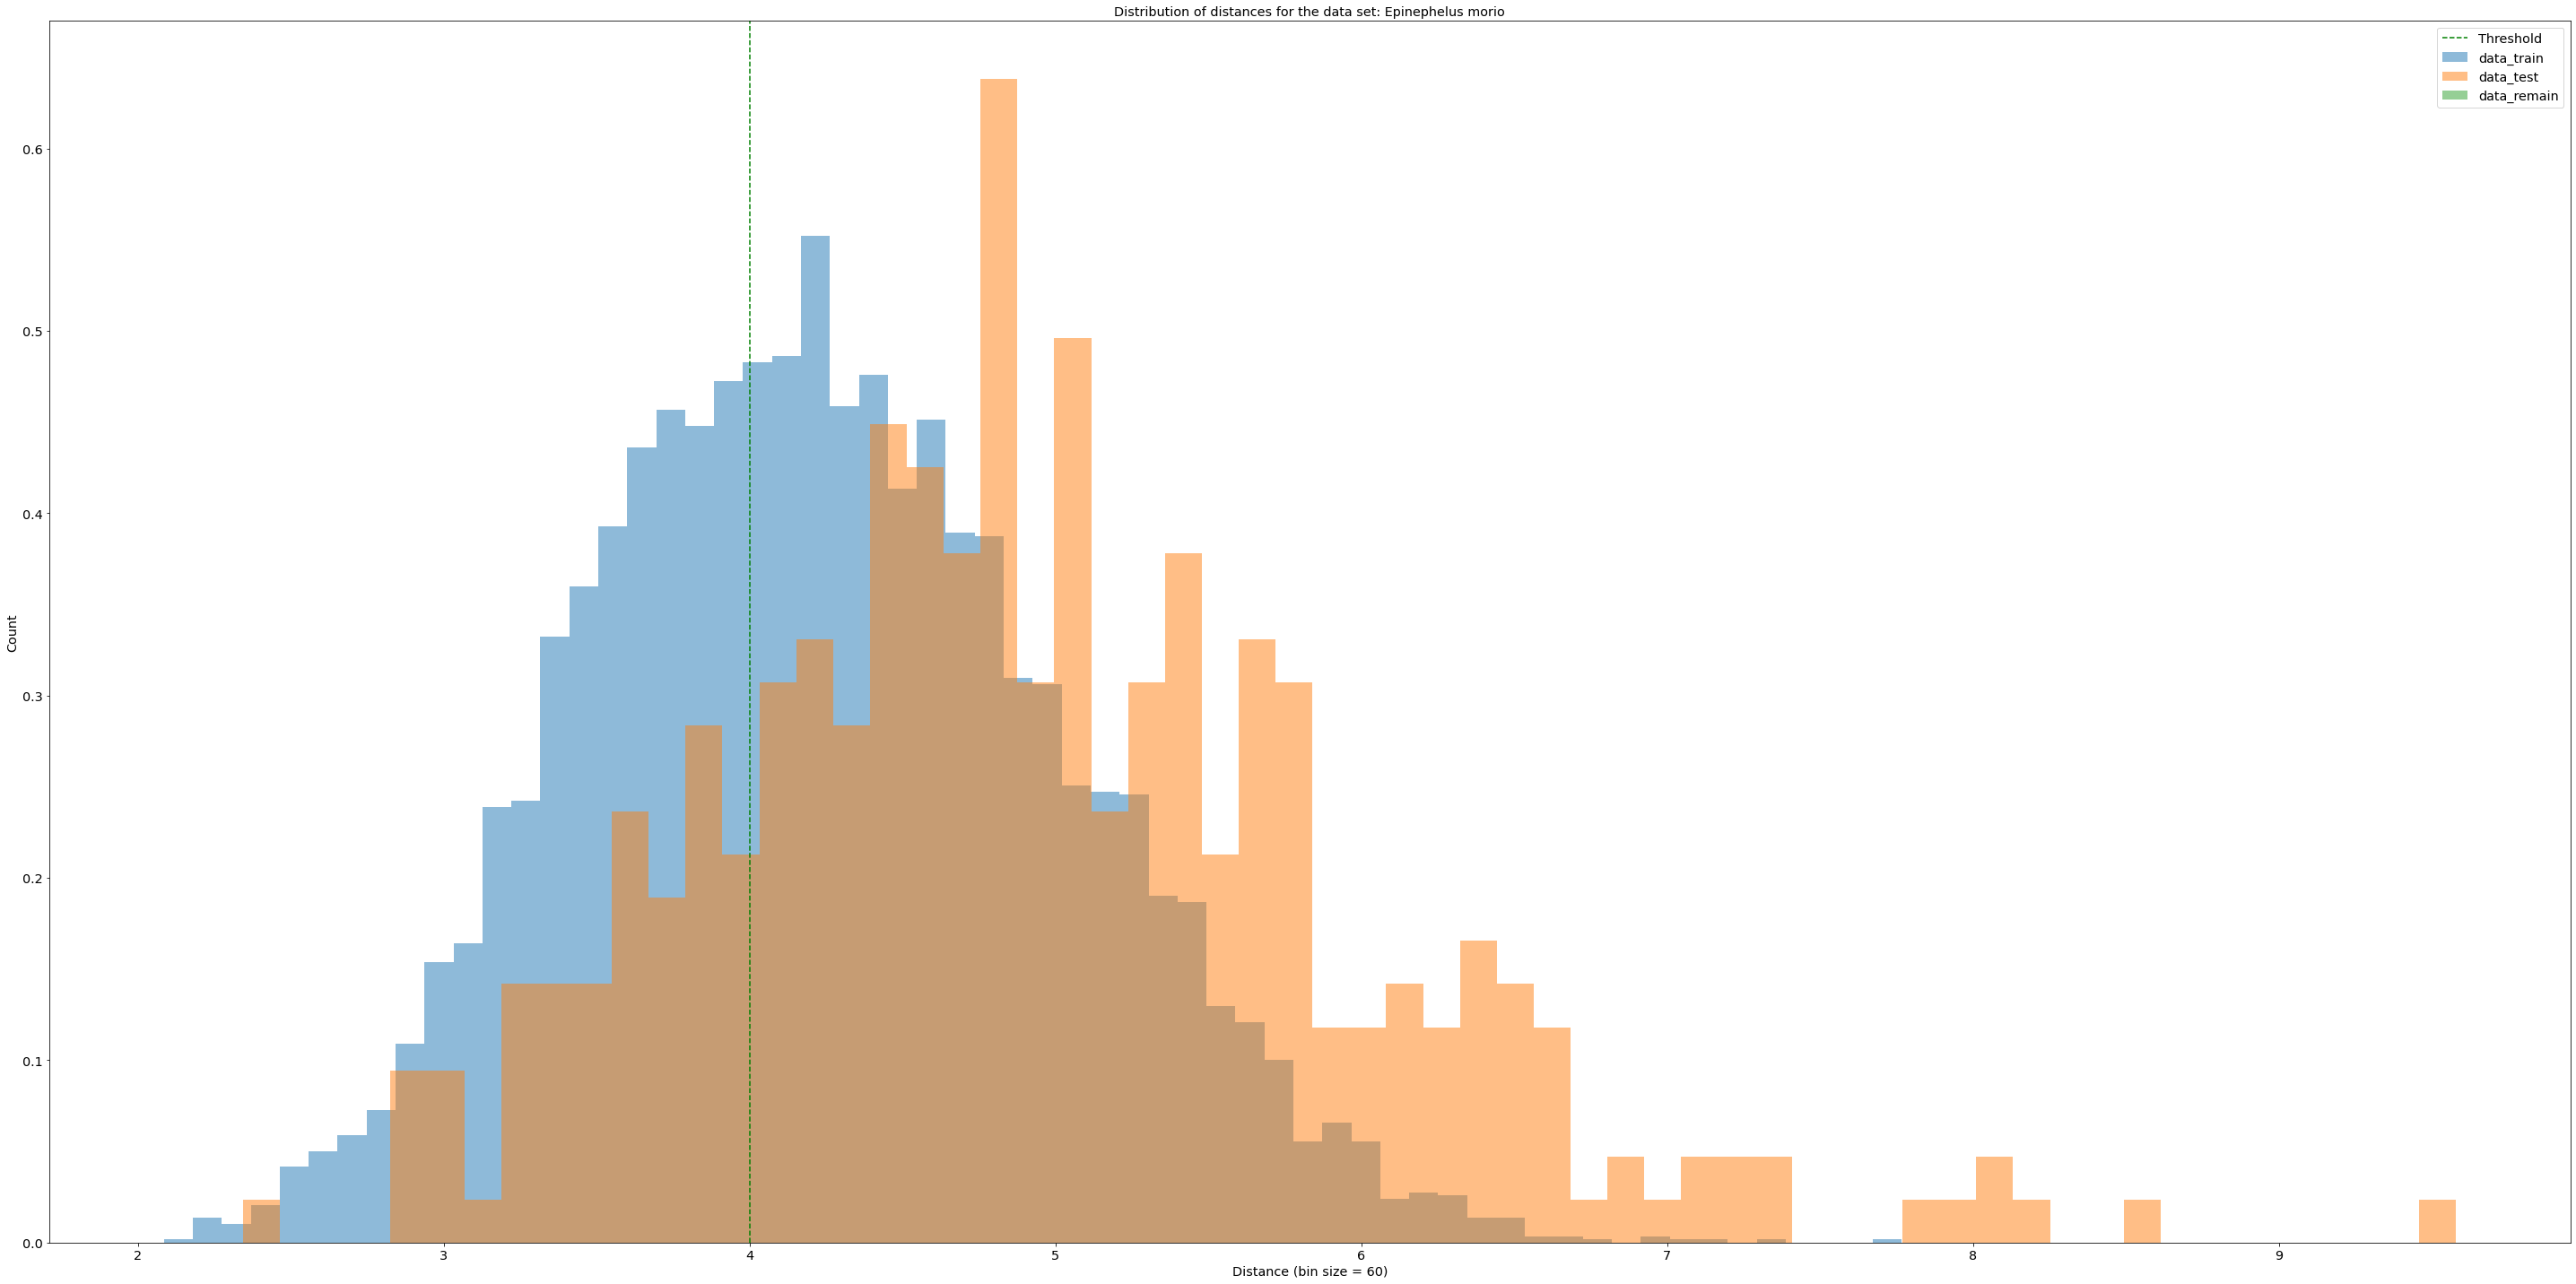

Train: 23562 Test: 1406 Remain: 0


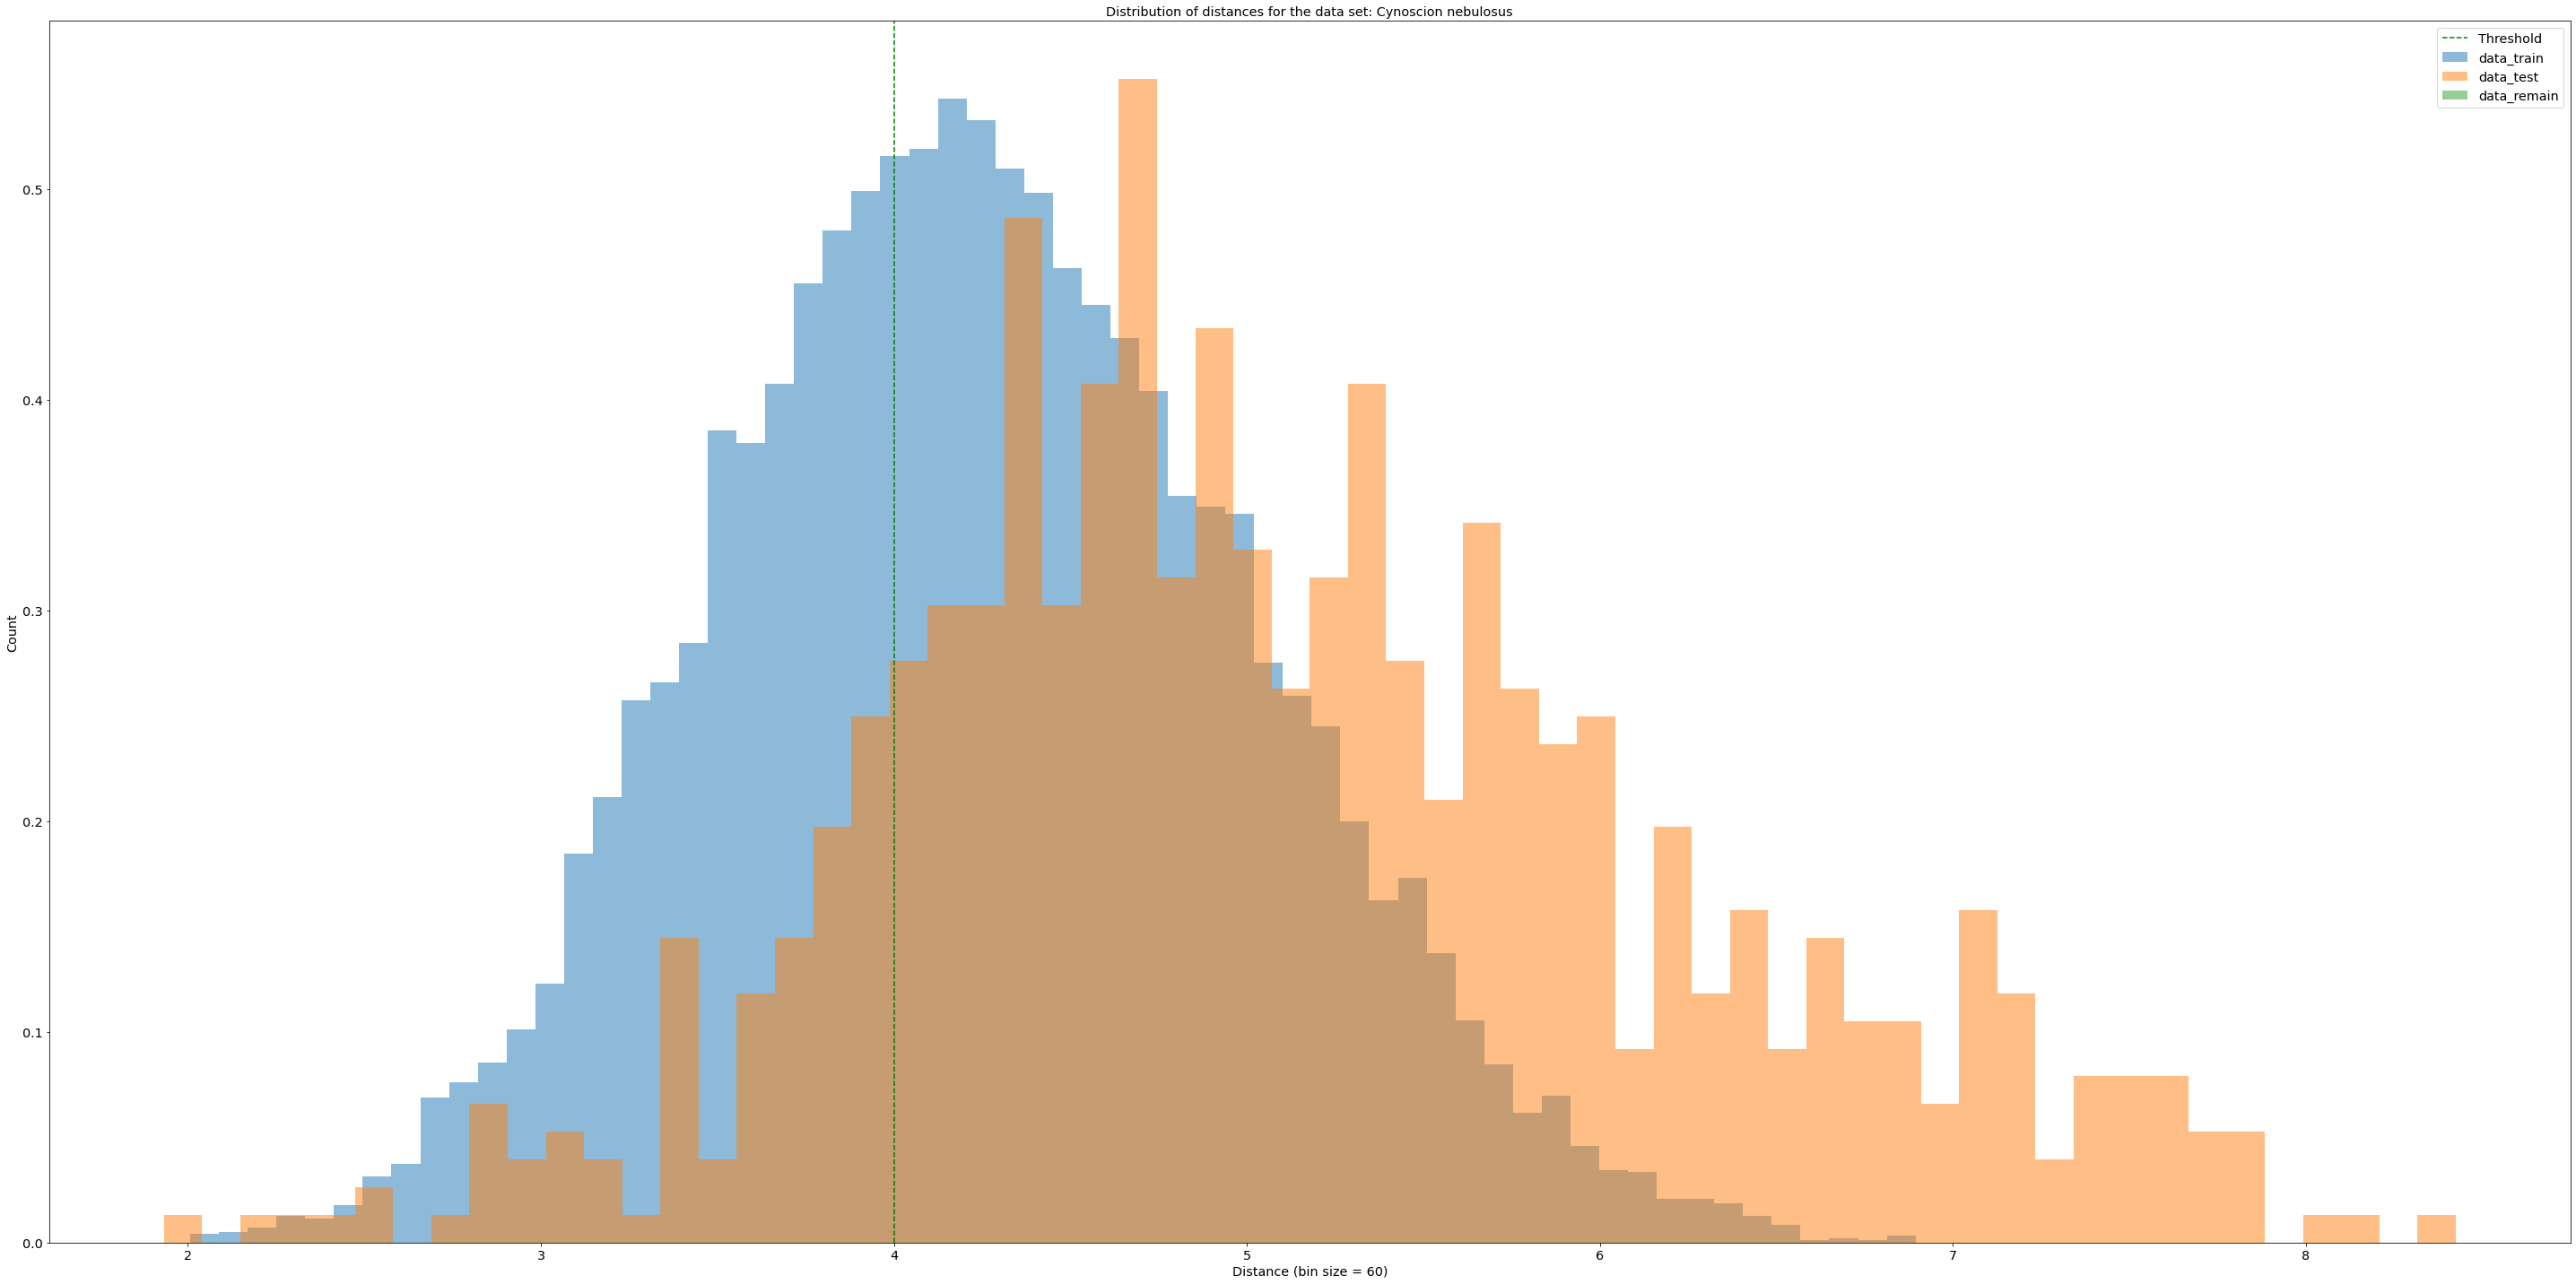

Train: 14520 Test: 870 Remain: 0


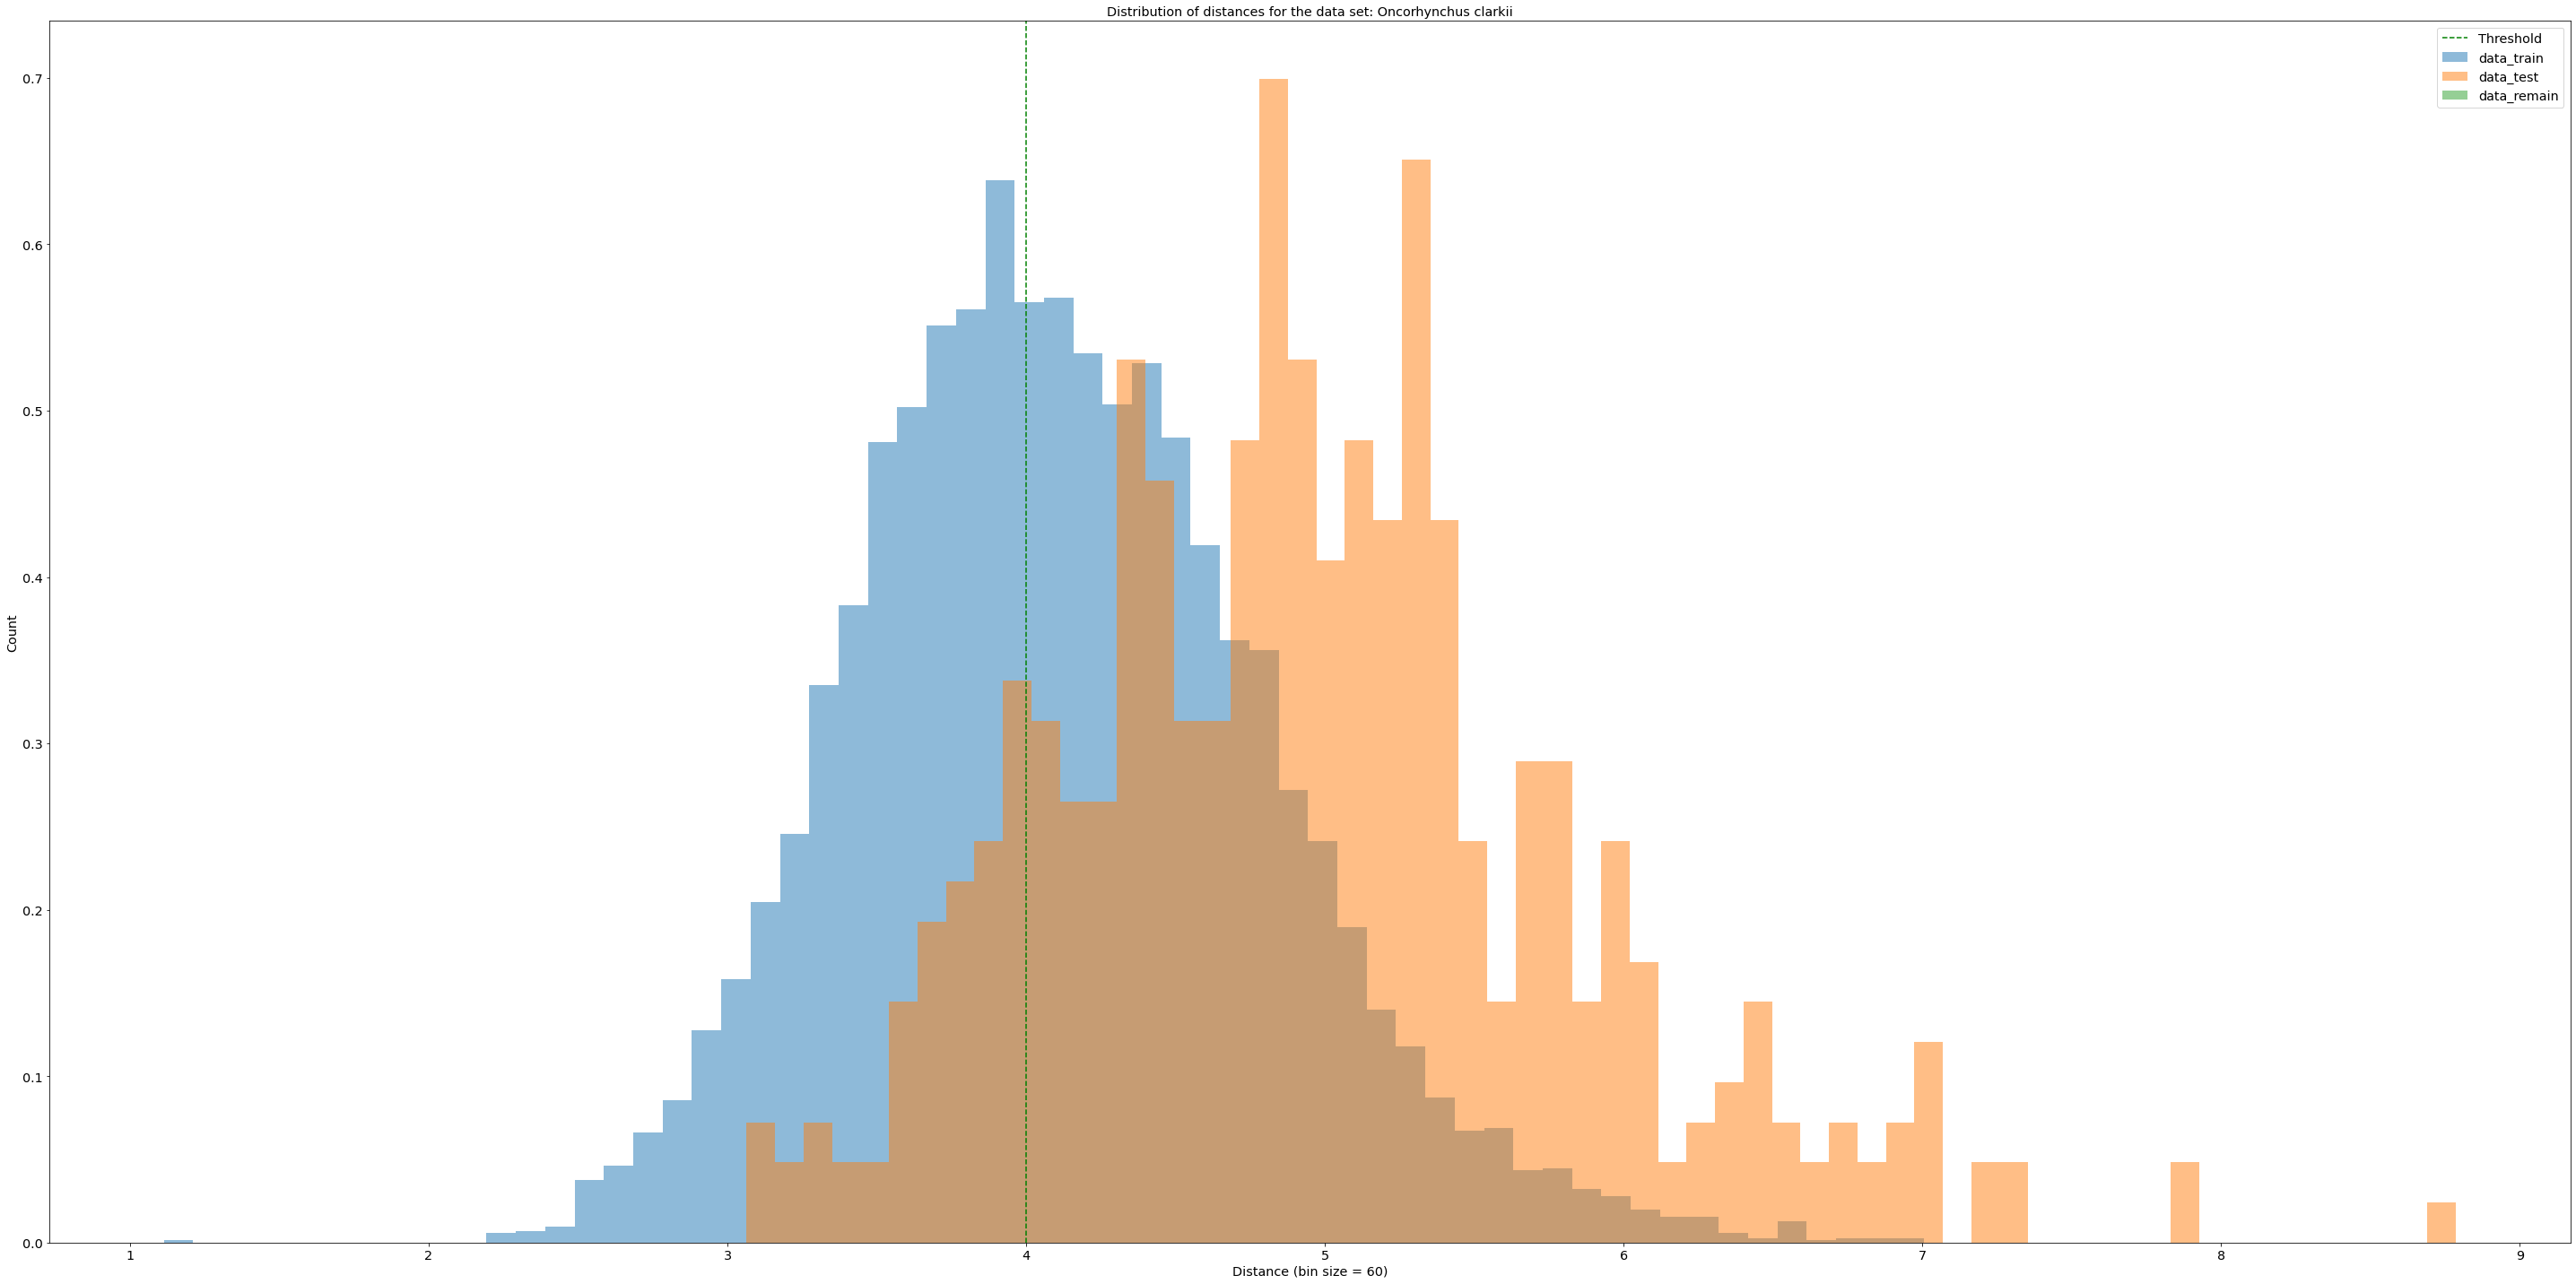

Train: 20592 Test: 1190 Remain: 0


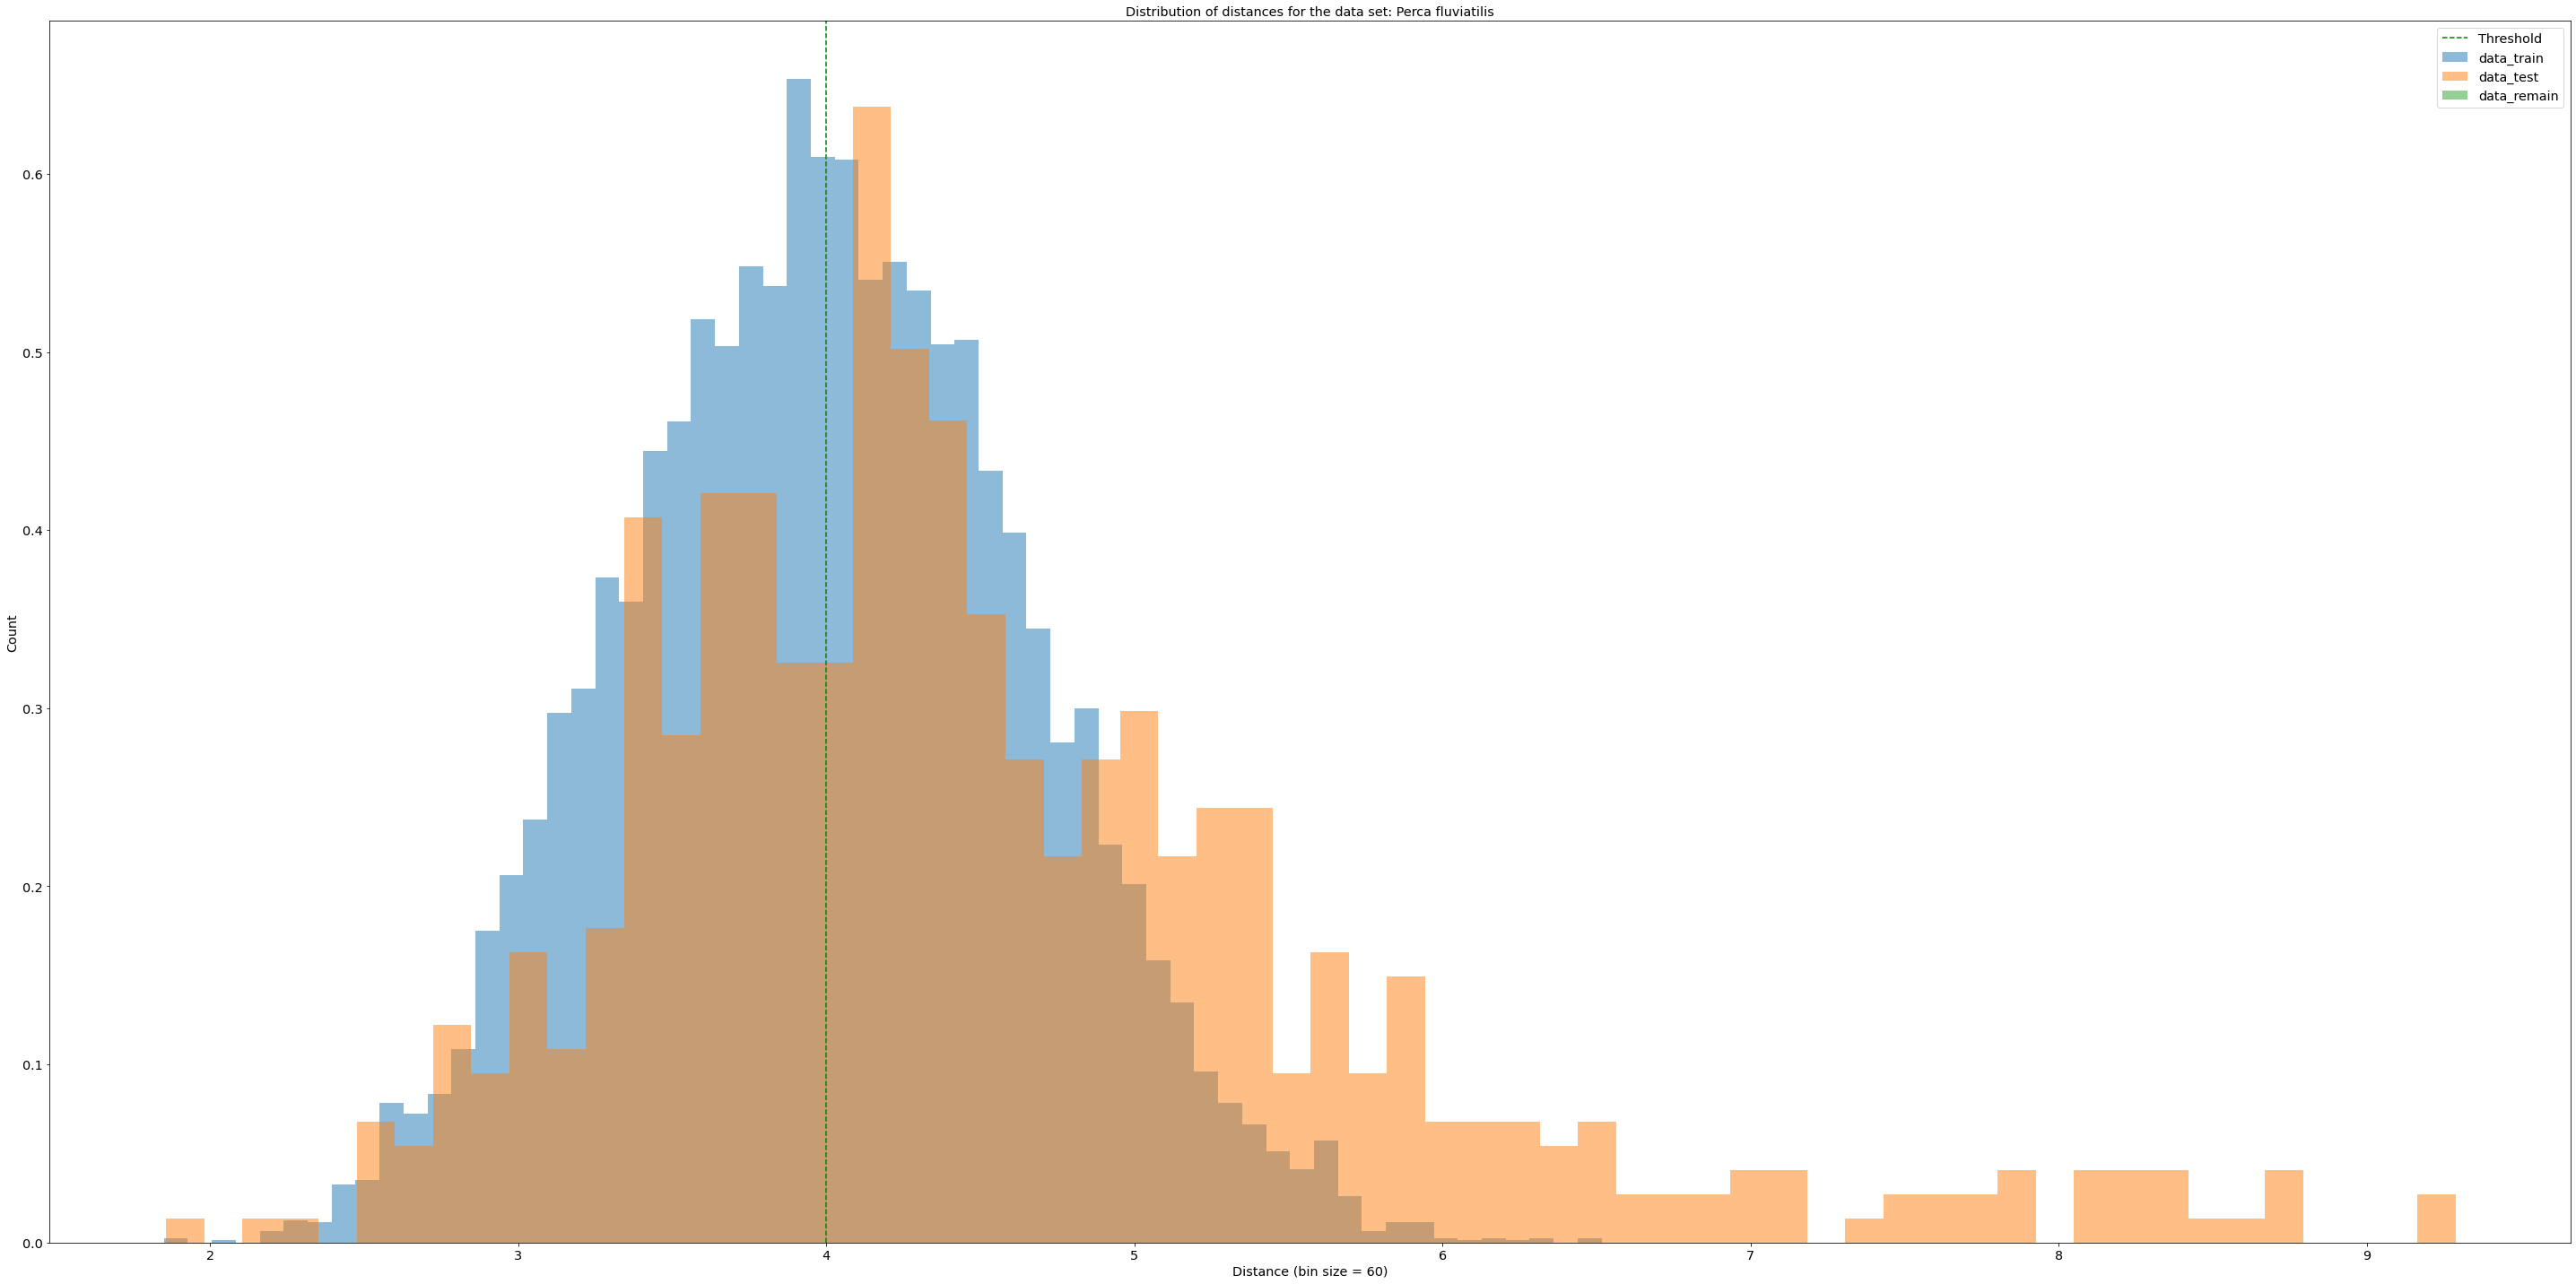

Train: 0 Test: 0 Remain: 0


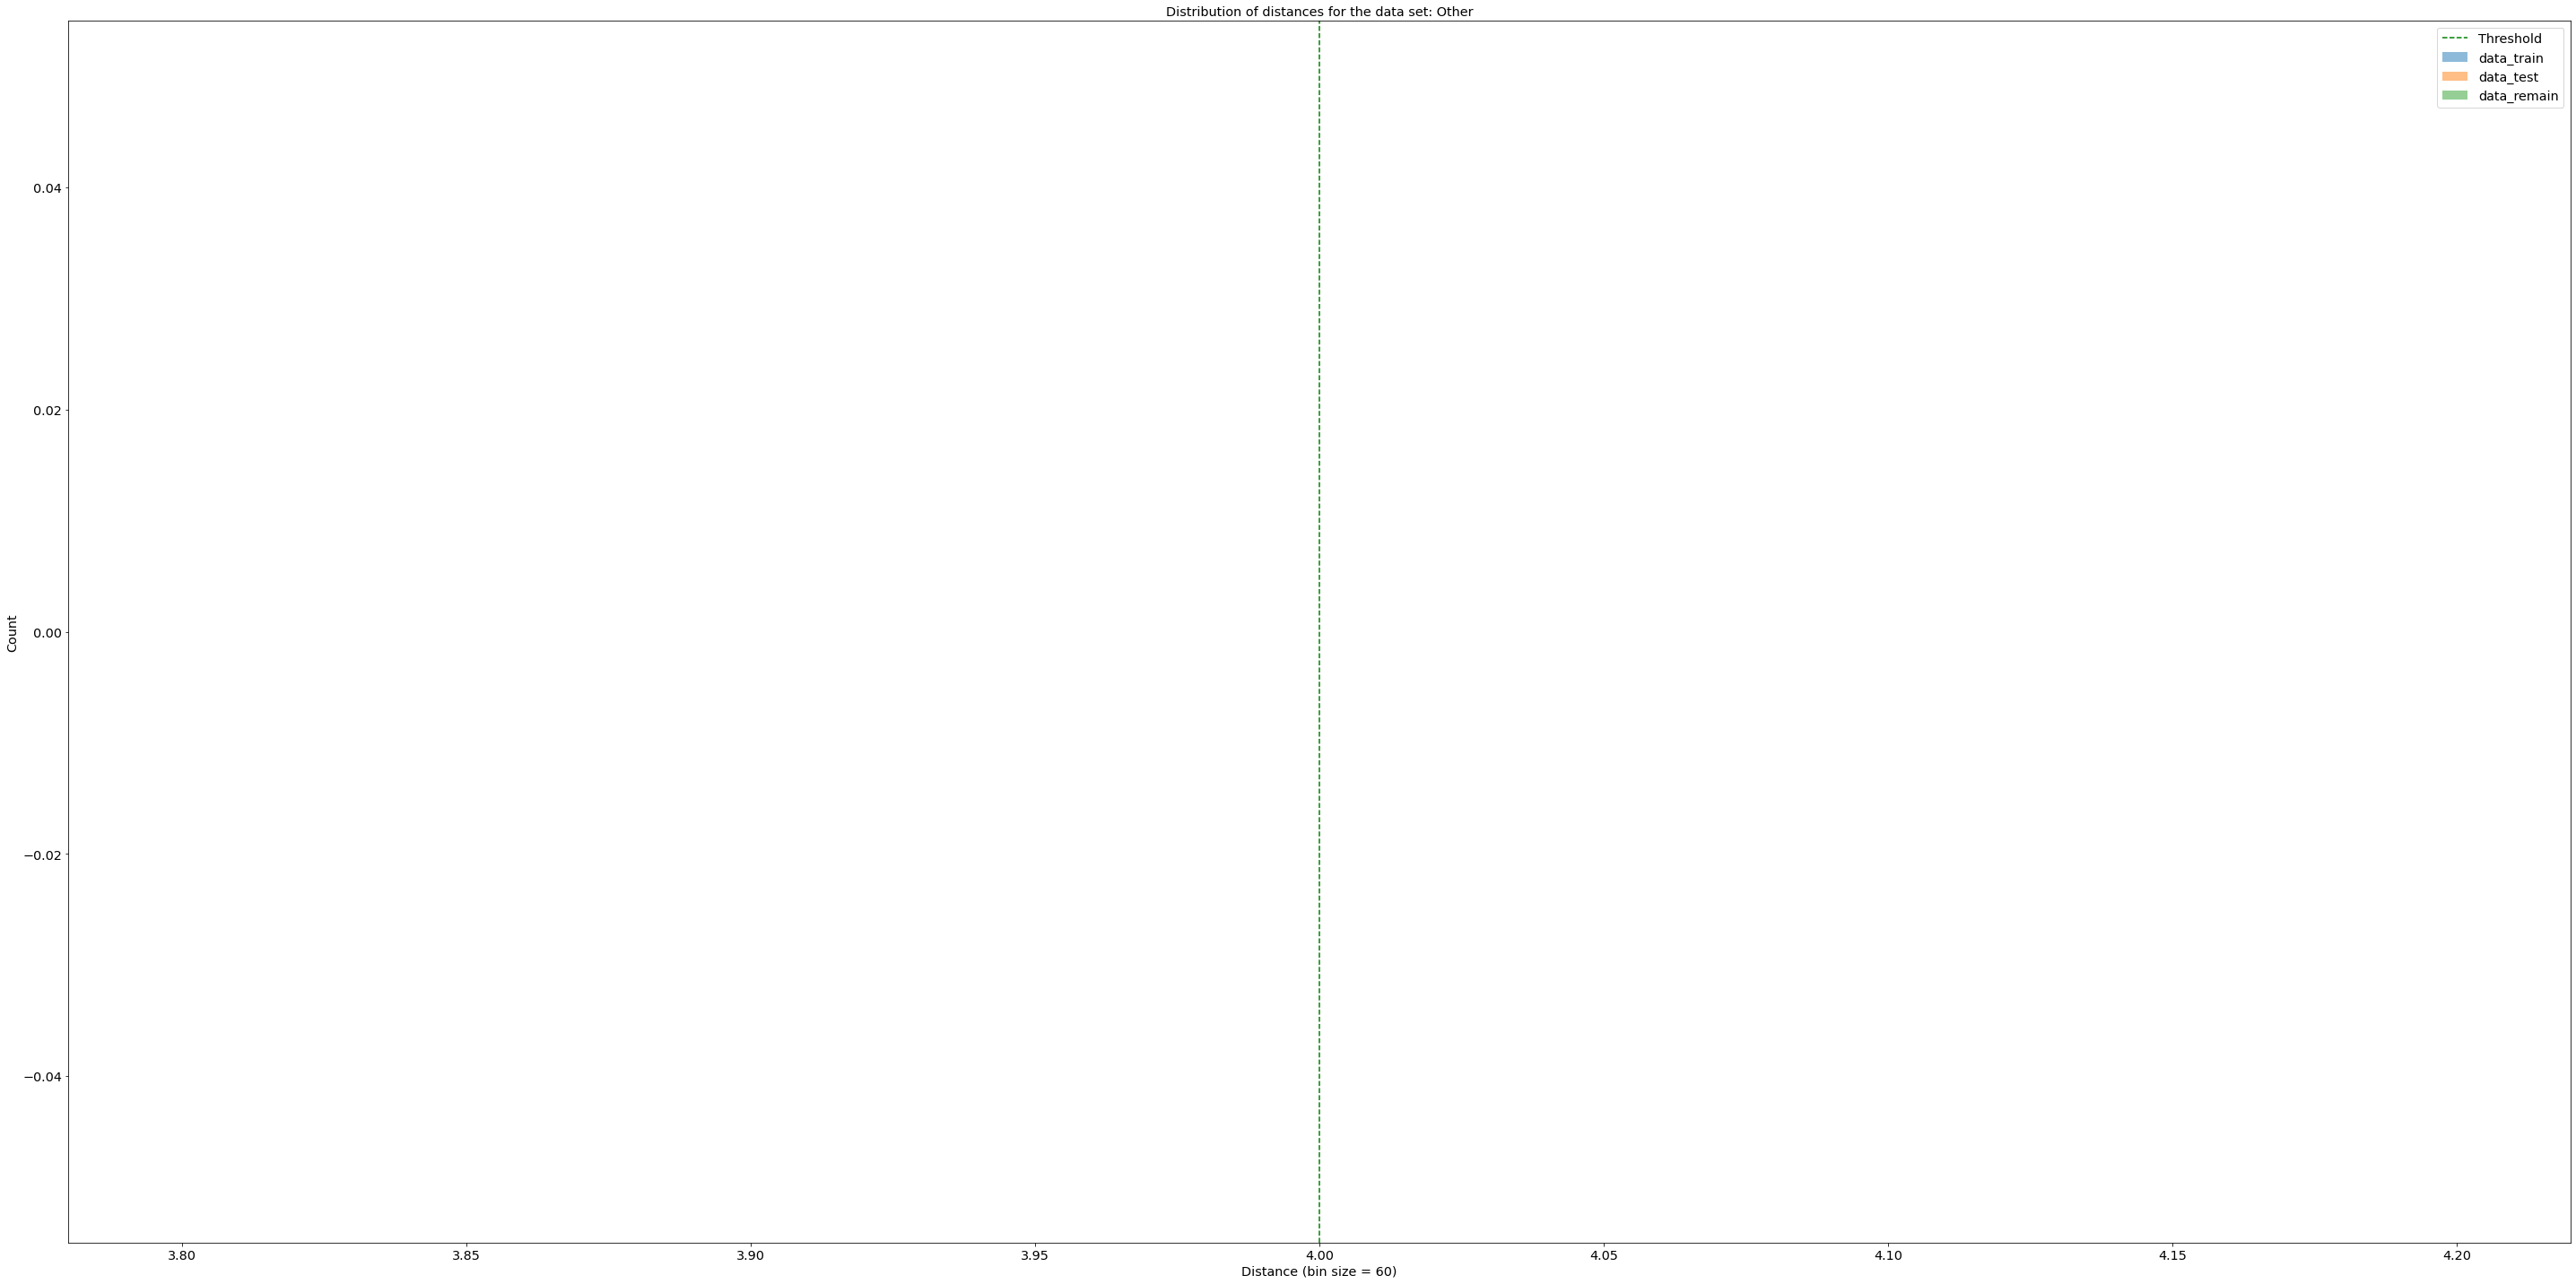

In [11]:
data_set = 'data_test.json_embedding.pt'
for z in data_distance_disturb[data_set]['labels']:

    data_train = np.array([float(k.detach().numpy()) for k in data_distance_disturb[set_names[0]]['labels'][z]['distance']])
    data_test = np.array([float(k.detach().numpy()) for k in data_distance_disturb[set_names[1]]['labels'][z]['distance']])
    data_remain = np.array([float(k.detach().numpy()) for k in data_distance_disturb[set_names[2]]['labels'][z]['distance']])

    bin_size = 60

    fig, ax = plt.subplots()

    counts, bins, _ = ax.hist(data_train, bins=bin_size, label='data_train', density=1, alpha=0.5) # density=1
    counts, bins, _ = ax.hist(data_test, bins=bin_size, label='data_test', density=1, alpha=0.5) # density=1
    counts, bins, _ = ax.hist(data_remain, bins=bin_size, label='data_remain', density=1, alpha=0.5) # density=1

    ax.axvline(4, 0, 1, label='Threshold', color='g', linestyle = '--')
    ax.legend()
    
    ax.set_title(f'Distribution of distances for the data set: {z}')
    ax.set_xlabel(f'Distance (bin size = {bin_size})')
    ax.set_ylabel('Count')
    fig.tight_layout()
    print(f'Train: {len(data_train)} Test: {len(data_test)} Remain: {len(data_remain)}')
    plt.show()

## Distribution of distances for each class.

In [12]:
def get_stats(distances):
    data = np.array([i.detach().numpy() for i in distances])
    precision = 2
    std    = round(float(np.std(data)), 2)
    mean   = round(float(np.mean(data)), 2)
    median = round(float(np.median(data)), 2)
    return std, mean, median

dict_stats = {
    'cnt_train'    : [],
    'std_train'    : [],
    'mean_train'   : [],
    'median_train' : [],
    'cnt_test'     : [],
    'std_test'     : [],
    'mean_test'    : [],
    'median_test'  : [],
    'cnt_remain'   : [],
    'std_remain'   : [],
    'mean_remain'  : [],
    'median_remain': []
}
for label in [data_labels[iddx] for iddx in data_labels]:
    
    std_train, mean_train, median_train = get_stats(data_distance_disturb['data_train.json_embedding.pt']['labels'][label]['distance'])
    dict_stats['cnt_train'].append(len(data_distance_disturb['data_train.json_embedding.pt']['labels'][label]['distance']))
    dict_stats['mean_train'].append(mean_train)
    dict_stats['median_train'].append(median_train)
    dict_stats['std_train'].append(std_train)
    
    std_test, mean_test, median_test = get_stats(data_distance_disturb['data_test.json_embedding.pt']['labels'][label]['distance'])
    dict_stats['cnt_test'].append(len(data_distance_disturb['data_test.json_embedding.pt']['labels'][label]['distance']))
    dict_stats['mean_test'].append(mean_test)
    dict_stats['median_test'].append(median_test)
    dict_stats['std_test'].append(std_test)
    
    std_remain, mean_remain, median_remain = get_stats(data_distance_disturb['data_remain.json_embedding.pt']['labels'][label]['distance'])
    dict_stats['cnt_remain'].append(len(data_distance_disturb['data_remain.json_embedding.pt']['labels'][label]['distance']))
    dict_stats['mean_remain'].append(mean_remain)
    dict_stats['median_remain'].append(median_remain)
    dict_stats['std_remain'].append(std_remain)
#     count, bins = draw_hist(data_sets['train']['labels'][label]['distance'], label)
df = pd.DataFrame(dict_stats, index =[data_labels[iddx] for iddx in data_labels] )

writer = pd.ExcelWriter('output.xlsx')
# write dataframe to excel sheet named 'marks'
df.to_excel(writer, 'marks')
# save the excel file
writer.save()
print('DataFrame is written successfully to Excel Sheet.')


DataFrame is written successfully to Excel Sheet.


In [13]:
df

cnt_train  std_train  mean_train  median_train  \
Platycephalus fuscus              8190       0.75        4.24          4.20   
Paralichthys dentatus             8010       0.60        3.94          3.90   
Micropogonias undulatus          12432       0.62        3.97          3.94   
Aplodinotus grunniens             9312       0.62        4.11          4.09   
Ameiurus nebulosus               10302       0.62        4.10          4.07   
Mustelus canis                     420       0.52        3.97          3.93   
Seriola dumerili                  1122       0.57        3.96          3.95   
Amia calva                       26732       0.67        4.36          4.34   
Esox masquinongy                 28392       0.81        4.11          4.06   
Rhincodon typus                   1406       0.68        4.23          4.20   
Perca flavescens                 28392       0.69        4.11          4.07   
Lepomis auritus                  22952       0.84        4.21          4.16   
Thunnus albacares                 4830       0.65        4.19          4.17   
Dicentrarchus labrax             15252       0.69        4.15          4.15   
Ambloplites rupestris            28392       0.74        4.02          3.99   
Pomoxis annularis                28392       0.75        3.96          3.89   
Caranx hippos                    28392       0.84        4.12          4.14   
Lepisosteus osseus                9120       0.69        4.22          4.23   
Scomberomorus cavalla            28392       0.68        4.19          4.17   
Sander vitreus                   28392       0.73        4.32          4.32   
Salvelinus fontinalis            28392       0.79        4.04          4.02   
Pylodictis olivaris              10302       0.62        4.07          4.06   
Lutjanus synagris                21756       0.79        3.76          3.70   
Centropristis striata            11130       0.72        3.81          3.77   
Oncorhynchus mykiss              28392       0.66        4.06          4.03   
Cyprinus carpio                  28392       0.73        4.12          4.09   
Balistes capriscus                 272       0.66        4.10          4.01   
Archosargus probatocephalus      28392       0.77        4.09          4.07   
Mycteroperca bonaci               6642       0.76        3.94          3.90   
Centropomus undecimalis           9900       0.63        3.86          3.83   
Scomber scombrus                  4970       0.71        4.10          4.07   
Cyprinus carpio carpio            1190       0.63        4.25          4.19   
Ictalurus furcatus                8742       0.64        4.14          4.12   
Oncorhynchus tshawytscha         12432       0.68        4.24          4.20   
Ameiurus melas                    8742       0.68        4.02          4.02   
Pomoxis nigromaculatus           20592       0.77        4.20          4.14   
Micropterus punctulatus          23870       0.67        3.86          3.81   
Scomberomorus maculatus          26732       0.83        4.12          4.09   
Morone saxatilis                 25760       0.79        3.76          3.68   
Paralichthys lethostigma         11556       0.68        4.06          4.02   
Salvelinus namaycush              8372       0.64        3.92          3.91   
Salmo trutta                     28392       0.75        4.10          4.05   
Morone americana                 14762       0.64        4.06          4.02   
Pogonias cromis                  28392       0.68        3.94          3.90   
Morone chrysops                  18632       0.67        3.85          3.81   
Lepomis cyanellus                28392       0.74        3.81          3.75   
Lepomis macrochirus              20592       0.66        4.13          4.10   
Sciaenops ocellatus              28392       0.67        4.01          3.99   
Lepomis microlophus              14762       0.66        3.95          3.92   
Abramis brama                     9312       0.71        3.98          3.91   
